# AD_with_Plaques:1
# NCI_with_No_Plaques: 0

In [1]:

import tensorflow as tf
from gene_expression import *
from pathway_hierarchy import *
from utils import *
import torch

2024-08-13 14:49:17.309816: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-13 14:49:17.319792: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-13 14:49:17.331991: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-13 14:49:17.332009: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-13 14:49:17.341081: I tensorflow/core/platform/cpu_feature_gua

In [2]:
import os
import torch
from tqdm import tqdm
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader
import argparse
from utils import *
from gene_expression import *
from pathway_hierarchy import *
import pandas as pd
import yaml
from custom_neural_network import *
from custom_fc_network import *
from datetime import datetime
import csv
import copy
import pickle
import random
random.seed(0)
np.random.seed(0)

path_config = 'config.yml'
model_dct = dict()

# Hook function
def hook_fn(module, input, output, layer_name):
    global model_dct
    input_list = [i.detach().cpu().numpy().tolist() for i in input]
    output_list = output.detach().cpu().numpy().tolist()
    
    # If the layer name is not in the dictionary, create a new list for it
    if layer_name not in model_dct:
        model_dct[layer_name] = []

    # Append the activations to the corresponding layer list
    model_dct[layer_name].append({
        'input': input_list,
        'output': output_list
    })



# Define the file path for the CSV file
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

class TabularDataset(Dataset):
    def __init__(self, count_matrix, label):
        # Read the CSV file
        self.data = count_matrix
        # Separate features and target
        self.features = self.data.values
        self.target = label.values
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        # Get features and target for a given index
        features = torch.tensor(self.features[idx], dtype=torch.float32)
        target = torch.tensor(self.target[idx], dtype=torch.float32)
        return features, target

def evaluate(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    predicted_list = []
    probability_list = []
    labels_list = []
    criterion = nn.BCEWithLogitsLoss()
    loss = 0
    with torch.no_grad():  # No need to compute gradients during evaluation
        for features, labels in dataloader:
            outputs = model(features)
            #print(outputs)
            probability = torch.sigmoid(outputs.data)
            predicted = torch.round(torch.sigmoid(outputs.data))
            #print(outputs)
            #print(predicted)
            loss += criterion(outputs, labels)
            #_, predicted = torch.sigmoid(outputs.data)
            predicted_list.extend(predicted)
            labels_list.extend(labels)
            probability_list.extend(probability)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    #print(total)
    accuracy = 100 * correct / total
    return accuracy, loss, predicted_list, labels_list, probability_list

def save_model(model_nn,model_path, model_state_dict_path):
    
    model_nn.eval()
    torch.save(model_nn, model_path)
    torch.save(model_nn.state_dict(), model_state_dict_path)




def model_fc(train_dataloader , val_dataloader, test_dataloader, test_cell_id, layers_node, masking, output_layer,model_save_dir, date_string, learning_rate=0.001, num_epochs=50, weight_decay = 0):

    model_nn = CustomfcNetwork(layers_node, output_layer, masking)
    optimizer = optim.AdamW(model_nn.parameters(), lr=learning_rate,weight_decay = weight_decay )  # Using SGD with momentum
    criterion = nn.BCEWithLogitsLoss()
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, verbose=True)
    patience = 20
    best_val_accuracy = 0.0
    epochs_no_improve = 0
    early_stop = False
    csv_file_path = f'{model_save_dir}{date_string}/fc_training_log_{output_layer}.csv'

    try:
        os.makedirs(f'{model_save_dir}{date_string}')
    except:
        print(('...'))

    with open(csv_file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Epoch', 'Train_Loss', 'Train_accuracy','Validation_Loss','Val_accuracy'])

    for epoch in tqdm(range(num_epochs)):
        if early_stop:
            print("Early stopping")
            break
        epoch_cost = 0.
        
        total_loss = 0
        for batch_features,batch_targets in train_dataloader:
            outputs = model_nn(batch_features)
            #print(outputs)
            #print(batch_targets)
            #print(outputs)
            loss = criterion(outputs, batch_targets)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            
        
        train_accuracy, train_loss, predicted_list_train, labels_list_train, train_probability_list = evaluate(model_nn, train_dataloader)
        val_accuracy, val_loss, predicted_list_val, labels_list_val, val_probability_list = evaluate(model_nn, val_dataloader)
        #scheduler.step(val_accuracy)
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss.item():.4f}, Train_accuracy: {train_accuracy}, Val Loss: {val_loss.item():.4f}, Val_accuracy: {val_accuracy}')
        with open(csv_file_path, mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([epoch + 1, loss.item(), train_accuracy, val_loss.item(), val_accuracy])
        
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            epochs_no_improve = 0
        # Save the best model
            model_path = f'{model_save_dir}{date_string}/fc_best_model_{output_layer}.pth'
            model_state_dict_path = f'{model_save_dir}{date_string}/fc_best_model_{output_layer}_state_dict.pth'
            save_model(model_nn, model_path, model_state_dict_path)
            best_model_nn = copy.deepcopy(model_nn)
            #torch.save(model_nn, f'{model_save_dir}{date_string}/fc_best_model_{output_layer}.pth')
            #torch.save(model_nn.state_dict(), f'{model_save_dir}{date_string}/fc_best_model_{output_layer}_state_dict.pth')
            print('Model saved.')
        else:
            epochs_no_improve += 1
    
        # Early stopping
        '''if epochs_no_improve >= patience:
            early_stop = True
            print("Early stopping triggered")'''
        
    
    train_accuracy, train_loss, predicted_list_train, labels_list_train, train_probability_list = evaluate(best_model_nn, train_dataloader)
    val_accuracy, val_loss, predicted_list_val, labels_list_val, val_probability_list = evaluate(best_model_nn, val_dataloader)
    test_accuracy, test_loss, predicted_list_test, labels_list_test, test_probability_list = evaluate(best_model_nn, test_dataloader)
    print('Test Accucary', test_accuracy)
    output_train = (predicted_list_train, labels_list_train)
    output_val = (predicted_list_val, labels_list_val)

    labels_list_test = [m.item() for m in labels_list_test]
    predicted_list_test = [m.item() for m in predicted_list_test]
    test_probability_list = [m.item() for m in test_probability_list]


    test_df = pd.DataFrame({'cell_id': test_cell_id, 'true_y': labels_list_test, 'pred_y': predicted_list_test, 'probabilty': test_probability_list})
    csv_file_path = f'{model_save_dir}{date_string}/fc_test_log_{output_layer}.csv'
    test_df.to_csv(csv_file_path)
    #torch.save(model_nn, f'{model_save_dir}{date_string}/fc_last_epoch_model_{output_layer}.pth')
    return output_train, output_val,best_model_nn



def model(train_dataloader , val_dataloader, test_dataloader, test_cell_id, layers_node, masking, output_layer,model_save_dir, date_string, learning_rate=0.001, num_epochs=50, weight_decay = 0):

    model_nn = CustomNetwork(layers_node, output_layer, masking)
    optimizer = optim.AdamW(model_nn.parameters(), lr=learning_rate,weight_decay = weight_decay )  # Using SGD with momentum
    criterion = nn.BCEWithLogitsLoss()
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=5, verbose=True)
    patience = 20
    best_val_accuracy = 0.0
    epochs_no_improve = 0
    early_stop = False
    csv_file_path = f'{model_save_dir}{date_string}/training_log_{output_layer}.csv'

    try:
        os.makedirs(f'{model_save_dir}{date_string}')
    except:
        print(('...'))

    with open(csv_file_path, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Epoch', 'Train_Loss', 'Train_accuracy','Validation_Loss','Val_accuracy'])

    for epoch in tqdm(range(num_epochs)):
        if early_stop:
            print("Early stopping")
            break
        epoch_cost = 0.
        
        total_loss = 0
        for batch_features,batch_targets in train_dataloader:
            
            #print(outputs)
            #print(batch_targets)
            #print(outputs)
            
            
            optimizer.zero_grad()
            outputs = model_nn(batch_features)
            loss = criterion(outputs, batch_targets)
            loss.backward()
            optimizer.step()
            
            
        
        train_accuracy, train_loss, predicted_list_train, labels_list_train, train_probability_list = evaluate(model_nn, train_dataloader)
        val_accuracy, val_loss, predicted_list_val, labels_list_val, val_probability_list = evaluate(model_nn, val_dataloader)
        #scheduler.step(val_accuracy)
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss.item():.4f}, Train_accuracy: {train_accuracy}, Val Loss: {val_loss.item():.4f}, Val_accuracy: {val_accuracy}')
        with open(csv_file_path, mode='a', newline='') as file:
            writer = csv.writer(file)
            writer.writerow([epoch + 1, loss.item(), train_accuracy, val_loss.item(), val_accuracy])
        
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            epochs_no_improve = 0
        # Save the best model
            model_path = f'{model_save_dir}{date_string}/best_model_{output_layer}.pth'
            model_state_dict_path = f'{model_save_dir}{date_string}/best_model_{output_layer}_state_dict.pth'
            save_model(model_nn, model_path, model_state_dict_path)
            best_model_nn = copy.deepcopy(model_nn)
            #torch.save(model_nn, f'{model_save_dir}{date_string}/best_model_{output_layer}.pth')
            #torch.save(model_nn.state_dict(), f'{model_save_dir}{date_string}/best_model_{output_layer}_state_dict.pth')
            print('Model saved.')
        else:
            epochs_no_improve += 1
    
        # Early stopping
        '''if epochs_no_improve >= patience:
            early_stop = True
            print("Early stopping triggered")'''
        
    
    train_accuracy, train_loss, predicted_list_train, labels_list_train, train_probability_list = evaluate(best_model_nn, train_dataloader)
    val_accuracy, val_loss, predicted_list_val, labels_list_val, val_probability_list = evaluate(best_model_nn, val_dataloader)
    test_accuracy, test_loss, predicted_list_test, labels_list_test, test_probability_list = evaluate(best_model_nn, test_dataloader)
    print('Test Accucary', test_accuracy)
    output_train = (predicted_list_train, labels_list_train)
    output_val = (predicted_list_val, labels_list_val)

    labels_list_test = [m.item() for m in labels_list_test]
    predicted_list_test = [m.item() for m in predicted_list_test]
    test_probability_list = [m.item() for m in test_probability_list]


    test_df = pd.DataFrame({'cell_id': test_cell_id, 'true_y': labels_list_test, 'pred_y': predicted_list_test, 'probabilty': test_probability_list})
    csv_file_path = f'{model_save_dir}{date_string}/test_log_{output_layer}.csv'
    test_df.to_csv(csv_file_path)
    #torch.save(model_nn, f'{model_save_dir}{date_string}/last_epoch_model_{output_layer}.pth')
    return output_train, output_val,best_model_nn


def load_config(config_file):
    with open(config_file, 'r') as file:
        return yaml.safe_load(file)


def main_file(path_config):

    '''parser = argparse.ArgumentParser(description='Sample application with config and argparse')
    parser.add_argument('--config', type=str, default='config.yml', help='Path to the configuration file')
    args = parser.parse_args()'''

    config = load_config(path_config)
    print(config)
    train = pd.read_csv(config['dataset']['train'],index_col=0)
    test = pd.read_csv(config['dataset']['test'],index_col=0)
    val = pd.read_csv(config['dataset']['val'],index_col=0)

    y_train = pd.read_csv(config['dataset']['y_train'])
    y_test = pd.read_csv(config['dataset']['y_test'])
    y_val = pd.read_csv(config['dataset']['y_val'])
  


    r_data_tmp = train.T
    q_data_tmp = test.T
    v_data_tmp = val.T
    r_label_tmp = y_train



    pathway_relation, ensemble_pathway_relation = return_threshold_pathways(config['pathways_network']['pathway_relation'], 
                                  config['pathways_network']['ensemble_pathway_relation'],  config['pathways_network']['h_thresh'],\
                                      config['pathways_network']['l_thresh'])

    if os.path.exists(config['pathways_network']['pathway_relation_updated']):
        os.remove(config['pathways_network']['pathway_relation_updated'])

    if os.path.exists(config['pathways_network']['ensemble_pathway_relation_updated']):
        os.remove(config['pathways_network']['ensemble_pathway_relation_updated'])

    pathway_relation.to_csv(config['pathways_network']['pathway_relation_updated'], sep = '\t', index = False, header= False)
    ensemble_pathway_relation.to_csv(config['pathways_network']['ensemble_pathway_relation_updated'], sep = '\t', index = False, header= False)




    print('Getting Marker Genes.......')
    train_x, test_x, val_x, train_y = get_expression(r_data_tmp,
                                                q_data_tmp,
                                                v_data_tmp,
                                                r_label_tmp,
                                                thrh=config['gene_expression']['highly_expressed_threshold'],
                                                thrl=config['gene_expression']['lowly_expressed_threshold'],
                                                normalization=config['gene_expression']['normalization'],
                                                marker=config['gene_expression']['marker'])
    
    print('Getting Pathway Genes.........')
    pathway_genes = get_gene_pathways(config['pathways_network']['ensemble_pathway_relation_updated'], species=config['pathways_network']['species'])


    print('Getting Masking.........')
    masking, masking_df, layers_node, train_x, test_x,val_x = get_masking(config['pathways_network']['pathway_names'],
                                                        pathway_genes,
                                                        config['pathways_network']['pathway_relation_updated'],
                                                        train_x,
                                                        test_x,
                                                        val_x,
                                                        train_y,
                                                        config['pathways_network']['datatype'],
                                                        config['pathways_network']['species'],
                                                        config['pathways_network']['n_hidden_layer'])

    test_cell_id = list(test_x.T.index) 
    try:
        masking = list(masking.values())
        layers_node = list(layers_node.values())
    except:
        print('already_done')


    train_dataset = TabularDataset(train_x.T,train_y)
    val_dataset = TabularDataset(val_x.T,y_val)
    test_dataset = TabularDataset(test_x.T,y_test)  
    
    

    dataloader_params = {
    'batch_size': config['train']['batch_size'],
    'shuffle': False
    }

    train_dataloader = DataLoader(train_dataset,**dataloader_params)
    test_dataloader = DataLoader(test_dataset, **dataloader_params)
    val_dataloader = DataLoader(val_dataset,**dataloader_params)
    # Example of iterating through the DataLoader


    pred_y_df = pd.DataFrame(data=0, index=test_x.columns, columns=list(range(2, len(masking) + 2)))
    train_y_df = pd.DataFrame(data=0, index=train_x.columns, columns=list(range(2, len(masking) + 2)))
    model_dict_sparse = dict()
    model_dict_fc = dict()
    activation_output = {}
    now = datetime.now()

# Format the date as a string
    date_string = datetime_string = now.strftime("%Y_%m_%d_%H_%M_%S")

    try:
        os.makedirs(f'{config['model_output']['model_save_dir']}{date_string}')
    except:
        print(('...'))

   

    print('Training.........')
    for output_layer in range(2, len(masking) + 2):
        if config['gene_expression']['print_information']:
            print("Current sub-neural network has " + str(output_layer - 1) + " hidden layers.")
        output_train, output_val,model_dict_sparse[output_layer] = model(train_dataloader,
                                            val_dataloader,test_dataloader, test_cell_id,
                                            layers_node,
                                            masking,
                                            output_layer,
                                            model_save_dir = config['model_output']['model_save_dir'],date_string = date_string,
                                            learning_rate=config['train']['learning_rate'],num_epochs=config['train']['epochs'],weight_decay = config['train']['weight_decay']
                                        )  

    print('tranining_fully_connected_layers:')
    for output_layer in range(2, len(masking) + 2):
        if config['gene_expression']['print_information']:
            print("Current sub-neural network has " + str(output_layer - 1) + " hidden layers.")
        output_train, output_val,model_dict_fc[output_layer] = model_fc(train_dataloader,
                                            val_dataloader,test_dataloader, test_cell_id,
                                            layers_node,
                                            masking,
                                            output_layer,
                                            model_save_dir = config['model_output']['model_save_dir'],date_string = date_string,
                                            learning_rate=config['train']['learning_rate'],num_epochs=config['train']['epochs'],weight_decay = config['train']['weight_decay']
                                        )  
        
    new_parameter = {'date_string': date_string}
    config.update(new_parameter)
    save_path =   str(config['model_output']['model_save_dir'])+ date_string + '/config.yml'
    with open(save_path, 'w') as file:
        yaml.dump(config, file)

        
    for i in range(len(masking_df)):
        masking_df[i].to_csv(str(config['model_output']['model_save_dir'])+ date_string+ '/' +f'masking_df_{i}.csv')
    
   
        
    return model_dict_sparse, val_dataloader, test_dataloader, train_dataloader, train_x, train_y, val_x, y_val, test_x, y_test, config

   
model_dict_sparse, val_dataloader, test_dataloader, train_dataloader,train_x, train_y, val_x, y_val, test_x, y_test, config = main_file(path_config= path_config)
for j,i in model_dict_sparse.items():

# Assuming 'model' is your neural network
    torch.save(i.state_dict(), f'{config['model_output']['model_save_dir']}{config['date_string']}/model_{j}_state_dict_jupyter_notebook.pth')


for j,i in model_dict_sparse.items():
        
        print(f'Hidden_Layers: {j}')
        accuracy, loss, predicted_list, labels_list, probability_list = evaluate(i, test_dataloader)
        print(f'Test Accuracy: {accuracy}')   
        accuracy, loss, predicted_list, labels_list, probability_list = evaluate(i, train_dataloader)
        print(f'Train Accuracy: {accuracy}')   
        accuracy, loss, predicted_list, labels_list, probability_list = evaluate(i, val_dataloader)
        print(f'Validation Accuracy: {accuracy}') 

{'dataset': {'train': '/12tb_dsk1/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_L2-3_CBLN2_LINC02306/train.csv', 'test': '/12tb_dsk1/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_L2-3_CBLN2_LINC02306/test.csv', 'val': '/12tb_dsk1/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_L2-3_CBLN2_LINC02306/val.csv', 'y_train': '/12tb_dsk1/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_L2-3_CBLN2_LINC02306/y_train.csv', 'y_test': '/12tb_dsk1/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_L2-3_CBLN2_LINC02306/y_test.csv', 'y_val': '/12tb_dsk1/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_L2-3_CBLN2_LINC02306/y_val.csv'}, 'model_output': {'model_save_dir': '/12tb_dsk1/danish/Pytorch_Biologically_Informed_Neural_Network/model_save/excito

/home/anwer/.local/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


...


  0%|▌                                                                                                                                                                           | 1/300 [00:01<05:25,  1.09s/it]

Epoch [1/300], Train Loss: 1.3827, Train_accuracy: 50.74192403265886, Val Loss: 0.6913, Val_accuracy: 51.09691160809372
Model saved.


  1%|█▏                                                                                                                                                                          | 2/300 [00:02<05:34,  1.12s/it]

Epoch [2/300], Train Loss: 1.3791, Train_accuracy: 54.710685126020586, Val Loss: 0.6896, Val_accuracy: 54.84558040468583
Model saved.


  1%|█▋                                                                                                                                                                          | 3/300 [00:03<05:13,  1.05s/it]

Epoch [3/300], Train Loss: 1.3752, Train_accuracy: 61.93823216187433, Val Loss: 0.6877, Val_accuracy: 61.36315228966986
Model saved.


  1%|██▎                                                                                                                                                                         | 4/300 [00:04<05:16,  1.07s/it]

Epoch [4/300], Train Loss: 1.3708, Train_accuracy: 64.31664891728789, Val Loss: 0.6857, Val_accuracy: 63.89776357827476
Model saved.


  2%|██▊                                                                                                                                                                         | 5/300 [00:05<05:18,  1.08s/it]

Epoch [5/300], Train Loss: 1.3660, Train_accuracy: 64.8136315228967, Val Loss: 0.6834, Val_accuracy: 64.38764643237486
Model saved.


  2%|███▍                                                                                                                                                                        | 6/300 [00:06<05:18,  1.08s/it]

Epoch [6/300], Train Loss: 1.3607, Train_accuracy: 65.21121760738374, Val Loss: 0.6808, Val_accuracy: 64.72843450479233
Model saved.


  2%|████                                                                                                                                                                        | 7/300 [00:07<05:17,  1.08s/it]

Epoch [7/300], Train Loss: 1.3548, Train_accuracy: 65.49520766773163, Val Loss: 0.6780, Val_accuracy: 65.19701810436635
Model saved.


  3%|████▌                                                                                                                                                                       | 8/300 [00:08<05:16,  1.08s/it]

Epoch [8/300], Train Loss: 1.3485, Train_accuracy: 65.63720269790558, Val Loss: 0.6750, Val_accuracy: 65.3035143769968
Model saved.


  3%|█████▏                                                                                                                                                                      | 9/300 [00:09<05:14,  1.08s/it]

Epoch [9/300], Train Loss: 1.3416, Train_accuracy: 65.48100816471424, Val Loss: 0.6718, Val_accuracy: 65.43130990415335
Model saved.


  3%|█████▋                                                                                                                                                                     | 10/300 [00:10<05:09,  1.07s/it]

Epoch [10/300], Train Loss: 1.3344, Train_accuracy: 65.71529996450124, Val Loss: 0.6683, Val_accuracy: 65.3035143769968


  4%|██████▎                                                                                                                                                                    | 11/300 [00:11<05:06,  1.06s/it]

Epoch [11/300], Train Loss: 1.3267, Train_accuracy: 66.02058927937522, Val Loss: 0.6647, Val_accuracy: 65.36741214057508


  4%|██████▊                                                                                                                                                                    | 12/300 [00:12<05:07,  1.07s/it]

Epoch [12/300], Train Loss: 1.3187, Train_accuracy: 66.0773872914448, Val Loss: 0.6609, Val_accuracy: 65.49520766773163
Model saved.


  4%|███████▍                                                                                                                                                                   | 13/300 [00:13<05:09,  1.08s/it]

Epoch [13/300], Train Loss: 1.3104, Train_accuracy: 66.28328008519702, Val Loss: 0.6570, Val_accuracy: 65.77209797657082
Model saved.


  5%|███████▉                                                                                                                                                                   | 14/300 [00:14<04:55,  1.03s/it]

Epoch [14/300], Train Loss: 1.3018, Train_accuracy: 66.47497337593184, Val Loss: 0.6530, Val_accuracy: 66.17678381256655
Model saved.


  5%|████████▌                                                                                                                                                                  | 15/300 [00:15<04:55,  1.04s/it]

Epoch [15/300], Train Loss: 1.2931, Train_accuracy: 66.65246716364928, Val Loss: 0.6490, Val_accuracy: 66.15548455804047


  5%|█████████                                                                                                                                                                  | 16/300 [00:17<04:57,  1.05s/it]

Epoch [16/300], Train Loss: 1.2843, Train_accuracy: 66.90805821796238, Val Loss: 0.6449, Val_accuracy: 66.41107561235357
Model saved.


  6%|█████████▋                                                                                                                                                                 | 17/300 [00:18<05:00,  1.06s/it]

Epoch [17/300], Train Loss: 1.2753, Train_accuracy: 67.16364927227546, Val Loss: 0.6408, Val_accuracy: 66.68796592119276
Model saved.


  6%|██████████▎                                                                                                                                                                | 18/300 [00:19<05:01,  1.07s/it]

Epoch [18/300], Train Loss: 1.2662, Train_accuracy: 67.62513312034079, Val Loss: 0.6367, Val_accuracy: 66.92225772097977
Model saved.


  6%|██████████▊                                                                                                                                                                | 19/300 [00:20<05:02,  1.08s/it]

Epoch [19/300], Train Loss: 1.2571, Train_accuracy: 68.07951721689741, Val Loss: 0.6325, Val_accuracy: 67.13525026624067
Model saved.


  7%|███████████▍                                                                                                                                                               | 20/300 [00:21<05:02,  1.08s/it]

Epoch [20/300], Train Loss: 1.2478, Train_accuracy: 68.6261980830671, Val Loss: 0.6284, Val_accuracy: 67.39084132055378
Model saved.


  7%|███████████▉                                                                                                                                                               | 21/300 [00:22<05:02,  1.08s/it]

Epoch [21/300], Train Loss: 1.2386, Train_accuracy: 69.08058217962372, Val Loss: 0.6244, Val_accuracy: 67.51863684771033
Model saved.


  7%|████████████▌                                                                                                                                                              | 22/300 [00:23<05:01,  1.09s/it]

Epoch [22/300], Train Loss: 1.2294, Train_accuracy: 69.47816826411075, Val Loss: 0.6204, Val_accuracy: 67.94462193823216
Model saved.


  8%|█████████████                                                                                                                                                              | 23/300 [00:24<05:01,  1.09s/it]

Epoch [23/300], Train Loss: 1.2202, Train_accuracy: 69.96095136670216, Val Loss: 0.6164, Val_accuracy: 68.604898828541
Model saved.


  8%|█████████████▋                                                                                                                                                             | 24/300 [00:25<04:47,  1.04s/it]

Epoch [24/300], Train Loss: 1.2112, Train_accuracy: 70.09584664536742, Val Loss: 0.6126, Val_accuracy: 68.96698615548456
Model saved.


  8%|██████████████▎                                                                                                                                                            | 25/300 [00:26<04:51,  1.06s/it]

Epoch [25/300], Train Loss: 1.2022, Train_accuracy: 70.386936457224, Val Loss: 0.6089, Val_accuracy: 69.28647497337593
Model saved.


  9%|██████████████▊                                                                                                                                                            | 26/300 [00:27<04:53,  1.07s/it]

Epoch [26/300], Train Loss: 1.1933, Train_accuracy: 70.67092651757189, Val Loss: 0.6052, Val_accuracy: 69.49946751863685
Model saved.


  9%|███████████████▍                                                                                                                                                           | 27/300 [00:28<04:54,  1.08s/it]

Epoch [27/300], Train Loss: 1.1846, Train_accuracy: 71.21050763223288, Val Loss: 0.6017, Val_accuracy: 69.98935037273695
Model saved.


  9%|███████████████▉                                                                                                                                                           | 28/300 [00:30<04:55,  1.09s/it]

Epoch [28/300], Train Loss: 1.1760, Train_accuracy: 71.61519346822861, Val Loss: 0.5984, Val_accuracy: 70.33013844515442
Model saved.


 10%|████████████████▌                                                                                                                                                          | 29/300 [00:31<04:49,  1.07s/it]

Epoch [29/300], Train Loss: 1.1676, Train_accuracy: 71.81398651047213, Val Loss: 0.5951, Val_accuracy: 70.26624068157615


 10%|█████████████████                                                                                                                                                          | 30/300 [00:32<04:51,  1.08s/it]

Epoch [30/300], Train Loss: 1.1593, Train_accuracy: 72.05537806176784, Val Loss: 0.5919, Val_accuracy: 70.45793397231097
Model saved.


 10%|█████████████████▋                                                                                                                                                         | 31/300 [00:33<04:51,  1.08s/it]

Epoch [31/300], Train Loss: 1.1512, Train_accuracy: 72.36776712815052, Val Loss: 0.5889, Val_accuracy: 70.71352502662407
Model saved.


 11%|██████████████████▏                                                                                                                                                        | 32/300 [00:34<04:50,  1.09s/it]

Epoch [32/300], Train Loss: 1.1431, Train_accuracy: 72.52396166134186, Val Loss: 0.5859, Val_accuracy: 70.82002129925452
Model saved.


 11%|██████████████████▊                                                                                                                                                        | 33/300 [00:35<04:51,  1.09s/it]

Epoch [33/300], Train Loss: 1.1353, Train_accuracy: 72.83635072772454, Val Loss: 0.5830, Val_accuracy: 70.90521831735889
Model saved.


 11%|███████████████████▍                                                                                                                                                       | 34/300 [00:36<04:50,  1.09s/it]

Epoch [34/300], Train Loss: 1.1275, Train_accuracy: 73.02804401845935, Val Loss: 0.5802, Val_accuracy: 71.07561235356762
Model saved.


 12%|███████████████████▉                                                                                                                                                       | 35/300 [00:37<04:34,  1.03s/it]

Epoch [35/300], Train Loss: 1.1198, Train_accuracy: 73.34753283635072, Val Loss: 0.5775, Val_accuracy: 71.05431309904154


 12%|████████████████████▌                                                                                                                                                      | 36/300 [00:38<04:38,  1.05s/it]

Epoch [36/300], Train Loss: 1.1123, Train_accuracy: 73.70962016329429, Val Loss: 0.5749, Val_accuracy: 71.28860489882854
Model saved.


 12%|█████████████████████                                                                                                                                                      | 37/300 [00:39<04:36,  1.05s/it]

Epoch [37/300], Train Loss: 1.1050, Train_accuracy: 73.95811146609869, Val Loss: 0.5723, Val_accuracy: 71.20340788072417


 13%|█████████████████████▋                                                                                                                                                     | 38/300 [00:40<04:39,  1.07s/it]

Epoch [38/300], Train Loss: 1.0977, Train_accuracy: 74.1498047568335, Val Loss: 0.5698, Val_accuracy: 71.30990415335464
Model saved.


 13%|██████████████████████▏                                                                                                                                                    | 39/300 [00:41<04:41,  1.08s/it]

Epoch [39/300], Train Loss: 1.0906, Train_accuracy: 74.4053958111466, Val Loss: 0.5674, Val_accuracy: 71.35250266240682
Model saved.


 13%|██████████████████████▊                                                                                                                                                    | 40/300 [00:42<04:42,  1.09s/it]

Epoch [40/300], Train Loss: 1.0836, Train_accuracy: 74.58288959886404, Val Loss: 0.5650, Val_accuracy: 71.395101171459
Model saved.


 14%|███████████████████████▎                                                                                                                                                   | 41/300 [00:43<04:42,  1.09s/it]

Epoch [41/300], Train Loss: 1.0767, Train_accuracy: 74.76038338658147, Val Loss: 0.5627, Val_accuracy: 71.69329073482429
Model saved.


 14%|███████████████████████▉                                                                                                                                                   | 42/300 [00:45<04:42,  1.10s/it]

Epoch [42/300], Train Loss: 1.0700, Train_accuracy: 74.85977990770323, Val Loss: 0.5605, Val_accuracy: 71.77848775292864
Model saved.


 14%|████████████████████████▌                                                                                                                                                  | 43/300 [00:46<04:42,  1.10s/it]

Epoch [43/300], Train Loss: 1.0633, Train_accuracy: 75.04437344692936, Val Loss: 0.5583, Val_accuracy: 72.03407880724174
Model saved.


 15%|█████████████████████████                                                                                                                                                  | 44/300 [00:47<04:41,  1.10s/it]

Epoch [44/300], Train Loss: 1.0568, Train_accuracy: 75.23606673766419, Val Loss: 0.5562, Val_accuracy: 72.16187433439829
Model saved.


 15%|█████████████████████████▋                                                                                                                                                 | 45/300 [00:48<04:28,  1.05s/it]

Epoch [45/300], Train Loss: 1.0504, Train_accuracy: 75.52715654952077, Val Loss: 0.5542, Val_accuracy: 72.26837060702876
Model saved.


 15%|██████████████████████████▏                                                                                                                                                | 46/300 [00:49<04:30,  1.07s/it]

Epoch [46/300], Train Loss: 1.0441, Train_accuracy: 75.80404685835995, Val Loss: 0.5522, Val_accuracy: 72.39616613418531
Model saved.


 16%|██████████████████████████▊                                                                                                                                                | 47/300 [00:50<04:31,  1.07s/it]

Epoch [47/300], Train Loss: 1.0379, Train_accuracy: 76.01703940362087, Val Loss: 0.5503, Val_accuracy: 72.58785942492013
Model saved.


 16%|███████████████████████████▎                                                                                                                                               | 48/300 [00:51<04:33,  1.08s/it]

Epoch [48/300], Train Loss: 1.0318, Train_accuracy: 76.26553070642528, Val Loss: 0.5484, Val_accuracy: 73.01384451544196
Model saved.


 16%|███████████████████████████▉                                                                                                                                               | 49/300 [00:52<04:33,  1.09s/it]

Epoch [49/300], Train Loss: 1.0258, Train_accuracy: 76.45012424565141, Val Loss: 0.5465, Val_accuracy: 73.05644302449414
Model saved.


 17%|████████████████████████████▌                                                                                                                                              | 50/300 [00:53<04:33,  1.09s/it]

Epoch [50/300], Train Loss: 1.0199, Train_accuracy: 76.74831380901668, Val Loss: 0.5447, Val_accuracy: 73.1629392971246
Model saved.


 17%|█████████████████████████████                                                                                                                                              | 51/300 [00:54<04:28,  1.08s/it]

Epoch [51/300], Train Loss: 1.0141, Train_accuracy: 76.9684061057863, Val Loss: 0.5430, Val_accuracy: 73.09904153354633


 17%|█████████████████████████████▋                                                                                                                                             | 52/300 [00:55<04:24,  1.07s/it]

Epoch [52/300], Train Loss: 1.0084, Train_accuracy: 77.02520411785588, Val Loss: 0.5413, Val_accuracy: 73.1629392971246


 18%|██████████████████████████████▏                                                                                                                                            | 53/300 [00:56<04:25,  1.08s/it]

Epoch [53/300], Train Loss: 1.0028, Train_accuracy: 77.18849840255591, Val Loss: 0.5397, Val_accuracy: 73.31203407880724
Model saved.


 18%|██████████████████████████████▊                                                                                                                                            | 54/300 [00:58<04:26,  1.08s/it]

Epoch [54/300], Train Loss: 0.9973, Train_accuracy: 77.27369542066027, Val Loss: 0.5381, Val_accuracy: 73.39723109691161
Model saved.


 18%|███████████████████████████████▎                                                                                                                                           | 55/300 [00:59<04:23,  1.08s/it]

Epoch [55/300], Train Loss: 0.9919, Train_accuracy: 77.57188498402556, Val Loss: 0.5365, Val_accuracy: 73.33333333333333


 19%|███████████████████████████████▉                                                                                                                                           | 56/300 [00:59<04:08,  1.02s/it]

Epoch [56/300], Train Loss: 0.9865, Train_accuracy: 77.76357827476038, Val Loss: 0.5351, Val_accuracy: 73.33333333333333


 19%|████████████████████████████████▍                                                                                                                                          | 57/300 [01:01<04:14,  1.05s/it]

Epoch [57/300], Train Loss: 0.9813, Train_accuracy: 78.04046858359958, Val Loss: 0.5336, Val_accuracy: 73.54632587859425
Model saved.


 19%|█████████████████████████████████                                                                                                                                          | 58/300 [01:02<04:16,  1.06s/it]

Epoch [58/300], Train Loss: 0.9761, Train_accuracy: 78.2037628682996, Val Loss: 0.5322, Val_accuracy: 73.63152289669861
Model saved.


 20%|█████████████████████████████████▋                                                                                                                                         | 59/300 [01:03<04:18,  1.07s/it]

Epoch [59/300], Train Loss: 0.9710, Train_accuracy: 78.44515441959531, Val Loss: 0.5309, Val_accuracy: 73.65282215122471
Model saved.


 20%|██████████████████████████████████▏                                                                                                                                        | 60/300 [01:04<04:19,  1.08s/it]

Epoch [60/300], Train Loss: 0.9660, Train_accuracy: 78.58714944976926, Val Loss: 0.5296, Val_accuracy: 73.6954206602769
Model saved.


 20%|██████████████████████████████████▊                                                                                                                                        | 61/300 [01:05<04:19,  1.09s/it]

Epoch [61/300], Train Loss: 0.9611, Train_accuracy: 78.7291444799432, Val Loss: 0.5284, Val_accuracy: 73.82321618743345
Model saved.


 21%|███████████████████████████████████▎                                                                                                                                       | 62/300 [01:06<04:19,  1.09s/it]

Epoch [62/300], Train Loss: 0.9563, Train_accuracy: 78.82144124955627, Val Loss: 0.5272, Val_accuracy: 73.99361022364218
Model saved.


 21%|███████████████████████████████████▉                                                                                                                                       | 63/300 [01:07<04:19,  1.09s/it]

Epoch [63/300], Train Loss: 0.9515, Train_accuracy: 78.97053603123891, Val Loss: 0.5260, Val_accuracy: 74.12140575079871
Model saved.


 21%|████████████████████████████████████▍                                                                                                                                      | 64/300 [01:08<04:19,  1.10s/it]

Epoch [64/300], Train Loss: 0.9468, Train_accuracy: 79.08413205537806, Val Loss: 0.5249, Val_accuracy: 74.14270500532481
Model saved.


 22%|█████████████████████████████████████                                                                                                                                      | 65/300 [01:09<04:18,  1.10s/it]

Epoch [65/300], Train Loss: 0.9422, Train_accuracy: 79.16222932197373, Val Loss: 0.5239, Val_accuracy: 74.33439829605963
Model saved.


 22%|█████████████████████████████████████▌                                                                                                                                     | 66/300 [01:10<04:03,  1.04s/it]

Epoch [66/300], Train Loss: 0.9377, Train_accuracy: 79.24742634007809, Val Loss: 0.5229, Val_accuracy: 74.27050053248136


 22%|██████████████████████████████████████▏                                                                                                                                    | 67/300 [01:11<04:07,  1.06s/it]

Epoch [67/300], Train Loss: 0.9332, Train_accuracy: 79.43201987930422, Val Loss: 0.5219, Val_accuracy: 74.39829605963791
Model saved.


 23%|██████████████████████████████████████▊                                                                                                                                    | 68/300 [01:12<04:04,  1.05s/it]

Epoch [68/300], Train Loss: 0.9288, Train_accuracy: 79.56691515796948, Val Loss: 0.5210, Val_accuracy: 74.31309904153355


 23%|███████████████████████████████████████▎                                                                                                                                   | 69/300 [01:14<04:07,  1.07s/it]

Epoch [69/300], Train Loss: 0.9245, Train_accuracy: 79.70181043663472, Val Loss: 0.5201, Val_accuracy: 74.50479233226837
Model saved.


 23%|███████████████████████████████████████▉                                                                                                                                   | 70/300 [01:15<04:08,  1.08s/it]

Epoch [70/300], Train Loss: 0.9203, Train_accuracy: 79.7586084487043, Val Loss: 0.5192, Val_accuracy: 74.56869009584665
Model saved.


 24%|████████████████████████████████████████▍                                                                                                                                  | 71/300 [01:16<04:09,  1.09s/it]

Epoch [71/300], Train Loss: 0.9161, Train_accuracy: 79.88640397586084, Val Loss: 0.5184, Val_accuracy: 74.61128860489883
Model saved.


 24%|█████████████████████████████████████████                                                                                                                                  | 72/300 [01:17<04:08,  1.09s/it]

Epoch [72/300], Train Loss: 0.9120, Train_accuracy: 80.0141995030174, Val Loss: 0.5176, Val_accuracy: 74.71778487752928
Model saved.


 24%|█████████████████████████████████████████▌                                                                                                                                 | 73/300 [01:18<04:09,  1.10s/it]

Epoch [73/300], Train Loss: 0.9080, Train_accuracy: 80.14199503017394, Val Loss: 0.5169, Val_accuracy: 74.78168264110757
Model saved.


 25%|██████████████████████████████████████████▏                                                                                                                                | 74/300 [01:19<04:08,  1.10s/it]

Epoch [74/300], Train Loss: 0.9040, Train_accuracy: 80.2484913028044, Val Loss: 0.5162, Val_accuracy: 74.84558040468583
Model saved.


 25%|██████████████████████████████████████████▊                                                                                                                                | 75/300 [01:20<04:07,  1.10s/it]

Epoch [75/300], Train Loss: 0.9001, Train_accuracy: 80.45438409655662, Val Loss: 0.5155, Val_accuracy: 74.90947816826412
Model saved.


 25%|███████████████████████████████████████████▎                                                                                                                               | 76/300 [01:21<04:02,  1.08s/it]

Epoch [76/300], Train Loss: 0.8962, Train_accuracy: 80.53958111466099, Val Loss: 0.5148, Val_accuracy: 74.84558040468583


 26%|███████████████████████████████████████████▉                                                                                                                               | 77/300 [01:22<03:49,  1.03s/it]

Epoch [77/300], Train Loss: 0.8924, Train_accuracy: 80.58217962371317, Val Loss: 0.5142, Val_accuracy: 74.86687965921193


 26%|████████████████████████████████████████████▍                                                                                                                              | 78/300 [01:23<03:48,  1.03s/it]

Epoch [78/300], Train Loss: 0.8887, Train_accuracy: 80.72417465388712, Val Loss: 0.5136, Val_accuracy: 74.80298189563365


 26%|█████████████████████████████████████████████                                                                                                                              | 79/300 [01:24<03:49,  1.04s/it]

Epoch [79/300], Train Loss: 0.8850, Train_accuracy: 80.81647142350018, Val Loss: 0.5131, Val_accuracy: 74.76038338658147


 27%|█████████████████████████████████████████████▌                                                                                                                             | 80/300 [01:25<03:47,  1.04s/it]

Epoch [80/300], Train Loss: 0.8814, Train_accuracy: 80.95846645367412, Val Loss: 0.5125, Val_accuracy: 74.73908413205538


 27%|██████████████████████████████████████████████▏                                                                                                                            | 81/300 [01:26<03:48,  1.04s/it]

Epoch [81/300], Train Loss: 0.8779, Train_accuracy: 81.04366347177849, Val Loss: 0.5120, Val_accuracy: 74.78168264110757


 27%|██████████████████████████████████████████████▋                                                                                                                            | 82/300 [01:27<03:46,  1.04s/it]

Epoch [82/300], Train Loss: 0.8744, Train_accuracy: 81.18565850195243, Val Loss: 0.5116, Val_accuracy: 74.86687965921193


 28%|███████████████████████████████████████████████▎                                                                                                                           | 83/300 [01:28<03:50,  1.06s/it]

Epoch [83/300], Train Loss: 0.8709, Train_accuracy: 81.27795527156549, Val Loss: 0.5111, Val_accuracy: 74.97337593184238
Model saved.


 28%|███████████████████████████████████████████████▉                                                                                                                           | 84/300 [01:30<03:51,  1.07s/it]

Epoch [84/300], Train Loss: 0.8675, Train_accuracy: 81.34895278665246, Val Loss: 0.5107, Val_accuracy: 74.99467518636848
Model saved.


 28%|████████████████████████████████████████████████▍                                                                                                                          | 85/300 [01:31<03:48,  1.06s/it]

Epoch [85/300], Train Loss: 0.8642, Train_accuracy: 81.44124955626553, Val Loss: 0.5103, Val_accuracy: 74.97337593184238


 29%|█████████████████████████████████████████████████                                                                                                                          | 86/300 [01:32<03:50,  1.08s/it]

Epoch [86/300], Train Loss: 0.8609, Train_accuracy: 81.54774582889598, Val Loss: 0.5099, Val_accuracy: 75.01597444089457
Model saved.


 29%|█████████████████████████████████████████████████▌                                                                                                                         | 87/300 [01:33<03:40,  1.04s/it]

Epoch [87/300], Train Loss: 0.8577, Train_accuracy: 81.7465388711395, Val Loss: 0.5095, Val_accuracy: 75.07987220447285
Model saved.


 29%|██████████████████████████████████████████████████▏                                                                                                                        | 88/300 [01:34<03:39,  1.04s/it]

Epoch [88/300], Train Loss: 0.8545, Train_accuracy: 81.83173588924387, Val Loss: 0.5092, Val_accuracy: 75.05857294994675


 30%|██████████████████████████████████████████████████▋                                                                                                                        | 89/300 [01:35<03:38,  1.04s/it]

Epoch [89/300], Train Loss: 0.8513, Train_accuracy: 81.96663116790913, Val Loss: 0.5089, Val_accuracy: 75.01597444089457


 30%|███████████████████████████████████████████████████▎                                                                                                                       | 90/300 [01:36<03:41,  1.06s/it]

Epoch [90/300], Train Loss: 0.8482, Train_accuracy: 81.98793042243521, Val Loss: 0.5086, Val_accuracy: 75.10117145899893
Model saved.


 30%|███████████████████████████████████████████████████▊                                                                                                                       | 91/300 [01:37<03:44,  1.07s/it]

Epoch [91/300], Train Loss: 0.8452, Train_accuracy: 82.09442669506568, Val Loss: 0.5083, Val_accuracy: 75.1863684771033
Model saved.


 31%|████████████████████████████████████████████████████▍                                                                                                                      | 92/300 [01:38<03:45,  1.09s/it]

Epoch [92/300], Train Loss: 0.8422, Train_accuracy: 82.12282570110047, Val Loss: 0.5081, Val_accuracy: 75.2076677316294
Model saved.


 31%|█████████████████████████████████████████████████████                                                                                                                      | 93/300 [01:39<03:46,  1.09s/it]

Epoch [93/300], Train Loss: 0.8392, Train_accuracy: 82.2932197373092, Val Loss: 0.5078, Val_accuracy: 75.27156549520767
Model saved.


 31%|█████████████████████████████████████████████████████▌                                                                                                                     | 94/300 [01:40<03:46,  1.10s/it]

Epoch [94/300], Train Loss: 0.8363, Train_accuracy: 82.36421725239616, Val Loss: 0.5076, Val_accuracy: 75.33546325878594
Model saved.


 32%|██████████████████████████████████████████████████████▏                                                                                                                    | 95/300 [01:41<03:46,  1.10s/it]

Epoch [95/300], Train Loss: 0.8334, Train_accuracy: 82.44941427050053, Val Loss: 0.5074, Val_accuracy: 75.39936102236422
Model saved.


 32%|██████████████████████████████████████████████████████▋                                                                                                                    | 96/300 [01:42<03:42,  1.09s/it]

Epoch [96/300], Train Loss: 0.8306, Train_accuracy: 82.5204117855875, Val Loss: 0.5072, Val_accuracy: 75.33546325878594


 32%|███████████████████████████████████████████████████████▎                                                                                                                   | 97/300 [01:44<03:39,  1.08s/it]

Epoch [97/300], Train Loss: 0.8278, Train_accuracy: 82.59850905218318, Val Loss: 0.5070, Val_accuracy: 75.33546325878594


 33%|███████████████████████████████████████████████████████▊                                                                                                                   | 98/300 [01:44<03:27,  1.03s/it]

Epoch [98/300], Train Loss: 0.8250, Train_accuracy: 82.61270855520057, Val Loss: 0.5069, Val_accuracy: 75.39936102236422


 33%|████████████████████████████████████████████████████████▍                                                                                                                  | 99/300 [01:46<03:31,  1.05s/it]

Epoch [99/300], Train Loss: 0.8223, Train_accuracy: 82.68370607028754, Val Loss: 0.5067, Val_accuracy: 75.4419595314164
Model saved.


 33%|████████████████████████████████████████████████████████▋                                                                                                                 | 100/300 [01:47<03:33,  1.07s/it]

Epoch [100/300], Train Loss: 0.8196, Train_accuracy: 82.80440184593539, Val Loss: 0.5066, Val_accuracy: 75.50585729499467
Model saved.


 34%|█████████████████████████████████████████████████████████▏                                                                                                                | 101/300 [01:48<03:34,  1.08s/it]

Epoch [101/300], Train Loss: 0.8170, Train_accuracy: 82.88959886403975, Val Loss: 0.5065, Val_accuracy: 75.54845580404685
Model saved.


 34%|█████████████████████████████████████████████████████████▊                                                                                                                | 102/300 [01:49<03:35,  1.09s/it]

Epoch [102/300], Train Loss: 0.8143, Train_accuracy: 82.91799787007454, Val Loss: 0.5064, Val_accuracy: 75.61235356762514
Model saved.


 34%|██████████████████████████████████████████████████████████▎                                                                                                               | 103/300 [01:50<03:31,  1.07s/it]

Epoch [103/300], Train Loss: 0.8118, Train_accuracy: 83.01029463968761, Val Loss: 0.5063, Val_accuracy: 75.54845580404685


 35%|██████████████████████████████████████████████████████████▉                                                                                                               | 104/300 [01:51<03:29,  1.07s/it]

Epoch [104/300], Train Loss: 0.8092, Train_accuracy: 83.0457933972311, Val Loss: 0.5063, Val_accuracy: 75.52715654952077


 35%|███████████████████████████████████████████████████████████▍                                                                                                              | 105/300 [01:52<03:26,  1.06s/it]

Epoch [105/300], Train Loss: 0.8067, Train_accuracy: 83.11679091231807, Val Loss: 0.5062, Val_accuracy: 75.46325878594249


 35%|████████████████████████████████████████████████████████████                                                                                                              | 106/300 [01:53<03:25,  1.06s/it]

Epoch [106/300], Train Loss: 0.8042, Train_accuracy: 83.16648917287895, Val Loss: 0.5061, Val_accuracy: 75.52715654952077


 36%|████████████████████████████████████████████████████████████▋                                                                                                             | 107/300 [01:54<03:23,  1.05s/it]

Epoch [107/300], Train Loss: 0.8018, Train_accuracy: 83.19488817891374, Val Loss: 0.5061, Val_accuracy: 75.61235356762514


 36%|█████████████████████████████████████████████████████████████▏                                                                                                            | 108/300 [01:55<03:13,  1.01s/it]

Epoch [108/300], Train Loss: 0.7994, Train_accuracy: 83.23038693645722, Val Loss: 0.5061, Val_accuracy: 75.54845580404685


 36%|█████████████████████████████████████████████████████████████▊                                                                                                            | 109/300 [01:56<03:15,  1.02s/it]

Epoch [109/300], Train Loss: 0.7970, Train_accuracy: 83.3013844515442, Val Loss: 0.5061, Val_accuracy: 75.61235356762514


 37%|██████████████████████████████████████████████████████████████▎                                                                                                           | 110/300 [01:57<03:19,  1.05s/it]

Epoch [110/300], Train Loss: 0.7947, Train_accuracy: 83.32978345757898, Val Loss: 0.5061, Val_accuracy: 75.65495207667732
Model saved.


 37%|██████████████████████████████████████████████████████████████▉                                                                                                           | 111/300 [01:58<03:18,  1.05s/it]

Epoch [111/300], Train Loss: 0.7923, Train_accuracy: 83.38658146964856, Val Loss: 0.5061, Val_accuracy: 75.63365282215122


 37%|███████████████████████████████████████████████████████████████▍                                                                                                          | 112/300 [01:59<03:17,  1.05s/it]

Epoch [112/300], Train Loss: 0.7900, Train_accuracy: 83.42917997870074, Val Loss: 0.5061, Val_accuracy: 75.65495207667732


 38%|████████████████████████████████████████████████████████████████                                                                                                          | 113/300 [02:00<03:20,  1.07s/it]

Epoch [113/300], Train Loss: 0.7878, Train_accuracy: 83.47177848775293, Val Loss: 0.5061, Val_accuracy: 75.6975505857295
Model saved.


 38%|████████████████████████████████████████████████████████████████▌                                                                                                         | 114/300 [02:01<03:21,  1.08s/it]

Epoch [114/300], Train Loss: 0.7855, Train_accuracy: 83.51437699680511, Val Loss: 0.5061, Val_accuracy: 75.71884984025559
Model saved.


 38%|█████████████████████████████████████████████████████████████████▏                                                                                                        | 115/300 [02:03<03:22,  1.09s/it]

Epoch [115/300], Train Loss: 0.7833, Train_accuracy: 83.60667376641817, Val Loss: 0.5062, Val_accuracy: 75.74014909478169
Model saved.


 39%|█████████████████████████████████████████████████████████████████▋                                                                                                        | 116/300 [02:04<03:19,  1.08s/it]

Epoch [116/300], Train Loss: 0.7811, Train_accuracy: 83.65637202697906, Val Loss: 0.5062, Val_accuracy: 75.71884984025559


 39%|██████████████████████████████████████████████████████████████████▎                                                                                                       | 117/300 [02:05<03:15,  1.07s/it]

Epoch [117/300], Train Loss: 0.7790, Train_accuracy: 83.71317003904863, Val Loss: 0.5063, Val_accuracy: 75.74014909478169


 39%|██████████████████████████████████████████████████████████████████▊                                                                                                       | 118/300 [02:06<03:13,  1.06s/it]

Epoch [118/300], Train Loss: 0.7768, Train_accuracy: 83.75576854810082, Val Loss: 0.5064, Val_accuracy: 75.74014909478169


 40%|███████████████████████████████████████████████████████████████████▍                                                                                                      | 119/300 [02:07<03:02,  1.01s/it]

Epoch [119/300], Train Loss: 0.7747, Train_accuracy: 83.83386581469648, Val Loss: 0.5064, Val_accuracy: 75.74014909478169


 40%|████████████████████████████████████████████████████████████████████                                                                                                      | 120/300 [02:08<03:03,  1.02s/it]

Epoch [120/300], Train Loss: 0.7727, Train_accuracy: 83.84806531771387, Val Loss: 0.5065, Val_accuracy: 75.74014909478169


 40%|████████████████████████████████████████████████████████████████████▌                                                                                                     | 121/300 [02:09<03:04,  1.03s/it]

Epoch [121/300], Train Loss: 0.7706, Train_accuracy: 83.90486332978345, Val Loss: 0.5066, Val_accuracy: 75.74014909478169


 41%|█████████████████████████████████████████████████████████████████████▏                                                                                                    | 122/300 [02:10<03:07,  1.06s/it]

Epoch [122/300], Train Loss: 0.7686, Train_accuracy: 83.96166134185303, Val Loss: 0.5067, Val_accuracy: 75.76144834930777
Model saved.


 41%|█████████████████████████████████████████████████████████████████████▋                                                                                                    | 123/300 [02:11<03:07,  1.06s/it]

Epoch [123/300], Train Loss: 0.7665, Train_accuracy: 83.98296059637913, Val Loss: 0.5068, Val_accuracy: 75.76144834930777


 41%|██████████████████████████████████████████████████████████████████████▎                                                                                                   | 124/300 [02:12<03:09,  1.07s/it]

Epoch [124/300], Train Loss: 0.7646, Train_accuracy: 84.01135960241392, Val Loss: 0.5070, Val_accuracy: 75.80404685835995
Model saved.


 42%|██████████████████████████████████████████████████████████████████████▊                                                                                                   | 125/300 [02:13<03:06,  1.07s/it]

Epoch [125/300], Train Loss: 0.7626, Train_accuracy: 84.09655662051829, Val Loss: 0.5071, Val_accuracy: 75.80404685835995


 42%|███████████████████████████████████████████████████████████████████████▍                                                                                                  | 126/300 [02:14<03:07,  1.08s/it]

Epoch [126/300], Train Loss: 0.7606, Train_accuracy: 84.16755413560526, Val Loss: 0.5072, Val_accuracy: 75.84664536741214
Model saved.


 42%|███████████████████████████████████████████████████████████████████████▉                                                                                                  | 127/300 [02:15<03:08,  1.09s/it]

Epoch [127/300], Train Loss: 0.7587, Train_accuracy: 84.19595314164005, Val Loss: 0.5074, Val_accuracy: 75.86794462193824
Model saved.


 43%|████████████████████████████████████████████████████████████████████████▌                                                                                                 | 128/300 [02:16<03:08,  1.09s/it]

Epoch [128/300], Train Loss: 0.7568, Train_accuracy: 84.28115015974441, Val Loss: 0.5075, Val_accuracy: 75.88924387646432
Model saved.


 43%|█████████████████████████████████████████████████████████████████████████                                                                                                 | 129/300 [02:17<02:59,  1.05s/it]

Epoch [129/300], Train Loss: 0.7549, Train_accuracy: 84.33084842030529, Val Loss: 0.5076, Val_accuracy: 75.9318423855165
Model saved.


 43%|█████████████████████████████████████████████████████████████████████████▋                                                                                                | 130/300 [02:18<02:58,  1.05s/it]

Epoch [130/300], Train Loss: 0.7530, Train_accuracy: 84.33084842030529, Val Loss: 0.5078, Val_accuracy: 75.9318423855165


 44%|██████████████████████████████████████████████████████████████████████████▏                                                                                               | 131/300 [02:19<02:57,  1.05s/it]

Epoch [131/300], Train Loss: 0.7512, Train_accuracy: 84.39474618388357, Val Loss: 0.5080, Val_accuracy: 75.91054313099042


 44%|██████████████████████████████████████████████████████████████████████████▊                                                                                               | 132/300 [02:20<02:56,  1.05s/it]

Epoch [132/300], Train Loss: 0.7494, Train_accuracy: 84.40184593539226, Val Loss: 0.5081, Val_accuracy: 75.91054313099042


 44%|███████████████████████████████████████████████████████████████████████████▎                                                                                              | 133/300 [02:22<02:56,  1.05s/it]

Epoch [133/300], Train Loss: 0.7476, Train_accuracy: 84.45864394746184, Val Loss: 0.5083, Val_accuracy: 75.91054313099042


 45%|███████████████████████████████████████████████████████████████████████████▉                                                                                              | 134/300 [02:23<02:57,  1.07s/it]

Epoch [134/300], Train Loss: 0.7458, Train_accuracy: 84.47994320198794, Val Loss: 0.5085, Val_accuracy: 75.9531416400426
Model saved.


 45%|████████████████████████████████████████████████████████████████████████████▌                                                                                             | 135/300 [02:24<02:55,  1.06s/it]

Epoch [135/300], Train Loss: 0.7440, Train_accuracy: 84.55094071707491, Val Loss: 0.5087, Val_accuracy: 75.9318423855165


 45%|█████████████████████████████████████████████████████████████████████████████                                                                                             | 136/300 [02:25<02:53,  1.06s/it]

Epoch [136/300], Train Loss: 0.7422, Train_accuracy: 84.60773872914449, Val Loss: 0.5089, Val_accuracy: 75.9531416400426


 46%|█████████████████████████████████████████████████████████████████████████████▋                                                                                            | 137/300 [02:26<02:52,  1.06s/it]

Epoch [137/300], Train Loss: 0.7405, Train_accuracy: 84.67873624423146, Val Loss: 0.5091, Val_accuracy: 75.86794462193824


 46%|██████████████████████████████████████████████████████████████████████████████▏                                                                                           | 138/300 [02:27<02:50,  1.05s/it]

Epoch [138/300], Train Loss: 0.7388, Train_accuracy: 84.71423500177494, Val Loss: 0.5092, Val_accuracy: 75.9318423855165


 46%|██████████████████████████████████████████████████████████████████████████████▊                                                                                           | 139/300 [02:28<02:49,  1.05s/it]

Epoch [139/300], Train Loss: 0.7371, Train_accuracy: 84.806531771388, Val Loss: 0.5095, Val_accuracy: 75.9531416400426


 47%|███████████████████████████████████████████████████████████████████████████████▎                                                                                          | 140/300 [02:29<02:43,  1.02s/it]

Epoch [140/300], Train Loss: 0.7354, Train_accuracy: 84.87042953496628, Val Loss: 0.5097, Val_accuracy: 76.01703940362087
Model saved.


 47%|███████████████████████████████████████████████████████████████████████████████▉                                                                                          | 141/300 [02:30<02:44,  1.03s/it]

Epoch [141/300], Train Loss: 0.7337, Train_accuracy: 84.89172878949236, Val Loss: 0.5099, Val_accuracy: 75.99574014909479


 47%|████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 142/300 [02:31<02:44,  1.04s/it]

Epoch [142/300], Train Loss: 0.7320, Train_accuracy: 84.96272630457933, Val Loss: 0.5101, Val_accuracy: 75.99574014909479


 48%|█████████████████████████████████████████████████████████████████████████████████                                                                                         | 143/300 [02:32<02:46,  1.06s/it]

Epoch [143/300], Train Loss: 0.7304, Train_accuracy: 84.99822506212283, Val Loss: 0.5103, Val_accuracy: 76.03833865814697
Model saved.


 48%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 144/300 [02:33<02:47,  1.07s/it]

Epoch [144/300], Train Loss: 0.7288, Train_accuracy: 85.0337238196663, Val Loss: 0.5105, Val_accuracy: 76.05963791267305
Model saved.


 48%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 145/300 [02:34<02:44,  1.06s/it]

Epoch [145/300], Train Loss: 0.7272, Train_accuracy: 85.0550230741924, Val Loss: 0.5108, Val_accuracy: 75.99574014909479


 49%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 146/300 [02:35<02:42,  1.06s/it]

Epoch [146/300], Train Loss: 0.7256, Train_accuracy: 85.09762158324459, Val Loss: 0.5110, Val_accuracy: 76.05963791267305


 49%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 147/300 [02:36<02:41,  1.05s/it]

Epoch [147/300], Train Loss: 0.7240, Train_accuracy: 85.15441959531417, Val Loss: 0.5112, Val_accuracy: 76.03833865814697


 49%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 148/300 [02:37<02:39,  1.05s/it]

Epoch [148/300], Train Loss: 0.7224, Train_accuracy: 85.14731984380546, Val Loss: 0.5115, Val_accuracy: 76.05963791267305


 50%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 149/300 [02:38<02:40,  1.07s/it]

Epoch [149/300], Train Loss: 0.7208, Train_accuracy: 85.16151934682286, Val Loss: 0.5117, Val_accuracy: 76.10223642172524
Model saved.


 50%|█████████████████████████████████████████████████████████████████████████████████████                                                                                     | 150/300 [02:39<02:32,  1.02s/it]

Epoch [150/300], Train Loss: 0.7193, Train_accuracy: 85.18281860134896, Val Loss: 0.5120, Val_accuracy: 76.05963791267305


 50%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 151/300 [02:40<02:32,  1.03s/it]

Epoch [151/300], Train Loss: 0.7178, Train_accuracy: 85.23961661341853, Val Loss: 0.5122, Val_accuracy: 76.08093716719915


 51%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 152/300 [02:41<02:33,  1.03s/it]

Epoch [152/300], Train Loss: 0.7162, Train_accuracy: 85.26091586794462, Val Loss: 0.5125, Val_accuracy: 76.03833865814697


 51%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 153/300 [02:43<02:32,  1.04s/it]

Epoch [153/300], Train Loss: 0.7147, Train_accuracy: 85.29641462548811, Val Loss: 0.5127, Val_accuracy: 76.08093716719915


 51%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 154/300 [02:44<02:32,  1.04s/it]

Epoch [154/300], Train Loss: 0.7132, Train_accuracy: 85.37451189208377, Val Loss: 0.5130, Val_accuracy: 76.03833865814697


 52%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 155/300 [02:45<02:31,  1.05s/it]

Epoch [155/300], Train Loss: 0.7118, Train_accuracy: 85.37451189208377, Val Loss: 0.5133, Val_accuracy: 75.99574014909479


 52%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 156/300 [02:46<02:31,  1.05s/it]

Epoch [156/300], Train Loss: 0.7103, Train_accuracy: 85.48810791622293, Val Loss: 0.5135, Val_accuracy: 76.03833865814697


 52%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 157/300 [02:47<02:29,  1.05s/it]

Epoch [157/300], Train Loss: 0.7088, Train_accuracy: 85.55200567980121, Val Loss: 0.5138, Val_accuracy: 76.08093716719915


 53%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 158/300 [02:48<02:28,  1.05s/it]

Epoch [158/300], Train Loss: 0.7074, Train_accuracy: 85.5662051828186, Val Loss: 0.5141, Val_accuracy: 76.08093716719915


 53%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                | 159/300 [02:49<02:30,  1.07s/it]

Epoch [159/300], Train Loss: 0.7059, Train_accuracy: 85.61590344337948, Val Loss: 0.5143, Val_accuracy: 76.12353567625134
Model saved.


 53%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 160/300 [02:50<02:28,  1.06s/it]

Epoch [160/300], Train Loss: 0.7045, Train_accuracy: 85.64430244941427, Val Loss: 0.5146, Val_accuracy: 76.05963791267305


 54%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 161/300 [02:51<02:20,  1.01s/it]

Epoch [161/300], Train Loss: 0.7031, Train_accuracy: 85.68690095846645, Val Loss: 0.5149, Val_accuracy: 76.05963791267305


 54%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 162/300 [02:52<02:21,  1.02s/it]

Epoch [162/300], Train Loss: 0.7017, Train_accuracy: 85.77209797657082, Val Loss: 0.5152, Val_accuracy: 76.05963791267305


 54%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 163/300 [02:53<02:20,  1.03s/it]

Epoch [163/300], Train Loss: 0.7003, Train_accuracy: 85.76499822506213, Val Loss: 0.5155, Val_accuracy: 76.03833865814697


 55%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 164/300 [02:54<02:20,  1.04s/it]

Epoch [164/300], Train Loss: 0.6989, Train_accuracy: 85.814696485623, Val Loss: 0.5158, Val_accuracy: 76.05963791267305


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 165/300 [02:55<02:20,  1.04s/it]

Epoch [165/300], Train Loss: 0.6976, Train_accuracy: 85.84309549165779, Val Loss: 0.5161, Val_accuracy: 76.01703940362087


 55%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 166/300 [02:56<02:19,  1.04s/it]

Epoch [166/300], Train Loss: 0.6962, Train_accuracy: 85.814696485623, Val Loss: 0.5163, Val_accuracy: 75.9531416400426


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 167/300 [02:57<02:19,  1.05s/it]

Epoch [167/300], Train Loss: 0.6948, Train_accuracy: 85.85729499467519, Val Loss: 0.5166, Val_accuracy: 75.9531416400426


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 168/300 [02:58<02:17,  1.04s/it]

Epoch [168/300], Train Loss: 0.6935, Train_accuracy: 85.89279375221867, Val Loss: 0.5169, Val_accuracy: 75.9318423855165


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 169/300 [02:59<02:17,  1.05s/it]

Epoch [169/300], Train Loss: 0.6922, Train_accuracy: 85.93539226127085, Val Loss: 0.5172, Val_accuracy: 75.86794462193824


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 170/300 [03:00<02:15,  1.04s/it]

Epoch [170/300], Train Loss: 0.6908, Train_accuracy: 85.97089101881434, Val Loss: 0.5175, Val_accuracy: 75.84664536741214


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 171/300 [03:01<02:09,  1.00s/it]

Epoch [171/300], Train Loss: 0.6895, Train_accuracy: 86.01348952786653, Val Loss: 0.5178, Val_accuracy: 75.82534611288605


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 172/300 [03:02<02:09,  1.01s/it]

Epoch [172/300], Train Loss: 0.6882, Train_accuracy: 86.02058927937522, Val Loss: 0.5181, Val_accuracy: 75.88924387646432


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 173/300 [03:03<02:10,  1.02s/it]

Epoch [173/300], Train Loss: 0.6869, Train_accuracy: 86.04188853390131, Val Loss: 0.5185, Val_accuracy: 75.9318423855165


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 174/300 [03:04<02:10,  1.03s/it]

Epoch [174/300], Train Loss: 0.6856, Train_accuracy: 86.09158679446219, Val Loss: 0.5188, Val_accuracy: 75.91054313099042


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 175/300 [03:05<02:10,  1.04s/it]

Epoch [175/300], Train Loss: 0.6843, Train_accuracy: 86.11288604898829, Val Loss: 0.5191, Val_accuracy: 75.9318423855165


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 176/300 [03:06<02:08,  1.04s/it]

Epoch [176/300], Train Loss: 0.6831, Train_accuracy: 86.20518281860134, Val Loss: 0.5194, Val_accuracy: 75.88924387646432


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 177/300 [03:07<02:08,  1.04s/it]

Epoch [177/300], Train Loss: 0.6818, Train_accuracy: 86.23358182463613, Val Loss: 0.5197, Val_accuracy: 75.97444089456869


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 178/300 [03:08<02:07,  1.04s/it]

Epoch [178/300], Train Loss: 0.6806, Train_accuracy: 86.22648207312744, Val Loss: 0.5200, Val_accuracy: 75.9531416400426


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 179/300 [03:10<02:06,  1.05s/it]

Epoch [179/300], Train Loss: 0.6793, Train_accuracy: 86.24068157614484, Val Loss: 0.5203, Val_accuracy: 75.9318423855165


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 180/300 [03:11<02:05,  1.05s/it]

Epoch [180/300], Train Loss: 0.6781, Train_accuracy: 86.26198083067092, Val Loss: 0.5207, Val_accuracy: 75.86794462193824


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 181/300 [03:12<02:04,  1.05s/it]

Epoch [181/300], Train Loss: 0.6768, Train_accuracy: 86.28328008519702, Val Loss: 0.5210, Val_accuracy: 75.91054313099042


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 182/300 [03:13<01:58,  1.00s/it]

Epoch [182/300], Train Loss: 0.6756, Train_accuracy: 86.3045793397231, Val Loss: 0.5213, Val_accuracy: 75.84664536741214


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 183/300 [03:14<01:58,  1.01s/it]

Epoch [183/300], Train Loss: 0.6744, Train_accuracy: 86.3258785942492, Val Loss: 0.5216, Val_accuracy: 75.82534611288605


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 184/300 [03:15<01:58,  1.02s/it]

Epoch [184/300], Train Loss: 0.6732, Train_accuracy: 86.36847710330139, Val Loss: 0.5220, Val_accuracy: 75.80404685835995


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 185/300 [03:16<01:58,  1.03s/it]

Epoch [185/300], Train Loss: 0.6720, Train_accuracy: 86.42527511537097, Val Loss: 0.5223, Val_accuracy: 75.80404685835995


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 186/300 [03:17<01:58,  1.04s/it]

Epoch [186/300], Train Loss: 0.6708, Train_accuracy: 86.51757188498402, Val Loss: 0.5226, Val_accuracy: 75.84664536741214


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 187/300 [03:18<01:57,  1.04s/it]

Epoch [187/300], Train Loss: 0.6696, Train_accuracy: 86.53177138800142, Val Loss: 0.5229, Val_accuracy: 75.86794462193824


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 188/300 [03:19<01:56,  1.04s/it]

Epoch [188/300], Train Loss: 0.6684, Train_accuracy: 86.5743698970536, Val Loss: 0.5233, Val_accuracy: 75.86794462193824


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 189/300 [03:20<01:55,  1.04s/it]

Epoch [189/300], Train Loss: 0.6672, Train_accuracy: 86.5814696485623, Val Loss: 0.5236, Val_accuracy: 75.91054313099042


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 190/300 [03:21<01:55,  1.05s/it]

Epoch [190/300], Train Loss: 0.6661, Train_accuracy: 86.65246716364928, Val Loss: 0.5239, Val_accuracy: 75.91054313099042


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 191/300 [03:22<01:53,  1.05s/it]

Epoch [191/300], Train Loss: 0.6649, Train_accuracy: 86.66666666666667, Val Loss: 0.5243, Val_accuracy: 75.9531416400426


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 192/300 [03:23<01:48,  1.00s/it]

Epoch [192/300], Train Loss: 0.6638, Train_accuracy: 86.66666666666667, Val Loss: 0.5246, Val_accuracy: 75.88924387646432


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 193/300 [03:24<01:48,  1.01s/it]

Epoch [193/300], Train Loss: 0.6626, Train_accuracy: 86.68796592119276, Val Loss: 0.5250, Val_accuracy: 75.88924387646432


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 194/300 [03:25<01:48,  1.02s/it]

Epoch [194/300], Train Loss: 0.6615, Train_accuracy: 86.70216542421015, Val Loss: 0.5253, Val_accuracy: 75.91054313099042


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 195/300 [03:26<01:48,  1.03s/it]

Epoch [195/300], Train Loss: 0.6603, Train_accuracy: 86.70216542421015, Val Loss: 0.5256, Val_accuracy: 75.91054313099042


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 196/300 [03:27<01:48,  1.04s/it]

Epoch [196/300], Train Loss: 0.6592, Train_accuracy: 86.73056443024494, Val Loss: 0.5260, Val_accuracy: 75.88924387646432


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 197/300 [03:28<01:47,  1.04s/it]

Epoch [197/300], Train Loss: 0.6581, Train_accuracy: 86.73766418175364, Val Loss: 0.5263, Val_accuracy: 75.88924387646432


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 198/300 [03:29<01:46,  1.05s/it]

Epoch [198/300], Train Loss: 0.6570, Train_accuracy: 86.78026269080583, Val Loss: 0.5267, Val_accuracy: 75.91054313099042


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 199/300 [03:30<01:45,  1.04s/it]

Epoch [199/300], Train Loss: 0.6559, Train_accuracy: 86.80866169684062, Val Loss: 0.5270, Val_accuracy: 75.88924387646432


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 200/300 [03:31<01:44,  1.05s/it]

Epoch [200/300], Train Loss: 0.6547, Train_accuracy: 86.8157614483493, Val Loss: 0.5274, Val_accuracy: 75.88924387646432


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 201/300 [03:32<01:43,  1.05s/it]

Epoch [201/300], Train Loss: 0.6536, Train_accuracy: 86.85835995740149, Val Loss: 0.5277, Val_accuracy: 75.91054313099042


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 202/300 [03:33<01:42,  1.05s/it]

Epoch [202/300], Train Loss: 0.6525, Train_accuracy: 86.8512602058928, Val Loss: 0.5281, Val_accuracy: 75.86794462193824


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 203/300 [03:34<01:36,  1.00it/s]

Epoch [203/300], Train Loss: 0.6515, Train_accuracy: 86.87965921192759, Val Loss: 0.5284, Val_accuracy: 75.86794462193824


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 204/300 [03:35<01:37,  1.01s/it]

Epoch [204/300], Train Loss: 0.6504, Train_accuracy: 86.87965921192759, Val Loss: 0.5288, Val_accuracy: 75.74014909478169


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 205/300 [03:36<01:37,  1.03s/it]

Epoch [205/300], Train Loss: 0.6493, Train_accuracy: 86.87965921192759, Val Loss: 0.5292, Val_accuracy: 75.74014909478169


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 206/300 [03:37<01:37,  1.04s/it]

Epoch [206/300], Train Loss: 0.6483, Train_accuracy: 86.91515796947107, Val Loss: 0.5295, Val_accuracy: 75.71884984025559


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 207/300 [03:38<01:36,  1.04s/it]

Epoch [207/300], Train Loss: 0.6472, Train_accuracy: 86.91515796947107, Val Loss: 0.5299, Val_accuracy: 75.74014909478169


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 208/300 [03:40<01:36,  1.05s/it]

Epoch [208/300], Train Loss: 0.6462, Train_accuracy: 86.96485623003196, Val Loss: 0.5303, Val_accuracy: 75.6975505857295


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 209/300 [03:41<01:35,  1.05s/it]

Epoch [209/300], Train Loss: 0.6451, Train_accuracy: 86.97905573304935, Val Loss: 0.5306, Val_accuracy: 75.74014909478169


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 210/300 [03:42<01:33,  1.04s/it]

Epoch [210/300], Train Loss: 0.6440, Train_accuracy: 87.00745473908414, Val Loss: 0.5310, Val_accuracy: 75.76144834930777


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 211/300 [03:43<01:33,  1.05s/it]

Epoch [211/300], Train Loss: 0.6429, Train_accuracy: 87.05005324813632, Val Loss: 0.5313, Val_accuracy: 75.6975505857295


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 212/300 [03:44<01:32,  1.05s/it]

Epoch [212/300], Train Loss: 0.6419, Train_accuracy: 87.0997515086972, Val Loss: 0.5317, Val_accuracy: 75.71884984025559


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 213/300 [03:45<01:27,  1.01s/it]

Epoch [213/300], Train Loss: 0.6409, Train_accuracy: 87.16364927227546, Val Loss: 0.5321, Val_accuracy: 75.63365282215122


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 214/300 [03:46<01:27,  1.02s/it]

Epoch [214/300], Train Loss: 0.6398, Train_accuracy: 87.15654952076677, Val Loss: 0.5325, Val_accuracy: 75.6975505857295


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 215/300 [03:47<01:27,  1.03s/it]

Epoch [215/300], Train Loss: 0.6388, Train_accuracy: 87.0855520056798, Val Loss: 0.5328, Val_accuracy: 75.6975505857295


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 216/300 [03:48<01:27,  1.04s/it]

Epoch [216/300], Train Loss: 0.6379, Train_accuracy: 87.13525026624067, Val Loss: 0.5332, Val_accuracy: 75.82534611288605


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 217/300 [03:49<01:26,  1.04s/it]

Epoch [217/300], Train Loss: 0.6370, Train_accuracy: 87.19204827831025, Val Loss: 0.5336, Val_accuracy: 75.9318423855165


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 218/300 [03:50<01:25,  1.05s/it]

Epoch [218/300], Train Loss: 0.6358, Train_accuracy: 87.20624778132765, Val Loss: 0.5339, Val_accuracy: 75.88924387646432


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 219/300 [03:51<01:24,  1.04s/it]

Epoch [219/300], Train Loss: 0.6347, Train_accuracy: 87.22754703585375, Val Loss: 0.5343, Val_accuracy: 75.74014909478169


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 220/300 [03:52<01:23,  1.05s/it]

Epoch [220/300], Train Loss: 0.6337, Train_accuracy: 87.24174653887114, Val Loss: 0.5347, Val_accuracy: 75.74014909478169


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 221/300 [03:53<01:23,  1.05s/it]

Epoch [221/300], Train Loss: 0.6328, Train_accuracy: 87.27014554490593, Val Loss: 0.5350, Val_accuracy: 75.84664536741214


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 222/300 [03:54<01:21,  1.05s/it]

Epoch [222/300], Train Loss: 0.6319, Train_accuracy: 87.27724529641462, Val Loss: 0.5354, Val_accuracy: 75.88924387646432


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 223/300 [03:55<01:20,  1.05s/it]

Epoch [223/300], Train Loss: 0.6309, Train_accuracy: 87.29854455094072, Val Loss: 0.5358, Val_accuracy: 75.84664536741214


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 224/300 [03:56<01:16,  1.00s/it]

Epoch [224/300], Train Loss: 0.6298, Train_accuracy: 87.30564430244941, Val Loss: 0.5361, Val_accuracy: 75.82534611288605


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 225/300 [03:57<01:16,  1.02s/it]

Epoch [225/300], Train Loss: 0.6288, Train_accuracy: 87.36244231451899, Val Loss: 0.5365, Val_accuracy: 75.78274760383387


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 226/300 [03:58<01:15,  1.02s/it]

Epoch [226/300], Train Loss: 0.6279, Train_accuracy: 87.39084132055378, Val Loss: 0.5369, Val_accuracy: 75.80404685835995


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 227/300 [03:59<01:15,  1.03s/it]

Epoch [227/300], Train Loss: 0.6270, Train_accuracy: 87.41924032658856, Val Loss: 0.5373, Val_accuracy: 75.91054313099042


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 228/300 [04:00<01:14,  1.04s/it]

Epoch [228/300], Train Loss: 0.6260, Train_accuracy: 87.45473908413206, Val Loss: 0.5377, Val_accuracy: 75.82534611288605


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 229/300 [04:01<01:13,  1.04s/it]

Epoch [229/300], Train Loss: 0.6250, Train_accuracy: 87.43343982960596, Val Loss: 0.5381, Val_accuracy: 75.82534611288605


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 230/300 [04:02<01:12,  1.04s/it]

Epoch [230/300], Train Loss: 0.6240, Train_accuracy: 87.44763933262335, Val Loss: 0.5384, Val_accuracy: 75.71884984025559


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 231/300 [04:03<01:12,  1.04s/it]

Epoch [231/300], Train Loss: 0.6231, Train_accuracy: 87.49023784167554, Val Loss: 0.5388, Val_accuracy: 75.76144834930777


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 232/300 [04:04<01:10,  1.04s/it]

Epoch [232/300], Train Loss: 0.6221, Train_accuracy: 87.50443734469293, Val Loss: 0.5392, Val_accuracy: 75.82534611288605


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 233/300 [04:05<01:10,  1.05s/it]

Epoch [233/300], Train Loss: 0.6212, Train_accuracy: 87.53283635072772, Val Loss: 0.5396, Val_accuracy: 75.80404685835995


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 234/300 [04:06<01:05,  1.00it/s]

Epoch [234/300], Train Loss: 0.6203, Train_accuracy: 87.56123535676251, Val Loss: 0.5400, Val_accuracy: 75.74014909478169


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 235/300 [04:07<01:05,  1.01s/it]

Epoch [235/300], Train Loss: 0.6193, Train_accuracy: 87.58253461128861, Val Loss: 0.5404, Val_accuracy: 75.76144834930777


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 236/300 [04:08<01:05,  1.02s/it]

Epoch [236/300], Train Loss: 0.6183, Train_accuracy: 87.60383386581469, Val Loss: 0.5407, Val_accuracy: 75.78274760383387


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 237/300 [04:09<01:04,  1.03s/it]

Epoch [237/300], Train Loss: 0.6174, Train_accuracy: 87.63933262335819, Val Loss: 0.5411, Val_accuracy: 75.78274760383387


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 238/300 [04:11<01:04,  1.03s/it]

Epoch [238/300], Train Loss: 0.6165, Train_accuracy: 87.67483138090167, Val Loss: 0.5415, Val_accuracy: 75.74014909478169


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 239/300 [04:12<01:03,  1.04s/it]

Epoch [239/300], Train Loss: 0.6156, Train_accuracy: 87.73162939297124, Val Loss: 0.5419, Val_accuracy: 75.76144834930777


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 240/300 [04:13<01:02,  1.04s/it]

Epoch [240/300], Train Loss: 0.6147, Train_accuracy: 87.73162939297124, Val Loss: 0.5423, Val_accuracy: 75.78274760383387


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 241/300 [04:14<01:01,  1.05s/it]

Epoch [241/300], Train Loss: 0.6137, Train_accuracy: 87.75292864749734, Val Loss: 0.5427, Val_accuracy: 75.82534611288605


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 242/300 [04:15<01:00,  1.05s/it]

Epoch [242/300], Train Loss: 0.6128, Train_accuracy: 87.72452964146255, Val Loss: 0.5431, Val_accuracy: 75.80404685835995


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 243/300 [04:16<00:59,  1.05s/it]

Epoch [243/300], Train Loss: 0.6119, Train_accuracy: 87.75292864749734, Val Loss: 0.5435, Val_accuracy: 75.86794462193824


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 244/300 [04:17<00:58,  1.05s/it]

Epoch [244/300], Train Loss: 0.6110, Train_accuracy: 87.78132765353213, Val Loss: 0.5439, Val_accuracy: 75.84664536741214


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 245/300 [04:18<00:55,  1.00s/it]

Epoch [245/300], Train Loss: 0.6101, Train_accuracy: 87.81682641107561, Val Loss: 0.5443, Val_accuracy: 75.86794462193824


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 246/300 [04:19<00:54,  1.02s/it]

Epoch [246/300], Train Loss: 0.6092, Train_accuracy: 87.8523251686191, Val Loss: 0.5446, Val_accuracy: 75.91054313099042


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 247/300 [04:20<00:54,  1.03s/it]

Epoch [247/300], Train Loss: 0.6083, Train_accuracy: 87.83812566560171, Val Loss: 0.5450, Val_accuracy: 75.82534611288605


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 248/300 [04:21<00:53,  1.04s/it]

Epoch [248/300], Train Loss: 0.6073, Train_accuracy: 87.8523251686191, Val Loss: 0.5454, Val_accuracy: 75.86794462193824


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 249/300 [04:22<00:53,  1.04s/it]

Epoch [249/300], Train Loss: 0.6064, Train_accuracy: 87.90202342917998, Val Loss: 0.5458, Val_accuracy: 75.88924387646432


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 250/300 [04:23<00:52,  1.04s/it]

Epoch [250/300], Train Loss: 0.6056, Train_accuracy: 87.93752218672347, Val Loss: 0.5462, Val_accuracy: 75.82534611288605


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 251/300 [04:24<00:51,  1.05s/it]

Epoch [251/300], Train Loss: 0.6047, Train_accuracy: 87.97302094426695, Val Loss: 0.5466, Val_accuracy: 75.80404685835995


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 252/300 [04:25<00:50,  1.05s/it]

Epoch [252/300], Train Loss: 0.6038, Train_accuracy: 88.02271920482784, Val Loss: 0.5470, Val_accuracy: 75.84664536741214


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 253/300 [04:26<00:49,  1.05s/it]

Epoch [253/300], Train Loss: 0.6029, Train_accuracy: 87.96592119275826, Val Loss: 0.5474, Val_accuracy: 75.80404685835995


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 254/300 [04:27<00:48,  1.05s/it]

Epoch [254/300], Train Loss: 0.6020, Train_accuracy: 87.97302094426695, Val Loss: 0.5478, Val_accuracy: 75.80404685835995


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 255/300 [04:28<00:45,  1.01s/it]

Epoch [255/300], Train Loss: 0.6011, Train_accuracy: 88.00851970181044, Val Loss: 0.5482, Val_accuracy: 75.74014909478169


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 256/300 [04:29<00:44,  1.02s/it]

Epoch [256/300], Train Loss: 0.6002, Train_accuracy: 88.05111821086263, Val Loss: 0.5486, Val_accuracy: 75.84664536741214


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 257/300 [04:30<00:44,  1.03s/it]

Epoch [257/300], Train Loss: 0.5993, Train_accuracy: 88.06531771388002, Val Loss: 0.5490, Val_accuracy: 75.86794462193824


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 258/300 [04:31<00:43,  1.04s/it]

Epoch [258/300], Train Loss: 0.5985, Train_accuracy: 88.0866169684061, Val Loss: 0.5494, Val_accuracy: 75.84664536741214


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 259/300 [04:32<00:42,  1.04s/it]

Epoch [259/300], Train Loss: 0.5976, Train_accuracy: 88.09371671991481, Val Loss: 0.5498, Val_accuracy: 75.82534611288605


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 260/300 [04:33<00:41,  1.04s/it]

Epoch [260/300], Train Loss: 0.5967, Train_accuracy: 88.13631522896699, Val Loss: 0.5502, Val_accuracy: 75.91054313099042


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 261/300 [04:34<00:40,  1.04s/it]

Epoch [261/300], Train Loss: 0.5958, Train_accuracy: 88.15761448349308, Val Loss: 0.5506, Val_accuracy: 75.86794462193824


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 262/300 [04:35<00:39,  1.05s/it]

Epoch [262/300], Train Loss: 0.5950, Train_accuracy: 88.17891373801918, Val Loss: 0.5510, Val_accuracy: 75.88924387646432


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 263/300 [04:37<00:38,  1.05s/it]

Epoch [263/300], Train Loss: 0.5941, Train_accuracy: 88.21441249556266, Val Loss: 0.5514, Val_accuracy: 75.86794462193824


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 264/300 [04:38<00:37,  1.05s/it]

Epoch [264/300], Train Loss: 0.5932, Train_accuracy: 88.23571175008874, Val Loss: 0.5518, Val_accuracy: 75.78274760383387


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 265/300 [04:39<00:36,  1.05s/it]

Epoch [265/300], Train Loss: 0.5924, Train_accuracy: 88.24281150159744, Val Loss: 0.5522, Val_accuracy: 75.78274760383387


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 266/300 [04:40<00:34,  1.00s/it]

Epoch [266/300], Train Loss: 0.5915, Train_accuracy: 88.27831025914092, Val Loss: 0.5526, Val_accuracy: 75.76144834930777


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 267/300 [04:41<00:33,  1.02s/it]

Epoch [267/300], Train Loss: 0.5906, Train_accuracy: 88.31380901668442, Val Loss: 0.5530, Val_accuracy: 75.78274760383387


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 268/300 [04:42<00:32,  1.03s/it]

Epoch [268/300], Train Loss: 0.5898, Train_accuracy: 88.30670926517571, Val Loss: 0.5534, Val_accuracy: 75.78274760383387


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 269/300 [04:43<00:32,  1.03s/it]

Epoch [269/300], Train Loss: 0.5889, Train_accuracy: 88.3422080227192, Val Loss: 0.5538, Val_accuracy: 75.82534611288605


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 270/300 [04:44<00:31,  1.04s/it]

Epoch [270/300], Train Loss: 0.5881, Train_accuracy: 88.3493077742279, Val Loss: 0.5542, Val_accuracy: 75.84664536741214


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 271/300 [04:45<00:30,  1.04s/it]

Epoch [271/300], Train Loss: 0.5872, Train_accuracy: 88.36350727724529, Val Loss: 0.5546, Val_accuracy: 75.82534611288605


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 272/300 [04:46<00:29,  1.05s/it]

Epoch [272/300], Train Loss: 0.5864, Train_accuracy: 88.3564075257366, Val Loss: 0.5550, Val_accuracy: 75.71884984025559


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 273/300 [04:47<00:28,  1.05s/it]

Epoch [273/300], Train Loss: 0.5855, Train_accuracy: 88.38480653177139, Val Loss: 0.5554, Val_accuracy: 75.71884984025559


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 274/300 [04:48<00:27,  1.05s/it]

Epoch [274/300], Train Loss: 0.5847, Train_accuracy: 88.40610578629747, Val Loss: 0.5558, Val_accuracy: 75.65495207667732


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 275/300 [04:49<00:26,  1.05s/it]

Epoch [275/300], Train Loss: 0.5838, Train_accuracy: 88.42030528931487, Val Loss: 0.5562, Val_accuracy: 75.6975505857295


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 276/300 [04:50<00:24,  1.00s/it]

Epoch [276/300], Train Loss: 0.5830, Train_accuracy: 88.43450479233226, Val Loss: 0.5566, Val_accuracy: 75.74014909478169


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 277/300 [04:51<00:23,  1.02s/it]

Epoch [277/300], Train Loss: 0.5821, Train_accuracy: 88.47000354987576, Val Loss: 0.5570, Val_accuracy: 75.78274760383387


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 278/300 [04:52<00:22,  1.03s/it]

Epoch [278/300], Train Loss: 0.5813, Train_accuracy: 88.49130280440184, Val Loss: 0.5574, Val_accuracy: 75.78274760383387


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 279/300 [04:53<00:21,  1.04s/it]

Epoch [279/300], Train Loss: 0.5804, Train_accuracy: 88.54100106496273, Val Loss: 0.5578, Val_accuracy: 75.88924387646432


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 280/300 [04:54<00:20,  1.04s/it]

Epoch [280/300], Train Loss: 0.5796, Train_accuracy: 88.57649982250621, Val Loss: 0.5582, Val_accuracy: 75.84664536741214


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 281/300 [04:55<00:19,  1.04s/it]

Epoch [281/300], Train Loss: 0.5787, Train_accuracy: 88.5977990770323, Val Loss: 0.5586, Val_accuracy: 75.84664536741214


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 282/300 [04:56<00:18,  1.04s/it]

Epoch [282/300], Train Loss: 0.5779, Train_accuracy: 88.6119985800497, Val Loss: 0.5590, Val_accuracy: 75.84664536741214


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 283/300 [04:57<00:17,  1.05s/it]

Epoch [283/300], Train Loss: 0.5771, Train_accuracy: 88.63329783457579, Val Loss: 0.5594, Val_accuracy: 75.88924387646432


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 284/300 [04:58<00:16,  1.05s/it]

Epoch [284/300], Train Loss: 0.5763, Train_accuracy: 88.68299609513667, Val Loss: 0.5598, Val_accuracy: 75.84664536741214


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 285/300 [04:59<00:15,  1.05s/it]

Epoch [285/300], Train Loss: 0.5754, Train_accuracy: 88.71139510117146, Val Loss: 0.5602, Val_accuracy: 75.86794462193824


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 286/300 [05:00<00:14,  1.05s/it]

Epoch [286/300], Train Loss: 0.5746, Train_accuracy: 88.72559460418886, Val Loss: 0.5607, Val_accuracy: 75.91054313099042


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 287/300 [05:01<00:13,  1.00s/it]

Epoch [287/300], Train Loss: 0.5737, Train_accuracy: 88.76819311324104, Val Loss: 0.5611, Val_accuracy: 75.91054313099042


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 288/300 [05:02<00:12,  1.02s/it]

Epoch [288/300], Train Loss: 0.5729, Train_accuracy: 88.81079162229322, Val Loss: 0.5615, Val_accuracy: 75.91054313099042


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 289/300 [05:03<00:11,  1.02s/it]

Epoch [289/300], Train Loss: 0.5721, Train_accuracy: 88.8533901313454, Val Loss: 0.5619, Val_accuracy: 75.9318423855165


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 290/300 [05:04<00:10,  1.03s/it]

Epoch [290/300], Train Loss: 0.5712, Train_accuracy: 88.87468938587149, Val Loss: 0.5623, Val_accuracy: 75.9531416400426


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 291/300 [05:05<00:09,  1.04s/it]

Epoch [291/300], Train Loss: 0.5704, Train_accuracy: 88.89598864039759, Val Loss: 0.5627, Val_accuracy: 75.9318423855165


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 292/300 [05:07<00:08,  1.04s/it]

Epoch [292/300], Train Loss: 0.5696, Train_accuracy: 88.92438764643238, Val Loss: 0.5631, Val_accuracy: 75.91054313099042


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 293/300 [05:08<00:07,  1.04s/it]

Epoch [293/300], Train Loss: 0.5688, Train_accuracy: 88.93858714944977, Val Loss: 0.5635, Val_accuracy: 75.9318423855165


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 294/300 [05:09<00:06,  1.04s/it]

Epoch [294/300], Train Loss: 0.5680, Train_accuracy: 88.98828541001065, Val Loss: 0.5639, Val_accuracy: 75.88924387646432


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 295/300 [05:10<00:05,  1.05s/it]

Epoch [295/300], Train Loss: 0.5672, Train_accuracy: 88.95988640397586, Val Loss: 0.5643, Val_accuracy: 75.91054313099042


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 296/300 [05:11<00:04,  1.04s/it]

Epoch [296/300], Train Loss: 0.5664, Train_accuracy: 88.99538516151935, Val Loss: 0.5647, Val_accuracy: 75.91054313099042


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 297/300 [05:12<00:03,  1.00s/it]

Epoch [297/300], Train Loss: 0.5656, Train_accuracy: 88.99538516151935, Val Loss: 0.5651, Val_accuracy: 75.88924387646432


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 298/300 [05:13<00:02,  1.02s/it]

Epoch [298/300], Train Loss: 0.5648, Train_accuracy: 89.05928292509762, Val Loss: 0.5655, Val_accuracy: 75.88924387646432


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 299/300 [05:14<00:01,  1.03s/it]

Epoch [299/300], Train Loss: 0.5639, Train_accuracy: 89.04508342208022, Val Loss: 0.5659, Val_accuracy: 75.84664536741214


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [05:15<00:00,  1.05s/it]

Epoch [300/300], Train Loss: 0.5630, Train_accuracy: 89.08058217962372, Val Loss: 0.5664, Val_accuracy: 75.88924387646432


Test Accucary 74.63798977853493
Current sub-neural network has 2 hidden layers.
...


  0%|▌                                                                                                                                                                           | 1/300 [00:01<05:50,  1.17s/it]

Epoch [1/300], Train Loss: 1.3862, Train_accuracy: 49.82605608803692, Val Loss: 0.6931, Val_accuracy: 50.24494142705005
Model saved.


  1%|█▏                                                                                                                                                                          | 2/300 [00:02<05:44,  1.15s/it]

Epoch [2/300], Train Loss: 1.3862, Train_accuracy: 49.82605608803692, Val Loss: 0.6931, Val_accuracy: 50.24494142705005


  1%|█▋                                                                                                                                                                          | 3/300 [00:03<05:50,  1.18s/it]

Epoch [3/300], Train Loss: 1.3861, Train_accuracy: 49.96095136670217, Val Loss: 0.6930, Val_accuracy: 50.33013844515442
Model saved.


  1%|██▎                                                                                                                                                                         | 4/300 [00:04<05:34,  1.13s/it]

Epoch [4/300], Train Loss: 1.3859, Train_accuracy: 54.61838835640753, Val Loss: 0.6930, Val_accuracy: 54.547390841320556
Model saved.


  2%|██▊                                                                                                                                                                         | 5/300 [00:05<05:41,  1.16s/it]

Epoch [5/300], Train Loss: 1.3858, Train_accuracy: 61.02946396876109, Val Loss: 0.6929, Val_accuracy: 60.48988285410011
Model saved.


  2%|███▍                                                                                                                                                                        | 6/300 [00:06<05:45,  1.18s/it]

Epoch [6/300], Train Loss: 1.3856, Train_accuracy: 62.726304579339725, Val Loss: 0.6928, Val_accuracy: 62.38551650692226
Model saved.


  2%|████                                                                                                                                                                        | 7/300 [00:08<05:47,  1.19s/it]

Epoch [7/300], Train Loss: 1.3853, Train_accuracy: 62.790202342918, Val Loss: 0.6927, Val_accuracy: 62.44941427050053
Model saved.


  3%|████▌                                                                                                                                                                       | 8/300 [00:09<05:42,  1.17s/it]

Epoch [8/300], Train Loss: 1.3850, Train_accuracy: 62.17962371317004, Val Loss: 0.6926, Val_accuracy: 61.49094781682641


  3%|█████▏                                                                                                                                                                      | 9/300 [00:10<05:37,  1.16s/it]

Epoch [9/300], Train Loss: 1.3847, Train_accuracy: 60.82357117500887, Val Loss: 0.6924, Val_accuracy: 60.447284345047926


  3%|█████▋                                                                                                                                                                     | 10/300 [00:11<05:21,  1.11s/it]

Epoch [10/300], Train Loss: 1.3842, Train_accuracy: 59.45331913383031, Val Loss: 0.6922, Val_accuracy: 59.233226837060705


  4%|██████▎                                                                                                                                                                    | 11/300 [00:12<05:22,  1.12s/it]

Epoch [11/300], Train Loss: 1.3837, Train_accuracy: 58.487752928647495, Val Loss: 0.6919, Val_accuracy: 58.08306709265176


  4%|██████▊                                                                                                                                                                    | 12/300 [00:13<05:23,  1.12s/it]

Epoch [12/300], Train Loss: 1.3831, Train_accuracy: 57.401490947816825, Val Loss: 0.6916, Val_accuracy: 57.23109691160809


  4%|███████▍                                                                                                                                                                   | 13/300 [00:14<05:23,  1.13s/it]

Epoch [13/300], Train Loss: 1.3824, Train_accuracy: 56.599219027334044, Val Loss: 0.6913, Val_accuracy: 56.37912673056443


  5%|███████▉                                                                                                                                                                   | 14/300 [00:16<05:23,  1.13s/it]

Epoch [14/300], Train Loss: 1.3816, Train_accuracy: 56.25843095491658, Val Loss: 0.6909, Val_accuracy: 56.10223642172524


  5%|████████▌                                                                                                                                                                  | 15/300 [00:17<05:23,  1.13s/it]

Epoch [15/300], Train Loss: 1.3807, Train_accuracy: 56.265530706425274, Val Loss: 0.6905, Val_accuracy: 56.12353567625133


  5%|█████████                                                                                                                                                                  | 16/300 [00:18<05:22,  1.14s/it]

Epoch [16/300], Train Loss: 1.3796, Train_accuracy: 56.68441604543841, Val Loss: 0.6899, Val_accuracy: 56.23003194888179


  6%|█████████▋                                                                                                                                                                 | 17/300 [00:19<05:21,  1.14s/it]

Epoch [17/300], Train Loss: 1.3784, Train_accuracy: 57.35889243876464, Val Loss: 0.6894, Val_accuracy: 56.954206602768906


  6%|██████████▎                                                                                                                                                                | 18/300 [00:20<05:07,  1.09s/it]

Epoch [18/300], Train Loss: 1.3770, Train_accuracy: 58.35285764998225, Val Loss: 0.6887, Val_accuracy: 58.146964856230035


  6%|██████████▊                                                                                                                                                                | 19/300 [00:21<05:10,  1.11s/it]

Epoch [19/300], Train Loss: 1.3754, Train_accuracy: 59.552715654952074, Val Loss: 0.6880, Val_accuracy: 59.38232161874335


  7%|███████████▍                                                                                                                                                               | 20/300 [00:22<05:12,  1.12s/it]

Epoch [20/300], Train Loss: 1.3737, Train_accuracy: 61.08626198083067, Val Loss: 0.6872, Val_accuracy: 60.766773162939295


  7%|███████████▉                                                                                                                                                               | 21/300 [00:23<05:13,  1.12s/it]

Epoch [21/300], Train Loss: 1.3717, Train_accuracy: 62.967696130635424, Val Loss: 0.6862, Val_accuracy: 62.236421725239616


  7%|████████████▌                                                                                                                                                              | 22/300 [00:25<05:19,  1.15s/it]

Epoch [22/300], Train Loss: 1.3696, Train_accuracy: 64.572239971601, Val Loss: 0.6852, Val_accuracy: 63.38658146964856
Model saved.


  8%|█████████████                                                                                                                                                              | 23/300 [00:26<05:23,  1.17s/it]

Epoch [23/300], Train Loss: 1.3672, Train_accuracy: 65.48810791622293, Val Loss: 0.6841, Val_accuracy: 64.62193823216188
Model saved.


  8%|█████████████▋                                                                                                                                                             | 24/300 [00:27<05:25,  1.18s/it]

Epoch [24/300], Train Loss: 1.3645, Train_accuracy: 65.88569400070998, Val Loss: 0.6829, Val_accuracy: 65.49520766773163
Model saved.


  8%|██████████████▎                                                                                                                                                            | 25/300 [00:28<05:08,  1.12s/it]

Epoch [25/300], Train Loss: 1.3617, Train_accuracy: 66.0702875399361, Val Loss: 0.6815, Val_accuracy: 65.3035143769968


  9%|██████████████▊                                                                                                                                                            | 26/300 [00:29<05:14,  1.15s/it]

Epoch [26/300], Train Loss: 1.3585, Train_accuracy: 65.98509052183174, Val Loss: 0.6801, Val_accuracy: 65.77209797657082
Model saved.


  9%|███████████████▍                                                                                                                                                           | 27/300 [00:30<05:17,  1.16s/it]

Epoch [27/300], Train Loss: 1.3552, Train_accuracy: 66.20518281860134, Val Loss: 0.6785, Val_accuracy: 65.89989350372737
Model saved.


  9%|███████████████▉                                                                                                                                                           | 28/300 [00:32<05:14,  1.16s/it]

Epoch [28/300], Train Loss: 1.3515, Train_accuracy: 66.17678381256655, Val Loss: 0.6767, Val_accuracy: 65.814696485623


 10%|████████████████▌                                                                                                                                                          | 29/300 [00:33<05:18,  1.17s/it]

Epoch [29/300], Train Loss: 1.3476, Train_accuracy: 66.11288604898829, Val Loss: 0.6749, Val_accuracy: 65.92119275825345
Model saved.


 10%|█████████████████                                                                                                                                                          | 30/300 [00:34<05:14,  1.17s/it]

Epoch [30/300], Train Loss: 1.3434, Train_accuracy: 66.14128505502308, Val Loss: 0.6729, Val_accuracy: 65.79339723109692


 10%|█████████████████▋                                                                                                                                                         | 31/300 [00:35<05:12,  1.16s/it]

Epoch [31/300], Train Loss: 1.3390, Train_accuracy: 66.19808306709265, Val Loss: 0.6708, Val_accuracy: 65.89989350372737


 11%|██████████████████▏                                                                                                                                                        | 32/300 [00:36<05:02,  1.13s/it]

Epoch [32/300], Train Loss: 1.3344, Train_accuracy: 66.29747958821442, Val Loss: 0.6686, Val_accuracy: 66.04898828541
Model saved.


 11%|██████████████████▊                                                                                                                                                        | 33/300 [00:37<05:07,  1.15s/it]

Epoch [33/300], Train Loss: 1.3295, Train_accuracy: 66.19808306709265, Val Loss: 0.6663, Val_accuracy: 66.17678381256655
Model saved.


 11%|███████████████████▍                                                                                                                                                       | 34/300 [00:38<05:06,  1.15s/it]

Epoch [34/300], Train Loss: 1.3244, Train_accuracy: 66.26908058217963, Val Loss: 0.6639, Val_accuracy: 66.00638977635782


 12%|███████████████████▉                                                                                                                                                       | 35/300 [00:40<05:04,  1.15s/it]

Epoch [35/300], Train Loss: 1.3191, Train_accuracy: 66.3400780972666, Val Loss: 0.6615, Val_accuracy: 65.96379126730564


 12%|████████████████████▌                                                                                                                                                      | 36/300 [00:41<05:03,  1.15s/it]

Epoch [36/300], Train Loss: 1.3136, Train_accuracy: 66.43237486687966, Val Loss: 0.6589, Val_accuracy: 66.04898828541


 12%|█████████████████████                                                                                                                                                      | 37/300 [00:42<05:07,  1.17s/it]

Epoch [37/300], Train Loss: 1.3080, Train_accuracy: 66.51757188498402, Val Loss: 0.6562, Val_accuracy: 66.21938232161874
Model saved.


 13%|█████████████████████▋                                                                                                                                                     | 38/300 [00:43<05:10,  1.18s/it]

Epoch [38/300], Train Loss: 1.3022, Train_accuracy: 66.73056443024494, Val Loss: 0.6535, Val_accuracy: 66.3045793397231
Model saved.


 13%|██████████████████████▏                                                                                                                                                    | 39/300 [00:44<04:53,  1.12s/it]

Epoch [39/300], Train Loss: 1.2963, Train_accuracy: 66.8512602058928, Val Loss: 0.6508, Val_accuracy: 66.26198083067092


 13%|██████████████████████▊                                                                                                                                                    | 40/300 [00:45<04:53,  1.13s/it]

Epoch [40/300], Train Loss: 1.2902, Train_accuracy: 66.92225772097977, Val Loss: 0.6480, Val_accuracy: 66.3045793397231


 14%|███████████████████████▎                                                                                                                                                   | 41/300 [00:46<04:59,  1.16s/it]

Epoch [41/300], Train Loss: 1.2841, Train_accuracy: 67.0997515086972, Val Loss: 0.6451, Val_accuracy: 66.41107561235357
Model saved.


 14%|███████████████████████▉                                                                                                                                                   | 42/300 [00:48<05:03,  1.18s/it]

Epoch [42/300], Train Loss: 1.2778, Train_accuracy: 67.30564430244941, Val Loss: 0.6422, Val_accuracy: 66.53887113951012
Model saved.


 14%|████████████████████████▌                                                                                                                                                  | 43/300 [00:49<05:05,  1.19s/it]

Epoch [43/300], Train Loss: 1.2715, Train_accuracy: 67.68193113241037, Val Loss: 0.6394, Val_accuracy: 66.70926517571885
Model saved.


 15%|█████████████████████████                                                                                                                                                  | 44/300 [00:50<05:06,  1.20s/it]

Epoch [44/300], Train Loss: 1.2652, Train_accuracy: 68.1221157259496, Val Loss: 0.6365, Val_accuracy: 67.09265175718849
Model saved.


 15%|█████████████████████████▋                                                                                                                                                 | 45/300 [00:51<05:06,  1.20s/it]

Epoch [45/300], Train Loss: 1.2587, Train_accuracy: 68.51970181043663, Val Loss: 0.6335, Val_accuracy: 67.32694355697551
Model saved.


 15%|██████████████████████████▏                                                                                                                                                | 46/300 [00:53<05:06,  1.21s/it]

Epoch [46/300], Train Loss: 1.2523, Train_accuracy: 68.81079162229322, Val Loss: 0.6306, Val_accuracy: 67.43343982960596
Model saved.


 16%|██████████████████████████▊                                                                                                                                                | 47/300 [00:54<04:53,  1.16s/it]

Epoch [47/300], Train Loss: 1.2457, Train_accuracy: 69.10898118565851, Val Loss: 0.6277, Val_accuracy: 67.66773162939297
Model saved.


 16%|███████████████████████████▎                                                                                                                                               | 48/300 [00:55<04:57,  1.18s/it]

Epoch [48/300], Train Loss: 1.2392, Train_accuracy: 69.3574724884629, Val Loss: 0.6248, Val_accuracy: 67.90202342917998
Model saved.


 16%|███████████████████████████▉                                                                                                                                               | 49/300 [00:56<04:58,  1.19s/it]

Epoch [49/300], Train Loss: 1.2326, Train_accuracy: 69.57756478523251, Val Loss: 0.6220, Val_accuracy: 68.09371671991481
Model saved.


 17%|████████████████████████████▌                                                                                                                                              | 50/300 [00:57<04:59,  1.20s/it]

Epoch [50/300], Train Loss: 1.2261, Train_accuracy: 69.81185658501953, Val Loss: 0.6191, Val_accuracy: 68.30670926517571
Model saved.


 17%|█████████████████████████████                                                                                                                                              | 51/300 [00:59<05:00,  1.21s/it]

Epoch [51/300], Train Loss: 1.2195, Train_accuracy: 69.97515086971956, Val Loss: 0.6163, Val_accuracy: 68.54100106496273
Model saved.


 17%|█████████████████████████████▋                                                                                                                                             | 52/300 [01:00<04:59,  1.21s/it]

Epoch [52/300], Train Loss: 1.2130, Train_accuracy: 70.23784167554136, Val Loss: 0.6134, Val_accuracy: 69.09478168264111
Model saved.


 18%|██████████████████████████████▏                                                                                                                                            | 53/300 [01:01<04:58,  1.21s/it]

Epoch [53/300], Train Loss: 1.2065, Train_accuracy: 70.3727369542066, Val Loss: 0.6107, Val_accuracy: 69.3929712460064
Model saved.


 18%|██████████████████████████████▊                                                                                                                                            | 54/300 [01:02<04:45,  1.16s/it]

Epoch [54/300], Train Loss: 1.2000, Train_accuracy: 70.50053248136315, Val Loss: 0.6079, Val_accuracy: 69.49946751863685
Model saved.


 18%|███████████████████████████████▎                                                                                                                                           | 55/300 [01:03<04:48,  1.18s/it]

Epoch [55/300], Train Loss: 1.1935, Train_accuracy: 70.67092651757189, Val Loss: 0.6052, Val_accuracy: 69.71246006389777
Model saved.


 19%|███████████████████████████████▉                                                                                                                                           | 56/300 [01:04<04:50,  1.19s/it]

Epoch [56/300], Train Loss: 1.1871, Train_accuracy: 70.93361732339368, Val Loss: 0.6026, Val_accuracy: 69.77635782747603
Model saved.


 19%|████████████████████████████████▍                                                                                                                                          | 57/300 [01:06<04:51,  1.20s/it]

Epoch [57/300], Train Loss: 1.1807, Train_accuracy: 71.1466098686546, Val Loss: 0.6000, Val_accuracy: 69.79765708200213
Model saved.


 19%|█████████████████████████████████                                                                                                                                          | 58/300 [01:07<04:46,  1.18s/it]

Epoch [58/300], Train Loss: 1.1744, Train_accuracy: 71.395101171459, Val Loss: 0.5975, Val_accuracy: 69.79765708200213


 20%|█████████████████████████████████▋                                                                                                                                         | 59/300 [01:08<04:52,  1.22s/it]

Epoch [59/300], Train Loss: 1.1682, Train_accuracy: 71.6790912318069, Val Loss: 0.5950, Val_accuracy: 69.8828541001065
Model saved.


 20%|██████████████████████████████████▏                                                                                                                                        | 60/300 [01:09<04:40,  1.17s/it]

Epoch [60/300], Train Loss: 1.1620, Train_accuracy: 72.01277955271566, Val Loss: 0.5925, Val_accuracy: 70.1384451544196
Model saved.


 20%|██████████████████████████████████▊                                                                                                                                        | 61/300 [01:10<04:42,  1.18s/it]

Epoch [61/300], Train Loss: 1.1559, Train_accuracy: 72.19737309194178, Val Loss: 0.5901, Val_accuracy: 70.3727369542066
Model saved.


 21%|███████████████████████████████████▎                                                                                                                                       | 62/300 [01:12<04:44,  1.20s/it]

Epoch [62/300], Train Loss: 1.1498, Train_accuracy: 72.4103656372027, Val Loss: 0.5878, Val_accuracy: 70.67092651757189
Model saved.


 21%|███████████████████████████████████▉                                                                                                                                       | 63/300 [01:13<04:45,  1.20s/it]

Epoch [63/300], Train Loss: 1.1438, Train_accuracy: 72.70855520056799, Val Loss: 0.5855, Val_accuracy: 70.75612353567625
Model saved.


 21%|████████████████████████████████████▍                                                                                                                                      | 64/300 [01:14<04:45,  1.21s/it]

Epoch [64/300], Train Loss: 1.1378, Train_accuracy: 72.85764998225062, Val Loss: 0.5833, Val_accuracy: 70.94781682641107
Model saved.


 22%|█████████████████████████████████████                                                                                                                                      | 65/300 [01:15<04:40,  1.19s/it]

Epoch [65/300], Train Loss: 1.1319, Train_accuracy: 73.03514376996804, Val Loss: 0.5811, Val_accuracy: 70.79872204472844


 22%|█████████████████████████████████████▌                                                                                                                                     | 66/300 [01:16<04:41,  1.20s/it]

Epoch [66/300], Train Loss: 1.1261, Train_accuracy: 73.25523606673767, Val Loss: 0.5790, Val_accuracy: 71.03301384451544
Model saved.


 22%|██████████████████████████████████████▏                                                                                                                                    | 67/300 [01:17<04:29,  1.16s/it]

Epoch [67/300], Train Loss: 1.1203, Train_accuracy: 73.49662761803337, Val Loss: 0.5769, Val_accuracy: 71.1395101171459
Model saved.


 23%|██████████████████████████████████████▊                                                                                                                                    | 68/300 [01:19<04:33,  1.18s/it]

Epoch [68/300], Train Loss: 1.1146, Train_accuracy: 73.6599219027334, Val Loss: 0.5748, Val_accuracy: 71.24600638977635
Model saved.


 23%|███████████████████████████████████████▎                                                                                                                                   | 69/300 [01:20<04:36,  1.20s/it]

Epoch [69/300], Train Loss: 1.1089, Train_accuracy: 73.81611643592474, Val Loss: 0.5728, Val_accuracy: 71.54419595314164
Model saved.


 23%|███████████████████████████████████████▉                                                                                                                                   | 70/300 [01:21<04:37,  1.21s/it]

Epoch [70/300], Train Loss: 1.1033, Train_accuracy: 74.00780972665957, Val Loss: 0.5708, Val_accuracy: 71.58679446219382
Model saved.


 24%|████████████████████████████████████████▍                                                                                                                                  | 71/300 [01:22<04:39,  1.22s/it]

Epoch [71/300], Train Loss: 1.0978, Train_accuracy: 74.12850550230742, Val Loss: 0.5689, Val_accuracy: 71.6506922257721
Model saved.


 24%|█████████████████████████████████████████                                                                                                                                  | 72/300 [01:24<04:38,  1.22s/it]

Epoch [72/300], Train Loss: 1.0923, Train_accuracy: 74.36279730209442, Val Loss: 0.5670, Val_accuracy: 71.82108626198082
Model saved.


 24%|█████████████████████████████████████████▌                                                                                                                                 | 73/300 [01:25<04:33,  1.20s/it]

Epoch [73/300], Train Loss: 1.0869, Train_accuracy: 74.53319133830315, Val Loss: 0.5652, Val_accuracy: 71.75718849840256


 25%|██████████████████████████████████████████▏                                                                                                                                | 74/300 [01:26<04:33,  1.21s/it]

Epoch [74/300], Train Loss: 1.0815, Train_accuracy: 74.76748313809017, Val Loss: 0.5634, Val_accuracy: 71.92758253461129
Model saved.


 25%|██████████████████████████████████████████▊                                                                                                                                | 75/300 [01:27<04:33,  1.21s/it]

Epoch [75/300], Train Loss: 1.0762, Train_accuracy: 74.92367767128151, Val Loss: 0.5616, Val_accuracy: 72.05537806176784
Model saved.


 25%|███████████████████████████████████████████▎                                                                                                                               | 76/300 [01:28<04:22,  1.17s/it]

Epoch [76/300], Train Loss: 1.0709, Train_accuracy: 74.99467518636848, Val Loss: 0.5599, Val_accuracy: 72.11927582534611
Model saved.


 26%|███████████████████████████████████████████▉                                                                                                                               | 77/300 [01:29<04:20,  1.17s/it]

Epoch [77/300], Train Loss: 1.0657, Train_accuracy: 75.14376996805112, Val Loss: 0.5582, Val_accuracy: 72.09797657082002


 26%|████████████████████████████████████████████▍                                                                                                                              | 78/300 [01:31<04:23,  1.18s/it]

Epoch [78/300], Train Loss: 1.0605, Train_accuracy: 75.36386226482072, Val Loss: 0.5565, Val_accuracy: 72.26837060702876
Model saved.


 26%|█████████████████████████████████████████████                                                                                                                              | 79/300 [01:32<04:19,  1.18s/it]

Epoch [79/300], Train Loss: 1.0554, Train_accuracy: 75.57685481008164, Val Loss: 0.5549, Val_accuracy: 72.26837060702876


 27%|█████████████████████████████████████████████▌                                                                                                                             | 80/300 [01:33<04:22,  1.19s/it]

Epoch [80/300], Train Loss: 1.0503, Train_accuracy: 75.64785232516861, Val Loss: 0.5533, Val_accuracy: 72.39616613418531
Model saved.


 27%|██████████████████████████████████████████████▏                                                                                                                            | 81/300 [01:34<04:23,  1.20s/it]

Epoch [81/300], Train Loss: 1.0453, Train_accuracy: 75.82534611288605, Val Loss: 0.5517, Val_accuracy: 72.41746538871139
Model saved.


 27%|██████████████████████████████████████████████▋                                                                                                                            | 82/300 [01:35<04:19,  1.19s/it]

Epoch [82/300], Train Loss: 1.0403, Train_accuracy: 75.91764288249911, Val Loss: 0.5501, Val_accuracy: 72.39616613418531


 28%|███████████████████████████████████████████████▎                                                                                                                           | 83/300 [01:37<04:09,  1.15s/it]

Epoch [83/300], Train Loss: 1.0353, Train_accuracy: 76.09513667021655, Val Loss: 0.5486, Val_accuracy: 72.54526091586794
Model saved.


 28%|███████████████████████████████████████████████▉                                                                                                                           | 84/300 [01:38<04:13,  1.18s/it]

Epoch [84/300], Train Loss: 1.0304, Train_accuracy: 76.2229321973731, Val Loss: 0.5471, Val_accuracy: 72.69435569755059
Model saved.


 28%|████████████████████████████████████████████████▍                                                                                                                          | 85/300 [01:39<04:15,  1.19s/it]

Epoch [85/300], Train Loss: 1.0256, Train_accuracy: 76.28682996095137, Val Loss: 0.5457, Val_accuracy: 72.71565495207668
Model saved.


 29%|█████████████████████████████████████████████████                                                                                                                          | 86/300 [01:40<04:12,  1.18s/it]

Epoch [86/300], Train Loss: 1.0207, Train_accuracy: 76.4572239971601, Val Loss: 0.5442, Val_accuracy: 72.54526091586794


 29%|█████████████████████████████████████████████████▌                                                                                                                         | 87/300 [01:41<04:09,  1.17s/it]

Epoch [87/300], Train Loss: 1.0160, Train_accuracy: 76.54242101526447, Val Loss: 0.5428, Val_accuracy: 72.60915867944622


 29%|██████████████████████████████████████████████████▏                                                                                                                        | 88/300 [01:42<04:07,  1.17s/it]

Epoch [88/300], Train Loss: 1.0112, Train_accuracy: 76.7128150514732, Val Loss: 0.5414, Val_accuracy: 72.65175718849841


 30%|██████████████████████████████████████████████████▋                                                                                                                        | 89/300 [01:44<04:09,  1.18s/it]

Epoch [89/300], Train Loss: 1.0065, Train_accuracy: 76.89740859069933, Val Loss: 0.5401, Val_accuracy: 72.80085197018104
Model saved.


 30%|███████████████████████████████████████████████████▎                                                                                                                       | 90/300 [01:45<04:01,  1.15s/it]

Epoch [90/300], Train Loss: 1.0019, Train_accuracy: 77.16009939652112, Val Loss: 0.5387, Val_accuracy: 72.90734824281151
Model saved.


 30%|███████████████████████████████████████████████████▊                                                                                                                       | 91/300 [01:46<04:04,  1.17s/it]

Epoch [91/300], Train Loss: 0.9972, Train_accuracy: 77.2381966631168, Val Loss: 0.5374, Val_accuracy: 72.97124600638978
Model saved.


 31%|████████████████████████████████████████████████████▍                                                                                                                      | 92/300 [01:47<04:07,  1.19s/it]

Epoch [92/300], Train Loss: 0.9927, Train_accuracy: 77.42279020234292, Val Loss: 0.5362, Val_accuracy: 73.07774227902023
Model saved.


 31%|█████████████████████████████████████████████████████                                                                                                                      | 93/300 [01:48<04:08,  1.20s/it]

Epoch [93/300], Train Loss: 0.9881, Train_accuracy: 77.62158324458645, Val Loss: 0.5349, Val_accuracy: 73.12034078807241
Model saved.


 31%|█████████████████████████████████████████████████████▌                                                                                                                     | 94/300 [01:50<04:09,  1.21s/it]

Epoch [94/300], Train Loss: 0.9836, Train_accuracy: 77.73517926872559, Val Loss: 0.5337, Val_accuracy: 73.24813631522896
Model saved.


 32%|██████████████████████████████████████████████████████▏                                                                                                                    | 95/300 [01:51<04:04,  1.19s/it]

Epoch [95/300], Train Loss: 0.9792, Train_accuracy: 77.86297479588214, Val Loss: 0.5325, Val_accuracy: 73.22683706070288


 32%|██████████████████████████████████████████████████████▋                                                                                                                    | 96/300 [01:52<04:05,  1.20s/it]

Epoch [96/300], Train Loss: 0.9748, Train_accuracy: 77.9694710685126, Val Loss: 0.5313, Val_accuracy: 73.4398296059638
Model saved.


 32%|███████████████████████████████████████████████████████▎                                                                                                                   | 97/300 [01:53<04:05,  1.21s/it]

Epoch [97/300], Train Loss: 0.9704, Train_accuracy: 78.10436634717784, Val Loss: 0.5302, Val_accuracy: 73.54632587859425
Model saved.


 33%|███████████████████████████████████████████████████████▊                                                                                                                   | 98/300 [01:54<03:55,  1.17s/it]

Epoch [98/300], Train Loss: 0.9661, Train_accuracy: 78.2392616258431, Val Loss: 0.5291, Val_accuracy: 73.58892438764643
Model saved.


 33%|████████████████████████████████████████████████████████▍                                                                                                                  | 99/300 [01:56<03:58,  1.19s/it]

Epoch [99/300], Train Loss: 0.9618, Train_accuracy: 78.26056088036918, Val Loss: 0.5280, Val_accuracy: 73.6954206602769
Model saved.


 33%|████████████████████████████████████████████████████████▋                                                                                                                 | 100/300 [01:57<03:59,  1.20s/it]

Epoch [100/300], Train Loss: 0.9575, Train_accuracy: 78.43095491657792, Val Loss: 0.5269, Val_accuracy: 73.78061767838126
Model saved.


 34%|█████████████████████████████████████████████████████████▏                                                                                                                | 101/300 [01:58<04:00,  1.21s/it]

Epoch [101/300], Train Loss: 0.9533, Train_accuracy: 78.53035143769968, Val Loss: 0.5259, Val_accuracy: 73.99361022364218
Model saved.


 34%|█████████████████████████████████████████████████████████▊                                                                                                                | 102/300 [01:59<04:00,  1.22s/it]

Epoch [102/300], Train Loss: 0.9492, Train_accuracy: 78.63684771033014, Val Loss: 0.5249, Val_accuracy: 74.03620873269436
Model saved.
Epoch [103/300], Train Loss: 0.9450, Train_accuracy: 78.81434149804757, Val Loss: 0.5239, Val_accuracy: 74.12140575079871


 34%|██████████████████████████████████████████████████████████▎                                                                                                               | 103/300 [02:02<05:26,  1.66s/it]

Model saved.


 35%|██████████████████████████████████████████████████████████▉                                                                                                               | 104/300 [02:03<05:00,  1.53s/it]

Epoch [104/300], Train Loss: 0.9410, Train_accuracy: 78.84274050408236, Val Loss: 0.5230, Val_accuracy: 74.185303514377
Model saved.


 35%|███████████████████████████████████████████████████████████▍                                                                                                              | 105/300 [02:04<04:27,  1.37s/it]

Epoch [105/300], Train Loss: 0.9369, Train_accuracy: 78.95633652822151, Val Loss: 0.5220, Val_accuracy: 74.14270500532481


 35%|████████████████████████████████████████████████████████████                                                                                                              | 106/300 [02:05<04:14,  1.31s/it]

Epoch [106/300], Train Loss: 0.9329, Train_accuracy: 79.02733404330849, Val Loss: 0.5211, Val_accuracy: 74.07880724174655


 36%|████████████████████████████████████████████████████████████▋                                                                                                             | 107/300 [02:07<04:08,  1.29s/it]

Epoch [107/300], Train Loss: 0.9289, Train_accuracy: 79.17642882499112, Val Loss: 0.5203, Val_accuracy: 74.22790202342918
Model saved.


 36%|█████████████████████████████████████████████████████████████▏                                                                                                            | 108/300 [02:08<04:03,  1.27s/it]

Epoch [108/300], Train Loss: 0.9250, Train_accuracy: 79.38232161874335, Val Loss: 0.5194, Val_accuracy: 74.39829605963791
Model saved.


 36%|█████████████████████████████████████████████████████████████▊                                                                                                            | 109/300 [02:09<04:00,  1.26s/it]

Epoch [109/300], Train Loss: 0.9211, Train_accuracy: 79.5101171458999, Val Loss: 0.5186, Val_accuracy: 74.50479233226837
Model saved.


 37%|██████████████████████████████████████████████████████████████▎                                                                                                           | 110/300 [02:10<03:53,  1.23s/it]

Epoch [110/300], Train Loss: 0.9173, Train_accuracy: 79.69471068512603, Val Loss: 0.5178, Val_accuracy: 74.39829605963791


 37%|██████████████████████████████████████████████████████████████▉                                                                                                           | 111/300 [02:11<03:48,  1.21s/it]

Epoch [111/300], Train Loss: 0.9135, Train_accuracy: 79.82250621228258, Val Loss: 0.5170, Val_accuracy: 74.46219382321618


 37%|███████████████████████████████████████████████████████████████▍                                                                                                          | 112/300 [02:12<03:35,  1.15s/it]

Epoch [112/300], Train Loss: 0.9097, Train_accuracy: 79.90770323038694, Val Loss: 0.5163, Val_accuracy: 74.50479233226837


 38%|████████████████████████████████████████████████████████████████                                                                                                          | 113/300 [02:14<03:39,  1.17s/it]

Epoch [113/300], Train Loss: 0.9060, Train_accuracy: 79.99290024849131, Val Loss: 0.5155, Val_accuracy: 74.56869009584665
Model saved.


 38%|████████████████████████████████████████████████████████████████▌                                                                                                         | 114/300 [02:15<03:41,  1.19s/it]

Epoch [114/300], Train Loss: 0.9023, Train_accuracy: 80.08519701810437, Val Loss: 0.5148, Val_accuracy: 74.61128860489883
Model saved.


 38%|█████████████████████████████████████████████████████████████████▏                                                                                                        | 115/300 [02:16<03:42,  1.20s/it]

Epoch [115/300], Train Loss: 0.8987, Train_accuracy: 80.17749378771742, Val Loss: 0.5142, Val_accuracy: 74.65388711395101
Model saved.


 39%|█████████████████████████████████████████████████████████████████▋                                                                                                        | 116/300 [02:17<03:38,  1.19s/it]

Epoch [116/300], Train Loss: 0.8951, Train_accuracy: 80.34788782392616, Val Loss: 0.5135, Val_accuracy: 74.61128860489883


 39%|██████████████████████████████████████████████████████████████████▎                                                                                                       | 117/300 [02:18<03:39,  1.20s/it]

Epoch [117/300], Train Loss: 0.8915, Train_accuracy: 80.46858359957402, Val Loss: 0.5129, Val_accuracy: 74.71778487752928
Model saved.


 39%|██████████████████████████████████████████████████████████████████▊                                                                                                       | 118/300 [02:20<03:36,  1.19s/it]

Epoch [118/300], Train Loss: 0.8879, Train_accuracy: 80.58217962371317, Val Loss: 0.5123, Val_accuracy: 74.6751863684771


 40%|███████████████████████████████████████████████████████████████████▍                                                                                                      | 119/300 [02:21<03:28,  1.15s/it]

Epoch [119/300], Train Loss: 0.8844, Train_accuracy: 80.67447639332623, Val Loss: 0.5117, Val_accuracy: 74.78168264110757
Model saved.


 40%|████████████████████████████████████████████████████████████████████                                                                                                      | 120/300 [02:22<03:31,  1.18s/it]

Epoch [120/300], Train Loss: 0.8810, Train_accuracy: 80.7667731629393, Val Loss: 0.5111, Val_accuracy: 74.90947816826412
Model saved.


 40%|████████████████████████████████████████████████████████████████████▌                                                                                                     | 121/300 [02:23<03:29,  1.17s/it]

Epoch [121/300], Train Loss: 0.8776, Train_accuracy: 80.84487042953496, Val Loss: 0.5106, Val_accuracy: 74.82428115015975


 41%|█████████████████████████████████████████████████████████████████████▏                                                                                                    | 122/300 [02:24<03:27,  1.17s/it]

Epoch [122/300], Train Loss: 0.8742, Train_accuracy: 81.0223642172524, Val Loss: 0.5101, Val_accuracy: 74.84558040468583


 41%|█████████████████████████████████████████████████████████████████████▋                                                                                                    | 123/300 [02:25<03:29,  1.19s/it]

Epoch [123/300], Train Loss: 0.8708, Train_accuracy: 81.05786297479588, Val Loss: 0.5096, Val_accuracy: 74.9307774227902
Model saved.


 41%|██████████████████████████████████████████████████████████████████████▎                                                                                                   | 124/300 [02:27<03:27,  1.18s/it]

Epoch [124/300], Train Loss: 0.8675, Train_accuracy: 81.22825701100462, Val Loss: 0.5091, Val_accuracy: 74.80298189563365


 42%|██████████████████████████████████████████████████████████████████████▊                                                                                                   | 125/300 [02:28<03:25,  1.17s/it]

Epoch [125/300], Train Loss: 0.8642, Train_accuracy: 81.27795527156549, Val Loss: 0.5087, Val_accuracy: 74.88817891373802


 42%|███████████████████████████████████████████████████████████████████████▍                                                                                                  | 126/300 [02:29<03:23,  1.17s/it]

Epoch [126/300], Train Loss: 0.8610, Train_accuracy: 81.35605253816117, Val Loss: 0.5082, Val_accuracy: 74.88817891373802


 42%|███████████████████████████████████████████████████████████████████████▉                                                                                                  | 127/300 [02:30<03:16,  1.14s/it]

Epoch [127/300], Train Loss: 0.8578, Train_accuracy: 81.44124955626553, Val Loss: 0.5078, Val_accuracy: 75.01597444089457
Model saved.


 43%|████████████████████████████████████████████████████████████████████████▌                                                                                                 | 128/300 [02:31<03:20,  1.17s/it]

Epoch [128/300], Train Loss: 0.8546, Train_accuracy: 81.57614483493077, Val Loss: 0.5074, Val_accuracy: 75.14376996805112
Model saved.


 43%|█████████████████████████████████████████████████████████████████████████                                                                                                 | 129/300 [02:32<03:19,  1.17s/it]

Epoch [129/300], Train Loss: 0.8515, Train_accuracy: 81.66134185303514, Val Loss: 0.5070, Val_accuracy: 75.12247071352503


 43%|█████████████████████████████████████████████████████████████████████████▋                                                                                                | 130/300 [02:34<03:18,  1.17s/it]

Epoch [130/300], Train Loss: 0.8484, Train_accuracy: 81.72523961661342, Val Loss: 0.5067, Val_accuracy: 75.12247071352503


 44%|██████████████████████████████████████████████████████████████████████████▏                                                                                               | 131/300 [02:35<03:16,  1.16s/it]

Epoch [131/300], Train Loss: 0.8453, Train_accuracy: 81.80333688320908, Val Loss: 0.5063, Val_accuracy: 75.12247071352503


 44%|██████████████████████████████████████████████████████████████████████████▊                                                                                               | 132/300 [02:36<03:18,  1.18s/it]

Epoch [132/300], Train Loss: 0.8422, Train_accuracy: 81.92403265885694, Val Loss: 0.5060, Val_accuracy: 75.2076677316294
Model saved.


 44%|███████████████████████████████████████████████████████████████████████████▎                                                                                              | 133/300 [02:37<03:20,  1.20s/it]

Epoch [133/300], Train Loss: 0.8392, Train_accuracy: 82.0234291799787, Val Loss: 0.5057, Val_accuracy: 75.22896698615548
Model saved.


 45%|███████████████████████████████████████████████████████████████████████████▉                                                                                              | 134/300 [02:38<03:08,  1.14s/it]

Epoch [134/300], Train Loss: 0.8363, Train_accuracy: 82.18672346467874, Val Loss: 0.5054, Val_accuracy: 75.1863684771033


 45%|████████████████████████████████████████████████████████████████████████████▌                                                                                             | 135/300 [02:39<03:08,  1.14s/it]

Epoch [135/300], Train Loss: 0.8333, Train_accuracy: 82.2790202342918, Val Loss: 0.5051, Val_accuracy: 75.1863684771033


 45%|█████████████████████████████████████████████████████████████████████████████                                                                                             | 136/300 [02:41<03:11,  1.17s/it]

Epoch [136/300], Train Loss: 0.8304, Train_accuracy: 82.36421725239616, Val Loss: 0.5048, Val_accuracy: 75.27156549520767
Model saved.


 46%|█████████████████████████████████████████████████████████████████████████████▋                                                                                            | 137/300 [02:42<03:10,  1.17s/it]

Epoch [137/300], Train Loss: 0.8275, Train_accuracy: 82.46361377351792, Val Loss: 0.5046, Val_accuracy: 75.14376996805112


 46%|██████████████████████████████████████████████████████████████████████████████▏                                                                                           | 138/300 [02:43<03:08,  1.17s/it]

Epoch [138/300], Train Loss: 0.8246, Train_accuracy: 82.5275115370962, Val Loss: 0.5044, Val_accuracy: 75.16506922257722


 46%|██████████████████████████████████████████████████████████████████████████████▊                                                                                           | 139/300 [02:44<03:07,  1.16s/it]

Epoch [139/300], Train Loss: 0.8218, Train_accuracy: 82.64820731274405, Val Loss: 0.5042, Val_accuracy: 75.22896698615548


 47%|███████████████████████████████████████████████████████████████████████████████▎                                                                                          | 140/300 [02:45<03:09,  1.19s/it]

Epoch [140/300], Train Loss: 0.8190, Train_accuracy: 82.65530706425275, Val Loss: 0.5040, Val_accuracy: 75.35676251331203
Model saved.


 47%|███████████████████████████████████████████████████████████████████████████████▉                                                                                          | 141/300 [02:46<02:59,  1.13s/it]

Epoch [141/300], Train Loss: 0.8163, Train_accuracy: 82.73340433084842, Val Loss: 0.5038, Val_accuracy: 75.31416400425985


 47%|████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 142/300 [02:48<03:03,  1.16s/it]

Epoch [142/300], Train Loss: 0.8135, Train_accuracy: 82.76890308839191, Val Loss: 0.5036, Val_accuracy: 75.39936102236422
Model saved.


 48%|█████████████████████████████████████████████████████████████████████████████████                                                                                         | 143/300 [02:49<03:02,  1.16s/it]

Epoch [143/300], Train Loss: 0.8108, Train_accuracy: 82.83280085197018, Val Loss: 0.5035, Val_accuracy: 75.37806176783812


 48%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 144/300 [02:50<03:01,  1.16s/it]

Epoch [144/300], Train Loss: 0.8081, Train_accuracy: 82.87539936102236, Val Loss: 0.5033, Val_accuracy: 75.33546325878594


 48%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 145/300 [02:51<02:59,  1.16s/it]

Epoch [145/300], Train Loss: 0.8055, Train_accuracy: 82.91799787007454, Val Loss: 0.5032, Val_accuracy: 75.27156549520767


 49%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 146/300 [02:52<02:58,  1.16s/it]

Epoch [146/300], Train Loss: 0.8029, Train_accuracy: 82.94639687610933, Val Loss: 0.5031, Val_accuracy: 75.27156549520767


 49%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 147/300 [02:53<02:57,  1.16s/it]

Epoch [147/300], Train Loss: 0.8002, Train_accuracy: 83.07419240326588, Val Loss: 0.5030, Val_accuracy: 75.25026624068158


 49%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 148/300 [02:54<02:49,  1.11s/it]

Epoch [148/300], Train Loss: 0.7977, Train_accuracy: 83.16648917287895, Val Loss: 0.5029, Val_accuracy: 75.33546325878594


 50%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 149/300 [02:56<02:50,  1.13s/it]

Epoch [149/300], Train Loss: 0.7951, Train_accuracy: 83.26588569400072, Val Loss: 0.5028, Val_accuracy: 75.29286474973377


 50%|█████████████████████████████████████████████████████████████████████████████████████                                                                                     | 150/300 [02:57<02:50,  1.14s/it]

Epoch [150/300], Train Loss: 0.7926, Train_accuracy: 83.32978345757898, Val Loss: 0.5027, Val_accuracy: 75.31416400425985


 50%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 151/300 [02:58<02:50,  1.14s/it]

Epoch [151/300], Train Loss: 0.7901, Train_accuracy: 83.45757898473553, Val Loss: 0.5027, Val_accuracy: 75.29286474973377


 51%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 152/300 [02:59<02:50,  1.15s/it]

Epoch [152/300], Train Loss: 0.7876, Train_accuracy: 83.5285764998225, Val Loss: 0.5026, Val_accuracy: 75.33546325878594


 51%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 153/300 [03:00<02:49,  1.16s/it]

Epoch [153/300], Train Loss: 0.7852, Train_accuracy: 83.68477103301385, Val Loss: 0.5026, Val_accuracy: 75.33546325878594


 51%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 154/300 [03:01<02:48,  1.16s/it]

Epoch [154/300], Train Loss: 0.7827, Train_accuracy: 83.67057152999645, Val Loss: 0.5026, Val_accuracy: 75.33546325878594


 52%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 155/300 [03:02<02:47,  1.16s/it]

Epoch [155/300], Train Loss: 0.7803, Train_accuracy: 83.68477103301385, Val Loss: 0.5026, Val_accuracy: 75.33546325878594


 52%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 156/300 [03:03<02:39,  1.11s/it]

Epoch [156/300], Train Loss: 0.7780, Train_accuracy: 83.7912673056443, Val Loss: 0.5026, Val_accuracy: 75.29286474973377


 52%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 157/300 [03:05<02:40,  1.13s/it]

Epoch [157/300], Train Loss: 0.7756, Train_accuracy: 83.84806531771387, Val Loss: 0.5026, Val_accuracy: 75.27156549520767


 53%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 158/300 [03:06<02:41,  1.14s/it]

Epoch [158/300], Train Loss: 0.7733, Train_accuracy: 83.89776357827476, Val Loss: 0.5026, Val_accuracy: 75.27156549520767


 53%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                | 159/300 [03:07<02:41,  1.14s/it]

Epoch [159/300], Train Loss: 0.7709, Train_accuracy: 83.91196308129216, Val Loss: 0.5027, Val_accuracy: 75.31416400425985


 53%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 160/300 [03:08<02:41,  1.15s/it]

Epoch [160/300], Train Loss: 0.7686, Train_accuracy: 83.96876109336173, Val Loss: 0.5027, Val_accuracy: 75.29286474973377


 54%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 161/300 [03:09<02:40,  1.15s/it]

Epoch [161/300], Train Loss: 0.7664, Train_accuracy: 84.06105786297479, Val Loss: 0.5028, Val_accuracy: 75.33546325878594


 54%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 162/300 [03:10<02:39,  1.16s/it]

Epoch [162/300], Train Loss: 0.7641, Train_accuracy: 84.08945686900958, Val Loss: 0.5028, Val_accuracy: 75.33546325878594


 54%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 163/300 [03:11<02:32,  1.11s/it]

Epoch [163/300], Train Loss: 0.7619, Train_accuracy: 84.08945686900958, Val Loss: 0.5029, Val_accuracy: 75.39936102236422


 55%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 164/300 [03:13<02:33,  1.13s/it]

Epoch [164/300], Train Loss: 0.7597, Train_accuracy: 84.13915512957047, Val Loss: 0.5030, Val_accuracy: 75.37806176783812


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 165/300 [03:14<02:33,  1.13s/it]

Epoch [165/300], Train Loss: 0.7575, Train_accuracy: 84.18175363862265, Val Loss: 0.5031, Val_accuracy: 75.29286474973377


 55%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 166/300 [03:15<02:33,  1.14s/it]

Epoch [166/300], Train Loss: 0.7553, Train_accuracy: 84.21725239616613, Val Loss: 0.5032, Val_accuracy: 75.25026624068158


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 167/300 [03:16<02:32,  1.15s/it]

Epoch [167/300], Train Loss: 0.7531, Train_accuracy: 84.23855165069223, Val Loss: 0.5033, Val_accuracy: 75.22896698615548


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 168/300 [03:17<02:32,  1.15s/it]

Epoch [168/300], Train Loss: 0.7510, Train_accuracy: 84.3024494142705, Val Loss: 0.5034, Val_accuracy: 75.29286474973377


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 169/300 [03:18<02:31,  1.16s/it]

Epoch [169/300], Train Loss: 0.7489, Train_accuracy: 84.42314518991836, Val Loss: 0.5035, Val_accuracy: 75.39936102236422


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 170/300 [03:19<02:27,  1.13s/it]

Epoch [170/300], Train Loss: 0.7468, Train_accuracy: 84.45864394746184, Val Loss: 0.5037, Val_accuracy: 75.4206602768903
Model saved.


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 171/300 [03:21<02:27,  1.14s/it]

Epoch [171/300], Train Loss: 0.7447, Train_accuracy: 84.50834220802273, Val Loss: 0.5038, Val_accuracy: 75.39936102236422


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 172/300 [03:22<02:26,  1.15s/it]

Epoch [172/300], Train Loss: 0.7426, Train_accuracy: 84.55094071707491, Val Loss: 0.5040, Val_accuracy: 75.35676251331203


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 173/300 [03:23<02:26,  1.15s/it]

Epoch [173/300], Train Loss: 0.7405, Train_accuracy: 84.64323748668797, Val Loss: 0.5041, Val_accuracy: 75.35676251331203


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 174/300 [03:24<02:25,  1.16s/it]

Epoch [174/300], Train Loss: 0.7385, Train_accuracy: 84.66453674121406, Val Loss: 0.5043, Val_accuracy: 75.39936102236422


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 175/300 [03:25<02:24,  1.16s/it]

Epoch [175/300], Train Loss: 0.7365, Train_accuracy: 84.74263400780973, Val Loss: 0.5044, Val_accuracy: 75.4206602768903


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 176/300 [03:27<02:26,  1.18s/it]

Epoch [176/300], Train Loss: 0.7345, Train_accuracy: 84.76393326233581, Val Loss: 0.5046, Val_accuracy: 75.50585729499467
Model saved.


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 177/300 [03:28<02:18,  1.13s/it]

Epoch [177/300], Train Loss: 0.7325, Train_accuracy: 84.78523251686191, Val Loss: 0.5048, Val_accuracy: 75.50585729499467


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 178/300 [03:29<02:18,  1.14s/it]

Epoch [178/300], Train Loss: 0.7305, Train_accuracy: 84.83493077742278, Val Loss: 0.5050, Val_accuracy: 75.48455804046858


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 179/300 [03:30<02:18,  1.14s/it]

Epoch [179/300], Train Loss: 0.7285, Train_accuracy: 84.87042953496628, Val Loss: 0.5052, Val_accuracy: 75.48455804046858


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 180/300 [03:31<02:20,  1.17s/it]

Epoch [180/300], Train Loss: 0.7266, Train_accuracy: 84.92012779552715, Val Loss: 0.5054, Val_accuracy: 75.54845580404685
Model saved.


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 181/300 [03:32<02:19,  1.17s/it]

Epoch [181/300], Train Loss: 0.7247, Train_accuracy: 84.95562655307064, Val Loss: 0.5056, Val_accuracy: 75.48455804046858


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 182/300 [03:33<02:17,  1.17s/it]

Epoch [182/300], Train Loss: 0.7227, Train_accuracy: 84.97692580759673, Val Loss: 0.5058, Val_accuracy: 75.4419595314164


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 183/300 [03:35<02:16,  1.16s/it]

Epoch [183/300], Train Loss: 0.7208, Train_accuracy: 85.04082357117501, Val Loss: 0.5061, Val_accuracy: 75.48455804046858


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 184/300 [03:36<02:14,  1.16s/it]

Epoch [184/300], Train Loss: 0.7189, Train_accuracy: 85.10472133475328, Val Loss: 0.5063, Val_accuracy: 75.50585729499467


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 185/300 [03:37<02:08,  1.11s/it]

Epoch [185/300], Train Loss: 0.7171, Train_accuracy: 85.18281860134896, Val Loss: 0.5065, Val_accuracy: 75.50585729499467


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 186/300 [03:38<02:08,  1.13s/it]

Epoch [186/300], Train Loss: 0.7152, Train_accuracy: 85.18991835285765, Val Loss: 0.5068, Val_accuracy: 75.50585729499467


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 187/300 [03:39<02:08,  1.14s/it]

Epoch [187/300], Train Loss: 0.7133, Train_accuracy: 85.22541711040114, Val Loss: 0.5070, Val_accuracy: 75.46325878594249


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 188/300 [03:40<02:08,  1.15s/it]

Epoch [188/300], Train Loss: 0.7115, Train_accuracy: 85.3248136315229, Val Loss: 0.5073, Val_accuracy: 75.46325878594249


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 189/300 [03:41<02:07,  1.15s/it]

Epoch [189/300], Train Loss: 0.7097, Train_accuracy: 85.3390131345403, Val Loss: 0.5076, Val_accuracy: 75.48455804046858


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 190/300 [03:43<02:06,  1.15s/it]

Epoch [190/300], Train Loss: 0.7079, Train_accuracy: 85.43840965566206, Val Loss: 0.5078, Val_accuracy: 75.52715654952077


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 191/300 [03:44<02:05,  1.16s/it]

Epoch [191/300], Train Loss: 0.7060, Train_accuracy: 85.52360667376642, Val Loss: 0.5081, Val_accuracy: 75.52715654952077


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 192/300 [03:45<02:02,  1.13s/it]

Epoch [192/300], Train Loss: 0.7043, Train_accuracy: 85.5733049343273, Val Loss: 0.5084, Val_accuracy: 75.56975505857295
Model saved.


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 193/300 [03:46<02:04,  1.16s/it]

Epoch [193/300], Train Loss: 0.7025, Train_accuracy: 85.63010294639687, Val Loss: 0.5087, Val_accuracy: 75.59105431309904
Model saved.


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 194/300 [03:47<02:03,  1.16s/it]

Epoch [194/300], Train Loss: 0.7007, Train_accuracy: 85.69400070997516, Val Loss: 0.5089, Val_accuracy: 75.50585729499467


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 195/300 [03:48<02:02,  1.16s/it]

Epoch [195/300], Train Loss: 0.6989, Train_accuracy: 85.75079872204473, Val Loss: 0.5092, Val_accuracy: 75.50585729499467


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 196/300 [03:50<02:00,  1.16s/it]

Epoch [196/300], Train Loss: 0.6972, Train_accuracy: 85.75789847355342, Val Loss: 0.5095, Val_accuracy: 75.48455804046858


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 197/300 [03:51<01:59,  1.16s/it]

Epoch [197/300], Train Loss: 0.6954, Train_accuracy: 85.78629747958821, Val Loss: 0.5098, Val_accuracy: 75.46325878594249


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 198/300 [03:52<01:53,  1.11s/it]

Epoch [198/300], Train Loss: 0.6937, Train_accuracy: 85.8359957401491, Val Loss: 0.5102, Val_accuracy: 75.48455804046858


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 199/300 [03:53<01:53,  1.13s/it]

Epoch [199/300], Train Loss: 0.6920, Train_accuracy: 85.89989350372737, Val Loss: 0.5105, Val_accuracy: 75.56975505857295


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 200/300 [03:54<01:53,  1.14s/it]

Epoch [200/300], Train Loss: 0.6903, Train_accuracy: 85.99929002484913, Val Loss: 0.5108, Val_accuracy: 75.54845580404685


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 201/300 [03:55<01:53,  1.14s/it]

Epoch [201/300], Train Loss: 0.6886, Train_accuracy: 86.02768903088392, Val Loss: 0.5111, Val_accuracy: 75.56975505857295


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 202/300 [03:56<01:52,  1.15s/it]

Epoch [202/300], Train Loss: 0.6869, Train_accuracy: 86.0631877884274, Val Loss: 0.5114, Val_accuracy: 75.54845580404685


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 203/300 [03:57<01:51,  1.15s/it]

Epoch [203/300], Train Loss: 0.6852, Train_accuracy: 86.13418530351437, Val Loss: 0.5118, Val_accuracy: 75.59105431309904


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 204/300 [03:59<01:50,  1.15s/it]

Epoch [204/300], Train Loss: 0.6835, Train_accuracy: 86.16258430954916, Val Loss: 0.5121, Val_accuracy: 75.59105431309904


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 205/300 [04:00<01:45,  1.11s/it]

Epoch [205/300], Train Loss: 0.6819, Train_accuracy: 86.16968406105786, Val Loss: 0.5124, Val_accuracy: 75.59105431309904


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 206/300 [04:01<01:47,  1.14s/it]

Epoch [206/300], Train Loss: 0.6802, Train_accuracy: 86.16968406105786, Val Loss: 0.5128, Val_accuracy: 75.63365282215122
Model saved.


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 207/300 [04:02<01:48,  1.17s/it]

Epoch [207/300], Train Loss: 0.6786, Train_accuracy: 86.22648207312744, Val Loss: 0.5131, Val_accuracy: 75.65495207667732
Model saved.


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 208/300 [04:03<01:49,  1.19s/it]

Epoch [208/300], Train Loss: 0.6770, Train_accuracy: 86.26198083067092, Val Loss: 0.5135, Val_accuracy: 75.6762513312034
Model saved.


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 209/300 [04:05<01:49,  1.20s/it]

Epoch [209/300], Train Loss: 0.6753, Train_accuracy: 86.29747958821442, Val Loss: 0.5138, Val_accuracy: 75.6975505857295
Model saved.


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 210/300 [04:06<01:47,  1.19s/it]

Epoch [210/300], Train Loss: 0.6737, Train_accuracy: 86.28328008519702, Val Loss: 0.5142, Val_accuracy: 75.6975505857295


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 211/300 [04:07<01:46,  1.20s/it]

Epoch [211/300], Train Loss: 0.6721, Train_accuracy: 86.29037983670571, Val Loss: 0.5146, Val_accuracy: 75.71884984025559
Model saved.


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 212/300 [04:08<01:46,  1.21s/it]

Epoch [212/300], Train Loss: 0.6705, Train_accuracy: 86.31167909123181, Val Loss: 0.5149, Val_accuracy: 75.76144834930777
Model saved.


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 213/300 [04:09<01:43,  1.19s/it]

Epoch [213/300], Train Loss: 0.6689, Train_accuracy: 86.36137735179268, Val Loss: 0.5153, Val_accuracy: 75.76144834930777


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 214/300 [04:10<01:37,  1.14s/it]

Epoch [214/300], Train Loss: 0.6673, Train_accuracy: 86.40397586084487, Val Loss: 0.5157, Val_accuracy: 75.65495207667732


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 215/300 [04:11<01:37,  1.14s/it]

Epoch [215/300], Train Loss: 0.6658, Train_accuracy: 86.41107561235357, Val Loss: 0.5161, Val_accuracy: 75.6762513312034


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 216/300 [04:13<01:36,  1.15s/it]

Epoch [216/300], Train Loss: 0.6642, Train_accuracy: 86.43947461838836, Val Loss: 0.5164, Val_accuracy: 75.63365282215122


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 217/300 [04:14<01:35,  1.15s/it]

Epoch [217/300], Train Loss: 0.6626, Train_accuracy: 86.52467163649273, Val Loss: 0.5168, Val_accuracy: 75.6975505857295


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 218/300 [04:15<01:35,  1.16s/it]

Epoch [218/300], Train Loss: 0.6611, Train_accuracy: 86.5814696485623, Val Loss: 0.5172, Val_accuracy: 75.6975505857295


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 219/300 [04:16<01:33,  1.16s/it]

Epoch [219/300], Train Loss: 0.6595, Train_accuracy: 86.588569400071, Val Loss: 0.5176, Val_accuracy: 75.63365282215122


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 220/300 [04:17<01:32,  1.16s/it]

Epoch [220/300], Train Loss: 0.6580, Train_accuracy: 86.63116790912318, Val Loss: 0.5180, Val_accuracy: 75.56975505857295


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 221/300 [04:18<01:27,  1.11s/it]

Epoch [221/300], Train Loss: 0.6565, Train_accuracy: 86.70926517571885, Val Loss: 0.5184, Val_accuracy: 75.56975505857295


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 222/300 [04:19<01:27,  1.13s/it]

Epoch [222/300], Train Loss: 0.6550, Train_accuracy: 86.75896343627973, Val Loss: 0.5188, Val_accuracy: 75.59105431309904


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 223/300 [04:21<01:27,  1.14s/it]

Epoch [223/300], Train Loss: 0.6534, Train_accuracy: 86.78736244231452, Val Loss: 0.5192, Val_accuracy: 75.52715654952077


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 224/300 [04:22<01:26,  1.14s/it]

Epoch [224/300], Train Loss: 0.6519, Train_accuracy: 86.80866169684062, Val Loss: 0.5196, Val_accuracy: 75.52715654952077


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 225/300 [04:23<01:26,  1.15s/it]

Epoch [225/300], Train Loss: 0.6504, Train_accuracy: 86.85835995740149, Val Loss: 0.5200, Val_accuracy: 75.54845580404685


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 226/300 [04:24<01:25,  1.15s/it]

Epoch [226/300], Train Loss: 0.6489, Train_accuracy: 86.87965921192759, Val Loss: 0.5205, Val_accuracy: 75.54845580404685


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 227/300 [04:25<01:24,  1.15s/it]

Epoch [227/300], Train Loss: 0.6474, Train_accuracy: 86.92225772097977, Val Loss: 0.5209, Val_accuracy: 75.54845580404685


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 228/300 [04:26<01:19,  1.11s/it]

Epoch [228/300], Train Loss: 0.6460, Train_accuracy: 87.00745473908414, Val Loss: 0.5213, Val_accuracy: 75.52715654952077


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 229/300 [04:27<01:19,  1.12s/it]

Epoch [229/300], Train Loss: 0.6445, Train_accuracy: 87.03585374511893, Val Loss: 0.5217, Val_accuracy: 75.52715654952077


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 230/300 [04:29<01:19,  1.14s/it]

Epoch [230/300], Train Loss: 0.6430, Train_accuracy: 87.09265175718849, Val Loss: 0.5222, Val_accuracy: 75.50585729499467


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 231/300 [04:30<01:18,  1.14s/it]

Epoch [231/300], Train Loss: 0.6416, Train_accuracy: 87.0784522541711, Val Loss: 0.5226, Val_accuracy: 75.46325878594249


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 232/300 [04:31<01:18,  1.15s/it]

Epoch [232/300], Train Loss: 0.6401, Train_accuracy: 87.10685126020589, Val Loss: 0.5230, Val_accuracy: 75.4206602768903


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 233/300 [04:32<01:17,  1.15s/it]

Epoch [233/300], Train Loss: 0.6387, Train_accuracy: 87.12815051473198, Val Loss: 0.5235, Val_accuracy: 75.46325878594249


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 234/300 [04:33<01:16,  1.15s/it]

Epoch [234/300], Train Loss: 0.6372, Train_accuracy: 87.14944976925807, Val Loss: 0.5239, Val_accuracy: 75.39936102236422


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 235/300 [04:34<01:15,  1.16s/it]

Epoch [235/300], Train Loss: 0.6358, Train_accuracy: 87.19204827831025, Val Loss: 0.5244, Val_accuracy: 75.46325878594249


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 236/300 [04:35<01:10,  1.11s/it]

Epoch [236/300], Train Loss: 0.6344, Train_accuracy: 87.21334753283635, Val Loss: 0.5248, Val_accuracy: 75.4419595314164


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 237/300 [04:37<01:10,  1.13s/it]

Epoch [237/300], Train Loss: 0.6329, Train_accuracy: 87.27724529641462, Val Loss: 0.5253, Val_accuracy: 75.46325878594249


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 238/300 [04:38<01:10,  1.14s/it]

Epoch [238/300], Train Loss: 0.6315, Train_accuracy: 87.31274405395811, Val Loss: 0.5257, Val_accuracy: 75.50585729499467


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 239/300 [04:39<01:09,  1.14s/it]

Epoch [239/300], Train Loss: 0.6301, Train_accuracy: 87.36244231451899, Val Loss: 0.5262, Val_accuracy: 75.46325878594249


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 240/300 [04:40<01:09,  1.15s/it]

Epoch [240/300], Train Loss: 0.6287, Train_accuracy: 87.44053958111466, Val Loss: 0.5266, Val_accuracy: 75.39936102236422


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 241/300 [04:41<01:08,  1.15s/it]

Epoch [241/300], Train Loss: 0.6273, Train_accuracy: 87.45473908413206, Val Loss: 0.5271, Val_accuracy: 75.4206602768903


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 242/300 [04:42<01:06,  1.16s/it]

Epoch [242/300], Train Loss: 0.6259, Train_accuracy: 87.49023784167554, Val Loss: 0.5276, Val_accuracy: 75.4419595314164


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 243/300 [04:43<01:03,  1.11s/it]

Epoch [243/300], Train Loss: 0.6245, Train_accuracy: 87.53283635072772, Val Loss: 0.5280, Val_accuracy: 75.46325878594249


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 244/300 [04:45<01:02,  1.12s/it]

Epoch [244/300], Train Loss: 0.6231, Train_accuracy: 87.56833510827121, Val Loss: 0.5285, Val_accuracy: 75.46325878594249


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 245/300 [04:46<01:02,  1.13s/it]

Epoch [245/300], Train Loss: 0.6218, Train_accuracy: 87.58253461128861, Val Loss: 0.5290, Val_accuracy: 75.59105431309904


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 246/300 [04:47<01:01,  1.14s/it]

Epoch [246/300], Train Loss: 0.6204, Train_accuracy: 87.63223287184948, Val Loss: 0.5295, Val_accuracy: 75.63365282215122


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 247/300 [04:48<01:00,  1.15s/it]

Epoch [247/300], Train Loss: 0.6190, Train_accuracy: 87.66773162939297, Val Loss: 0.5299, Val_accuracy: 75.63365282215122


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 248/300 [04:49<00:59,  1.15s/it]

Epoch [248/300], Train Loss: 0.6176, Train_accuracy: 87.68193113241037, Val Loss: 0.5304, Val_accuracy: 75.63365282215122


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 249/300 [04:50<00:58,  1.16s/it]

Epoch [249/300], Train Loss: 0.6163, Train_accuracy: 87.73872914447995, Val Loss: 0.5309, Val_accuracy: 75.63365282215122


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 250/300 [04:51<00:55,  1.11s/it]

Epoch [250/300], Train Loss: 0.6149, Train_accuracy: 87.82392616258431, Val Loss: 0.5314, Val_accuracy: 75.61235356762514


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 251/300 [04:52<00:55,  1.12s/it]

Epoch [251/300], Train Loss: 0.6136, Train_accuracy: 87.82392616258431, Val Loss: 0.5319, Val_accuracy: 75.65495207667732


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 252/300 [04:54<00:54,  1.13s/it]

Epoch [252/300], Train Loss: 0.6122, Train_accuracy: 87.82392616258431, Val Loss: 0.5324, Val_accuracy: 75.6762513312034


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 253/300 [04:55<00:53,  1.14s/it]

Epoch [253/300], Train Loss: 0.6109, Train_accuracy: 87.831025914093, Val Loss: 0.5329, Val_accuracy: 75.6975505857295


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 254/300 [04:56<00:53,  1.17s/it]

Epoch [254/300], Train Loss: 0.6096, Train_accuracy: 87.8452254171104, Val Loss: 0.5334, Val_accuracy: 75.78274760383387
Model saved.


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 255/300 [04:57<00:53,  1.19s/it]

Epoch [255/300], Train Loss: 0.6082, Train_accuracy: 87.8523251686191, Val Loss: 0.5339, Val_accuracy: 75.80404685835995
Model saved.


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 256/300 [04:59<00:52,  1.20s/it]

Epoch [256/300], Train Loss: 0.6069, Train_accuracy: 87.88782392616258, Val Loss: 0.5344, Val_accuracy: 75.88924387646432
Model saved.


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 257/300 [05:00<00:49,  1.14s/it]

Epoch [257/300], Train Loss: 0.6056, Train_accuracy: 87.90202342917998, Val Loss: 0.5349, Val_accuracy: 75.88924387646432


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 258/300 [05:01<00:48,  1.15s/it]

Epoch [258/300], Train Loss: 0.6043, Train_accuracy: 87.93752218672347, Val Loss: 0.5354, Val_accuracy: 75.88924387646432


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 259/300 [05:02<00:47,  1.15s/it]

Epoch [259/300], Train Loss: 0.6030, Train_accuracy: 87.98722044728434, Val Loss: 0.5359, Val_accuracy: 75.88924387646432


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 260/300 [05:03<00:47,  1.18s/it]

Epoch [260/300], Train Loss: 0.6017, Train_accuracy: 87.98722044728434, Val Loss: 0.5364, Val_accuracy: 75.91054313099042
Model saved.


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 261/300 [05:04<00:45,  1.17s/it]

Epoch [261/300], Train Loss: 0.6004, Train_accuracy: 88.02271920482784, Val Loss: 0.5369, Val_accuracy: 75.91054313099042


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 262/300 [05:05<00:45,  1.19s/it]

Epoch [262/300], Train Loss: 0.5991, Train_accuracy: 88.09371671991481, Val Loss: 0.5374, Val_accuracy: 75.9318423855165
Model saved.


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 263/300 [05:07<00:43,  1.18s/it]

Epoch [263/300], Train Loss: 0.5978, Train_accuracy: 88.1079162229322, Val Loss: 0.5379, Val_accuracy: 75.88924387646432


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 264/300 [05:08<00:42,  1.18s/it]

Epoch [264/300], Train Loss: 0.5965, Train_accuracy: 88.14341498047568, Val Loss: 0.5385, Val_accuracy: 75.9318423855165


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 265/300 [05:09<00:39,  1.12s/it]

Epoch [265/300], Train Loss: 0.5952, Train_accuracy: 88.18601348952787, Val Loss: 0.5390, Val_accuracy: 75.88924387646432


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 266/300 [05:10<00:38,  1.14s/it]

Epoch [266/300], Train Loss: 0.5939, Train_accuracy: 88.24281150159744, Val Loss: 0.5395, Val_accuracy: 75.88924387646432


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 267/300 [05:11<00:37,  1.14s/it]

Epoch [267/300], Train Loss: 0.5926, Train_accuracy: 88.28541001064963, Val Loss: 0.5400, Val_accuracy: 75.88924387646432


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 268/300 [05:12<00:36,  1.15s/it]

Epoch [268/300], Train Loss: 0.5914, Train_accuracy: 88.36350727724529, Val Loss: 0.5406, Val_accuracy: 75.86794462193824


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 269/300 [05:13<00:35,  1.15s/it]

Epoch [269/300], Train Loss: 0.5901, Train_accuracy: 88.3564075257366, Val Loss: 0.5411, Val_accuracy: 75.86794462193824


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 270/300 [05:15<00:34,  1.15s/it]

Epoch [270/300], Train Loss: 0.5888, Train_accuracy: 88.41320553780618, Val Loss: 0.5416, Val_accuracy: 75.84664536741214


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 271/300 [05:16<00:33,  1.16s/it]

Epoch [271/300], Train Loss: 0.5876, Train_accuracy: 88.43450479233226, Val Loss: 0.5422, Val_accuracy: 75.82534611288605


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 272/300 [05:17<00:31,  1.11s/it]

Epoch [272/300], Train Loss: 0.5863, Train_accuracy: 88.45580404685836, Val Loss: 0.5427, Val_accuracy: 75.80404685835995


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 273/300 [05:18<00:30,  1.13s/it]

Epoch [273/300], Train Loss: 0.5850, Train_accuracy: 88.44870429534966, Val Loss: 0.5432, Val_accuracy: 75.80404685835995


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 274/300 [05:19<00:29,  1.14s/it]

Epoch [274/300], Train Loss: 0.5838, Train_accuracy: 88.47710330138445, Val Loss: 0.5438, Val_accuracy: 75.86794462193824


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 275/300 [05:20<00:28,  1.14s/it]

Epoch [275/300], Train Loss: 0.5825, Train_accuracy: 88.51970181043663, Val Loss: 0.5443, Val_accuracy: 75.88924387646432


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 276/300 [05:21<00:27,  1.15s/it]

Epoch [276/300], Train Loss: 0.5813, Train_accuracy: 88.53390131345402, Val Loss: 0.5449, Val_accuracy: 75.9318423855165


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 277/300 [05:23<00:27,  1.18s/it]

Epoch [277/300], Train Loss: 0.5800, Train_accuracy: 88.57649982250621, Val Loss: 0.5454, Val_accuracy: 75.9531416400426
Model saved.


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 278/300 [05:24<00:25,  1.17s/it]

Epoch [278/300], Train Loss: 0.5788, Train_accuracy: 88.61909833155839, Val Loss: 0.5459, Val_accuracy: 75.9318423855165


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 279/300 [05:25<00:23,  1.12s/it]

Epoch [279/300], Train Loss: 0.5776, Train_accuracy: 88.66879659211928, Val Loss: 0.5465, Val_accuracy: 75.86794462193824


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 280/300 [05:26<00:22,  1.13s/it]

Epoch [280/300], Train Loss: 0.5763, Train_accuracy: 88.71139510117146, Val Loss: 0.5470, Val_accuracy: 75.91054313099042


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 281/300 [05:27<00:21,  1.13s/it]

Epoch [281/300], Train Loss: 0.5751, Train_accuracy: 88.75399361022365, Val Loss: 0.5476, Val_accuracy: 75.88924387646432


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 282/300 [05:28<00:20,  1.14s/it]

Epoch [282/300], Train Loss: 0.5739, Train_accuracy: 88.80369187078452, Val Loss: 0.5482, Val_accuracy: 75.91054313099042


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 283/300 [05:29<00:19,  1.14s/it]

Epoch [283/300], Train Loss: 0.5727, Train_accuracy: 88.80369187078452, Val Loss: 0.5487, Val_accuracy: 75.9318423855165


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 284/300 [05:31<00:18,  1.15s/it]

Epoch [284/300], Train Loss: 0.5714, Train_accuracy: 88.79659211927583, Val Loss: 0.5493, Val_accuracy: 75.9531416400426


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 285/300 [05:32<00:17,  1.15s/it]

Epoch [285/300], Train Loss: 0.5702, Train_accuracy: 88.82499112531062, Val Loss: 0.5498, Val_accuracy: 75.9531416400426


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 286/300 [05:33<00:15,  1.10s/it]

Epoch [286/300], Train Loss: 0.5690, Train_accuracy: 88.87468938587149, Val Loss: 0.5504, Val_accuracy: 75.9531416400426


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 287/300 [05:34<00:14,  1.12s/it]

Epoch [287/300], Train Loss: 0.5678, Train_accuracy: 88.88888888888889, Val Loss: 0.5510, Val_accuracy: 75.9318423855165


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 288/300 [05:35<00:13,  1.15s/it]

Epoch [288/300], Train Loss: 0.5666, Train_accuracy: 88.91728789492367, Val Loss: 0.5515, Val_accuracy: 75.97444089456869
Model saved.


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 289/300 [05:36<00:12,  1.15s/it]

Epoch [289/300], Train Loss: 0.5654, Train_accuracy: 88.97408590699325, Val Loss: 0.5521, Val_accuracy: 75.97444089456869


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 290/300 [05:37<00:11,  1.16s/it]

Epoch [290/300], Train Loss: 0.5642, Train_accuracy: 89.00248491302804, Val Loss: 0.5527, Val_accuracy: 75.9531416400426


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 291/300 [05:39<00:10,  1.16s/it]

Epoch [291/300], Train Loss: 0.5630, Train_accuracy: 89.00958466453675, Val Loss: 0.5532, Val_accuracy: 75.9318423855165


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 292/300 [05:40<00:09,  1.16s/it]

Epoch [292/300], Train Loss: 0.5618, Train_accuracy: 89.01668441604544, Val Loss: 0.5538, Val_accuracy: 75.88924387646432


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 293/300 [05:41<00:08,  1.16s/it]

Epoch [293/300], Train Loss: 0.5606, Train_accuracy: 89.03798367057153, Val Loss: 0.5544, Val_accuracy: 75.88924387646432


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 294/300 [05:42<00:06,  1.11s/it]

Epoch [294/300], Train Loss: 0.5594, Train_accuracy: 89.05218317358893, Val Loss: 0.5550, Val_accuracy: 75.82534611288605


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 295/300 [05:43<00:05,  1.12s/it]

Epoch [295/300], Train Loss: 0.5582, Train_accuracy: 89.10898118565851, Val Loss: 0.5555, Val_accuracy: 75.88924387646432


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 296/300 [05:44<00:04,  1.13s/it]

Epoch [296/300], Train Loss: 0.5570, Train_accuracy: 89.13028044018459, Val Loss: 0.5561, Val_accuracy: 75.82534611288605


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 297/300 [05:45<00:03,  1.14s/it]

Epoch [297/300], Train Loss: 0.5558, Train_accuracy: 89.18707845225417, Val Loss: 0.5567, Val_accuracy: 75.80404685835995


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 298/300 [05:47<00:02,  1.15s/it]

Epoch [298/300], Train Loss: 0.5546, Train_accuracy: 89.20837770678027, Val Loss: 0.5573, Val_accuracy: 75.74014909478169


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 299/300 [05:48<00:01,  1.15s/it]

Epoch [299/300], Train Loss: 0.5534, Train_accuracy: 89.19417820376287, Val Loss: 0.5579, Val_accuracy: 75.76144834930777


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [05:49<00:00,  1.16s/it]

Epoch [300/300], Train Loss: 0.5523, Train_accuracy: 89.23677671281506, Val Loss: 0.5585, Val_accuracy: 75.80404685835995


Test Accucary 75.46848381601363
Current sub-neural network has 3 hidden layers.
...


  0%|▌                                                                                                                                                                           | 1/300 [00:01<06:21,  1.28s/it]

Epoch [1/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6933, Val_accuracy: 49.75505857294995
Model saved.


  1%|█▏                                                                                                                                                                          | 2/300 [00:02<06:13,  1.25s/it]

Epoch [2/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6933, Val_accuracy: 49.75505857294995


  1%|█▋                                                                                                                                                                          | 3/300 [00:03<06:10,  1.25s/it]

Epoch [3/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


  1%|██▎                                                                                                                                                                         | 4/300 [00:04<06:08,  1.24s/it]

Epoch [4/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


  2%|██▊                                                                                                                                                                         | 5/300 [00:06<06:05,  1.24s/it]

Epoch [5/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


  2%|███▍                                                                                                                                                                        | 6/300 [00:07<06:05,  1.24s/it]

Epoch [6/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


  2%|████                                                                                                                                                                        | 7/300 [00:08<05:48,  1.19s/it]

Epoch [7/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


  3%|████▌                                                                                                                                                                       | 8/300 [00:09<05:51,  1.20s/it]

Epoch [8/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


  3%|█████▏                                                                                                                                                                      | 9/300 [00:11<05:53,  1.21s/it]

Epoch [9/300], Train Loss: 1.3862, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


  3%|█████▋                                                                                                                                                                     | 10/300 [00:12<05:54,  1.22s/it]

Epoch [10/300], Train Loss: 1.3862, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


  4%|██████▎                                                                                                                                                                    | 11/300 [00:13<05:54,  1.23s/it]

Epoch [11/300], Train Loss: 1.3862, Train_accuracy: 50.17394391196308, Val Loss: 0.6931, Val_accuracy: 49.75505857294995


  4%|██████▊                                                                                                                                                                    | 12/300 [00:14<05:54,  1.23s/it]

Epoch [12/300], Train Loss: 1.3862, Train_accuracy: 50.17394391196308, Val Loss: 0.6931, Val_accuracy: 49.75505857294995


  4%|███████▍                                                                                                                                                                   | 13/300 [00:15<05:54,  1.23s/it]

Epoch [13/300], Train Loss: 1.3861, Train_accuracy: 50.17394391196308, Val Loss: 0.6931, Val_accuracy: 49.75505857294995


  5%|███████▉                                                                                                                                                                   | 14/300 [00:17<05:53,  1.23s/it]

Epoch [14/300], Train Loss: 1.3861, Train_accuracy: 50.17394391196308, Val Loss: 0.6931, Val_accuracy: 49.75505857294995


  5%|████████▌                                                                                                                                                                  | 15/300 [00:18<05:52,  1.24s/it]

Epoch [15/300], Train Loss: 1.3861, Train_accuracy: 50.17394391196308, Val Loss: 0.6931, Val_accuracy: 49.75505857294995


  5%|█████████                                                                                                                                                                  | 16/300 [00:19<05:44,  1.21s/it]

Epoch [16/300], Train Loss: 1.3860, Train_accuracy: 50.18814341498047, Val Loss: 0.6930, Val_accuracy: 49.77635782747604
Model saved.


  6%|█████████▋                                                                                                                                                                 | 17/300 [00:20<05:52,  1.25s/it]

Epoch [17/300], Train Loss: 1.3859, Train_accuracy: 50.69222577209798, Val Loss: 0.6930, Val_accuracy: 50.26624068157614
Model saved.


  6%|██████████▎                                                                                                                                                                | 18/300 [00:22<05:57,  1.27s/it]

Epoch [18/300], Train Loss: 1.3859, Train_accuracy: 54.71778487752928, Val Loss: 0.6930, Val_accuracy: 53.312034078807244
Model saved.


  6%|██████████▊                                                                                                                                                                | 19/300 [00:23<06:01,  1.29s/it]

Epoch [19/300], Train Loss: 1.3858, Train_accuracy: 59.85090521831736, Val Loss: 0.6929, Val_accuracy: 59.2545260915868
Model saved.


  7%|███████████▍                                                                                                                                                               | 20/300 [00:24<06:03,  1.30s/it]

Epoch [20/300], Train Loss: 1.3856, Train_accuracy: 62.932197373091945, Val Loss: 0.6928, Val_accuracy: 61.150159744408946
Model saved.


  7%|███████████▉                                                                                                                                                               | 21/300 [00:26<06:04,  1.31s/it]

Epoch [21/300], Train Loss: 1.3855, Train_accuracy: 63.0386936457224, Val Loss: 0.6928, Val_accuracy: 62.215122470713524
Model saved.


  7%|████████████▌                                                                                                                                                              | 22/300 [00:27<05:57,  1.29s/it]

Epoch [22/300], Train Loss: 1.3853, Train_accuracy: 61.86723464678736, Val Loss: 0.6927, Val_accuracy: 61.32055378061768


  8%|█████████████                                                                                                                                                              | 23/300 [00:28<05:39,  1.22s/it]

Epoch [23/300], Train Loss: 1.3851, Train_accuracy: 60.5182818601349, Val Loss: 0.6926, Val_accuracy: 60.447284345047926


  8%|█████████████▋                                                                                                                                                             | 24/300 [00:29<05:38,  1.23s/it]

Epoch [24/300], Train Loss: 1.3849, Train_accuracy: 59.51721689740859, Val Loss: 0.6925, Val_accuracy: 59.31842385516507


  8%|██████████████▎                                                                                                                                                            | 25/300 [00:31<05:38,  1.23s/it]

Epoch [25/300], Train Loss: 1.3846, Train_accuracy: 58.71494497692581, Val Loss: 0.6923, Val_accuracy: 58.42385516506922


  9%|██████████████▊                                                                                                                                                            | 26/300 [00:32<05:38,  1.23s/it]

Epoch [26/300], Train Loss: 1.3843, Train_accuracy: 58.20376286829961, Val Loss: 0.6922, Val_accuracy: 57.95527156549521


  9%|███████████████▍                                                                                                                                                           | 27/300 [00:33<05:37,  1.24s/it]

Epoch [27/300], Train Loss: 1.3839, Train_accuracy: 58.01206957756479, Val Loss: 0.6920, Val_accuracy: 57.763578274760384


  9%|███████████████▉                                                                                                                                                           | 28/300 [00:34<05:37,  1.24s/it]

Epoch [28/300], Train Loss: 1.3835, Train_accuracy: 57.77777777777778, Val Loss: 0.6918, Val_accuracy: 57.67838125665602


 10%|████████████████▌                                                                                                                                                          | 29/300 [00:35<05:35,  1.24s/it]

Epoch [29/300], Train Loss: 1.3830, Train_accuracy: 57.735179268725595, Val Loss: 0.6916, Val_accuracy: 57.67838125665602


 10%|█████████████████                                                                                                                                                          | 30/300 [00:37<05:22,  1.19s/it]

Epoch [30/300], Train Loss: 1.3824, Train_accuracy: 57.75647852325169, Val Loss: 0.6913, Val_accuracy: 57.69968051118211


 10%|█████████████████▋                                                                                                                                                         | 31/300 [00:38<05:24,  1.21s/it]

Epoch [31/300], Train Loss: 1.3818, Train_accuracy: 57.95527156549521, Val Loss: 0.6910, Val_accuracy: 57.763578274760384


 11%|██████████████████▏                                                                                                                                                        | 32/300 [00:39<05:26,  1.22s/it]

Epoch [32/300], Train Loss: 1.3811, Train_accuracy: 58.331558395456156, Val Loss: 0.6907, Val_accuracy: 58.06176783812567


 11%|██████████████████▊                                                                                                                                                        | 33/300 [00:40<05:26,  1.22s/it]

Epoch [33/300], Train Loss: 1.3803, Train_accuracy: 58.70074547390841, Val Loss: 0.6903, Val_accuracy: 58.21086261980831


 11%|███████████████████▍                                                                                                                                                       | 34/300 [00:42<05:27,  1.23s/it]

Epoch [34/300], Train Loss: 1.3795, Train_accuracy: 59.19062832800852, Val Loss: 0.6899, Val_accuracy: 58.80724174653887


 12%|███████████████████▉                                                                                                                                                       | 35/300 [00:43<05:26,  1.23s/it]

Epoch [35/300], Train Loss: 1.3785, Train_accuracy: 59.92190273340433, Val Loss: 0.6894, Val_accuracy: 59.61661341853035


 12%|████████████████████▌                                                                                                                                                      | 36/300 [00:44<05:26,  1.24s/it]

Epoch [36/300], Train Loss: 1.3774, Train_accuracy: 60.53248136315229, Val Loss: 0.6889, Val_accuracy: 60.02129925452609


 12%|█████████████████████                                                                                                                                                      | 37/300 [00:45<05:25,  1.24s/it]

Epoch [37/300], Train Loss: 1.3762, Train_accuracy: 61.17145899893504, Val Loss: 0.6884, Val_accuracy: 61.19275825346113


 13%|█████████████████████▋                                                                                                                                                     | 38/300 [00:46<05:18,  1.22s/it]

Epoch [38/300], Train Loss: 1.3749, Train_accuracy: 62.22222222222222, Val Loss: 0.6877, Val_accuracy: 62.30031948881789
Model saved.


 13%|██████████████████████▏                                                                                                                                                    | 39/300 [00:48<05:25,  1.25s/it]

Epoch [39/300], Train Loss: 1.3734, Train_accuracy: 63.145189918352855, Val Loss: 0.6870, Val_accuracy: 62.68370607028754
Model saved.


 13%|██████████████████████▊                                                                                                                                                    | 40/300 [00:49<05:30,  1.27s/it]

Epoch [40/300], Train Loss: 1.3718, Train_accuracy: 64.0539581114661, Val Loss: 0.6863, Val_accuracy: 63.36528221512247
Model saved.


 14%|███████████████████████▎                                                                                                                                                   | 41/300 [00:50<05:33,  1.29s/it]

Epoch [41/300], Train Loss: 1.3700, Train_accuracy: 64.87752928647497, Val Loss: 0.6855, Val_accuracy: 64.0468583599574
Model saved.


 14%|███████████████████████▉                                                                                                                                                   | 42/300 [00:52<05:35,  1.30s/it]

Epoch [42/300], Train Loss: 1.3681, Train_accuracy: 65.01242456514022, Val Loss: 0.6846, Val_accuracy: 64.34504792332268
Model saved.


 14%|████████████████████████▌                                                                                                                                                  | 43/300 [00:53<05:36,  1.31s/it]

Epoch [43/300], Train Loss: 1.3660, Train_accuracy: 65.42421015264466, Val Loss: 0.6836, Val_accuracy: 64.77103301384452
Model saved.


 15%|█████████████████████████                                                                                                                                                  | 44/300 [00:54<05:36,  1.31s/it]

Epoch [44/300], Train Loss: 1.3638, Train_accuracy: 65.73659921902734, Val Loss: 0.6825, Val_accuracy: 65.41001064962727
Model saved.


 15%|█████████████████████████▋                                                                                                                                                 | 45/300 [00:55<05:17,  1.24s/it]

Epoch [45/300], Train Loss: 1.3614, Train_accuracy: 65.60880369187079, Val Loss: 0.6814, Val_accuracy: 65.26091586794462


 15%|██████████████████████████▏                                                                                                                                                | 46/300 [00:57<05:22,  1.27s/it]

Epoch [46/300], Train Loss: 1.3588, Train_accuracy: 65.814696485623, Val Loss: 0.6802, Val_accuracy: 65.53780617678382
Model saved.


 16%|██████████████████████████▊                                                                                                                                                | 47/300 [00:58<05:25,  1.29s/it]

Epoch [47/300], Train Loss: 1.3560, Train_accuracy: 65.94249201277955, Val Loss: 0.6788, Val_accuracy: 65.62300319488818
Model saved.


 16%|███████████████████████████▎                                                                                                                                               | 48/300 [00:59<05:27,  1.30s/it]

Epoch [48/300], Train Loss: 1.3530, Train_accuracy: 66.0844870429535, Val Loss: 0.6774, Val_accuracy: 65.66560170394037
Model saved.


 16%|███████████████████████████▉                                                                                                                                               | 49/300 [01:01<05:28,  1.31s/it]

Epoch [49/300], Train Loss: 1.3498, Train_accuracy: 66.16258430954916, Val Loss: 0.6759, Val_accuracy: 65.70820021299255
Model saved.


 17%|████████████████████████████▌                                                                                                                                              | 50/300 [01:02<05:28,  1.31s/it]

Epoch [50/300], Train Loss: 1.3464, Train_accuracy: 66.0631877884274, Val Loss: 0.6743, Val_accuracy: 65.77209797657082
Model saved.


 17%|█████████████████████████████                                                                                                                                              | 51/300 [01:03<05:28,  1.32s/it]

Epoch [51/300], Train Loss: 1.3428, Train_accuracy: 66.23358182463613, Val Loss: 0.6727, Val_accuracy: 65.92119275825345
Model saved.


 17%|█████████████████████████████▋                                                                                                                                             | 52/300 [01:05<05:15,  1.27s/it]

Epoch [52/300], Train Loss: 1.3391, Train_accuracy: 66.23358182463613, Val Loss: 0.6709, Val_accuracy: 65.96379126730564
Model saved.


 18%|██████████████████████████████▏                                                                                                                                            | 53/300 [01:06<05:18,  1.29s/it]

Epoch [53/300], Train Loss: 1.3351, Train_accuracy: 66.38267660631878, Val Loss: 0.6690, Val_accuracy: 66.02768903088392
Model saved.


 18%|██████████████████████████████▊                                                                                                                                            | 54/300 [01:07<05:13,  1.28s/it]

Epoch [54/300], Train Loss: 1.3310, Train_accuracy: 66.41817536386226, Val Loss: 0.6671, Val_accuracy: 65.98509052183174


 18%|███████████████████████████████▎                                                                                                                                           | 55/300 [01:09<05:16,  1.29s/it]

Epoch [55/300], Train Loss: 1.3266, Train_accuracy: 66.54597089101881, Val Loss: 0.6650, Val_accuracy: 66.13418530351437
Model saved.


 19%|███████████████████████████████▉                                                                                                                                           | 56/300 [01:10<05:11,  1.28s/it]

Epoch [56/300], Train Loss: 1.3221, Train_accuracy: 66.52467163649273, Val Loss: 0.6629, Val_accuracy: 66.00638977635782


 19%|████████████████████████████████▍                                                                                                                                          | 57/300 [01:11<05:07,  1.27s/it]

Epoch [57/300], Train Loss: 1.3175, Train_accuracy: 66.65956691515797, Val Loss: 0.6608, Val_accuracy: 65.98509052183174


 19%|█████████████████████████████████                                                                                                                                          | 58/300 [01:12<05:04,  1.26s/it]

Epoch [58/300], Train Loss: 1.3127, Train_accuracy: 66.8157614483493, Val Loss: 0.6585, Val_accuracy: 65.94249201277955


 20%|█████████████████████████████████▋                                                                                                                                         | 59/300 [01:13<04:50,  1.21s/it]

Epoch [59/300], Train Loss: 1.3077, Train_accuracy: 66.87255946041888, Val Loss: 0.6562, Val_accuracy: 66.0702875399361


 20%|██████████████████████████████████▏                                                                                                                                        | 60/300 [01:15<04:57,  1.24s/it]

Epoch [60/300], Train Loss: 1.3026, Train_accuracy: 67.01455449059283, Val Loss: 0.6538, Val_accuracy: 66.21938232161874
Model saved.


 20%|██████████████████████████████████▊                                                                                                                                        | 61/300 [01:16<05:02,  1.27s/it]

Epoch [61/300], Train Loss: 1.2974, Train_accuracy: 67.0855520056798, Val Loss: 0.6514, Val_accuracy: 66.36847710330139
Model saved.


 21%|███████████████████████████████████▎                                                                                                                                       | 62/300 [01:17<04:59,  1.26s/it]

Epoch [62/300], Train Loss: 1.2921, Train_accuracy: 67.15654952076677, Val Loss: 0.6490, Val_accuracy: 66.34717784877529


 21%|███████████████████████████████████▉                                                                                                                                       | 63/300 [01:19<05:03,  1.28s/it]

Epoch [63/300], Train Loss: 1.2867, Train_accuracy: 67.36954206602769, Val Loss: 0.6465, Val_accuracy: 66.60276890308839
Model saved.


 21%|████████████████████████████████████▍                                                                                                                                      | 64/300 [01:20<05:06,  1.30s/it]

Epoch [64/300], Train Loss: 1.2812, Train_accuracy: 67.49733759318424, Val Loss: 0.6439, Val_accuracy: 66.75186368477104
Model saved.


 22%|█████████████████████████████████████                                                                                                                                      | 65/300 [01:21<05:01,  1.28s/it]

Epoch [65/300], Train Loss: 1.2755, Train_accuracy: 67.76712815051474, Val Loss: 0.6414, Val_accuracy: 66.73056443024494


 22%|█████████████████████████████████████▌                                                                                                                                     | 66/300 [01:22<05:03,  1.30s/it]

Epoch [66/300], Train Loss: 1.2699, Train_accuracy: 67.88782392616258, Val Loss: 0.6388, Val_accuracy: 66.87965921192759
Model saved.


 22%|██████████████████████████████████████▏                                                                                                                                    | 67/300 [01:24<04:52,  1.26s/it]

Epoch [67/300], Train Loss: 1.2641, Train_accuracy: 68.0866169684061, Val Loss: 0.6362, Val_accuracy: 67.15654952076677
Model saved.


 23%|██████████████████████████████████████▊                                                                                                                                    | 68/300 [01:25<04:56,  1.28s/it]

Epoch [68/300], Train Loss: 1.2583, Train_accuracy: 68.21441249556266, Val Loss: 0.6336, Val_accuracy: 67.22044728434504
Model saved.


 23%|███████████████████████████████████████▎                                                                                                                                   | 69/300 [01:26<04:58,  1.29s/it]

Epoch [69/300], Train Loss: 1.2525, Train_accuracy: 68.50550230741923, Val Loss: 0.6309, Val_accuracy: 67.56123535676251
Model saved.


 23%|███████████████████████████████████████▉                                                                                                                                   | 70/300 [01:28<04:59,  1.30s/it]

Epoch [70/300], Train Loss: 1.2466, Train_accuracy: 68.8462903798367, Val Loss: 0.6283, Val_accuracy: 67.81682641107561
Model saved.


 24%|████████████████████████████████████████▍                                                                                                                                  | 71/300 [01:29<04:59,  1.31s/it]

Epoch [71/300], Train Loss: 1.2406, Train_accuracy: 68.96698615548456, Val Loss: 0.6257, Val_accuracy: 67.90202342917998
Model saved.


 24%|█████████████████████████████████████████                                                                                                                                  | 72/300 [01:30<04:55,  1.30s/it]

Epoch [72/300], Train Loss: 1.2347, Train_accuracy: 69.21547745828896, Val Loss: 0.6231, Val_accuracy: 67.83812566560171


 24%|█████████████████████████████████████████▌                                                                                                                                 | 73/300 [01:32<04:56,  1.31s/it]

Epoch [73/300], Train Loss: 1.2287, Train_accuracy: 69.3716719914803, Val Loss: 0.6205, Val_accuracy: 67.92332268370608
Model saved.


 25%|██████████████████████████████████████████▏                                                                                                                                | 74/300 [01:33<04:45,  1.26s/it]

Epoch [74/300], Train Loss: 1.2227, Train_accuracy: 69.64856230031948, Val Loss: 0.6179, Val_accuracy: 68.17891373801918
Model saved.


 25%|██████████████████████████████████████████▊                                                                                                                                | 75/300 [01:34<04:49,  1.29s/it]

Epoch [75/300], Train Loss: 1.2167, Train_accuracy: 69.84025559105432, Val Loss: 0.6153, Val_accuracy: 68.6261980830671
Model saved.


 25%|███████████████████████████████████████████▎                                                                                                                               | 76/300 [01:35<04:50,  1.30s/it]

Epoch [76/300], Train Loss: 1.2107, Train_accuracy: 69.96095136670216, Val Loss: 0.6127, Val_accuracy: 68.69009584664536
Model saved.


 26%|███████████████████████████████████████████▉                                                                                                                               | 77/300 [01:37<04:50,  1.30s/it]

Epoch [77/300], Train Loss: 1.2048, Train_accuracy: 70.24494142705005, Val Loss: 0.6102, Val_accuracy: 68.98828541001065
Model saved.


 26%|████████████████████████████████████████████▍                                                                                                                              | 78/300 [01:38<04:50,  1.31s/it]

Epoch [78/300], Train Loss: 1.1988, Train_accuracy: 70.49343272985446, Val Loss: 0.6077, Val_accuracy: 69.24387646432375
Model saved.


 26%|█████████████████████████████████████████████                                                                                                                              | 79/300 [01:39<04:50,  1.31s/it]

Epoch [79/300], Train Loss: 1.1928, Train_accuracy: 70.67802626908058, Val Loss: 0.6052, Val_accuracy: 69.6059637912673
Model saved.


 27%|█████████████████████████████████████████████▌                                                                                                                             | 80/300 [01:41<04:50,  1.32s/it]

Epoch [80/300], Train Loss: 1.1869, Train_accuracy: 70.84842030528931, Val Loss: 0.6027, Val_accuracy: 69.69116080937167
Model saved.


 27%|██████████████████████████████████████████████▏                                                                                                                            | 81/300 [01:42<04:38,  1.27s/it]

Epoch [81/300], Train Loss: 1.1810, Train_accuracy: 71.05431309904154, Val Loss: 0.6003, Val_accuracy: 69.90415335463258
Model saved.


 27%|██████████████████████████████████████████████▋                                                                                                                            | 82/300 [01:43<04:40,  1.29s/it]

Epoch [82/300], Train Loss: 1.1751, Train_accuracy: 71.34540291089812, Val Loss: 0.5979, Val_accuracy: 70.1171458998935
Model saved.


 28%|███████████████████████████████████████████████▎                                                                                                                           | 83/300 [01:44<04:41,  1.30s/it]

Epoch [83/300], Train Loss: 1.1692, Train_accuracy: 71.55129570465034, Val Loss: 0.5956, Val_accuracy: 70.28753993610223
Model saved.


 28%|███████████████████████████████████████████████▉                                                                                                                           | 84/300 [01:46<04:42,  1.31s/it]

Epoch [84/300], Train Loss: 1.1634, Train_accuracy: 71.79978700745474, Val Loss: 0.5932, Val_accuracy: 70.33013844515442
Model saved.


 28%|████████████████████████████████████████████████▍                                                                                                                          | 85/300 [01:47<04:38,  1.29s/it]

Epoch [85/300], Train Loss: 1.1576, Train_accuracy: 71.97018104366347, Val Loss: 0.5909, Val_accuracy: 70.30883919062833


 29%|█████████████████████████████████████████████████                                                                                                                          | 86/300 [01:48<04:38,  1.30s/it]

Epoch [86/300], Train Loss: 1.1519, Train_accuracy: 72.1476748313809, Val Loss: 0.5887, Val_accuracy: 70.41533546325878
Model saved.


 29%|█████████████████████████████████████████████████▌                                                                                                                         | 87/300 [01:50<04:38,  1.31s/it]

Epoch [87/300], Train Loss: 1.1462, Train_accuracy: 72.39616613418531, Val Loss: 0.5865, Val_accuracy: 70.54313099041534
Model saved.


 29%|██████████████████████████████████████████████████▏                                                                                                                        | 88/300 [01:51<04:27,  1.26s/it]

Epoch [88/300], Train Loss: 1.1405, Train_accuracy: 72.63045793397231, Val Loss: 0.5843, Val_accuracy: 70.71352502662407
Model saved.


 30%|██████████████████████████████████████████████████▋                                                                                                                        | 89/300 [01:52<04:30,  1.28s/it]

Epoch [89/300], Train Loss: 1.1349, Train_accuracy: 72.83635072772454, Val Loss: 0.5822, Val_accuracy: 70.8839190628328
Model saved.


 30%|███████████████████████████████████████████████████▎                                                                                                                       | 90/300 [01:53<04:31,  1.29s/it]

Epoch [90/300], Train Loss: 1.1293, Train_accuracy: 73.07774227902023, Val Loss: 0.5801, Val_accuracy: 71.20340788072417
Model saved.


 30%|███████████████████████████████████████████████████▊                                                                                                                       | 91/300 [01:55<04:31,  1.30s/it]

Epoch [91/300], Train Loss: 1.1237, Train_accuracy: 73.22683706070288, Val Loss: 0.5780, Val_accuracy: 71.30990415335464
Model saved.


 31%|████████████████████████████████████████████████████▍                                                                                                                      | 92/300 [01:56<04:32,  1.31s/it]

Epoch [92/300], Train Loss: 1.1182, Train_accuracy: 73.34753283635072, Val Loss: 0.5760, Val_accuracy: 71.73588924387647
Model saved.


 31%|█████████████████████████████████████████████████████                                                                                                                      | 93/300 [01:57<04:27,  1.29s/it]

Epoch [93/300], Train Loss: 1.1128, Train_accuracy: 73.57472488462903, Val Loss: 0.5740, Val_accuracy: 71.69329073482429


 31%|█████████████████████████████████████████████████████▌                                                                                                                     | 94/300 [01:59<04:27,  1.30s/it]

Epoch [94/300], Train Loss: 1.1074, Train_accuracy: 73.80191693290735, Val Loss: 0.5721, Val_accuracy: 71.75718849840256
Model saved.


 32%|██████████████████████████████████████████████████████▏                                                                                                                    | 95/300 [02:00<04:27,  1.31s/it]

Epoch [95/300], Train Loss: 1.1020, Train_accuracy: 73.88001419950302, Val Loss: 0.5702, Val_accuracy: 71.84238551650692
Model saved.


 32%|██████████████████████████████████████████████████████▋                                                                                                                    | 96/300 [02:01<04:17,  1.26s/it]

Epoch [96/300], Train Loss: 1.0966, Train_accuracy: 73.99361022364218, Val Loss: 0.5683, Val_accuracy: 71.94888178913737
Model saved.


 32%|███████████████████████████████████████████████████████▎                                                                                                                   | 97/300 [02:02<04:19,  1.28s/it]

Epoch [97/300], Train Loss: 1.0913, Train_accuracy: 74.03620873269436, Val Loss: 0.5664, Val_accuracy: 72.1405750798722
Model saved.


 33%|███████████████████████████████████████████████████████▊                                                                                                                   | 98/300 [02:04<04:21,  1.29s/it]

Epoch [98/300], Train Loss: 1.0861, Train_accuracy: 74.22080227192048, Val Loss: 0.5646, Val_accuracy: 72.26837060702876
Model saved.


 33%|████████████████████████████████████████████████████████▍                                                                                                                  | 99/300 [02:05<04:21,  1.30s/it]

Epoch [99/300], Train Loss: 1.0808, Train_accuracy: 74.39119630812921, Val Loss: 0.5628, Val_accuracy: 72.37486687965921
Model saved.


 33%|████████████████████████████████████████████████████████▋                                                                                                                 | 100/300 [02:06<04:21,  1.31s/it]

Epoch [100/300], Train Loss: 1.0756, Train_accuracy: 74.54739084132055, Val Loss: 0.5611, Val_accuracy: 72.56656017039404
Model saved.


 34%|█████████████████████████████████████████████████████████▏                                                                                                                | 101/300 [02:08<04:16,  1.29s/it]

Epoch [101/300], Train Loss: 1.0705, Train_accuracy: 74.64678736244231, Val Loss: 0.5594, Val_accuracy: 72.54526091586794


 34%|█████████████████████████████████████████████████████████▊                                                                                                                | 102/300 [02:09<04:17,  1.30s/it]

Epoch [102/300], Train Loss: 1.0653, Train_accuracy: 74.88107916222933, Val Loss: 0.5577, Val_accuracy: 72.71565495207668
Model saved.


 34%|██████████████████████████████████████████████████████████▎                                                                                                               | 103/300 [02:10<04:02,  1.23s/it]

Epoch [103/300], Train Loss: 1.0602, Train_accuracy: 75.05147319843806, Val Loss: 0.5560, Val_accuracy: 72.65175718849841


 35%|██████████████████████████████████████████████████████████▉                                                                                                               | 104/300 [02:11<04:06,  1.26s/it]

Epoch [104/300], Train Loss: 1.0552, Train_accuracy: 75.27866524671637, Val Loss: 0.5544, Val_accuracy: 72.75825346112886
Model saved.


 35%|███████████████████████████████████████████████████████████▍                                                                                                              | 105/300 [02:13<04:04,  1.25s/it]

Epoch [105/300], Train Loss: 1.0501, Train_accuracy: 75.4348597799077, Val Loss: 0.5527, Val_accuracy: 72.71565495207668


 35%|████████████████████████████████████████████████████████████                                                                                                              | 106/300 [02:14<04:02,  1.25s/it]

Epoch [106/300], Train Loss: 1.0451, Train_accuracy: 75.60525381611643, Val Loss: 0.5511, Val_accuracy: 72.75825346112886


 36%|████████████████████████████████████████████████████████████▋                                                                                                             | 107/300 [02:15<04:05,  1.27s/it]

Epoch [107/300], Train Loss: 1.0401, Train_accuracy: 75.70465033723819, Val Loss: 0.5496, Val_accuracy: 72.77955271565496
Model saved.


 36%|█████████████████████████████████████████████████████████████▏                                                                                                            | 108/300 [02:16<04:02,  1.26s/it]

Epoch [108/300], Train Loss: 1.0352, Train_accuracy: 75.85374511892084, Val Loss: 0.5480, Val_accuracy: 72.77955271565496


 36%|█████████████████████████████████████████████████████████████▊                                                                                                            | 109/300 [02:18<04:04,  1.28s/it]

Epoch [109/300], Train Loss: 1.0302, Train_accuracy: 76.05253816116436, Val Loss: 0.5465, Val_accuracy: 72.90734824281151
Model saved.


 37%|██████████████████████████████████████████████████████████████▎                                                                                                           | 110/300 [02:19<03:51,  1.22s/it]

Epoch [110/300], Train Loss: 1.0253, Train_accuracy: 76.23713170039049, Val Loss: 0.5450, Val_accuracy: 72.88604898828541


 37%|██████████████████████████████████████████████████████████████▉                                                                                                           | 111/300 [02:20<03:55,  1.25s/it]

Epoch [111/300], Train Loss: 1.0204, Train_accuracy: 76.35072772452965, Val Loss: 0.5435, Val_accuracy: 72.94994675186368
Model saved.


 37%|███████████████████████████████████████████████████████████████▍                                                                                                          | 112/300 [02:21<03:53,  1.24s/it]

Epoch [112/300], Train Loss: 1.0156, Train_accuracy: 76.49272275470358, Val Loss: 0.5421, Val_accuracy: 72.90734824281151


 38%|████████████████████████████████████████████████████████████████                                                                                                          | 113/300 [02:23<03:56,  1.27s/it]

Epoch [113/300], Train Loss: 1.0108, Train_accuracy: 76.68441604543841, Val Loss: 0.5406, Val_accuracy: 72.97124600638978
Model saved.


 38%|████████████████████████████████████████████████████████████████▌                                                                                                         | 114/300 [02:24<03:58,  1.28s/it]

Epoch [114/300], Train Loss: 1.0060, Train_accuracy: 76.84061057862975, Val Loss: 0.5392, Val_accuracy: 73.01384451544196
Model saved.


 38%|█████████████████████████████████████████████████████████████████▏                                                                                                        | 115/300 [02:25<03:59,  1.29s/it]

Epoch [115/300], Train Loss: 1.0012, Train_accuracy: 76.97550585729499, Val Loss: 0.5378, Val_accuracy: 73.12034078807241
Model saved.


 39%|█████████████████████████████████████████████████████████████████▋                                                                                                        | 116/300 [02:27<03:59,  1.30s/it]

Epoch [116/300], Train Loss: 0.9965, Train_accuracy: 77.10330138445154, Val Loss: 0.5365, Val_accuracy: 73.26943556975506
Model saved.


 39%|██████████████████████████████████████████████████████████████████▎                                                                                                       | 117/300 [02:28<03:45,  1.23s/it]

Epoch [117/300], Train Loss: 0.9917, Train_accuracy: 77.2168974085907, Val Loss: 0.5351, Val_accuracy: 73.26943556975506


 39%|██████████████████████████████████████████████████████████████████▊                                                                                                       | 118/300 [02:29<03:47,  1.25s/it]

Epoch [118/300], Train Loss: 0.9871, Train_accuracy: 77.33759318423856, Val Loss: 0.5338, Val_accuracy: 73.26943556975506


 40%|███████████████████████████████████████████████████████████████████▍                                                                                                      | 119/300 [02:30<03:49,  1.27s/it]

Epoch [119/300], Train Loss: 0.9824, Train_accuracy: 77.41569045083422, Val Loss: 0.5326, Val_accuracy: 73.31203407880724
Model saved.


 40%|████████████████████████████████████████████████████████████████████                                                                                                      | 120/300 [02:32<03:50,  1.28s/it]

Epoch [120/300], Train Loss: 0.9778, Train_accuracy: 77.61448349307774, Val Loss: 0.5313, Val_accuracy: 73.4185303514377
Model saved.


 40%|████████████████████████████████████████████████████████████████████▌                                                                                                     | 121/300 [02:33<03:51,  1.29s/it]

Epoch [121/300], Train Loss: 0.9732, Train_accuracy: 77.7209797657082, Val Loss: 0.5301, Val_accuracy: 73.56762513312034
Model saved.


 41%|█████████████████████████████████████████████████████████████████████▏                                                                                                    | 122/300 [02:34<03:47,  1.28s/it]

Epoch [122/300], Train Loss: 0.9686, Train_accuracy: 77.84167554135605, Val Loss: 0.5289, Val_accuracy: 73.50372736954206


 41%|█████████████████████████████████████████████████████████████████████▋                                                                                                    | 123/300 [02:35<03:43,  1.26s/it]

Epoch [123/300], Train Loss: 0.9641, Train_accuracy: 77.9765708200213, Val Loss: 0.5277, Val_accuracy: 73.50372736954206


 41%|██████████████████████████████████████████████████████████████████████▎                                                                                                   | 124/300 [02:37<03:44,  1.28s/it]

Epoch [124/300], Train Loss: 0.9596, Train_accuracy: 78.21086261980831, Val Loss: 0.5266, Val_accuracy: 73.61022364217253
Model saved.


 42%|██████████████████████████████████████████████████████████████████████▊                                                                                                   | 125/300 [02:38<03:36,  1.24s/it]

Epoch [125/300], Train Loss: 0.9551, Train_accuracy: 78.40255591054313, Val Loss: 0.5254, Val_accuracy: 73.78061767838126
Model saved.


 42%|███████████████████████████████████████████████████████████████████████▍                                                                                                  | 126/300 [02:39<03:39,  1.26s/it]

Epoch [126/300], Train Loss: 0.9507, Train_accuracy: 78.55165069222578, Val Loss: 0.5243, Val_accuracy: 73.86581469648563
Model saved.


 42%|███████████████████████████████████████████████████████████████████████▉                                                                                                  | 127/300 [02:41<03:40,  1.27s/it]

Epoch [127/300], Train Loss: 0.9463, Train_accuracy: 78.82144124955627, Val Loss: 0.5233, Val_accuracy: 73.88711395101171
Model saved.


 43%|████████████████████████████████████████████████████████████████████████▌                                                                                                 | 128/300 [02:42<03:41,  1.29s/it]

Epoch [128/300], Train Loss: 0.9420, Train_accuracy: 78.94923677671281, Val Loss: 0.5222, Val_accuracy: 73.95101171459
Model saved.


 43%|█████████████████████████████████████████████████████████████████████████                                                                                                 | 129/300 [02:43<03:37,  1.27s/it]

Epoch [129/300], Train Loss: 0.9376, Train_accuracy: 78.94213702520412, Val Loss: 0.5212, Val_accuracy: 73.90841320553781


 43%|█████████████████████████████████████████████████████████████████████████▋                                                                                                | 130/300 [02:44<03:33,  1.26s/it]

Epoch [130/300], Train Loss: 0.9334, Train_accuracy: 79.01313454029109, Val Loss: 0.5202, Val_accuracy: 73.95101171459


 44%|██████████████████████████████████████████████████████████████████████████▏                                                                                               | 131/300 [02:46<03:34,  1.27s/it]

Epoch [131/300], Train Loss: 0.9291, Train_accuracy: 79.09833155839546, Val Loss: 0.5193, Val_accuracy: 74.01490947816826
Model saved.


 44%|██████████████████████████████████████████████████████████████████████████▊                                                                                               | 132/300 [02:47<03:27,  1.23s/it]

Epoch [132/300], Train Loss: 0.9249, Train_accuracy: 79.29002484913028, Val Loss: 0.5184, Val_accuracy: 74.12140575079871
Model saved.


 44%|███████████████████████████████████████████████████████████████████████████▎                                                                                              | 133/300 [02:48<03:29,  1.26s/it]

Epoch [133/300], Train Loss: 0.9207, Train_accuracy: 79.41782037628683, Val Loss: 0.5175, Val_accuracy: 74.22790202342918
Model saved.


 45%|███████████████████████████████████████████████████████████████████████████▉                                                                                              | 134/300 [02:49<03:30,  1.27s/it]

Epoch [134/300], Train Loss: 0.9166, Train_accuracy: 79.53851615193469, Val Loss: 0.5166, Val_accuracy: 74.24920127795527
Model saved.


 45%|████████████████████████████████████████████████████████████████████████████▌                                                                                             | 135/300 [02:51<03:31,  1.28s/it]

Epoch [135/300], Train Loss: 0.9125, Train_accuracy: 79.56691515796948, Val Loss: 0.5157, Val_accuracy: 74.31309904153355
Model saved.


 45%|█████████████████████████████████████████████████████████████████████████████                                                                                             | 136/300 [02:52<03:31,  1.29s/it]

Epoch [136/300], Train Loss: 0.9084, Train_accuracy: 79.66631167909124, Val Loss: 0.5149, Val_accuracy: 74.39829605963791
Model saved.


 46%|█████████████████████████████████████████████████████████████████████████████▋                                                                                            | 137/300 [02:53<03:30,  1.29s/it]

Epoch [137/300], Train Loss: 0.9044, Train_accuracy: 79.79410720624779, Val Loss: 0.5141, Val_accuracy: 74.4408945686901
Model saved.


 46%|██████████████████████████████████████████████████████████████████████████████▏                                                                                           | 138/300 [02:55<03:26,  1.27s/it]

Epoch [138/300], Train Loss: 0.9004, Train_accuracy: 79.91480298189563, Val Loss: 0.5134, Val_accuracy: 74.419595314164


 46%|██████████████████████████████████████████████████████████████████████████████▊                                                                                           | 139/300 [02:56<03:19,  1.24s/it]

Epoch [139/300], Train Loss: 0.8964, Train_accuracy: 80.02129925452608, Val Loss: 0.5126, Val_accuracy: 74.50479233226837
Model saved.


 47%|███████████████████████████████████████████████████████████████████████████████▎                                                                                          | 140/300 [02:57<03:20,  1.26s/it]

Epoch [140/300], Train Loss: 0.8925, Train_accuracy: 80.11359602413916, Val Loss: 0.5119, Val_accuracy: 74.54739084132055
Model saved.


 47%|███████████████████████████████████████████████████████████████████████████████▉                                                                                          | 141/300 [02:58<03:21,  1.27s/it]

Epoch [141/300], Train Loss: 0.8886, Train_accuracy: 80.19169329073482, Val Loss: 0.5113, Val_accuracy: 74.58998935037273
Model saved.


 47%|████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 142/300 [03:00<03:18,  1.26s/it]

Epoch [142/300], Train Loss: 0.8848, Train_accuracy: 80.34078807241747, Val Loss: 0.5106, Val_accuracy: 74.52609158679446


 48%|█████████████████████████████████████████████████████████████████████████████████                                                                                         | 143/300 [03:01<03:15,  1.24s/it]

Epoch [143/300], Train Loss: 0.8810, Train_accuracy: 80.4969826056088, Val Loss: 0.5100, Val_accuracy: 74.48349307774228


 48%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 144/300 [03:02<03:13,  1.24s/it]

Epoch [144/300], Train Loss: 0.8772, Train_accuracy: 80.63187788427405, Val Loss: 0.5094, Val_accuracy: 74.4408945686901


 48%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 145/300 [03:03<03:11,  1.23s/it]

Epoch [145/300], Train Loss: 0.8735, Train_accuracy: 80.78807241746539, Val Loss: 0.5088, Val_accuracy: 74.48349307774228


 49%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 146/300 [03:04<03:02,  1.18s/it]

Epoch [146/300], Train Loss: 0.8698, Train_accuracy: 80.88746893858715, Val Loss: 0.5082, Val_accuracy: 74.50479233226837


 49%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 147/300 [03:05<03:02,  1.19s/it]

Epoch [147/300], Train Loss: 0.8662, Train_accuracy: 81.0223642172524, Val Loss: 0.5077, Val_accuracy: 74.54739084132055


 49%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 148/300 [03:07<03:02,  1.20s/it]

Epoch [148/300], Train Loss: 0.8625, Train_accuracy: 81.07206247781328, Val Loss: 0.5072, Val_accuracy: 74.50479233226837


 50%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 149/300 [03:08<03:02,  1.21s/it]

Epoch [149/300], Train Loss: 0.8590, Train_accuracy: 81.13596024139156, Val Loss: 0.5067, Val_accuracy: 74.52609158679446


 50%|█████████████████████████████████████████████████████████████████████████████████████                                                                                     | 150/300 [03:09<03:01,  1.21s/it]

Epoch [150/300], Train Loss: 0.8554, Train_accuracy: 81.2708555200568, Val Loss: 0.5063, Val_accuracy: 74.58998935037273


 50%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 151/300 [03:10<03:04,  1.24s/it]

Epoch [151/300], Train Loss: 0.8519, Train_accuracy: 81.33475328363507, Val Loss: 0.5059, Val_accuracy: 74.61128860489883
Model saved.


 51%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 152/300 [03:12<03:06,  1.26s/it]

Epoch [152/300], Train Loss: 0.8485, Train_accuracy: 81.5122470713525, Val Loss: 0.5055, Val_accuracy: 74.65388711395101
Model saved.


 51%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 153/300 [03:13<03:03,  1.25s/it]

Epoch [153/300], Train Loss: 0.8450, Train_accuracy: 81.62584309549166, Val Loss: 0.5051, Val_accuracy: 74.65388711395101


 51%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 154/300 [03:14<02:53,  1.19s/it]

Epoch [154/300], Train Loss: 0.8417, Train_accuracy: 81.78913738019169, Val Loss: 0.5047, Val_accuracy: 74.63258785942492


 52%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 155/300 [03:15<02:54,  1.20s/it]

Epoch [155/300], Train Loss: 0.8383, Train_accuracy: 81.85303514376997, Val Loss: 0.5044, Val_accuracy: 74.63258785942492


 52%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 156/300 [03:16<02:53,  1.21s/it]

Epoch [156/300], Train Loss: 0.8350, Train_accuracy: 81.98793042243521, Val Loss: 0.5041, Val_accuracy: 74.63258785942492


 52%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 157/300 [03:18<02:56,  1.24s/it]

Epoch [157/300], Train Loss: 0.8317, Train_accuracy: 82.09442669506568, Val Loss: 0.5038, Val_accuracy: 74.6964856230032
Model saved.


 53%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 158/300 [03:19<02:58,  1.26s/it]

Epoch [158/300], Train Loss: 0.8285, Train_accuracy: 82.20092296769613, Val Loss: 0.5035, Val_accuracy: 74.78168264110757
Model saved.


 53%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                | 159/300 [03:20<02:55,  1.25s/it]

Epoch [159/300], Train Loss: 0.8252, Train_accuracy: 82.23642172523962, Val Loss: 0.5033, Val_accuracy: 74.78168264110757


 53%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 160/300 [03:22<02:53,  1.24s/it]

Epoch [160/300], Train Loss: 0.8221, Train_accuracy: 82.37131700390486, Val Loss: 0.5030, Val_accuracy: 74.73908413205538


 54%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 161/300 [03:23<02:45,  1.19s/it]

Epoch [161/300], Train Loss: 0.8189, Train_accuracy: 82.39971600993965, Val Loss: 0.5028, Val_accuracy: 74.71778487752928


 54%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 162/300 [03:24<02:45,  1.20s/it]

Epoch [162/300], Train Loss: 0.8158, Train_accuracy: 82.47781327653531, Val Loss: 0.5026, Val_accuracy: 74.71778487752928


 54%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 163/300 [03:25<02:45,  1.21s/it]

Epoch [163/300], Train Loss: 0.8127, Train_accuracy: 82.55591054313099, Val Loss: 0.5025, Val_accuracy: 74.73908413205538


 55%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 164/300 [03:26<02:44,  1.21s/it]

Epoch [164/300], Train Loss: 0.8097, Train_accuracy: 82.66950656727015, Val Loss: 0.5023, Val_accuracy: 74.76038338658147


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 165/300 [03:27<02:44,  1.22s/it]

Epoch [165/300], Train Loss: 0.8067, Train_accuracy: 82.71920482783102, Val Loss: 0.5022, Val_accuracy: 74.71778487752928


 55%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 166/300 [03:29<02:46,  1.24s/it]

Epoch [166/300], Train Loss: 0.8037, Train_accuracy: 82.7973020944267, Val Loss: 0.5021, Val_accuracy: 74.80298189563365
Model saved.


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 167/300 [03:30<02:48,  1.26s/it]

Epoch [167/300], Train Loss: 0.8008, Train_accuracy: 82.89669861554846, Val Loss: 0.5020, Val_accuracy: 74.84558040468583
Model saved.


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 168/300 [03:31<02:38,  1.20s/it]

Epoch [168/300], Train Loss: 0.7978, Train_accuracy: 82.93929712460064, Val Loss: 0.5019, Val_accuracy: 74.82428115015975


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 169/300 [03:32<02:38,  1.21s/it]

Epoch [169/300], Train Loss: 0.7950, Train_accuracy: 82.96769613063543, Val Loss: 0.5019, Val_accuracy: 74.78168264110757


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 170/300 [03:34<02:40,  1.24s/it]

Epoch [170/300], Train Loss: 0.7921, Train_accuracy: 83.08839190628328, Val Loss: 0.5018, Val_accuracy: 74.86687965921193
Model saved.


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 171/300 [03:35<02:38,  1.23s/it]

Epoch [171/300], Train Loss: 0.7893, Train_accuracy: 83.17358892438764, Val Loss: 0.5018, Val_accuracy: 74.78168264110757


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 172/300 [03:36<02:37,  1.23s/it]

Epoch [172/300], Train Loss: 0.7865, Train_accuracy: 83.22328718494853, Val Loss: 0.5018, Val_accuracy: 74.80298189563365


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 173/300 [03:37<02:36,  1.23s/it]

Epoch [173/300], Train Loss: 0.7837, Train_accuracy: 83.31558395456159, Val Loss: 0.5018, Val_accuracy: 74.82428115015975


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 174/300 [03:39<02:34,  1.23s/it]

Epoch [174/300], Train Loss: 0.7810, Train_accuracy: 83.35818246361377, Val Loss: 0.5018, Val_accuracy: 74.6751863684771


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 175/300 [03:40<02:27,  1.18s/it]

Epoch [175/300], Train Loss: 0.7782, Train_accuracy: 83.42208022719205, Val Loss: 0.5018, Val_accuracy: 74.6964856230032


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 176/300 [03:41<02:27,  1.19s/it]

Epoch [176/300], Train Loss: 0.7756, Train_accuracy: 83.48597799077032, Val Loss: 0.5019, Val_accuracy: 74.76038338658147


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 177/300 [03:42<02:27,  1.20s/it]

Epoch [177/300], Train Loss: 0.7729, Train_accuracy: 83.5427760028399, Val Loss: 0.5019, Val_accuracy: 74.76038338658147


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 178/300 [03:43<02:27,  1.21s/it]

Epoch [178/300], Train Loss: 0.7703, Train_accuracy: 83.59247426340077, Val Loss: 0.5020, Val_accuracy: 74.71778487752928


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 179/300 [03:45<02:27,  1.22s/it]

Epoch [179/300], Train Loss: 0.7677, Train_accuracy: 83.65637202697906, Val Loss: 0.5021, Val_accuracy: 74.80298189563365


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 180/300 [03:46<02:26,  1.22s/it]

Epoch [180/300], Train Loss: 0.7651, Train_accuracy: 83.72736954206603, Val Loss: 0.5022, Val_accuracy: 74.84558040468583


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 181/300 [03:47<02:25,  1.22s/it]

Epoch [181/300], Train Loss: 0.7625, Train_accuracy: 83.84096556620518, Val Loss: 0.5023, Val_accuracy: 74.82428115015975


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 182/300 [03:48<02:26,  1.24s/it]

Epoch [182/300], Train Loss: 0.7600, Train_accuracy: 83.89776357827476, Val Loss: 0.5024, Val_accuracy: 74.88817891373802
Model saved.


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 183/300 [03:49<02:22,  1.21s/it]

Epoch [183/300], Train Loss: 0.7575, Train_accuracy: 84.01845935392261, Val Loss: 0.5026, Val_accuracy: 74.9520766773163
Model saved.


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 184/300 [03:51<02:23,  1.24s/it]

Epoch [184/300], Train Loss: 0.7550, Train_accuracy: 84.0468583599574, Val Loss: 0.5027, Val_accuracy: 75.01597444089457
Model saved.


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 185/300 [03:52<02:24,  1.26s/it]

Epoch [185/300], Train Loss: 0.7525, Train_accuracy: 84.16045438409655, Val Loss: 0.5029, Val_accuracy: 75.14376996805112
Model saved.


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 186/300 [03:53<02:24,  1.27s/it]

Epoch [186/300], Train Loss: 0.7501, Train_accuracy: 84.25275115370962, Val Loss: 0.5031, Val_accuracy: 75.2076677316294
Model saved.


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 187/300 [03:55<02:23,  1.27s/it]

Epoch [187/300], Train Loss: 0.7476, Train_accuracy: 84.3095491657792, Val Loss: 0.5032, Val_accuracy: 75.16506922257722


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 188/300 [03:56<02:20,  1.25s/it]

Epoch [188/300], Train Loss: 0.7452, Train_accuracy: 84.35214767483139, Val Loss: 0.5034, Val_accuracy: 75.16506922257722


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 189/300 [03:57<02:17,  1.24s/it]

Epoch [189/300], Train Loss: 0.7429, Train_accuracy: 84.38054668086617, Val Loss: 0.5036, Val_accuracy: 75.12247071352503


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 190/300 [03:58<02:10,  1.19s/it]

Epoch [190/300], Train Loss: 0.7405, Train_accuracy: 84.40184593539226, Val Loss: 0.5039, Val_accuracy: 75.1863684771033


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 191/300 [03:59<02:13,  1.22s/it]

Epoch [191/300], Train Loss: 0.7382, Train_accuracy: 84.49414270500533, Val Loss: 0.5041, Val_accuracy: 75.31416400425985
Model saved.


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 192/300 [04:01<02:14,  1.24s/it]

Epoch [192/300], Train Loss: 0.7359, Train_accuracy: 84.53674121405751, Val Loss: 0.5043, Val_accuracy: 75.35676251331203
Model saved.


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 193/300 [04:02<02:12,  1.24s/it]

Epoch [193/300], Train Loss: 0.7336, Train_accuracy: 84.5793397231097, Val Loss: 0.5046, Val_accuracy: 75.35676251331203


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 194/300 [04:03<02:10,  1.23s/it]

Epoch [194/300], Train Loss: 0.7313, Train_accuracy: 84.64323748668797, Val Loss: 0.5048, Val_accuracy: 75.27156549520767


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 195/300 [04:04<02:09,  1.23s/it]

Epoch [195/300], Train Loss: 0.7290, Train_accuracy: 84.70713525026623, Val Loss: 0.5051, Val_accuracy: 75.16506922257722


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 196/300 [04:06<02:07,  1.23s/it]

Epoch [196/300], Train Loss: 0.7268, Train_accuracy: 84.7994320198793, Val Loss: 0.5054, Val_accuracy: 75.12247071352503


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 197/300 [04:07<02:01,  1.18s/it]

Epoch [197/300], Train Loss: 0.7246, Train_accuracy: 84.8278310259141, Val Loss: 0.5057, Val_accuracy: 75.16506922257722


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 198/300 [04:08<02:02,  1.20s/it]

Epoch [198/300], Train Loss: 0.7224, Train_accuracy: 84.88462903798367, Val Loss: 0.5059, Val_accuracy: 75.1863684771033


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 199/300 [04:09<02:01,  1.20s/it]

Epoch [199/300], Train Loss: 0.7202, Train_accuracy: 85.01952431664891, Val Loss: 0.5062, Val_accuracy: 75.22896698615548


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 200/300 [04:10<02:00,  1.21s/it]

Epoch [200/300], Train Loss: 0.7180, Train_accuracy: 85.0550230741924, Val Loss: 0.5066, Val_accuracy: 75.2076677316294


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 201/300 [04:12<01:59,  1.21s/it]

Epoch [201/300], Train Loss: 0.7158, Train_accuracy: 85.09762158324459, Val Loss: 0.5069, Val_accuracy: 75.27156549520767


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 202/300 [04:13<01:58,  1.21s/it]

Epoch [202/300], Train Loss: 0.7137, Train_accuracy: 85.17571884984025, Val Loss: 0.5072, Val_accuracy: 75.25026624068158


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 203/300 [04:14<01:57,  1.21s/it]

Epoch [203/300], Train Loss: 0.7116, Train_accuracy: 85.24671636492722, Val Loss: 0.5075, Val_accuracy: 75.33546325878594


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 204/300 [04:15<01:52,  1.17s/it]

Epoch [204/300], Train Loss: 0.7095, Train_accuracy: 85.3106141285055, Val Loss: 0.5079, Val_accuracy: 75.31416400425985


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 205/300 [04:16<01:52,  1.18s/it]

Epoch [205/300], Train Loss: 0.7074, Train_accuracy: 85.38161164359248, Val Loss: 0.5082, Val_accuracy: 75.35676251331203


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 206/300 [04:18<01:54,  1.22s/it]

Epoch [206/300], Train Loss: 0.7053, Train_accuracy: 85.44550940717075, Val Loss: 0.5086, Val_accuracy: 75.37806176783812
Model saved.


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 207/300 [04:19<01:53,  1.22s/it]

Epoch [207/300], Train Loss: 0.7033, Train_accuracy: 85.43130990415335, Val Loss: 0.5089, Val_accuracy: 75.33546325878594


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 208/300 [04:20<01:52,  1.22s/it]

Epoch [208/300], Train Loss: 0.7012, Train_accuracy: 85.44550940717075, Val Loss: 0.5093, Val_accuracy: 75.33546325878594


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 209/300 [04:21<01:51,  1.22s/it]

Epoch [209/300], Train Loss: 0.6992, Train_accuracy: 85.48810791622293, Val Loss: 0.5097, Val_accuracy: 75.31416400425985


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 210/300 [04:22<01:50,  1.22s/it]

Epoch [210/300], Train Loss: 0.6972, Train_accuracy: 85.5733049343273, Val Loss: 0.5101, Val_accuracy: 75.27156549520767


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 211/300 [04:24<01:48,  1.22s/it]

Epoch [211/300], Train Loss: 0.6952, Train_accuracy: 85.58750443734469, Val Loss: 0.5104, Val_accuracy: 75.29286474973377


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 212/300 [04:25<01:43,  1.17s/it]

Epoch [212/300], Train Loss: 0.6932, Train_accuracy: 85.63720269790558, Val Loss: 0.5108, Val_accuracy: 75.35676251331203


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 213/300 [04:26<01:43,  1.19s/it]

Epoch [213/300], Train Loss: 0.6912, Train_accuracy: 85.69400070997516, Val Loss: 0.5112, Val_accuracy: 75.35676251331203


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 214/300 [04:27<01:43,  1.20s/it]

Epoch [214/300], Train Loss: 0.6893, Train_accuracy: 85.74369897053603, Val Loss: 0.5117, Val_accuracy: 75.35676251331203


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 215/300 [04:28<01:42,  1.21s/it]

Epoch [215/300], Train Loss: 0.6873, Train_accuracy: 85.82179623713171, Val Loss: 0.5121, Val_accuracy: 75.37806176783812


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 216/300 [04:30<01:44,  1.24s/it]

Epoch [216/300], Train Loss: 0.6854, Train_accuracy: 85.8359957401491, Val Loss: 0.5125, Val_accuracy: 75.4419595314164
Model saved.


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 217/300 [04:31<01:42,  1.24s/it]

Epoch [217/300], Train Loss: 0.6834, Train_accuracy: 85.88569400070998, Val Loss: 0.5129, Val_accuracy: 75.4206602768903


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 218/300 [04:32<01:43,  1.26s/it]

Epoch [218/300], Train Loss: 0.6815, Train_accuracy: 86.01348952786653, Val Loss: 0.5133, Val_accuracy: 75.50585729499467
Model saved.


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 219/300 [04:33<01:37,  1.20s/it]

Epoch [219/300], Train Loss: 0.6796, Train_accuracy: 86.10578629747958, Val Loss: 0.5138, Val_accuracy: 75.50585729499467


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 220/300 [04:35<01:38,  1.23s/it]

Epoch [220/300], Train Loss: 0.6777, Train_accuracy: 86.15548455804047, Val Loss: 0.5142, Val_accuracy: 75.54845580404685
Model saved.


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 221/300 [04:36<01:37,  1.23s/it]

Epoch [221/300], Train Loss: 0.6759, Train_accuracy: 86.22648207312744, Val Loss: 0.5147, Val_accuracy: 75.54845580404685


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 222/300 [04:37<01:35,  1.23s/it]

Epoch [222/300], Train Loss: 0.6740, Train_accuracy: 86.3187788427405, Val Loss: 0.5151, Val_accuracy: 75.54845580404685


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 223/300 [04:38<01:36,  1.25s/it]

Epoch [223/300], Train Loss: 0.6721, Train_accuracy: 86.34717784877529, Val Loss: 0.5156, Val_accuracy: 75.59105431309904
Model saved.


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 224/300 [04:40<01:34,  1.24s/it]

Epoch [224/300], Train Loss: 0.6703, Train_accuracy: 86.38977635782747, Val Loss: 0.5161, Val_accuracy: 75.59105431309904


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 225/300 [04:41<01:33,  1.24s/it]

Epoch [225/300], Train Loss: 0.6685, Train_accuracy: 86.40397586084487, Val Loss: 0.5165, Val_accuracy: 75.59105431309904


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 226/300 [04:42<01:29,  1.21s/it]

Epoch [226/300], Train Loss: 0.6666, Train_accuracy: 86.41817536386226, Val Loss: 0.5170, Val_accuracy: 75.63365282215122
Model saved.


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 227/300 [04:43<01:28,  1.21s/it]

Epoch [227/300], Train Loss: 0.6648, Train_accuracy: 86.41817536386226, Val Loss: 0.5175, Val_accuracy: 75.59105431309904


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 228/300 [04:44<01:27,  1.22s/it]

Epoch [228/300], Train Loss: 0.6630, Train_accuracy: 86.46077387291444, Val Loss: 0.5180, Val_accuracy: 75.54845580404685


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 229/300 [04:46<01:26,  1.22s/it]

Epoch [229/300], Train Loss: 0.6612, Train_accuracy: 86.55307064252752, Val Loss: 0.5185, Val_accuracy: 75.54845580404685


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 230/300 [04:47<01:25,  1.22s/it]

Epoch [230/300], Train Loss: 0.6594, Train_accuracy: 86.56727014554491, Val Loss: 0.5189, Val_accuracy: 75.52715654952077


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 231/300 [04:48<01:24,  1.22s/it]

Epoch [231/300], Train Loss: 0.6576, Train_accuracy: 86.62406815761449, Val Loss: 0.5194, Val_accuracy: 75.48455804046858


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 232/300 [04:49<01:23,  1.22s/it]

Epoch [232/300], Train Loss: 0.6559, Train_accuracy: 86.63826766063188, Val Loss: 0.5199, Val_accuracy: 75.54845580404685


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 233/300 [04:50<01:18,  1.17s/it]

Epoch [233/300], Train Loss: 0.6541, Train_accuracy: 86.68086616968407, Val Loss: 0.5205, Val_accuracy: 75.54845580404685


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 234/300 [04:52<01:18,  1.19s/it]

Epoch [234/300], Train Loss: 0.6523, Train_accuracy: 86.66666666666667, Val Loss: 0.5210, Val_accuracy: 75.59105431309904


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 235/300 [04:53<01:19,  1.22s/it]

Epoch [235/300], Train Loss: 0.6506, Train_accuracy: 86.73056443024494, Val Loss: 0.5215, Val_accuracy: 75.6762513312034
Model saved.


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 236/300 [04:54<01:18,  1.23s/it]

Epoch [236/300], Train Loss: 0.6489, Train_accuracy: 86.76606318778843, Val Loss: 0.5220, Val_accuracy: 75.6762513312034


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 237/300 [04:55<01:17,  1.23s/it]

Epoch [237/300], Train Loss: 0.6471, Train_accuracy: 86.82286119985801, Val Loss: 0.5225, Val_accuracy: 75.61235356762514


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 238/300 [04:57<01:16,  1.23s/it]

Epoch [238/300], Train Loss: 0.6454, Train_accuracy: 86.88675896343628, Val Loss: 0.5231, Val_accuracy: 75.61235356762514


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 239/300 [04:58<01:14,  1.23s/it]

Epoch [239/300], Train Loss: 0.6437, Train_accuracy: 86.93645722399717, Val Loss: 0.5236, Val_accuracy: 75.54845580404685


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 240/300 [04:59<01:13,  1.23s/it]

Epoch [240/300], Train Loss: 0.6420, Train_accuracy: 86.94355697550586, Val Loss: 0.5241, Val_accuracy: 75.52715654952077


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 241/300 [05:00<01:09,  1.18s/it]

Epoch [241/300], Train Loss: 0.6403, Train_accuracy: 86.95065672701456, Val Loss: 0.5247, Val_accuracy: 75.54845580404685


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 242/300 [05:01<01:09,  1.19s/it]

Epoch [242/300], Train Loss: 0.6386, Train_accuracy: 86.97195598154065, Val Loss: 0.5252, Val_accuracy: 75.54845580404685


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 243/300 [05:03<01:08,  1.20s/it]

Epoch [243/300], Train Loss: 0.6369, Train_accuracy: 87.00035498757543, Val Loss: 0.5258, Val_accuracy: 75.56975505857295


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 244/300 [05:04<01:07,  1.21s/it]

Epoch [244/300], Train Loss: 0.6352, Train_accuracy: 87.02875399361022, Val Loss: 0.5263, Val_accuracy: 75.56975505857295


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 245/300 [05:05<01:06,  1.22s/it]

Epoch [245/300], Train Loss: 0.6336, Train_accuracy: 87.10685126020589, Val Loss: 0.5269, Val_accuracy: 75.6762513312034


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 246/300 [05:06<01:05,  1.22s/it]

Epoch [246/300], Train Loss: 0.6319, Train_accuracy: 87.19204827831025, Val Loss: 0.5275, Val_accuracy: 75.65495207667732


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 247/300 [05:07<01:04,  1.22s/it]

Epoch [247/300], Train Loss: 0.6302, Train_accuracy: 87.19204827831025, Val Loss: 0.5280, Val_accuracy: 75.63365282215122


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 248/300 [05:09<01:01,  1.17s/it]

Epoch [248/300], Train Loss: 0.6286, Train_accuracy: 87.22044728434504, Val Loss: 0.5286, Val_accuracy: 75.59105431309904


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 249/300 [05:10<01:00,  1.19s/it]

Epoch [249/300], Train Loss: 0.6269, Train_accuracy: 87.29144479943201, Val Loss: 0.5292, Val_accuracy: 75.59105431309904


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 250/300 [05:11<00:59,  1.20s/it]

Epoch [250/300], Train Loss: 0.6253, Train_accuracy: 87.3340433084842, Val Loss: 0.5298, Val_accuracy: 75.48455804046858


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 251/300 [05:12<00:59,  1.21s/it]

Epoch [251/300], Train Loss: 0.6236, Train_accuracy: 87.38374156904509, Val Loss: 0.5303, Val_accuracy: 75.46325878594249


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 252/300 [05:13<00:58,  1.21s/it]

Epoch [252/300], Train Loss: 0.6220, Train_accuracy: 87.41924032658856, Val Loss: 0.5309, Val_accuracy: 75.4206602768903


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 253/300 [05:15<00:57,  1.22s/it]

Epoch [253/300], Train Loss: 0.6204, Train_accuracy: 87.44763933262335, Val Loss: 0.5315, Val_accuracy: 75.4206602768903


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 254/300 [05:16<00:56,  1.22s/it]

Epoch [254/300], Train Loss: 0.6188, Train_accuracy: 87.47603833865814, Val Loss: 0.5321, Val_accuracy: 75.48455804046858


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 255/300 [05:17<00:52,  1.17s/it]

Epoch [255/300], Train Loss: 0.6171, Train_accuracy: 87.56123535676251, Val Loss: 0.5327, Val_accuracy: 75.48455804046858


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 256/300 [05:18<00:52,  1.19s/it]

Epoch [256/300], Train Loss: 0.6155, Train_accuracy: 87.58253461128861, Val Loss: 0.5333, Val_accuracy: 75.50585729499467


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 257/300 [05:19<00:51,  1.20s/it]

Epoch [257/300], Train Loss: 0.6139, Train_accuracy: 87.63933262335819, Val Loss: 0.5339, Val_accuracy: 75.54845580404685


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 258/300 [05:21<00:50,  1.21s/it]

Epoch [258/300], Train Loss: 0.6123, Train_accuracy: 87.66063187788427, Val Loss: 0.5345, Val_accuracy: 75.52715654952077


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 259/300 [05:22<00:49,  1.21s/it]

Epoch [259/300], Train Loss: 0.6107, Train_accuracy: 87.69613063542776, Val Loss: 0.5352, Val_accuracy: 75.54845580404685


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 260/300 [05:23<00:48,  1.22s/it]

Epoch [260/300], Train Loss: 0.6092, Train_accuracy: 87.75292864749734, Val Loss: 0.5358, Val_accuracy: 75.54845580404685


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 261/300 [05:24<00:47,  1.22s/it]

Epoch [261/300], Train Loss: 0.6076, Train_accuracy: 87.79552715654953, Val Loss: 0.5364, Val_accuracy: 75.54845580404685


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 262/300 [05:25<00:44,  1.17s/it]

Epoch [262/300], Train Loss: 0.6060, Train_accuracy: 87.78842740504082, Val Loss: 0.5370, Val_accuracy: 75.46325878594249


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 263/300 [05:27<00:44,  1.19s/it]

Epoch [263/300], Train Loss: 0.6044, Train_accuracy: 87.81682641107561, Val Loss: 0.5377, Val_accuracy: 75.37806176783812


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 264/300 [05:28<00:43,  1.20s/it]

Epoch [264/300], Train Loss: 0.6028, Train_accuracy: 87.8594249201278, Val Loss: 0.5383, Val_accuracy: 75.4419595314164


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 265/300 [05:29<00:42,  1.21s/it]

Epoch [265/300], Train Loss: 0.6013, Train_accuracy: 87.89492367767129, Val Loss: 0.5389, Val_accuracy: 75.48455804046858


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 266/300 [05:30<00:41,  1.22s/it]

Epoch [266/300], Train Loss: 0.5997, Train_accuracy: 87.95882144124955, Val Loss: 0.5396, Val_accuracy: 75.59105431309904


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 267/300 [05:32<00:40,  1.22s/it]

Epoch [267/300], Train Loss: 0.5981, Train_accuracy: 88.02271920482784, Val Loss: 0.5402, Val_accuracy: 75.65495207667732


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 268/300 [05:33<00:39,  1.22s/it]

Epoch [268/300], Train Loss: 0.5966, Train_accuracy: 88.07951721689741, Val Loss: 0.5409, Val_accuracy: 75.65495207667732


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 269/300 [05:34<00:38,  1.25s/it]

Epoch [269/300], Train Loss: 0.5950, Train_accuracy: 88.1150159744409, Val Loss: 0.5415, Val_accuracy: 75.74014909478169
Model saved.


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 270/300 [05:35<00:36,  1.22s/it]

Epoch [270/300], Train Loss: 0.5935, Train_accuracy: 88.16471423500178, Val Loss: 0.5422, Val_accuracy: 75.80404685835995
Model saved.


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 271/300 [05:37<00:36,  1.24s/it]

Epoch [271/300], Train Loss: 0.5920, Train_accuracy: 88.19311324103657, Val Loss: 0.5428, Val_accuracy: 75.84664536741214
Model saved.


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 272/300 [05:38<00:34,  1.24s/it]

Epoch [272/300], Train Loss: 0.5904, Train_accuracy: 88.20731274405397, Val Loss: 0.5435, Val_accuracy: 75.76144834930777


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 273/300 [05:39<00:33,  1.23s/it]

Epoch [273/300], Train Loss: 0.5889, Train_accuracy: 88.24281150159744, Val Loss: 0.5442, Val_accuracy: 75.80404685835995


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 274/300 [05:40<00:32,  1.23s/it]

Epoch [274/300], Train Loss: 0.5874, Train_accuracy: 88.3209087681931, Val Loss: 0.5449, Val_accuracy: 75.78274760383387


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 275/300 [05:41<00:30,  1.23s/it]

Epoch [275/300], Train Loss: 0.5858, Train_accuracy: 88.3351082712105, Val Loss: 0.5455, Val_accuracy: 75.78274760383387


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 276/300 [05:43<00:29,  1.23s/it]

Epoch [276/300], Train Loss: 0.5843, Train_accuracy: 88.370607028754, Val Loss: 0.5462, Val_accuracy: 75.78274760383387


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 277/300 [05:44<00:27,  1.18s/it]

Epoch [277/300], Train Loss: 0.5828, Train_accuracy: 88.45580404685836, Val Loss: 0.5469, Val_accuracy: 75.80404685835995


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 278/300 [05:45<00:26,  1.19s/it]

Epoch [278/300], Train Loss: 0.5813, Train_accuracy: 88.48420305289315, Val Loss: 0.5476, Val_accuracy: 75.80404685835995


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 279/300 [05:46<00:25,  1.20s/it]

Epoch [279/300], Train Loss: 0.5798, Train_accuracy: 88.51970181043663, Val Loss: 0.5483, Val_accuracy: 75.82534611288605


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 280/300 [05:47<00:24,  1.21s/it]

Epoch [280/300], Train Loss: 0.5783, Train_accuracy: 88.56230031948881, Val Loss: 0.5490, Val_accuracy: 75.82534611288605


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 281/300 [05:49<00:23,  1.21s/it]

Epoch [281/300], Train Loss: 0.5767, Train_accuracy: 88.58359957401491, Val Loss: 0.5497, Val_accuracy: 75.84664536741214


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 282/300 [05:50<00:21,  1.22s/it]

Epoch [282/300], Train Loss: 0.5752, Train_accuracy: 88.61909833155839, Val Loss: 0.5504, Val_accuracy: 75.80404685835995


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 283/300 [05:51<00:20,  1.22s/it]

Epoch [283/300], Train Loss: 0.5737, Train_accuracy: 88.69009584664536, Val Loss: 0.5511, Val_accuracy: 75.80404685835995


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 284/300 [05:52<00:18,  1.17s/it]

Epoch [284/300], Train Loss: 0.5723, Train_accuracy: 88.76109336173234, Val Loss: 0.5518, Val_accuracy: 75.84664536741214


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 285/300 [05:53<00:17,  1.19s/it]

Epoch [285/300], Train Loss: 0.5708, Train_accuracy: 88.78949236776712, Val Loss: 0.5525, Val_accuracy: 75.82534611288605


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 286/300 [05:55<00:16,  1.20s/it]

Epoch [286/300], Train Loss: 0.5693, Train_accuracy: 88.81079162229322, Val Loss: 0.5532, Val_accuracy: 75.84664536741214


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 287/300 [05:56<00:15,  1.20s/it]

Epoch [287/300], Train Loss: 0.5678, Train_accuracy: 88.83209087681931, Val Loss: 0.5539, Val_accuracy: 75.82534611288605


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 288/300 [05:57<00:14,  1.21s/it]

Epoch [288/300], Train Loss: 0.5663, Train_accuracy: 88.91018814341498, Val Loss: 0.5547, Val_accuracy: 75.84664536741214


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 289/300 [05:58<00:13,  1.24s/it]

Epoch [289/300], Train Loss: 0.5648, Train_accuracy: 88.91018814341498, Val Loss: 0.5554, Val_accuracy: 75.86794462193824
Model saved.


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 290/300 [06:00<00:12,  1.24s/it]

Epoch [290/300], Train Loss: 0.5634, Train_accuracy: 88.91728789492367, Val Loss: 0.5561, Val_accuracy: 75.86794462193824


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 291/300 [06:01<00:10,  1.19s/it]

Epoch [291/300], Train Loss: 0.5619, Train_accuracy: 88.95988640397586, Val Loss: 0.5569, Val_accuracy: 75.84664536741214


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 292/300 [06:02<00:09,  1.20s/it]

Epoch [292/300], Train Loss: 0.5604, Train_accuracy: 88.98828541001065, Val Loss: 0.5576, Val_accuracy: 75.82534611288605


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 293/300 [06:03<00:08,  1.21s/it]

Epoch [293/300], Train Loss: 0.5590, Train_accuracy: 89.03798367057153, Val Loss: 0.5583, Val_accuracy: 75.82534611288605


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 294/300 [06:04<00:07,  1.21s/it]

Epoch [294/300], Train Loss: 0.5575, Train_accuracy: 89.08058217962372, Val Loss: 0.5591, Val_accuracy: 75.80404685835995


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 295/300 [06:06<00:06,  1.22s/it]

Epoch [295/300], Train Loss: 0.5560, Train_accuracy: 89.08768193113241, Val Loss: 0.5598, Val_accuracy: 75.80404685835995


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 296/300 [06:07<00:04,  1.22s/it]

Epoch [296/300], Train Loss: 0.5546, Train_accuracy: 89.10898118565851, Val Loss: 0.5606, Val_accuracy: 75.80404685835995


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 297/300 [06:08<00:03,  1.22s/it]

Epoch [297/300], Train Loss: 0.5531, Train_accuracy: 89.15157969471069, Val Loss: 0.5613, Val_accuracy: 75.84664536741214


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 298/300 [06:09<00:02,  1.22s/it]

Epoch [298/300], Train Loss: 0.5517, Train_accuracy: 89.17287894923678, Val Loss: 0.5621, Val_accuracy: 75.86794462193824


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 299/300 [06:10<00:01,  1.18s/it]

Epoch [299/300], Train Loss: 0.5502, Train_accuracy: 89.15867944621938, Val Loss: 0.5629, Val_accuracy: 75.82534611288605


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [06:11<00:00,  1.24s/it]

Epoch [300/300], Train Loss: 0.5488, Train_accuracy: 89.1373801916933, Val Loss: 0.5636, Val_accuracy: 75.78274760383387


Test Accucary 75.70272572402044
Current sub-neural network has 4 hidden layers.
...


  0%|▌                                                                                                                                                                           | 1/300 [00:01<06:39,  1.34s/it]

Epoch [1/300], Train Loss: 1.3864, Train_accuracy: 49.82605608803692, Val Loss: 0.6931, Val_accuracy: 50.24494142705005
Model saved.


  1%|█▏                                                                                                                                                                          | 2/300 [00:02<06:29,  1.31s/it]

Epoch [2/300], Train Loss: 1.3863, Train_accuracy: 49.82605608803692, Val Loss: 0.6931, Val_accuracy: 50.24494142705005


  1%|█▋                                                                                                                                                                          | 3/300 [00:03<06:04,  1.23s/it]

Epoch [3/300], Train Loss: 1.3863, Train_accuracy: 49.82605608803692, Val Loss: 0.6931, Val_accuracy: 50.24494142705005


  1%|██▎                                                                                                                                                                         | 4/300 [00:05<06:11,  1.26s/it]

Epoch [4/300], Train Loss: 1.3863, Train_accuracy: 49.82605608803692, Val Loss: 0.6931, Val_accuracy: 50.24494142705005


  2%|██▊                                                                                                                                                                         | 5/300 [00:06<06:13,  1.27s/it]

Epoch [5/300], Train Loss: 1.3863, Train_accuracy: 49.82605608803692, Val Loss: 0.6931, Val_accuracy: 50.24494142705005


  2%|███▍                                                                                                                                                                        | 6/300 [00:07<06:15,  1.28s/it]

Epoch [6/300], Train Loss: 1.3863, Train_accuracy: 49.82605608803692, Val Loss: 0.6931, Val_accuracy: 50.24494142705005


  2%|████                                                                                                                                                                        | 7/300 [00:08<06:16,  1.28s/it]

Epoch [7/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6931, Val_accuracy: 49.75505857294995


  3%|████▌                                                                                                                                                                       | 8/300 [00:10<06:15,  1.29s/it]

Epoch [8/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


  3%|█████▏                                                                                                                                                                      | 9/300 [00:11<06:14,  1.29s/it]

Epoch [9/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


  3%|█████▋                                                                                                                                                                     | 10/300 [00:12<05:59,  1.24s/it]

Epoch [10/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


  4%|██████▎                                                                                                                                                                    | 11/300 [00:13<06:02,  1.25s/it]

Epoch [11/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


  4%|██████▊                                                                                                                                                                    | 12/300 [00:15<06:04,  1.27s/it]

Epoch [12/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


  4%|███████▍                                                                                                                                                                   | 13/300 [00:16<06:05,  1.27s/it]

Epoch [13/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


  5%|███████▉                                                                                                                                                                   | 14/300 [00:17<06:06,  1.28s/it]

Epoch [14/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


  5%|████████▌                                                                                                                                                                  | 15/300 [00:19<06:06,  1.29s/it]

Epoch [15/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


  5%|█████████                                                                                                                                                                  | 16/300 [00:20<06:06,  1.29s/it]

Epoch [16/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


  6%|█████████▋                                                                                                                                                                 | 17/300 [00:21<05:51,  1.24s/it]

Epoch [17/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


  6%|██████████▎                                                                                                                                                                | 18/300 [00:22<05:54,  1.26s/it]

Epoch [18/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


  6%|██████████▊                                                                                                                                                                | 19/300 [00:24<05:56,  1.27s/it]

Epoch [19/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


  7%|███████████▍                                                                                                                                                               | 20/300 [00:25<05:57,  1.28s/it]

Epoch [20/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


  7%|███████████▉                                                                                                                                                               | 21/300 [00:26<05:57,  1.28s/it]

Epoch [21/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


  7%|████████████▌                                                                                                                                                              | 22/300 [00:28<05:57,  1.28s/it]

Epoch [22/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


  8%|█████████████                                                                                                                                                              | 23/300 [00:29<05:56,  1.29s/it]

Epoch [23/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


  8%|█████████████▋                                                                                                                                                             | 24/300 [00:30<05:42,  1.24s/it]

Epoch [24/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


  8%|██████████████▎                                                                                                                                                            | 25/300 [00:31<05:44,  1.25s/it]

Epoch [25/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


  9%|██████████████▊                                                                                                                                                            | 26/300 [00:33<05:47,  1.27s/it]

Epoch [26/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


  9%|███████████████▍                                                                                                                                                           | 27/300 [00:34<05:48,  1.28s/it]

Epoch [27/300], Train Loss: 1.3862, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


  9%|███████████████▉                                                                                                                                                           | 28/300 [00:35<05:49,  1.28s/it]

Epoch [28/300], Train Loss: 1.3862, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 10%|████████████████▌                                                                                                                                                          | 29/300 [00:36<05:48,  1.29s/it]

Epoch [29/300], Train Loss: 1.3862, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 10%|█████████████████                                                                                                                                                          | 30/300 [00:38<05:48,  1.29s/it]

Epoch [30/300], Train Loss: 1.3862, Train_accuracy: 50.17394391196308, Val Loss: 0.6931, Val_accuracy: 49.75505857294995


 10%|█████████████████▋                                                                                                                                                         | 31/300 [00:39<05:47,  1.29s/it]

Epoch [31/300], Train Loss: 1.3862, Train_accuracy: 50.17394391196308, Val Loss: 0.6931, Val_accuracy: 49.75505857294995


 11%|██████████████████▏                                                                                                                                                        | 32/300 [00:40<05:33,  1.24s/it]

Epoch [32/300], Train Loss: 1.3862, Train_accuracy: 50.17394391196308, Val Loss: 0.6931, Val_accuracy: 49.75505857294995


 11%|██████████████████▊                                                                                                                                                        | 33/300 [00:41<05:35,  1.26s/it]

Epoch [33/300], Train Loss: 1.3862, Train_accuracy: 50.17394391196308, Val Loss: 0.6931, Val_accuracy: 49.75505857294995


 11%|███████████████████▍                                                                                                                                                       | 34/300 [00:43<05:37,  1.27s/it]

Epoch [34/300], Train Loss: 1.3862, Train_accuracy: 50.17394391196308, Val Loss: 0.6931, Val_accuracy: 49.75505857294995


 12%|███████████████████▉                                                                                                                                                       | 35/300 [00:44<05:38,  1.28s/it]

Epoch [35/300], Train Loss: 1.3861, Train_accuracy: 50.17394391196308, Val Loss: 0.6931, Val_accuracy: 49.75505857294995


 12%|████████████████████▌                                                                                                                                                      | 36/300 [00:45<05:38,  1.28s/it]

Epoch [36/300], Train Loss: 1.3861, Train_accuracy: 50.17394391196308, Val Loss: 0.6931, Val_accuracy: 49.75505857294995


 12%|█████████████████████                                                                                                                                                      | 37/300 [00:47<05:38,  1.29s/it]

Epoch [37/300], Train Loss: 1.3861, Train_accuracy: 50.17394391196308, Val Loss: 0.6931, Val_accuracy: 49.75505857294995


 13%|█████████████████████▋                                                                                                                                                     | 38/300 [00:48<05:37,  1.29s/it]

Epoch [38/300], Train Loss: 1.3860, Train_accuracy: 50.17394391196308, Val Loss: 0.6930, Val_accuracy: 49.75505857294995


 13%|██████████████████████▏                                                                                                                                                    | 39/300 [00:49<05:24,  1.24s/it]

Epoch [39/300], Train Loss: 1.3860, Train_accuracy: 50.17394391196308, Val Loss: 0.6930, Val_accuracy: 49.75505857294995


 13%|██████████████████████▊                                                                                                                                                    | 40/300 [00:50<05:27,  1.26s/it]

Epoch [40/300], Train Loss: 1.3859, Train_accuracy: 50.17394391196308, Val Loss: 0.6930, Val_accuracy: 49.75505857294995


 14%|███████████████████████▎                                                                                                                                                   | 41/300 [00:52<05:28,  1.27s/it]

Epoch [41/300], Train Loss: 1.3858, Train_accuracy: 50.17394391196308, Val Loss: 0.6930, Val_accuracy: 49.75505857294995


 14%|███████████████████████▉                                                                                                                                                   | 42/300 [00:53<05:29,  1.28s/it]

Epoch [42/300], Train Loss: 1.3858, Train_accuracy: 50.19524316648917, Val Loss: 0.6929, Val_accuracy: 49.79765708200213


 14%|████████████████████████▌                                                                                                                                                  | 43/300 [00:54<05:29,  1.28s/it]

Epoch [43/300], Train Loss: 1.3857, Train_accuracy: 50.465033723819666, Val Loss: 0.6929, Val_accuracy: 50.1171458998935


 15%|█████████████████████████                                                                                                                                                  | 44/300 [00:56<05:36,  1.31s/it]

Epoch [44/300], Train Loss: 1.3856, Train_accuracy: 51.66489172878949, Val Loss: 0.6928, Val_accuracy: 51.01171458998935
Model saved.
Epoch [45/300], Train Loss: 1.3855, Train_accuracy: 54.02910898118566, Val Loss: 0.6928, Val_accuracy: 53.03514376996805


 15%|█████████████████████████▋                                                                                                                                                 | 45/300 [00:59<08:10,  1.92s/it]

Model saved.


 15%|██████████████████████████▏                                                                                                                                                | 46/300 [01:00<07:14,  1.71s/it]

Epoch [46/300], Train Loss: 1.3853, Train_accuracy: 56.86900958466454, Val Loss: 0.6927, Val_accuracy: 56.315228966986155
Model saved.


 16%|██████████████████████████▊                                                                                                                                                | 47/300 [01:02<06:46,  1.61s/it]

Epoch [47/300], Train Loss: 1.3852, Train_accuracy: 59.11253106141285, Val Loss: 0.6926, Val_accuracy: 58.93503727369542
Model saved.


 16%|███████████████████████████▎                                                                                                                                               | 48/300 [01:03<06:27,  1.54s/it]

Epoch [48/300], Train Loss: 1.3850, Train_accuracy: 61.49094781682641, Val Loss: 0.6925, Val_accuracy: 60.766773162939295
Model saved.


 16%|███████████████████████████▉                                                                                                                                               | 49/300 [01:04<06:13,  1.49s/it]

Epoch [49/300], Train Loss: 1.3848, Train_accuracy: 62.76180333688321, Val Loss: 0.6924, Val_accuracy: 62.215122470713524
Model saved.


 17%|████████████████████████████▌                                                                                                                                              | 50/300 [01:06<06:08,  1.47s/it]

Epoch [50/300], Train Loss: 1.3846, Train_accuracy: 63.47177848775293, Val Loss: 0.6923, Val_accuracy: 63.25878594249201
Model saved.


 17%|█████████████████████████████                                                                                                                                              | 51/300 [01:07<06:00,  1.45s/it]

Epoch [51/300], Train Loss: 1.3843, Train_accuracy: 63.88356407525737, Val Loss: 0.6922, Val_accuracy: 63.663471778487754
Model saved.


 17%|█████████████████████████████▋                                                                                                                                             | 52/300 [01:08<05:48,  1.41s/it]

Epoch [52/300], Train Loss: 1.3841, Train_accuracy: 64.44444444444444, Val Loss: 0.6921, Val_accuracy: 63.663471778487754


 18%|██████████████████████████████▏                                                                                                                                            | 53/300 [01:10<05:27,  1.33s/it]

Epoch [53/300], Train Loss: 1.3837, Train_accuracy: 64.22435214767484, Val Loss: 0.6919, Val_accuracy: 63.25878594249201


 18%|██████████████████████████████▊                                                                                                                                            | 54/300 [01:11<05:24,  1.32s/it]

Epoch [54/300], Train Loss: 1.3834, Train_accuracy: 64.22435214767484, Val Loss: 0.6918, Val_accuracy: 63.045793397231094


 18%|███████████████████████████████▎                                                                                                                                           | 55/300 [01:12<05:22,  1.31s/it]

Epoch [55/300], Train Loss: 1.3830, Train_accuracy: 64.01845935392261, Val Loss: 0.6916, Val_accuracy: 63.301384451544195


 19%|███████████████████████████████▉                                                                                                                                           | 56/300 [01:13<05:20,  1.31s/it]

Epoch [56/300], Train Loss: 1.3826, Train_accuracy: 64.16045438409655, Val Loss: 0.6914, Val_accuracy: 63.045793397231094


 19%|████████████████████████████████▍                                                                                                                                          | 57/300 [01:15<05:18,  1.31s/it]

Epoch [57/300], Train Loss: 1.3821, Train_accuracy: 63.98296059637913, Val Loss: 0.6911, Val_accuracy: 63.045793397231094


 19%|█████████████████████████████████                                                                                                                                          | 58/300 [01:16<05:16,  1.31s/it]

Epoch [58/300], Train Loss: 1.3815, Train_accuracy: 64.08945686900958, Val Loss: 0.6909, Val_accuracy: 62.89669861554846


 20%|█████████████████████████████████▋                                                                                                                                         | 59/300 [01:17<05:14,  1.31s/it]

Epoch [59/300], Train Loss: 1.3809, Train_accuracy: 64.08945686900958, Val Loss: 0.6906, Val_accuracy: 62.98189563365282


 20%|██████████████████████████████████▏                                                                                                                                        | 60/300 [01:19<05:13,  1.31s/it]

Epoch [60/300], Train Loss: 1.3803, Train_accuracy: 64.06105786297479, Val Loss: 0.6903, Val_accuracy: 62.93929712460064


 20%|██████████████████████████████████▊                                                                                                                                        | 61/300 [01:20<05:00,  1.26s/it]

Epoch [61/300], Train Loss: 1.3796, Train_accuracy: 64.08945686900958, Val Loss: 0.6899, Val_accuracy: 62.87539936102237


 21%|███████████████████████████████████▎                                                                                                                                       | 62/300 [01:21<05:02,  1.27s/it]

Epoch [62/300], Train Loss: 1.3788, Train_accuracy: 64.12495562655307, Val Loss: 0.6895, Val_accuracy: 62.89669861554846


 21%|███████████████████████████████████▉                                                                                                                                       | 63/300 [01:22<05:03,  1.28s/it]

Epoch [63/300], Train Loss: 1.3779, Train_accuracy: 64.26695065672702, Val Loss: 0.6891, Val_accuracy: 62.87539936102237


 21%|████████████████████████████████████▍                                                                                                                                      | 64/300 [01:24<05:03,  1.29s/it]

Epoch [64/300], Train Loss: 1.3769, Train_accuracy: 64.38054668086617, Val Loss: 0.6887, Val_accuracy: 63.00319488817891


 22%|█████████████████████████████████████                                                                                                                                      | 65/300 [01:25<05:03,  1.29s/it]

Epoch [65/300], Train Loss: 1.3759, Train_accuracy: 64.40184593539226, Val Loss: 0.6882, Val_accuracy: 63.10969116080937


 22%|█████████████████████████████████████▌                                                                                                                                     | 66/300 [01:26<05:02,  1.29s/it]

Epoch [66/300], Train Loss: 1.3748, Train_accuracy: 64.48704295349663, Val Loss: 0.6876, Val_accuracy: 63.08839190628328


 22%|██████████████████████████████████████▏                                                                                                                                    | 67/300 [01:28<05:02,  1.30s/it]

Epoch [67/300], Train Loss: 1.3736, Train_accuracy: 64.51544195953142, Val Loss: 0.6870, Val_accuracy: 63.21618743343983


 23%|██████████████████████████████████████▊                                                                                                                                    | 68/300 [01:29<04:50,  1.25s/it]

Epoch [68/300], Train Loss: 1.3722, Train_accuracy: 64.74263400780973, Val Loss: 0.6864, Val_accuracy: 63.301384451544195


 23%|███████████████████████████████████████▎                                                                                                                                   | 69/300 [01:30<04:52,  1.27s/it]

Epoch [69/300], Train Loss: 1.3708, Train_accuracy: 64.94142705005325, Val Loss: 0.6857, Val_accuracy: 63.301384451544195


 23%|███████████████████████████████████████▉                                                                                                                                   | 70/300 [01:31<04:53,  1.28s/it]

Epoch [70/300], Train Loss: 1.3693, Train_accuracy: 65.15441959531417, Val Loss: 0.6850, Val_accuracy: 63.64217252396166


 24%|████████████████████████████████████████▍                                                                                                                                  | 71/300 [01:33<05:00,  1.31s/it]

Epoch [71/300], Train Loss: 1.3676, Train_accuracy: 65.36031238906638, Val Loss: 0.6842, Val_accuracy: 63.87646432374867
Model saved.


 24%|█████████████████████████████████████████                                                                                                                                  | 72/300 [01:34<05:05,  1.34s/it]

Epoch [72/300], Train Loss: 1.3658, Train_accuracy: 65.53070642527511, Val Loss: 0.6833, Val_accuracy: 64.00425985090521
Model saved.


 24%|█████████████████████████████████████████▌                                                                                                                                 | 73/300 [01:36<05:07,  1.36s/it]

Epoch [73/300], Train Loss: 1.3639, Train_accuracy: 65.47390841320554, Val Loss: 0.6824, Val_accuracy: 64.19595314164005
Model saved.


 25%|██████████████████████████████████████████▏                                                                                                                                | 74/300 [01:37<05:09,  1.37s/it]

Epoch [74/300], Train Loss: 1.3619, Train_accuracy: 65.52360667376642, Val Loss: 0.6814, Val_accuracy: 64.5580404685836
Model saved.


 25%|██████████████████████████████████████████▊                                                                                                                                | 75/300 [01:38<04:58,  1.33s/it]

Epoch [75/300], Train Loss: 1.3597, Train_accuracy: 65.60170394036209, Val Loss: 0.6804, Val_accuracy: 64.7923322683706
Model saved.


 25%|███████████████████████████████████████████▎                                                                                                                               | 76/300 [01:40<05:01,  1.35s/it]

Epoch [76/300], Train Loss: 1.3574, Train_accuracy: 65.5662051828186, Val Loss: 0.6793, Val_accuracy: 65.02662406815762
Model saved.


 26%|███████████████████████████████████████████▉                                                                                                                               | 77/300 [01:41<05:03,  1.36s/it]

Epoch [77/300], Train Loss: 1.3549, Train_accuracy: 65.48100816471424, Val Loss: 0.6781, Val_accuracy: 65.0479233226837
Model saved.


 26%|████████████████████████████████████████████▍                                                                                                                              | 78/300 [01:42<05:04,  1.37s/it]

Epoch [78/300], Train Loss: 1.3523, Train_accuracy: 65.65850195243166, Val Loss: 0.6769, Val_accuracy: 65.34611288604899
Model saved.


 26%|█████████████████████████████████████████████                                                                                                                              | 79/300 [01:44<05:04,  1.38s/it]

Epoch [79/300], Train Loss: 1.3495, Train_accuracy: 65.67980120695776, Val Loss: 0.6756, Val_accuracy: 65.41001064962727
Model saved.


 27%|█████████████████████████████████████████████▌                                                                                                                             | 80/300 [01:45<05:04,  1.38s/it]

Epoch [80/300], Train Loss: 1.3466, Train_accuracy: 65.67270145544906, Val Loss: 0.6742, Val_accuracy: 65.72949946751864
Model saved.


 27%|██████████████████████████████████████████████▏                                                                                                                            | 81/300 [01:46<04:57,  1.36s/it]

Epoch [81/300], Train Loss: 1.3435, Train_accuracy: 65.70110046148385, Val Loss: 0.6727, Val_accuracy: 65.64430244941427


 27%|██████████████████████████████████████████████▋                                                                                                                            | 82/300 [01:48<04:48,  1.32s/it]

Epoch [82/300], Train Loss: 1.3403, Train_accuracy: 65.72239971600995, Val Loss: 0.6712, Val_accuracy: 65.814696485623
Model saved.


 28%|███████████████████████████████████████████████▎                                                                                                                           | 83/300 [01:49<04:51,  1.34s/it]

Epoch [83/300], Train Loss: 1.3369, Train_accuracy: 65.87149449769258, Val Loss: 0.6696, Val_accuracy: 65.8359957401491
Model saved.


 28%|███████████████████████████████████████████████▉                                                                                                                           | 84/300 [01:50<04:48,  1.33s/it]

Epoch [84/300], Train Loss: 1.3333, Train_accuracy: 65.89989350372737, Val Loss: 0.6679, Val_accuracy: 65.79339723109692


 28%|████████████████████████████████████████████████▍                                                                                                                          | 85/300 [01:52<04:44,  1.32s/it]

Epoch [85/300], Train Loss: 1.3296, Train_accuracy: 66.0844870429535, Val Loss: 0.6661, Val_accuracy: 65.8359957401491


 29%|█████████████████████████████████████████████████                                                                                                                          | 86/300 [01:53<04:42,  1.32s/it]

Epoch [86/300], Train Loss: 1.3258, Train_accuracy: 66.11288604898829, Val Loss: 0.6643, Val_accuracy: 65.814696485623


 29%|█████████████████████████████████████████████████▌                                                                                                                         | 87/300 [01:54<04:45,  1.34s/it]

Epoch [87/300], Train Loss: 1.3218, Train_accuracy: 66.23358182463613, Val Loss: 0.6625, Val_accuracy: 65.85729499467519
Model saved.


 29%|██████████████████████████████████████████████████▏                                                                                                                        | 88/300 [01:56<04:47,  1.36s/it]

Epoch [88/300], Train Loss: 1.3177, Train_accuracy: 66.37557685481008, Val Loss: 0.6605, Val_accuracy: 65.96379126730564
Model saved.


 30%|██████████████████████████████████████████████████▋                                                                                                                        | 89/300 [01:57<04:43,  1.34s/it]

Epoch [89/300], Train Loss: 1.3134, Train_accuracy: 66.5743698970536, Val Loss: 0.6585, Val_accuracy: 65.8359957401491


 30%|███████████████████████████████████████████████████▎                                                                                                                       | 90/300 [01:58<04:29,  1.28s/it]

Epoch [90/300], Train Loss: 1.3090, Train_accuracy: 66.73766418175364, Val Loss: 0.6565, Val_accuracy: 65.87859424920129


 30%|███████████████████████████████████████████████████▊                                                                                                                       | 91/300 [02:00<04:29,  1.29s/it]

Epoch [91/300], Train Loss: 1.3045, Train_accuracy: 66.78026269080583, Val Loss: 0.6543, Val_accuracy: 65.87859424920129


 31%|████████████████████████████████████████████████████▍                                                                                                                      | 92/300 [02:01<04:28,  1.29s/it]

Epoch [92/300], Train Loss: 1.2998, Train_accuracy: 66.80866169684062, Val Loss: 0.6522, Val_accuracy: 65.87859424920129


 31%|█████████████████████████████████████████████████████                                                                                                                      | 93/300 [02:02<04:34,  1.32s/it]

Epoch [93/300], Train Loss: 1.2951, Train_accuracy: 66.90095846645367, Val Loss: 0.6500, Val_accuracy: 66.09158679446219
Model saved.


 31%|█████████████████████████████████████████████████████▌                                                                                                                     | 94/300 [02:04<04:37,  1.35s/it]

Epoch [94/300], Train Loss: 1.2902, Train_accuracy: 67.00035498757543, Val Loss: 0.6478, Val_accuracy: 66.13418530351437
Model saved.


 32%|██████████████████████████████████████████████████████▏                                                                                                                    | 95/300 [02:05<04:39,  1.36s/it]

Epoch [95/300], Train Loss: 1.2853, Train_accuracy: 67.15654952076677, Val Loss: 0.6455, Val_accuracy: 66.3045793397231
Model saved.


 32%|██████████████████████████████████████████████████████▋                                                                                                                    | 96/300 [02:06<04:40,  1.37s/it]

Epoch [96/300], Train Loss: 1.2803, Train_accuracy: 67.44763933262335, Val Loss: 0.6432, Val_accuracy: 66.47497337593184
Model saved.


 32%|███████████████████████████████████████████████████████▎                                                                                                                   | 97/300 [02:08<04:30,  1.33s/it]

Epoch [97/300], Train Loss: 1.2752, Train_accuracy: 67.6109336173234, Val Loss: 0.6408, Val_accuracy: 66.49627263045794
Model saved.


 33%|███████████████████████████████████████████████████████▊                                                                                                                   | 98/300 [02:09<04:33,  1.35s/it]

Epoch [98/300], Train Loss: 1.2700, Train_accuracy: 67.73162939297124, Val Loss: 0.6385, Val_accuracy: 66.66666666666667
Model saved.


 33%|████████████████████████████████████████████████████████▍                                                                                                                  | 99/300 [02:10<04:28,  1.34s/it]

Epoch [99/300], Train Loss: 1.2648, Train_accuracy: 67.80262690805822, Val Loss: 0.6361, Val_accuracy: 66.64536741214057


 33%|████████████████████████████████████████████████████████▋                                                                                                                 | 100/300 [02:12<04:30,  1.35s/it]

Epoch [100/300], Train Loss: 1.2595, Train_accuracy: 67.96592119275826, Val Loss: 0.6337, Val_accuracy: 66.70926517571885
Model saved.


 34%|█████████████████████████████████████████████████████████▏                                                                                                                | 101/300 [02:13<04:32,  1.37s/it]

Epoch [101/300], Train Loss: 1.2541, Train_accuracy: 68.16471423500178, Val Loss: 0.6314, Val_accuracy: 66.90095846645367
Model saved.


 34%|█████████████████████████████████████████████████████████▊                                                                                                                | 102/300 [02:15<04:32,  1.38s/it]

Epoch [102/300], Train Loss: 1.2487, Train_accuracy: 68.3351082712105, Val Loss: 0.6290, Val_accuracy: 67.13525026624067
Model saved.


 34%|██████████████████████████████████████████████████████████▎                                                                                                               | 103/300 [02:16<04:32,  1.38s/it]

Epoch [103/300], Train Loss: 1.2433, Train_accuracy: 68.61909833155839, Val Loss: 0.6266, Val_accuracy: 67.45473908413206
Model saved.


 35%|██████████████████████████████████████████████████████████▉                                                                                                               | 104/300 [02:17<04:22,  1.34s/it]

Epoch [104/300], Train Loss: 1.2379, Train_accuracy: 68.66879659211928, Val Loss: 0.6242, Val_accuracy: 67.51863684771033
Model saved.


 35%|███████████████████████████████████████████████████████████▍                                                                                                              | 105/300 [02:19<04:24,  1.36s/it]

Epoch [105/300], Train Loss: 1.2324, Train_accuracy: 68.79659211927583, Val Loss: 0.6218, Val_accuracy: 67.79552715654953
Model saved.


 35%|████████████████████████████████████████████████████████████                                                                                                              | 106/300 [02:20<04:25,  1.37s/it]

Epoch [106/300], Train Loss: 1.2269, Train_accuracy: 68.97408590699325, Val Loss: 0.6194, Val_accuracy: 68.09371671991481
Model saved.


 36%|████████████████████████████████████████████████████████████▋                                                                                                             | 107/300 [02:21<04:25,  1.38s/it]

Epoch [107/300], Train Loss: 1.2214, Train_accuracy: 69.27937522186724, Val Loss: 0.6170, Val_accuracy: 68.28541001064963
Model saved.


 36%|█████████████████████████████████████████████████████████████▏                                                                                                            | 108/300 [02:23<04:25,  1.38s/it]

Epoch [108/300], Train Loss: 1.2159, Train_accuracy: 69.42137025204117, Val Loss: 0.6146, Val_accuracy: 68.30670926517571
Model saved.


 36%|█████████████████████████████████████████████████████████████▊                                                                                                            | 109/300 [02:24<04:25,  1.39s/it]

Epoch [109/300], Train Loss: 1.2103, Train_accuracy: 69.58466453674122, Val Loss: 0.6123, Val_accuracy: 68.3493077742279
Model saved.


 37%|██████████████████████████████████████████████████████████████▎                                                                                                           | 110/300 [02:26<04:24,  1.39s/it]

Epoch [110/300], Train Loss: 1.2048, Train_accuracy: 69.73375931842385, Val Loss: 0.6099, Val_accuracy: 68.6261980830671
Model saved.


 37%|██████████████████████████████████████████████████████████████▉                                                                                                           | 111/300 [02:27<04:14,  1.34s/it]

Epoch [111/300], Train Loss: 1.1993, Train_accuracy: 69.91835285764998, Val Loss: 0.6076, Val_accuracy: 68.79659211927583
Model saved.


 37%|███████████████████████████████████████████████████████████████▍                                                                                                          | 112/300 [02:28<04:15,  1.36s/it]

Epoch [112/300], Train Loss: 1.1938, Train_accuracy: 70.20234291799787, Val Loss: 0.6053, Val_accuracy: 68.92438764643238
Model saved.


 38%|████████████████████████████████████████████████████████████████                                                                                                          | 113/300 [02:30<04:16,  1.37s/it]

Epoch [113/300], Train Loss: 1.1883, Train_accuracy: 70.32303869364573, Val Loss: 0.6031, Val_accuracy: 69.05218317358893
Model saved.


 38%|████████████████████████████████████████████████████████████████▌                                                                                                         | 114/300 [02:31<04:16,  1.38s/it]

Epoch [114/300], Train Loss: 1.1828, Train_accuracy: 70.59282925097621, Val Loss: 0.6008, Val_accuracy: 69.24387646432375
Model saved.


 38%|█████████████████████████████████████████████████████████████████▏                                                                                                        | 115/300 [02:32<04:16,  1.39s/it]

Epoch [115/300], Train Loss: 1.1773, Train_accuracy: 70.80582179623713, Val Loss: 0.5986, Val_accuracy: 69.49946751863685
Model saved.


 39%|█████████████████████████████████████████████████████████████████▋                                                                                                        | 116/300 [02:34<04:15,  1.39s/it]

Epoch [116/300], Train Loss: 1.1719, Train_accuracy: 70.94071707490238, Val Loss: 0.5964, Val_accuracy: 69.66986155484558
Model saved.


 39%|██████████████████████████████████████████████████████████████████▎                                                                                                       | 117/300 [02:35<04:14,  1.39s/it]

Epoch [117/300], Train Loss: 1.1665, Train_accuracy: 71.21760738374157, Val Loss: 0.5943, Val_accuracy: 69.84025559105432
Model saved.


 39%|██████████████████████████████████████████████████████████████████▊                                                                                                       | 118/300 [02:37<04:13,  1.40s/it]

Epoch [118/300], Train Loss: 1.1611, Train_accuracy: 71.35960241391551, Val Loss: 0.5921, Val_accuracy: 69.90415335463258
Model saved.


 40%|███████████████████████████████████████████████████████████████████▍                                                                                                      | 119/300 [02:38<04:03,  1.35s/it]

Epoch [119/300], Train Loss: 1.1557, Train_accuracy: 71.62229321973732, Val Loss: 0.5901, Val_accuracy: 70.15974440894568
Model saved.


 40%|████████████████████████████████████████████████████████████████████                                                                                                      | 120/300 [02:39<04:05,  1.36s/it]

Epoch [120/300], Train Loss: 1.1504, Train_accuracy: 71.94178203762868, Val Loss: 0.5880, Val_accuracy: 70.26624068157615
Model saved.


 40%|████████████████████████████████████████████████████████████████████▌                                                                                                     | 121/300 [02:41<04:05,  1.37s/it]

Epoch [121/300], Train Loss: 1.1451, Train_accuracy: 72.01277955271566, Val Loss: 0.5860, Val_accuracy: 70.3727369542066
Model saved.


 41%|█████████████████████████████████████████████████████████████████████▏                                                                                                    | 122/300 [02:42<04:05,  1.38s/it]

Epoch [122/300], Train Loss: 1.1399, Train_accuracy: 72.07667731629392, Val Loss: 0.5840, Val_accuracy: 70.41533546325878
Model saved.


 41%|█████████████████████████████████████████████████████████████████████▋                                                                                                    | 123/300 [02:43<04:05,  1.39s/it]

Epoch [123/300], Train Loss: 1.1346, Train_accuracy: 72.21157259495918, Val Loss: 0.5821, Val_accuracy: 70.50053248136315
Model saved.


 41%|██████████████████████████████████████████████████████████████████████▎                                                                                                   | 124/300 [02:45<04:04,  1.39s/it]

Epoch [124/300], Train Loss: 1.1295, Train_accuracy: 72.34646787362442, Val Loss: 0.5802, Val_accuracy: 70.54313099041534
Model saved.


 42%|██████████████████████████████████████████████████████████████████████▊                                                                                                   | 125/300 [02:46<04:03,  1.39s/it]

Epoch [125/300], Train Loss: 1.1243, Train_accuracy: 72.43166489172879, Val Loss: 0.5784, Val_accuracy: 70.71352502662407
Model saved.


 42%|███████████████████████████████████████████████████████████████████████▍                                                                                                  | 126/300 [02:47<03:53,  1.34s/it]

Epoch [126/300], Train Loss: 1.1192, Train_accuracy: 72.55236066737665, Val Loss: 0.5766, Val_accuracy: 70.82002129925452
Model saved.


 42%|███████████████████████████████████████████████████████████████████████▉                                                                                                  | 127/300 [02:49<03:55,  1.36s/it]

Epoch [127/300], Train Loss: 1.1141, Train_accuracy: 72.72985445509407, Val Loss: 0.5748, Val_accuracy: 71.01171458998935
Model saved.


 43%|████████████████████████████████████████████████████████████████████████▌                                                                                                 | 128/300 [02:50<03:51,  1.34s/it]

Epoch [128/300], Train Loss: 1.1091, Train_accuracy: 72.90734824281151, Val Loss: 0.5730, Val_accuracy: 70.96911608093717


 43%|█████████████████████████████████████████████████████████████████████████                                                                                                 | 129/300 [02:52<03:52,  1.36s/it]

Epoch [129/300], Train Loss: 1.1041, Train_accuracy: 73.09904153354633, Val Loss: 0.5713, Val_accuracy: 71.09691160809372
Model saved.


 43%|█████████████████████████████████████████████████████████████████████████▋                                                                                                | 130/300 [02:53<03:53,  1.37s/it]

Epoch [130/300], Train Loss: 1.0991, Train_accuracy: 73.25523606673767, Val Loss: 0.5697, Val_accuracy: 71.16080937167199
Model saved.


 44%|██████████████████████████████████████████████████████████████████████████▏                                                                                               | 131/300 [02:54<03:53,  1.38s/it]

Epoch [131/300], Train Loss: 1.0941, Train_accuracy: 73.53922612708556, Val Loss: 0.5680, Val_accuracy: 71.26730564430245
Model saved.


 44%|██████████████████████████████████████████████████████████████████████████▊                                                                                               | 132/300 [02:56<03:53,  1.39s/it]

Epoch [132/300], Train Loss: 1.0892, Train_accuracy: 73.72381966631168, Val Loss: 0.5664, Val_accuracy: 71.35250266240682
Model saved.


 44%|███████████████████████████████████████████████████████████████████████████▎                                                                                              | 133/300 [02:57<03:44,  1.34s/it]

Epoch [133/300], Train Loss: 1.0843, Train_accuracy: 73.88001419950302, Val Loss: 0.5648, Val_accuracy: 71.41640042598509
Model saved.


 45%|███████████████████████████████████████████████████████████████████████████▉                                                                                              | 134/300 [02:58<03:45,  1.36s/it]

Epoch [134/300], Train Loss: 1.0794, Train_accuracy: 74.10720624778133, Val Loss: 0.5632, Val_accuracy: 71.79978700745474
Model saved.


 45%|████████████████████████████████████████████████████████████████████████████▌                                                                                             | 135/300 [03:00<03:45,  1.37s/it]

Epoch [135/300], Train Loss: 1.0745, Train_accuracy: 74.32019879304224, Val Loss: 0.5617, Val_accuracy: 72.01277955271566
Model saved.


 45%|█████████████████████████████████████████████████████████████████████████████                                                                                             | 136/300 [03:01<03:45,  1.38s/it]

Epoch [136/300], Train Loss: 1.0696, Train_accuracy: 74.49059282925097, Val Loss: 0.5602, Val_accuracy: 72.11927582534611
Model saved.


 46%|█████████████████████████████████████████████████████████████████████████████▋                                                                                            | 137/300 [03:03<03:45,  1.38s/it]

Epoch [137/300], Train Loss: 1.0648, Train_accuracy: 74.6893858714945, Val Loss: 0.5587, Val_accuracy: 72.22577209797657
Model saved.


 46%|██████████████████████████████████████████████████████████████████████████████▏                                                                                           | 138/300 [03:04<03:40,  1.36s/it]

Epoch [138/300], Train Loss: 1.0600, Train_accuracy: 74.84558040468583, Val Loss: 0.5572, Val_accuracy: 72.07667731629392


 46%|██████████████████████████████████████████████████████████████████████████████▊                                                                                           | 139/300 [03:05<03:36,  1.34s/it]

Epoch [139/300], Train Loss: 1.0552, Train_accuracy: 74.98757543485978, Val Loss: 0.5558, Val_accuracy: 72.11927582534611


 47%|███████████████████████████████████████████████████████████████████████████████▎                                                                                          | 140/300 [03:06<03:25,  1.28s/it]

Epoch [140/300], Train Loss: 1.0504, Train_accuracy: 75.08697195598154, Val Loss: 0.5543, Val_accuracy: 72.1405750798722


 47%|███████████████████████████████████████████████████████████████████████████████▉                                                                                          | 141/300 [03:08<03:25,  1.29s/it]

Epoch [141/300], Train Loss: 1.0456, Train_accuracy: 75.29286474973377, Val Loss: 0.5529, Val_accuracy: 72.22577209797657


 47%|████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 142/300 [03:09<03:28,  1.32s/it]

Epoch [142/300], Train Loss: 1.0408, Train_accuracy: 75.49165779197727, Val Loss: 0.5515, Val_accuracy: 72.41746538871139
Model saved.


 48%|█████████████████████████████████████████████████████████████████████████████████                                                                                         | 143/300 [03:10<03:26,  1.32s/it]

Epoch [143/300], Train Loss: 1.0361, Train_accuracy: 75.6975505857295, Val Loss: 0.5501, Val_accuracy: 72.39616613418531


 48%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 144/300 [03:12<03:29,  1.34s/it]

Epoch [144/300], Train Loss: 1.0313, Train_accuracy: 75.85374511892084, Val Loss: 0.5488, Val_accuracy: 72.46006389776358
Model saved.


 48%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 145/300 [03:13<03:26,  1.33s/it]

Epoch [145/300], Train Loss: 1.0266, Train_accuracy: 75.9318423855165, Val Loss: 0.5474, Val_accuracy: 72.39616613418531


 49%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 146/300 [03:14<03:28,  1.35s/it]

Epoch [146/300], Train Loss: 1.0219, Train_accuracy: 76.08093716719915, Val Loss: 0.5461, Val_accuracy: 72.52396166134186
Model saved.


 49%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 147/300 [03:16<03:29,  1.37s/it]

Epoch [147/300], Train Loss: 1.0172, Train_accuracy: 76.15193468228613, Val Loss: 0.5448, Val_accuracy: 72.60915867944622
Model saved.


 49%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 148/300 [03:17<03:21,  1.32s/it]

Epoch [148/300], Train Loss: 1.0125, Train_accuracy: 76.35782747603834, Val Loss: 0.5436, Val_accuracy: 72.67305644302449
Model saved.


 50%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 149/300 [03:18<03:23,  1.34s/it]

Epoch [149/300], Train Loss: 1.0079, Train_accuracy: 76.4643237486688, Val Loss: 0.5423, Val_accuracy: 72.82215122470714
Model saved.


 50%|█████████████████████████████████████████████████████████████████████████████████████                                                                                     | 150/300 [03:20<03:19,  1.33s/it]

Epoch [150/300], Train Loss: 1.0033, Train_accuracy: 76.55662051828186, Val Loss: 0.5411, Val_accuracy: 72.77955271565496


 50%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 151/300 [03:21<03:17,  1.32s/it]

Epoch [151/300], Train Loss: 0.9986, Train_accuracy: 76.7057152999645, Val Loss: 0.5399, Val_accuracy: 72.75825346112886


 51%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 152/300 [03:22<03:15,  1.32s/it]

Epoch [152/300], Train Loss: 0.9941, Train_accuracy: 76.85481008164714, Val Loss: 0.5387, Val_accuracy: 72.80085197018104


 51%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 153/300 [03:24<03:17,  1.34s/it]

Epoch [153/300], Train Loss: 0.9895, Train_accuracy: 77.03230386936457, Val Loss: 0.5375, Val_accuracy: 72.90734824281151
Model saved.


 51%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 154/300 [03:25<03:14,  1.33s/it]

Epoch [154/300], Train Loss: 0.9850, Train_accuracy: 77.10330138445154, Val Loss: 0.5364, Val_accuracy: 72.90734824281151


 52%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 155/300 [03:26<03:08,  1.30s/it]

Epoch [155/300], Train Loss: 0.9804, Train_accuracy: 77.27369542066027, Val Loss: 0.5353, Val_accuracy: 72.94994675186368
Model saved.


 52%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 156/300 [03:28<03:07,  1.30s/it]

Epoch [156/300], Train Loss: 0.9759, Train_accuracy: 77.32339368122116, Val Loss: 0.5342, Val_accuracy: 72.77955271565496


 52%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 157/300 [03:29<03:10,  1.33s/it]

Epoch [157/300], Train Loss: 0.9715, Train_accuracy: 77.50798722044729, Val Loss: 0.5331, Val_accuracy: 73.01384451544196
Model saved.


 53%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 158/300 [03:30<03:07,  1.32s/it]

Epoch [158/300], Train Loss: 0.9670, Train_accuracy: 77.62158324458645, Val Loss: 0.5320, Val_accuracy: 72.99254526091586


 53%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                | 159/300 [03:32<03:09,  1.34s/it]

Epoch [159/300], Train Loss: 0.9626, Train_accuracy: 77.67128150514732, Val Loss: 0.5310, Val_accuracy: 73.1842385516507
Model saved.


 53%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 160/300 [03:33<03:10,  1.36s/it]

Epoch [160/300], Train Loss: 0.9583, Train_accuracy: 77.87007454739084, Val Loss: 0.5300, Val_accuracy: 73.24813631522896
Model saved.


 54%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 161/300 [03:35<03:10,  1.37s/it]

Epoch [161/300], Train Loss: 0.9539, Train_accuracy: 78.04756833510827, Val Loss: 0.5290, Val_accuracy: 73.58892438764643
Model saved.


 54%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 162/300 [03:36<03:03,  1.33s/it]

Epoch [162/300], Train Loss: 0.9496, Train_accuracy: 78.16826411075613, Val Loss: 0.5280, Val_accuracy: 73.71671991480298
Model saved.


 54%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 163/300 [03:37<03:05,  1.35s/it]

Epoch [163/300], Train Loss: 0.9453, Train_accuracy: 78.35995740149095, Val Loss: 0.5271, Val_accuracy: 73.73801916932908
Model saved.


 55%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 164/300 [03:39<03:05,  1.36s/it]

Epoch [164/300], Train Loss: 0.9411, Train_accuracy: 78.46645367412141, Val Loss: 0.5262, Val_accuracy: 73.82321618743345
Model saved.


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 165/300 [03:40<03:05,  1.38s/it]

Epoch [165/300], Train Loss: 0.9369, Train_accuracy: 78.65814696485623, Val Loss: 0.5253, Val_accuracy: 73.97231096911608
Model saved.


 55%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 166/300 [03:41<03:05,  1.38s/it]

Epoch [166/300], Train Loss: 0.9327, Train_accuracy: 78.69364572239972, Val Loss: 0.5245, Val_accuracy: 74.05750798722045
Model saved.


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 167/300 [03:43<03:04,  1.39s/it]

Epoch [167/300], Train Loss: 0.9285, Train_accuracy: 78.81434149804757, Val Loss: 0.5236, Val_accuracy: 74.10010649627263
Model saved.


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 168/300 [03:44<03:03,  1.39s/it]

Epoch [168/300], Train Loss: 0.9244, Train_accuracy: 78.84274050408236, Val Loss: 0.5228, Val_accuracy: 74.14270500532481
Model saved.


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 169/300 [03:45<02:55,  1.34s/it]

Epoch [169/300], Train Loss: 0.9203, Train_accuracy: 78.9847355342563, Val Loss: 0.5221, Val_accuracy: 74.31309904153355
Model saved.


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 170/300 [03:47<02:56,  1.36s/it]

Epoch [170/300], Train Loss: 0.9163, Train_accuracy: 79.04153354632588, Val Loss: 0.5213, Val_accuracy: 74.33439829605963
Model saved.


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 171/300 [03:48<02:53,  1.34s/it]

Epoch [171/300], Train Loss: 0.9123, Train_accuracy: 79.19772807951722, Val Loss: 0.5206, Val_accuracy: 74.29179978700745


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 172/300 [03:49<02:53,  1.36s/it]

Epoch [172/300], Train Loss: 0.9083, Train_accuracy: 79.36812211572595, Val Loss: 0.5199, Val_accuracy: 74.35569755058573
Model saved.


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 173/300 [03:51<02:50,  1.34s/it]

Epoch [173/300], Train Loss: 0.9044, Train_accuracy: 79.46041888533901, Val Loss: 0.5192, Val_accuracy: 74.33439829605963


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 174/300 [03:52<02:51,  1.36s/it]

Epoch [174/300], Train Loss: 0.9006, Train_accuracy: 79.60241391551295, Val Loss: 0.5186, Val_accuracy: 74.46219382321618
Model saved.


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 175/300 [03:54<02:51,  1.37s/it]

Epoch [175/300], Train Loss: 0.8967, Train_accuracy: 79.73730919417821, Val Loss: 0.5180, Val_accuracy: 74.52609158679446
Model saved.


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 176/300 [03:55<02:47,  1.35s/it]

Epoch [176/300], Train Loss: 0.8929, Train_accuracy: 79.80830670926518, Val Loss: 0.5174, Val_accuracy: 74.4408945686901


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 177/300 [03:56<02:42,  1.32s/it]

Epoch [177/300], Train Loss: 0.8892, Train_accuracy: 79.95740149094782, Val Loss: 0.5169, Val_accuracy: 74.61128860489883
Model saved.


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 178/300 [03:58<02:43,  1.34s/it]

Epoch [178/300], Train Loss: 0.8854, Train_accuracy: 80.05679801206958, Val Loss: 0.5163, Val_accuracy: 74.71778487752928
Model saved.


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 179/300 [03:59<02:44,  1.36s/it]

Epoch [179/300], Train Loss: 0.8818, Train_accuracy: 80.14199503017394, Val Loss: 0.5158, Val_accuracy: 74.73908413205538
Model saved.


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 180/300 [04:00<02:44,  1.37s/it]

Epoch [180/300], Train Loss: 0.8781, Train_accuracy: 80.2555910543131, Val Loss: 0.5154, Val_accuracy: 74.78168264110757
Model saved.


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 181/300 [04:02<02:44,  1.38s/it]

Epoch [181/300], Train Loss: 0.8745, Train_accuracy: 80.33368832090876, Val Loss: 0.5149, Val_accuracy: 74.80298189563365
Model saved.


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 182/300 [04:03<02:43,  1.39s/it]

Epoch [182/300], Train Loss: 0.8710, Train_accuracy: 80.47568335108271, Val Loss: 0.5145, Val_accuracy: 74.86687965921193
Model saved.


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 183/300 [04:04<02:39,  1.36s/it]

Epoch [183/300], Train Loss: 0.8675, Train_accuracy: 80.5253816116436, Val Loss: 0.5141, Val_accuracy: 74.86687965921193


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 184/300 [04:06<02:30,  1.30s/it]

Epoch [184/300], Train Loss: 0.8640, Train_accuracy: 80.62477813276536, Val Loss: 0.5137, Val_accuracy: 74.73908413205538


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 185/300 [04:07<02:29,  1.30s/it]

Epoch [185/300], Train Loss: 0.8606, Train_accuracy: 80.71707490237841, Val Loss: 0.5134, Val_accuracy: 74.6964856230032


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 186/300 [04:08<02:28,  1.30s/it]

Epoch [186/300], Train Loss: 0.8572, Train_accuracy: 80.7809726659567, Val Loss: 0.5131, Val_accuracy: 74.78168264110757


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 187/300 [04:09<02:26,  1.30s/it]

Epoch [187/300], Train Loss: 0.8538, Train_accuracy: 80.87326943556975, Val Loss: 0.5128, Val_accuracy: 74.73908413205538


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 188/300 [04:11<02:25,  1.30s/it]

Epoch [188/300], Train Loss: 0.8505, Train_accuracy: 80.93716719914804, Val Loss: 0.5125, Val_accuracy: 74.73908413205538


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 189/300 [04:12<02:24,  1.30s/it]

Epoch [189/300], Train Loss: 0.8473, Train_accuracy: 81.0365637202698, Val Loss: 0.5123, Val_accuracy: 74.71778487752928


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 190/300 [04:13<02:23,  1.30s/it]

Epoch [190/300], Train Loss: 0.8440, Train_accuracy: 81.14305999290025, Val Loss: 0.5121, Val_accuracy: 74.73908413205538


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 191/300 [04:15<02:17,  1.26s/it]

Epoch [191/300], Train Loss: 0.8408, Train_accuracy: 81.2566560170394, Val Loss: 0.5119, Val_accuracy: 74.6964856230032


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 192/300 [04:16<02:17,  1.27s/it]

Epoch [192/300], Train Loss: 0.8377, Train_accuracy: 81.27795527156549, Val Loss: 0.5117, Val_accuracy: 74.71778487752928


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 193/300 [04:17<02:16,  1.28s/it]

Epoch [193/300], Train Loss: 0.8345, Train_accuracy: 81.40575079872204, Val Loss: 0.5116, Val_accuracy: 74.6751863684771


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 194/300 [04:18<02:16,  1.29s/it]

Epoch [194/300], Train Loss: 0.8315, Train_accuracy: 81.56194533191338, Val Loss: 0.5114, Val_accuracy: 74.73908413205538


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 195/300 [04:20<02:15,  1.29s/it]

Epoch [195/300], Train Loss: 0.8284, Train_accuracy: 81.62584309549166, Val Loss: 0.5113, Val_accuracy: 74.71778487752928


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 196/300 [04:21<02:14,  1.30s/it]

Epoch [196/300], Train Loss: 0.8254, Train_accuracy: 81.67554135605253, Val Loss: 0.5112, Val_accuracy: 74.73908413205538


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 197/300 [04:22<02:13,  1.30s/it]

Epoch [197/300], Train Loss: 0.8224, Train_accuracy: 81.7749378771743, Val Loss: 0.5112, Val_accuracy: 74.71778487752928


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 198/300 [04:24<02:07,  1.25s/it]

Epoch [198/300], Train Loss: 0.8194, Train_accuracy: 81.80333688320908, Val Loss: 0.5111, Val_accuracy: 74.78168264110757


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 199/300 [04:25<02:07,  1.27s/it]

Epoch [199/300], Train Loss: 0.8165, Train_accuracy: 81.96663116790913, Val Loss: 0.5111, Val_accuracy: 74.82428115015975


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 200/300 [04:26<02:07,  1.28s/it]

Epoch [200/300], Train Loss: 0.8136, Train_accuracy: 82.05892793752218, Val Loss: 0.5111, Val_accuracy: 74.73908413205538


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 201/300 [04:27<02:07,  1.29s/it]

Epoch [201/300], Train Loss: 0.8108, Train_accuracy: 82.16542421015265, Val Loss: 0.5111, Val_accuracy: 74.80298189563365


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 202/300 [04:29<02:06,  1.29s/it]

Epoch [202/300], Train Loss: 0.8079, Train_accuracy: 82.23642172523962, Val Loss: 0.5111, Val_accuracy: 74.84558040468583


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 203/300 [04:30<02:05,  1.30s/it]

Epoch [203/300], Train Loss: 0.8051, Train_accuracy: 82.2932197373092, Val Loss: 0.5112, Val_accuracy: 74.73908413205538


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 204/300 [04:31<02:04,  1.30s/it]

Epoch [204/300], Train Loss: 0.8024, Train_accuracy: 82.32161874334399, Val Loss: 0.5113, Val_accuracy: 74.61128860489883


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 205/300 [04:33<02:03,  1.30s/it]

Epoch [205/300], Train Loss: 0.7996, Train_accuracy: 82.39261625843095, Val Loss: 0.5113, Val_accuracy: 74.63258785942492


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 206/300 [04:34<01:57,  1.25s/it]

Epoch [206/300], Train Loss: 0.7969, Train_accuracy: 82.48491302804402, Val Loss: 0.5114, Val_accuracy: 74.65388711395101


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 207/300 [04:35<01:57,  1.27s/it]

Epoch [207/300], Train Loss: 0.7942, Train_accuracy: 82.5417110401136, Val Loss: 0.5116, Val_accuracy: 74.65388711395101


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 208/300 [04:36<01:57,  1.28s/it]

Epoch [208/300], Train Loss: 0.7915, Train_accuracy: 82.61980830670926, Val Loss: 0.5117, Val_accuracy: 74.58998935037273


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 209/300 [04:38<01:57,  1.29s/it]

Epoch [209/300], Train Loss: 0.7889, Train_accuracy: 82.64820731274405, Val Loss: 0.5118, Val_accuracy: 74.78168264110757


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 210/300 [04:39<01:58,  1.32s/it]

Epoch [210/300], Train Loss: 0.7863, Train_accuracy: 82.71210507632233, Val Loss: 0.5120, Val_accuracy: 74.9307774227902
Model saved.


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 211/300 [04:41<01:59,  1.34s/it]

Epoch [211/300], Train Loss: 0.7837, Train_accuracy: 82.7973020944267, Val Loss: 0.5122, Val_accuracy: 74.97337593184238
Model saved.


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 212/300 [04:42<01:59,  1.36s/it]

Epoch [212/300], Train Loss: 0.7812, Train_accuracy: 82.86119985800497, Val Loss: 0.5124, Val_accuracy: 74.99467518636848
Model saved.


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 213/300 [04:43<01:54,  1.32s/it]

Epoch [213/300], Train Loss: 0.7786, Train_accuracy: 82.88249911253106, Val Loss: 0.5126, Val_accuracy: 75.01597444089457
Model saved.


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 214/300 [04:44<01:53,  1.32s/it]

Epoch [214/300], Train Loss: 0.7761, Train_accuracy: 82.98189563365283, Val Loss: 0.5128, Val_accuracy: 74.99467518636848


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 215/300 [04:46<01:51,  1.31s/it]

Epoch [215/300], Train Loss: 0.7736, Train_accuracy: 83.08839190628328, Val Loss: 0.5130, Val_accuracy: 74.97337593184238


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 216/300 [04:47<01:50,  1.31s/it]

Epoch [216/300], Train Loss: 0.7712, Train_accuracy: 83.17358892438764, Val Loss: 0.5133, Val_accuracy: 74.9307774227902


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 217/300 [04:48<01:48,  1.31s/it]

Epoch [217/300], Train Loss: 0.7687, Train_accuracy: 83.2871849485268, Val Loss: 0.5136, Val_accuracy: 74.84558040468583


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 218/300 [04:50<01:47,  1.31s/it]

Epoch [218/300], Train Loss: 0.7663, Train_accuracy: 83.37238196663117, Val Loss: 0.5138, Val_accuracy: 74.80298189563365


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 219/300 [04:51<01:45,  1.31s/it]

Epoch [219/300], Train Loss: 0.7639, Train_accuracy: 83.43627973020945, Val Loss: 0.5141, Val_accuracy: 74.90947816826412


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 220/300 [04:52<01:40,  1.26s/it]

Epoch [220/300], Train Loss: 0.7616, Train_accuracy: 83.47887823926163, Val Loss: 0.5144, Val_accuracy: 74.84558040468583


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 221/300 [04:53<01:40,  1.27s/it]

Epoch [221/300], Train Loss: 0.7592, Train_accuracy: 83.50727724529642, Val Loss: 0.5148, Val_accuracy: 74.6751863684771


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 222/300 [04:55<01:39,  1.28s/it]

Epoch [222/300], Train Loss: 0.7569, Train_accuracy: 83.5285764998225, Val Loss: 0.5151, Val_accuracy: 74.61128860489883


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 223/300 [04:56<01:39,  1.29s/it]

Epoch [223/300], Train Loss: 0.7546, Train_accuracy: 83.62797302094427, Val Loss: 0.5154, Val_accuracy: 74.6751863684771


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 224/300 [04:57<01:38,  1.29s/it]

Epoch [224/300], Train Loss: 0.7523, Train_accuracy: 83.68477103301385, Val Loss: 0.5158, Val_accuracy: 74.73908413205538


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 225/300 [04:59<01:37,  1.30s/it]

Epoch [225/300], Train Loss: 0.7501, Train_accuracy: 83.74866879659211, Val Loss: 0.5162, Val_accuracy: 74.76038338658147


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 226/300 [05:00<01:36,  1.30s/it]

Epoch [226/300], Train Loss: 0.7478, Train_accuracy: 83.83386581469648, Val Loss: 0.5165, Val_accuracy: 74.82428115015975


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 227/300 [05:01<01:31,  1.25s/it]

Epoch [227/300], Train Loss: 0.7456, Train_accuracy: 83.89066382676606, Val Loss: 0.5169, Val_accuracy: 74.84558040468583


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 228/300 [05:02<01:31,  1.27s/it]

Epoch [228/300], Train Loss: 0.7434, Train_accuracy: 83.89776357827476, Val Loss: 0.5173, Val_accuracy: 74.84558040468583


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 229/300 [05:04<01:30,  1.28s/it]

Epoch [229/300], Train Loss: 0.7412, Train_accuracy: 83.99716009939652, Val Loss: 0.5178, Val_accuracy: 74.86687965921193


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 230/300 [05:05<01:30,  1.29s/it]

Epoch [230/300], Train Loss: 0.7391, Train_accuracy: 84.10365637202698, Val Loss: 0.5182, Val_accuracy: 74.80298189563365


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 231/300 [05:06<01:29,  1.29s/it]

Epoch [231/300], Train Loss: 0.7370, Train_accuracy: 84.12495562655307, Val Loss: 0.5186, Val_accuracy: 74.78168264110757


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 232/300 [05:08<01:28,  1.30s/it]

Epoch [232/300], Train Loss: 0.7348, Train_accuracy: 84.19595314164005, Val Loss: 0.5191, Val_accuracy: 74.86687965921193


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 233/300 [05:09<01:27,  1.30s/it]

Epoch [233/300], Train Loss: 0.7327, Train_accuracy: 84.23855165069223, Val Loss: 0.5195, Val_accuracy: 74.86687965921193


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 234/300 [05:10<01:25,  1.30s/it]

Epoch [234/300], Train Loss: 0.7307, Train_accuracy: 84.33794817181399, Val Loss: 0.5200, Val_accuracy: 74.84558040468583


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 235/300 [05:11<01:21,  1.25s/it]

Epoch [235/300], Train Loss: 0.7286, Train_accuracy: 84.37344692935747, Val Loss: 0.5205, Val_accuracy: 74.88817891373802


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 236/300 [05:13<01:21,  1.27s/it]

Epoch [236/300], Train Loss: 0.7265, Train_accuracy: 84.46574369897054, Val Loss: 0.5210, Val_accuracy: 74.9520766773163


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 237/300 [05:14<01:20,  1.28s/it]

Epoch [237/300], Train Loss: 0.7245, Train_accuracy: 84.53674121405751, Val Loss: 0.5215, Val_accuracy: 74.88817891373802


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 238/300 [05:15<01:19,  1.29s/it]

Epoch [238/300], Train Loss: 0.7225, Train_accuracy: 84.66453674121406, Val Loss: 0.5220, Val_accuracy: 74.97337593184238


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 239/300 [05:17<01:18,  1.29s/it]

Epoch [239/300], Train Loss: 0.7205, Train_accuracy: 84.72843450479233, Val Loss: 0.5225, Val_accuracy: 74.97337593184238


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 240/300 [05:18<01:17,  1.30s/it]

Epoch [240/300], Train Loss: 0.7185, Train_accuracy: 84.7781327653532, Val Loss: 0.5230, Val_accuracy: 74.97337593184238


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 241/300 [05:19<01:16,  1.30s/it]

Epoch [241/300], Train Loss: 0.7165, Train_accuracy: 84.76393326233581, Val Loss: 0.5236, Val_accuracy: 74.99467518636848


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 242/300 [05:20<01:12,  1.25s/it]

Epoch [242/300], Train Loss: 0.7146, Train_accuracy: 84.76393326233581, Val Loss: 0.5241, Val_accuracy: 74.9307774227902


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 243/300 [05:22<01:12,  1.27s/it]

Epoch [243/300], Train Loss: 0.7127, Train_accuracy: 84.82073127440539, Val Loss: 0.5247, Val_accuracy: 74.86687965921193


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 244/300 [05:23<01:11,  1.28s/it]

Epoch [244/300], Train Loss: 0.7107, Train_accuracy: 84.87752928647497, Val Loss: 0.5252, Val_accuracy: 74.90947816826412


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 245/300 [05:24<01:10,  1.29s/it]

Epoch [245/300], Train Loss: 0.7088, Train_accuracy: 84.94852680156194, Val Loss: 0.5258, Val_accuracy: 74.99467518636848


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 246/300 [05:26<01:09,  1.29s/it]

Epoch [246/300], Train Loss: 0.7069, Train_accuracy: 84.96272630457933, Val Loss: 0.5264, Val_accuracy: 74.90947816826412


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 247/300 [05:27<01:08,  1.30s/it]

Epoch [247/300], Train Loss: 0.7051, Train_accuracy: 84.99822506212283, Val Loss: 0.5269, Val_accuracy: 74.90947816826412


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 248/300 [05:28<01:07,  1.30s/it]

Epoch [248/300], Train Loss: 0.7032, Train_accuracy: 85.09762158324459, Val Loss: 0.5275, Val_accuracy: 74.90947816826412


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 249/300 [05:29<01:03,  1.25s/it]

Epoch [249/300], Train Loss: 0.7013, Train_accuracy: 85.17571884984025, Val Loss: 0.5281, Val_accuracy: 74.90947816826412


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 250/300 [05:31<01:03,  1.27s/it]

Epoch [250/300], Train Loss: 0.6995, Train_accuracy: 85.20411785587504, Val Loss: 0.5287, Val_accuracy: 74.97337593184238


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 251/300 [05:32<01:02,  1.28s/it]

Epoch [251/300], Train Loss: 0.6977, Train_accuracy: 85.28221512247072, Val Loss: 0.5293, Val_accuracy: 74.97337593184238


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 252/300 [05:33<01:01,  1.29s/it]

Epoch [252/300], Train Loss: 0.6958, Train_accuracy: 85.35321263755769, Val Loss: 0.5299, Val_accuracy: 75.01597444089457


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 253/300 [05:35<01:00,  1.29s/it]

Epoch [253/300], Train Loss: 0.6940, Train_accuracy: 85.39581114660987, Val Loss: 0.5306, Val_accuracy: 75.01597444089457


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 254/300 [05:36<00:59,  1.30s/it]

Epoch [254/300], Train Loss: 0.6922, Train_accuracy: 85.49520766773163, Val Loss: 0.5312, Val_accuracy: 74.99467518636848


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 255/300 [05:37<00:59,  1.33s/it]

Epoch [255/300], Train Loss: 0.6904, Train_accuracy: 85.51650692225772, Val Loss: 0.5318, Val_accuracy: 75.03727369542067
Model saved.


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 256/300 [05:39<00:57,  1.30s/it]

Epoch [256/300], Train Loss: 0.6887, Train_accuracy: 85.60170394036209, Val Loss: 0.5325, Val_accuracy: 75.07987220447285
Model saved.


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 257/300 [05:40<00:55,  1.30s/it]

Epoch [257/300], Train Loss: 0.6869, Train_accuracy: 85.65140220092297, Val Loss: 0.5331, Val_accuracy: 74.99467518636848


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 258/300 [05:41<00:54,  1.30s/it]

Epoch [258/300], Train Loss: 0.6851, Train_accuracy: 85.70110046148385, Val Loss: 0.5338, Val_accuracy: 75.03727369542067


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 259/300 [05:42<00:53,  1.30s/it]

Epoch [259/300], Train Loss: 0.6834, Train_accuracy: 85.72949946751864, Val Loss: 0.5344, Val_accuracy: 75.07987220447285


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 260/300 [05:44<00:52,  1.31s/it]

Epoch [260/300], Train Loss: 0.6817, Train_accuracy: 85.71529996450124, Val Loss: 0.5351, Val_accuracy: 75.03727369542067


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 261/300 [05:45<00:50,  1.31s/it]

Epoch [261/300], Train Loss: 0.6799, Train_accuracy: 85.75079872204473, Val Loss: 0.5357, Val_accuracy: 75.03727369542067


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 262/300 [05:46<00:49,  1.31s/it]

Epoch [262/300], Train Loss: 0.6782, Train_accuracy: 85.80049698260561, Val Loss: 0.5364, Val_accuracy: 75.03727369542067


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 263/300 [05:48<00:48,  1.31s/it]

Epoch [263/300], Train Loss: 0.6765, Train_accuracy: 85.84309549165779, Val Loss: 0.5371, Val_accuracy: 74.97337593184238


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 264/300 [05:49<00:45,  1.26s/it]

Epoch [264/300], Train Loss: 0.6748, Train_accuracy: 85.87859424920129, Val Loss: 0.5378, Val_accuracy: 74.99467518636848


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 265/300 [05:50<00:44,  1.27s/it]

Epoch [265/300], Train Loss: 0.6731, Train_accuracy: 85.89279375221867, Val Loss: 0.5385, Val_accuracy: 75.03727369542067


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 266/300 [05:51<00:43,  1.28s/it]

Epoch [266/300], Train Loss: 0.6715, Train_accuracy: 85.94959176428824, Val Loss: 0.5392, Val_accuracy: 75.03727369542067


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 267/300 [05:53<00:42,  1.29s/it]

Epoch [267/300], Train Loss: 0.6698, Train_accuracy: 86.00638977635782, Val Loss: 0.5399, Val_accuracy: 74.99467518636848


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 268/300 [05:54<00:41,  1.30s/it]

Epoch [268/300], Train Loss: 0.6681, Train_accuracy: 86.04898828541, Val Loss: 0.5406, Val_accuracy: 74.9307774227902


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 269/300 [05:55<00:40,  1.30s/it]

Epoch [269/300], Train Loss: 0.6665, Train_accuracy: 86.0844870429535, Val Loss: 0.5413, Val_accuracy: 74.86687965921193


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 270/300 [05:57<00:39,  1.30s/it]

Epoch [270/300], Train Loss: 0.6648, Train_accuracy: 86.14128505502308, Val Loss: 0.5420, Val_accuracy: 74.9307774227902


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 271/300 [05:58<00:36,  1.25s/it]

Epoch [271/300], Train Loss: 0.6632, Train_accuracy: 86.16258430954916, Val Loss: 0.5427, Val_accuracy: 74.9520766773163


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 272/300 [05:59<00:35,  1.27s/it]

Epoch [272/300], Train Loss: 0.6615, Train_accuracy: 86.19098331558395, Val Loss: 0.5434, Val_accuracy: 74.99467518636848


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 273/300 [06:00<00:34,  1.28s/it]

Epoch [273/300], Train Loss: 0.6599, Train_accuracy: 86.20518281860134, Val Loss: 0.5441, Val_accuracy: 74.97337593184238


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 274/300 [06:02<00:33,  1.29s/it]

Epoch [274/300], Train Loss: 0.6583, Train_accuracy: 86.21938232161874, Val Loss: 0.5449, Val_accuracy: 74.9307774227902


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 275/300 [06:03<00:32,  1.29s/it]

Epoch [275/300], Train Loss: 0.6567, Train_accuracy: 86.29747958821442, Val Loss: 0.5456, Val_accuracy: 74.86687965921193


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 276/300 [06:04<00:31,  1.30s/it]

Epoch [276/300], Train Loss: 0.6551, Train_accuracy: 86.36137735179268, Val Loss: 0.5463, Val_accuracy: 74.88817891373802


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 277/300 [06:06<00:29,  1.30s/it]

Epoch [277/300], Train Loss: 0.6535, Train_accuracy: 86.38977635782747, Val Loss: 0.5471, Val_accuracy: 74.86687965921193


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 278/300 [06:07<00:27,  1.26s/it]

Epoch [278/300], Train Loss: 0.6519, Train_accuracy: 86.41107561235357, Val Loss: 0.5478, Val_accuracy: 74.90947816826412


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 279/300 [06:08<00:26,  1.27s/it]

Epoch [279/300], Train Loss: 0.6503, Train_accuracy: 86.41107561235357, Val Loss: 0.5485, Val_accuracy: 74.90947816826412


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 280/300 [06:09<00:25,  1.28s/it]

Epoch [280/300], Train Loss: 0.6487, Train_accuracy: 86.45367412140575, Val Loss: 0.5493, Val_accuracy: 74.90947816826412


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 281/300 [06:11<00:24,  1.29s/it]

Epoch [281/300], Train Loss: 0.6472, Train_accuracy: 86.45367412140575, Val Loss: 0.5500, Val_accuracy: 74.88817891373802


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 282/300 [06:12<00:23,  1.29s/it]

Epoch [282/300], Train Loss: 0.6456, Train_accuracy: 86.52467163649273, Val Loss: 0.5508, Val_accuracy: 74.90947816826412


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 283/300 [06:13<00:22,  1.30s/it]

Epoch [283/300], Train Loss: 0.6441, Train_accuracy: 86.56727014554491, Val Loss: 0.5515, Val_accuracy: 74.9307774227902


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 284/300 [06:15<00:20,  1.30s/it]

Epoch [284/300], Train Loss: 0.6425, Train_accuracy: 86.62406815761449, Val Loss: 0.5523, Val_accuracy: 74.90947816826412


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 285/300 [06:16<00:18,  1.25s/it]

Epoch [285/300], Train Loss: 0.6410, Train_accuracy: 86.71636492722754, Val Loss: 0.5530, Val_accuracy: 74.88817891373802


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 286/300 [06:17<00:17,  1.27s/it]

Epoch [286/300], Train Loss: 0.6394, Train_accuracy: 86.75896343627973, Val Loss: 0.5538, Val_accuracy: 74.97337593184238


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 287/300 [06:18<00:16,  1.28s/it]

Epoch [287/300], Train Loss: 0.6379, Train_accuracy: 86.82286119985801, Val Loss: 0.5545, Val_accuracy: 74.9520766773163


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 288/300 [06:20<00:15,  1.29s/it]

Epoch [288/300], Train Loss: 0.6364, Train_accuracy: 86.85835995740149, Val Loss: 0.5553, Val_accuracy: 74.99467518636848


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 289/300 [06:21<00:14,  1.29s/it]

Epoch [289/300], Train Loss: 0.6348, Train_accuracy: 86.88675896343628, Val Loss: 0.5560, Val_accuracy: 74.9307774227902


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 290/300 [06:22<00:12,  1.30s/it]

Epoch [290/300], Train Loss: 0.6333, Train_accuracy: 86.95065672701456, Val Loss: 0.5568, Val_accuracy: 74.99467518636848


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 291/300 [06:24<00:11,  1.30s/it]

Epoch [291/300], Train Loss: 0.6318, Train_accuracy: 86.97195598154065, Val Loss: 0.5576, Val_accuracy: 75.01597444089457


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 292/300 [06:25<00:10,  1.30s/it]

Epoch [292/300], Train Loss: 0.6303, Train_accuracy: 86.97905573304935, Val Loss: 0.5583, Val_accuracy: 74.97337593184238


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 293/300 [06:26<00:08,  1.25s/it]

Epoch [293/300], Train Loss: 0.6288, Train_accuracy: 87.05715299964501, Val Loss: 0.5591, Val_accuracy: 74.99467518636848


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 294/300 [06:27<00:07,  1.27s/it]

Epoch [294/300], Train Loss: 0.6273, Train_accuracy: 87.17074902378417, Val Loss: 0.5598, Val_accuracy: 75.01597444089457


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 295/300 [06:29<00:06,  1.28s/it]

Epoch [295/300], Train Loss: 0.6258, Train_accuracy: 87.22044728434504, Val Loss: 0.5606, Val_accuracy: 75.01597444089457


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 296/300 [06:30<00:05,  1.29s/it]

Epoch [296/300], Train Loss: 0.6243, Train_accuracy: 87.24174653887114, Val Loss: 0.5614, Val_accuracy: 74.97337593184238


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 297/300 [06:31<00:03,  1.29s/it]

Epoch [297/300], Train Loss: 0.6228, Train_accuracy: 87.25594604188854, Val Loss: 0.5621, Val_accuracy: 74.97337593184238


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 298/300 [06:33<00:02,  1.30s/it]

Epoch [298/300], Train Loss: 0.6213, Train_accuracy: 87.28434504792332, Val Loss: 0.5629, Val_accuracy: 75.01597444089457


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 299/300 [06:34<00:01,  1.30s/it]

Epoch [299/300], Train Loss: 0.6198, Train_accuracy: 87.29854455094072, Val Loss: 0.5637, Val_accuracy: 75.05857294994675


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [06:35<00:00,  1.32s/it]

Epoch [300/300], Train Loss: 0.6183, Train_accuracy: 87.34824281150159, Val Loss: 0.5645, Val_accuracy: 75.03727369542067


Test Accucary 75.51107325383305
Current sub-neural network has 5 hidden layers.
...


  0%|▌                                                                                                                                                                           | 1/300 [00:01<06:46,  1.36s/it]

Epoch [1/300], Train Loss: 1.3864, Train_accuracy: 50.17394391196308, Val Loss: 0.6933, Val_accuracy: 49.75505857294995
Model saved.


  1%|█▏                                                                                                                                                                          | 2/300 [00:02<06:38,  1.34s/it]

Epoch [2/300], Train Loss: 1.3864, Train_accuracy: 50.17394391196308, Val Loss: 0.6933, Val_accuracy: 49.75505857294995


  1%|█▋                                                                                                                                                                          | 3/300 [00:03<06:34,  1.33s/it]

Epoch [3/300], Train Loss: 1.3864, Train_accuracy: 50.17394391196308, Val Loss: 0.6933, Val_accuracy: 49.75505857294995


  1%|██▎                                                                                                                                                                         | 4/300 [00:05<06:31,  1.32s/it]

Epoch [4/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6933, Val_accuracy: 49.75505857294995


  2%|██▊                                                                                                                                                                         | 5/300 [00:06<06:29,  1.32s/it]

Epoch [5/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6933, Val_accuracy: 49.75505857294995


  2%|███▍                                                                                                                                                                        | 6/300 [00:07<06:11,  1.26s/it]

Epoch [6/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6933, Val_accuracy: 49.75505857294995


  2%|████                                                                                                                                                                        | 7/300 [00:09<06:15,  1.28s/it]

Epoch [7/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


  3%|████▌                                                                                                                                                                       | 8/300 [00:10<06:17,  1.29s/it]

Epoch [8/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


  3%|█████▏                                                                                                                                                                      | 9/300 [00:11<06:18,  1.30s/it]

Epoch [9/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


  3%|█████▋                                                                                                                                                                     | 10/300 [00:13<06:19,  1.31s/it]

Epoch [10/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


  4%|██████▎                                                                                                                                                                    | 11/300 [00:14<06:04,  1.26s/it]

Epoch [11/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


  4%|██████▊                                                                                                                                                                    | 12/300 [00:15<06:07,  1.28s/it]

Epoch [12/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


  4%|███████▍                                                                                                                                                                   | 13/300 [00:16<06:09,  1.29s/it]

Epoch [13/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


  5%|███████▉                                                                                                                                                                   | 14/300 [00:18<06:11,  1.30s/it]

Epoch [14/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


  5%|████████▌                                                                                                                                                                  | 15/300 [00:19<06:11,  1.30s/it]

Epoch [15/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


  5%|█████████                                                                                                                                                                  | 16/300 [00:20<06:11,  1.31s/it]

Epoch [16/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


  6%|█████████▋                                                                                                                                                                 | 17/300 [00:22<06:11,  1.31s/it]

Epoch [17/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


  6%|██████████▎                                                                                                                                                                | 18/300 [00:23<05:57,  1.27s/it]

Epoch [18/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


  6%|██████████▊                                                                                                                                                                | 19/300 [00:24<06:01,  1.29s/it]

Epoch [19/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


  7%|███████████▍                                                                                                                                                               | 20/300 [00:25<06:03,  1.30s/it]

Epoch [20/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


  7%|███████████▉                                                                                                                                                               | 21/300 [00:27<06:04,  1.31s/it]

Epoch [21/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


  7%|████████████▌                                                                                                                                                              | 22/300 [00:28<06:04,  1.31s/it]

Epoch [22/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


  8%|█████████████                                                                                                                                                              | 23/300 [00:29<06:03,  1.31s/it]

Epoch [23/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


  8%|█████████████▋                                                                                                                                                             | 24/300 [00:31<06:02,  1.31s/it]

Epoch [24/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


  8%|██████████████▎                                                                                                                                                            | 25/300 [00:32<06:01,  1.32s/it]

Epoch [25/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


  9%|██████████████▊                                                                                                                                                            | 26/300 [00:33<05:47,  1.27s/it]

Epoch [26/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


  9%|███████████████▍                                                                                                                                                           | 27/300 [00:35<05:50,  1.28s/it]

Epoch [27/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


  9%|███████████████▉                                                                                                                                                           | 28/300 [00:36<05:51,  1.29s/it]

Epoch [28/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 10%|████████████████▌                                                                                                                                                          | 29/300 [00:37<05:52,  1.30s/it]

Epoch [29/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 10%|█████████████████                                                                                                                                                          | 30/300 [00:38<05:53,  1.31s/it]

Epoch [30/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 10%|█████████████████▋                                                                                                                                                         | 31/300 [00:40<05:40,  1.26s/it]

Epoch [31/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 11%|██████████████████▏                                                                                                                                                        | 32/300 [00:41<05:43,  1.28s/it]

Epoch [32/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 11%|██████████████████▊                                                                                                                                                        | 33/300 [00:42<05:45,  1.29s/it]

Epoch [33/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 11%|███████████████████▍                                                                                                                                                       | 34/300 [00:44<05:46,  1.30s/it]

Epoch [34/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 12%|███████████████████▉                                                                                                                                                       | 35/300 [00:45<05:46,  1.31s/it]

Epoch [35/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 12%|████████████████████▌                                                                                                                                                      | 36/300 [00:46<05:46,  1.31s/it]

Epoch [36/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 12%|█████████████████████                                                                                                                                                      | 37/300 [00:48<05:45,  1.31s/it]

Epoch [37/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 13%|█████████████████████▋                                                                                                                                                     | 38/300 [00:49<05:32,  1.27s/it]

Epoch [38/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 13%|██████████████████████▏                                                                                                                                                    | 39/300 [00:50<05:34,  1.28s/it]

Epoch [39/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 13%|██████████████████████▊                                                                                                                                                    | 40/300 [00:51<05:36,  1.30s/it]

Epoch [40/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 14%|███████████████████████▎                                                                                                                                                   | 41/300 [00:53<05:37,  1.30s/it]

Epoch [41/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 14%|███████████████████████▉                                                                                                                                                   | 42/300 [00:54<05:38,  1.31s/it]

Epoch [42/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 14%|████████████████████████▌                                                                                                                                                  | 43/300 [00:55<05:38,  1.32s/it]

Epoch [43/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 15%|█████████████████████████                                                                                                                                                  | 44/300 [00:57<05:37,  1.32s/it]

Epoch [44/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 15%|█████████████████████████▋                                                                                                                                                 | 45/300 [00:58<05:36,  1.32s/it]

Epoch [45/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 15%|██████████████████████████▏                                                                                                                                                | 46/300 [00:59<05:23,  1.27s/it]

Epoch [46/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 16%|██████████████████████████▊                                                                                                                                                | 47/300 [01:00<05:25,  1.29s/it]

Epoch [47/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 16%|███████████████████████████▎                                                                                                                                               | 48/300 [01:02<05:26,  1.30s/it]

Epoch [48/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 16%|███████████████████████████▉                                                                                                                                               | 49/300 [01:03<05:27,  1.30s/it]

Epoch [49/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 17%|████████████████████████████▌                                                                                                                                              | 50/300 [01:04<05:27,  1.31s/it]

Epoch [50/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 17%|█████████████████████████████                                                                                                                                              | 51/300 [01:06<05:15,  1.27s/it]

Epoch [51/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 17%|█████████████████████████████▋                                                                                                                                             | 52/300 [01:07<05:17,  1.28s/it]

Epoch [52/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 18%|██████████████████████████████▏                                                                                                                                            | 53/300 [01:08<05:19,  1.29s/it]

Epoch [53/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 18%|██████████████████████████████▊                                                                                                                                            | 54/300 [01:10<05:20,  1.30s/it]

Epoch [54/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 18%|███████████████████████████████▎                                                                                                                                           | 55/300 [01:11<05:20,  1.31s/it]

Epoch [55/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 19%|███████████████████████████████▉                                                                                                                                           | 56/300 [01:12<05:21,  1.32s/it]

Epoch [56/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 19%|████████████████████████████████▍                                                                                                                                          | 57/300 [01:14<05:23,  1.33s/it]

Epoch [57/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 19%|█████████████████████████████████                                                                                                                                          | 58/300 [01:15<05:10,  1.28s/it]

Epoch [58/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 20%|█████████████████████████████████▋                                                                                                                                         | 59/300 [01:16<05:11,  1.29s/it]

Epoch [59/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 20%|██████████████████████████████████▏                                                                                                                                        | 60/300 [01:17<05:12,  1.30s/it]

Epoch [60/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 20%|██████████████████████████████████▊                                                                                                                                        | 61/300 [01:19<05:12,  1.31s/it]

Epoch [61/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 21%|███████████████████████████████████▎                                                                                                                                       | 62/300 [01:20<05:12,  1.31s/it]

Epoch [62/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 21%|███████████████████████████████████▉                                                                                                                                       | 63/300 [01:21<05:11,  1.32s/it]

Epoch [63/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 21%|████████████████████████████████████▍                                                                                                                                      | 64/300 [01:23<05:11,  1.32s/it]

Epoch [64/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 22%|█████████████████████████████████████                                                                                                                                      | 65/300 [01:24<05:09,  1.32s/it]

Epoch [65/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 22%|█████████████████████████████████████▌                                                                                                                                     | 66/300 [01:25<04:57,  1.27s/it]

Epoch [66/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 22%|██████████████████████████████████████▏                                                                                                                                    | 67/300 [01:27<04:59,  1.29s/it]

Epoch [67/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 23%|██████████████████████████████████████▊                                                                                                                                    | 68/300 [01:28<05:00,  1.30s/it]

Epoch [68/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 23%|███████████████████████████████████████▎                                                                                                                                   | 69/300 [01:29<05:01,  1.30s/it]

Epoch [69/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 23%|███████████████████████████████████████▉                                                                                                                                   | 70/300 [01:30<05:01,  1.31s/it]

Epoch [70/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 24%|████████████████████████████████████████▍                                                                                                                                  | 71/300 [01:32<04:49,  1.27s/it]

Epoch [71/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 24%|█████████████████████████████████████████                                                                                                                                  | 72/300 [01:33<04:52,  1.28s/it]

Epoch [72/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 24%|█████████████████████████████████████████▌                                                                                                                                 | 73/300 [01:34<04:53,  1.29s/it]

Epoch [73/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 25%|██████████████████████████████████████████▏                                                                                                                                | 74/300 [01:36<04:54,  1.30s/it]

Epoch [74/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 25%|██████████████████████████████████████████▊                                                                                                                                | 75/300 [01:37<04:54,  1.31s/it]

Epoch [75/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 25%|███████████████████████████████████████████▎                                                                                                                               | 76/300 [01:38<04:57,  1.33s/it]

Epoch [76/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 26%|███████████████████████████████████████████▉                                                                                                                               | 77/300 [01:40<04:59,  1.34s/it]

Epoch [77/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 26%|████████████████████████████████████████████▍                                                                                                                              | 78/300 [01:41<04:47,  1.30s/it]

Epoch [78/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 26%|█████████████████████████████████████████████                                                                                                                              | 79/300 [01:42<04:47,  1.30s/it]

Epoch [79/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 27%|█████████████████████████████████████████████▌                                                                                                                             | 80/300 [01:43<04:47,  1.31s/it]

Epoch [80/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 27%|██████████████████████████████████████████████▏                                                                                                                            | 81/300 [01:45<04:47,  1.31s/it]

Epoch [81/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 27%|██████████████████████████████████████████████▋                                                                                                                            | 82/300 [01:46<04:47,  1.32s/it]

Epoch [82/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 28%|███████████████████████████████████████████████▎                                                                                                                           | 83/300 [01:47<04:45,  1.32s/it]

Epoch [83/300], Train Loss: 1.3862, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 28%|███████████████████████████████████████████████▉                                                                                                                           | 84/300 [01:49<04:44,  1.32s/it]

Epoch [84/300], Train Loss: 1.3862, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 28%|████████████████████████████████████████████████▍                                                                                                                          | 85/300 [01:50<04:43,  1.32s/it]

Epoch [85/300], Train Loss: 1.3862, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 29%|█████████████████████████████████████████████████                                                                                                                          | 86/300 [01:51<04:32,  1.27s/it]

Epoch [86/300], Train Loss: 1.3862, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 29%|█████████████████████████████████████████████████▌                                                                                                                         | 87/300 [01:53<04:34,  1.29s/it]

Epoch [87/300], Train Loss: 1.3862, Train_accuracy: 50.17394391196308, Val Loss: 0.6931, Val_accuracy: 49.75505857294995


 29%|██████████████████████████████████████████████████▏                                                                                                                        | 88/300 [01:54<04:35,  1.30s/it]

Epoch [88/300], Train Loss: 1.3862, Train_accuracy: 50.17394391196308, Val Loss: 0.6931, Val_accuracy: 49.75505857294995


 30%|██████████████████████████████████████████████████▋                                                                                                                        | 89/300 [01:55<04:35,  1.31s/it]

Epoch [89/300], Train Loss: 1.3862, Train_accuracy: 50.17394391196308, Val Loss: 0.6931, Val_accuracy: 49.75505857294995


 30%|███████████████████████████████████████████████████▎                                                                                                                       | 90/300 [01:57<04:35,  1.31s/it]

Epoch [90/300], Train Loss: 1.3862, Train_accuracy: 50.17394391196308, Val Loss: 0.6931, Val_accuracy: 49.75505857294995


 30%|███████████████████████████████████████████████████▊                                                                                                                       | 91/300 [01:58<04:24,  1.27s/it]

Epoch [91/300], Train Loss: 1.3862, Train_accuracy: 50.17394391196308, Val Loss: 0.6931, Val_accuracy: 49.75505857294995


 31%|████████████████████████████████████████████████████▍                                                                                                                      | 92/300 [01:59<04:27,  1.28s/it]

Epoch [92/300], Train Loss: 1.3862, Train_accuracy: 50.17394391196308, Val Loss: 0.6931, Val_accuracy: 49.75505857294995


 31%|█████████████████████████████████████████████████████                                                                                                                      | 93/300 [02:00<04:27,  1.29s/it]

Epoch [93/300], Train Loss: 1.3862, Train_accuracy: 50.17394391196308, Val Loss: 0.6931, Val_accuracy: 49.75505857294995


 31%|█████████████████████████████████████████████████████▌                                                                                                                     | 94/300 [02:02<04:28,  1.30s/it]

Epoch [94/300], Train Loss: 1.3861, Train_accuracy: 50.17394391196308, Val Loss: 0.6931, Val_accuracy: 49.75505857294995


 32%|██████████████████████████████████████████████████████▏                                                                                                                    | 95/300 [02:03<04:28,  1.31s/it]

Epoch [95/300], Train Loss: 1.3861, Train_accuracy: 50.17394391196308, Val Loss: 0.6931, Val_accuracy: 49.75505857294995


 32%|██████████████████████████████████████████████████████▋                                                                                                                    | 96/300 [02:04<04:27,  1.31s/it]

Epoch [96/300], Train Loss: 1.3861, Train_accuracy: 50.17394391196308, Val Loss: 0.6931, Val_accuracy: 49.75505857294995


 32%|███████████████████████████████████████████████████████▎                                                                                                                   | 97/300 [02:06<04:27,  1.32s/it]

Epoch [97/300], Train Loss: 1.3861, Train_accuracy: 50.17394391196308, Val Loss: 0.6931, Val_accuracy: 49.75505857294995


 33%|███████████████████████████████████████████████████████▊                                                                                                                   | 98/300 [02:07<04:16,  1.27s/it]

Epoch [98/300], Train Loss: 1.3861, Train_accuracy: 50.17394391196308, Val Loss: 0.6931, Val_accuracy: 49.75505857294995


 33%|████████████████████████████████████████████████████████▍                                                                                                                  | 99/300 [02:08<04:17,  1.28s/it]

Epoch [99/300], Train Loss: 1.3860, Train_accuracy: 50.17394391196308, Val Loss: 0.6930, Val_accuracy: 49.75505857294995


 33%|████████████████████████████████████████████████████████▋                                                                                                                 | 100/300 [02:09<04:19,  1.30s/it]

Epoch [100/300], Train Loss: 1.3860, Train_accuracy: 50.17394391196308, Val Loss: 0.6930, Val_accuracy: 49.75505857294995


 34%|█████████████████████████████████████████████████████████▏                                                                                                                | 101/300 [02:11<04:19,  1.30s/it]

Epoch [101/300], Train Loss: 1.3860, Train_accuracy: 50.17394391196308, Val Loss: 0.6930, Val_accuracy: 49.75505857294995


 34%|█████████████████████████████████████████████████████████▊                                                                                                                | 102/300 [02:12<04:19,  1.31s/it]

Epoch [102/300], Train Loss: 1.3859, Train_accuracy: 50.17394391196308, Val Loss: 0.6930, Val_accuracy: 49.75505857294995


 34%|██████████████████████████████████████████████████████████▎                                                                                                               | 103/300 [02:13<04:18,  1.31s/it]

Epoch [103/300], Train Loss: 1.3859, Train_accuracy: 50.17394391196308, Val Loss: 0.6930, Val_accuracy: 49.75505857294995


 35%|██████████████████████████████████████████████████████████▉                                                                                                               | 104/300 [02:15<04:17,  1.31s/it]

Epoch [104/300], Train Loss: 1.3858, Train_accuracy: 50.17394391196308, Val Loss: 0.6930, Val_accuracy: 49.75505857294995


 35%|███████████████████████████████████████████████████████████▍                                                                                                              | 105/300 [02:16<04:16,  1.32s/it]

Epoch [105/300], Train Loss: 1.3858, Train_accuracy: 50.17394391196308, Val Loss: 0.6929, Val_accuracy: 49.75505857294995


 35%|████████████████████████████████████████████████████████████                                                                                                              | 106/300 [02:17<04:06,  1.27s/it]

Epoch [106/300], Train Loss: 1.3857, Train_accuracy: 50.17394391196308, Val Loss: 0.6929, Val_accuracy: 49.75505857294995


 36%|████████████████████████████████████████████████████████████▋                                                                                                             | 107/300 [02:19<04:08,  1.28s/it]

Epoch [107/300], Train Loss: 1.3857, Train_accuracy: 50.16684416045438, Val Loss: 0.6929, Val_accuracy: 49.75505857294995


 36%|█████████████████████████████████████████████████████████████▏                                                                                                            | 108/300 [02:20<04:14,  1.32s/it]

Epoch [108/300], Train Loss: 1.3856, Train_accuracy: 50.19524316648917, Val Loss: 0.6928, Val_accuracy: 49.840255591054316
Model saved.


 36%|█████████████████████████████████████████████████████████████▊                                                                                                            | 109/300 [02:21<04:18,  1.35s/it]

Epoch [109/300], Train Loss: 1.3856, Train_accuracy: 50.42953496627618, Val Loss: 0.6928, Val_accuracy: 50.031948881789134
Model saved.


 37%|██████████████████████████████████████████████████████████████▎                                                                                                           | 110/300 [02:23<04:20,  1.37s/it]

Epoch [110/300], Train Loss: 1.3855, Train_accuracy: 51.21050763223287, Val Loss: 0.6928, Val_accuracy: 50.73482428115016
Model saved.


 37%|██████████████████████████████████████████████████████████████▉                                                                                                           | 111/300 [02:24<04:21,  1.38s/it]

Epoch [111/300], Train Loss: 1.3854, Train_accuracy: 52.26127085552006, Val Loss: 0.6927, Val_accuracy: 51.884984025559106
Model saved.


 37%|███████████████████████████████████████████████████████████████▍                                                                                                          | 112/300 [02:26<04:22,  1.39s/it]

Epoch [112/300], Train Loss: 1.3853, Train_accuracy: 53.77351792687256, Val Loss: 0.6927, Val_accuracy: 53.58892438764643
Model saved.


 38%|████████████████████████████████████████████████████████████████                                                                                                          | 113/300 [02:27<04:12,  1.35s/it]

Epoch [113/300], Train Loss: 1.3852, Train_accuracy: 55.278665246716365, Val Loss: 0.6926, Val_accuracy: 55.20766773162939
Model saved.


 38%|████████████████████████████████████████████████████████████████▌                                                                                                         | 114/300 [02:28<04:14,  1.37s/it]

Epoch [114/300], Train Loss: 1.3851, Train_accuracy: 56.59211927582535, Val Loss: 0.6926, Val_accuracy: 56.61341853035144
Model saved.


 38%|█████████████████████████████████████████████████████████████████▏                                                                                                        | 115/300 [02:30<04:15,  1.38s/it]

Epoch [115/300], Train Loss: 1.3850, Train_accuracy: 57.25949591764288, Val Loss: 0.6925, Val_accuracy: 57.401490947816825
Model saved.


 39%|█████████████████████████████████████████████████████████████████▋                                                                                                        | 116/300 [02:31<04:16,  1.39s/it]

Epoch [116/300], Train Loss: 1.3849, Train_accuracy: 57.85587504437345, Val Loss: 0.6925, Val_accuracy: 58.10436634717785
Model saved.


 39%|██████████████████████████████████████████████████████████████████▎                                                                                                       | 117/300 [02:33<04:16,  1.40s/it]

Epoch [117/300], Train Loss: 1.3847, Train_accuracy: 58.35285764998225, Val Loss: 0.6924, Val_accuracy: 58.67944621938232
Model saved.


 39%|██████████████████████████████████████████████████████████████████▊                                                                                                       | 118/300 [02:34<04:15,  1.41s/it]

Epoch [118/300], Train Loss: 1.3846, Train_accuracy: 58.771742988995385, Val Loss: 0.6923, Val_accuracy: 59.19062832800852
Model saved.


 40%|███████████████████████████████████████████████████████████████████▍                                                                                                      | 119/300 [02:35<04:15,  1.41s/it]

Epoch [119/300], Train Loss: 1.3845, Train_accuracy: 59.16222932197373, Val Loss: 0.6923, Val_accuracy: 59.446219382321615
Model saved.


 40%|████████████████████████████████████████████████████████████████████                                                                                                      | 120/300 [02:37<04:05,  1.36s/it]

Epoch [120/300], Train Loss: 1.3843, Train_accuracy: 59.36812211572595, Val Loss: 0.6922, Val_accuracy: 59.701810436634716
Model saved.


 40%|████████████████████████████████████████████████████████████████████▌                                                                                                     | 121/300 [02:38<04:02,  1.35s/it]

Epoch [121/300], Train Loss: 1.3841, Train_accuracy: 59.2403265885694, Val Loss: 0.6921, Val_accuracy: 59.680511182108624


 41%|█████████████████████████████████████████████████████████████████████▏                                                                                                    | 122/300 [02:39<04:03,  1.37s/it]

Epoch [122/300], Train Loss: 1.3839, Train_accuracy: 59.30422435214768, Val Loss: 0.6920, Val_accuracy: 59.808306709265175
Model saved.


 41%|█████████████████████████████████████████████████████████████████████▋                                                                                                    | 123/300 [02:41<04:05,  1.39s/it]

Epoch [123/300], Train Loss: 1.3837, Train_accuracy: 59.417820376286826, Val Loss: 0.6919, Val_accuracy: 59.91480298189563
Model saved.


 41%|██████████████████████████████████████████████████████████████████████▎                                                                                                   | 124/300 [02:42<04:00,  1.37s/it]

Epoch [124/300], Train Loss: 1.3835, Train_accuracy: 59.43201987930422, Val Loss: 0.6918, Val_accuracy: 59.829605963791266


 42%|██████████████████████████████████████████████████████████████████████▊                                                                                                   | 125/300 [02:44<04:02,  1.38s/it]

Epoch [125/300], Train Loss: 1.3833, Train_accuracy: 59.261625843095494, Val Loss: 0.6917, Val_accuracy: 60.0
Model saved.


 42%|███████████████████████████████████████████████████████████████████████▍                                                                                                  | 126/300 [02:45<03:57,  1.37s/it]

Epoch [126/300], Train Loss: 1.3830, Train_accuracy: 59.133830315938944, Val Loss: 0.6915, Val_accuracy: 59.7444089456869


 42%|███████████████████████████████████████████████████████████████████████▉                                                                                                  | 127/300 [02:46<03:45,  1.31s/it]

Epoch [127/300], Train Loss: 1.3827, Train_accuracy: 59.261625843095494, Val Loss: 0.6914, Val_accuracy: 59.85090521831736


 43%|████████████████████████████████████████████████████████████████████████▌                                                                                                 | 128/300 [02:47<03:50,  1.34s/it]

Epoch [128/300], Train Loss: 1.3824, Train_accuracy: 59.31842385516507, Val Loss: 0.6912, Val_accuracy: 60.12779552715655
Model saved.


 43%|█████████████████████████████████████████████████████████████████████████                                                                                                 | 129/300 [02:49<03:48,  1.33s/it]

Epoch [129/300], Train Loss: 1.3821, Train_accuracy: 59.38232161874335, Val Loss: 0.6911, Val_accuracy: 60.063897763578275


 43%|█████████████████████████████████████████████████████████████████████████▋                                                                                                | 130/300 [02:50<03:46,  1.33s/it]

Epoch [130/300], Train Loss: 1.3818, Train_accuracy: 59.58111466098686, Val Loss: 0.6909, Val_accuracy: 60.10649627263046


 44%|██████████████████████████████████████████████████████████████████████████▏                                                                                               | 131/300 [02:51<03:44,  1.33s/it]

Epoch [131/300], Train Loss: 1.3814, Train_accuracy: 59.66631167909123, Val Loss: 0.6907, Val_accuracy: 60.10649627263046


 44%|██████████████████████████████████████████████████████████████████████████▊                                                                                               | 132/300 [02:53<03:43,  1.33s/it]

Epoch [132/300], Train Loss: 1.3811, Train_accuracy: 59.602413915512955, Val Loss: 0.6905, Val_accuracy: 60.04259850905218


 44%|███████████████████████████████████████████████████████████████████████████▎                                                                                              | 133/300 [02:54<03:41,  1.33s/it]

Epoch [133/300], Train Loss: 1.3806, Train_accuracy: 59.652112176073835, Val Loss: 0.6903, Val_accuracy: 60.0


 45%|███████████████████████████████████████████████████████████████████████████▉                                                                                              | 134/300 [02:55<03:40,  1.33s/it]

Epoch [134/300], Train Loss: 1.3802, Train_accuracy: 59.68761093361732, Val Loss: 0.6901, Val_accuracy: 60.0


 45%|████████████████████████████████████████████████████████████████████████████▌                                                                                             | 135/300 [02:57<03:30,  1.28s/it]

Epoch [135/300], Train Loss: 1.3798, Train_accuracy: 59.86510472133475, Val Loss: 0.6899, Val_accuracy: 60.02129925452609


 45%|█████████████████████████████████████████████████████████████████████████████                                                                                             | 136/300 [02:58<03:36,  1.32s/it]

Epoch [136/300], Train Loss: 1.3793, Train_accuracy: 59.78700745473908, Val Loss: 0.6896, Val_accuracy: 60.170394036208734
Model saved.


 46%|█████████████████████████████████████████████████████████████████████████████▋                                                                                            | 137/300 [02:59<03:39,  1.35s/it]

Epoch [137/300], Train Loss: 1.3787, Train_accuracy: 59.95740149094782, Val Loss: 0.6893, Val_accuracy: 60.34078807241747
Model saved.


 46%|██████████████████████████████████████████████████████████████████████████████▏                                                                                           | 138/300 [03:01<03:37,  1.34s/it]

Epoch [138/300], Train Loss: 1.3782, Train_accuracy: 59.89350372736954, Val Loss: 0.6891, Val_accuracy: 60.27689030883919


 46%|██████████████████████████████████████████████████████████████████████████████▊                                                                                           | 139/300 [03:02<03:35,  1.34s/it]

Epoch [139/300], Train Loss: 1.3776, Train_accuracy: 59.91480298189563, Val Loss: 0.6888, Val_accuracy: 60.298189563365284


 47%|███████████████████████████████████████████████████████████████████████████████▎                                                                                          | 140/300 [03:03<03:37,  1.36s/it]

Epoch [140/300], Train Loss: 1.3770, Train_accuracy: 59.97870074547391, Val Loss: 0.6884, Val_accuracy: 60.36208732694356
Model saved.


 47%|███████████████████████████████████████████████████████████████████████████████▉                                                                                          | 141/300 [03:05<03:34,  1.35s/it]

Epoch [141/300], Train Loss: 1.3763, Train_accuracy: 59.97870074547391, Val Loss: 0.6881, Val_accuracy: 60.36208732694356


 47%|████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 142/300 [03:06<03:28,  1.32s/it]

Epoch [142/300], Train Loss: 1.3756, Train_accuracy: 60.014199503017394, Val Loss: 0.6877, Val_accuracy: 60.447284345047926
Model saved.


 48%|█████████████████████████████████████████████████████████████████████████████████                                                                                         | 143/300 [03:07<03:32,  1.35s/it]

Epoch [143/300], Train Loss: 1.3749, Train_accuracy: 60.02129925452609, Val Loss: 0.6874, Val_accuracy: 60.53248136315229
Model saved.


 48%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 144/300 [03:09<03:29,  1.34s/it]

Epoch [144/300], Train Loss: 1.3741, Train_accuracy: 60.092296769613064, Val Loss: 0.6870, Val_accuracy: 60.48988285410011


 48%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 145/300 [03:10<03:26,  1.34s/it]

Epoch [145/300], Train Loss: 1.3733, Train_accuracy: 60.092296769613064, Val Loss: 0.6865, Val_accuracy: 60.5111821086262


 49%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 146/300 [03:12<03:29,  1.36s/it]

Epoch [146/300], Train Loss: 1.3724, Train_accuracy: 60.17749378771743, Val Loss: 0.6861, Val_accuracy: 60.80937167199148
Model saved.


 49%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 147/300 [03:13<03:31,  1.38s/it]

Epoch [147/300], Train Loss: 1.3715, Train_accuracy: 60.2626908058218, Val Loss: 0.6856, Val_accuracy: 61.0010649627263
Model saved.


 49%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 148/300 [03:14<03:31,  1.39s/it]

Epoch [148/300], Train Loss: 1.3705, Train_accuracy: 60.32658856940007, Val Loss: 0.6851, Val_accuracy: 61.256656017039404
Model saved.


 50%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 149/300 [03:16<03:19,  1.32s/it]

Epoch [149/300], Train Loss: 1.3695, Train_accuracy: 60.54668086616969, Val Loss: 0.6846, Val_accuracy: 61.256656017039404


 50%|█████████████████████████████████████████████████████████████████████████████████████                                                                                     | 150/300 [03:17<03:18,  1.32s/it]

Epoch [150/300], Train Loss: 1.3684, Train_accuracy: 60.589279375221864, Val Loss: 0.6841, Val_accuracy: 61.21405750798722


 50%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 151/300 [03:18<03:21,  1.35s/it]

Epoch [151/300], Train Loss: 1.3673, Train_accuracy: 60.688675896343625, Val Loss: 0.6835, Val_accuracy: 61.32055378061768
Model saved.


 51%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 152/300 [03:20<03:22,  1.37s/it]

Epoch [152/300], Train Loss: 1.3661, Train_accuracy: 60.766773162939295, Val Loss: 0.6829, Val_accuracy: 61.44834930777423
Model saved.


 51%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 153/300 [03:21<03:23,  1.38s/it]

Epoch [153/300], Train Loss: 1.3649, Train_accuracy: 60.7454739084132, Val Loss: 0.6823, Val_accuracy: 61.66134185303515
Model saved.
Epoch [154/300], Train Loss: 1.3637, Train_accuracy: 60.97976570820021, Val Loss: 0.6816, Val_accuracy: 61.81043663471778


 51%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 154/300 [03:24<04:44,  1.95s/it]

Model saved.


 52%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 155/300 [03:26<04:19,  1.79s/it]

Epoch [155/300], Train Loss: 1.3623, Train_accuracy: 61.14305999290025, Val Loss: 0.6809, Val_accuracy: 62.00212992545261
Model saved.


 52%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 156/300 [03:27<03:54,  1.63s/it]

Epoch [156/300], Train Loss: 1.3609, Train_accuracy: 61.199858004969826, Val Loss: 0.6802, Val_accuracy: 62.108626198083066
Model saved.


 52%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 157/300 [03:28<03:43,  1.56s/it]

Epoch [157/300], Train Loss: 1.3595, Train_accuracy: 61.28505502307419, Val Loss: 0.6795, Val_accuracy: 62.342917997870074
Model saved.


 53%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 158/300 [03:30<03:35,  1.52s/it]

Epoch [158/300], Train Loss: 1.3580, Train_accuracy: 61.39865104721335, Val Loss: 0.6787, Val_accuracy: 62.42811501597444
Model saved.


 53%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                | 159/300 [03:31<03:29,  1.49s/it]

Epoch [159/300], Train Loss: 1.3564, Train_accuracy: 61.45544905928293, Val Loss: 0.6779, Val_accuracy: 62.51331203407881
Model saved.


 53%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 160/300 [03:33<03:21,  1.44s/it]

Epoch [160/300], Train Loss: 1.3548, Train_accuracy: 61.58324458643948, Val Loss: 0.6771, Val_accuracy: 62.44941427050053


 54%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 161/300 [03:34<03:15,  1.40s/it]

Epoch [161/300], Train Loss: 1.3531, Train_accuracy: 61.689740859069936, Val Loss: 0.6762, Val_accuracy: 62.51331203407881


 54%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 162/300 [03:35<03:14,  1.41s/it]

Epoch [162/300], Train Loss: 1.3514, Train_accuracy: 61.86723464678736, Val Loss: 0.6754, Val_accuracy: 62.598509052183175
Model saved.


 54%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 163/300 [03:37<03:13,  1.41s/it]

Epoch [163/300], Train Loss: 1.3496, Train_accuracy: 61.83883564075257, Val Loss: 0.6744, Val_accuracy: 62.68370607028754
Model saved.


 55%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 164/300 [03:38<03:05,  1.36s/it]

Epoch [164/300], Train Loss: 1.3478, Train_accuracy: 61.94533191338303, Val Loss: 0.6735, Val_accuracy: 62.81150159744409
Model saved.


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 165/300 [03:39<03:06,  1.38s/it]

Epoch [165/300], Train Loss: 1.3458, Train_accuracy: 62.15122470713525, Val Loss: 0.6725, Val_accuracy: 63.067092651757186
Model saved.


 55%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 166/300 [03:41<03:06,  1.39s/it]

Epoch [166/300], Train Loss: 1.3439, Train_accuracy: 62.16542421015264, Val Loss: 0.6715, Val_accuracy: 63.25878594249201
Model saved.


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 167/300 [03:42<03:06,  1.40s/it]

Epoch [167/300], Train Loss: 1.3419, Train_accuracy: 62.25062122825701, Val Loss: 0.6705, Val_accuracy: 63.38658146964856
Model saved.


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 168/300 [03:44<03:05,  1.41s/it]

Epoch [168/300], Train Loss: 1.3398, Train_accuracy: 62.30741924032659, Val Loss: 0.6694, Val_accuracy: 63.49307774227902
Model saved.


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 169/300 [03:45<03:04,  1.41s/it]

Epoch [169/300], Train Loss: 1.3376, Train_accuracy: 62.342917997870074, Val Loss: 0.6683, Val_accuracy: 63.556975505857295
Model saved.


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 170/300 [03:46<02:59,  1.38s/it]

Epoch [170/300], Train Loss: 1.3354, Train_accuracy: 62.40681576144835, Val Loss: 0.6672, Val_accuracy: 63.49307774227902


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 171/300 [03:48<02:53,  1.35s/it]

Epoch [171/300], Train Loss: 1.3332, Train_accuracy: 62.47781327653532, Val Loss: 0.6661, Val_accuracy: 63.663471778487754
Model saved.


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 172/300 [03:49<02:51,  1.34s/it]

Epoch [172/300], Train Loss: 1.3309, Train_accuracy: 62.65530706425275, Val Loss: 0.6649, Val_accuracy: 63.62087326943557


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 173/300 [03:50<02:53,  1.36s/it]

Epoch [173/300], Train Loss: 1.3286, Train_accuracy: 62.71210507632233, Val Loss: 0.6638, Val_accuracy: 63.74866879659212
Model saved.


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 174/300 [03:52<02:53,  1.38s/it]

Epoch [174/300], Train Loss: 1.3262, Train_accuracy: 62.910898118565854, Val Loss: 0.6625, Val_accuracy: 63.812566560170396
Model saved.


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 175/300 [03:53<02:54,  1.39s/it]

Epoch [175/300], Train Loss: 1.3237, Train_accuracy: 62.988995385161516, Val Loss: 0.6613, Val_accuracy: 63.85516506922258
Model saved.


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 176/300 [03:55<02:53,  1.40s/it]

Epoch [176/300], Train Loss: 1.3212, Train_accuracy: 63.08129215477458, Val Loss: 0.6601, Val_accuracy: 63.89776357827476
Model saved.


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 177/300 [03:56<02:53,  1.41s/it]

Epoch [177/300], Train Loss: 1.3187, Train_accuracy: 63.145189918352855, Val Loss: 0.6588, Val_accuracy: 63.96166134185304
Model saved.


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 178/300 [03:57<02:46,  1.36s/it]

Epoch [178/300], Train Loss: 1.3162, Train_accuracy: 63.25878594249201, Val Loss: 0.6575, Val_accuracy: 64.15335463258786
Model saved.


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 179/300 [03:59<02:43,  1.35s/it]

Epoch [179/300], Train Loss: 1.3135, Train_accuracy: 63.400780972665956, Val Loss: 0.6562, Val_accuracy: 64.13205537806176


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 180/300 [04:00<02:40,  1.34s/it]

Epoch [180/300], Train Loss: 1.3109, Train_accuracy: 63.50017749378772, Val Loss: 0.6549, Val_accuracy: 64.15335463258786


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 181/300 [04:01<02:42,  1.36s/it]

Epoch [181/300], Train Loss: 1.3082, Train_accuracy: 63.61377351792687, Val Loss: 0.6535, Val_accuracy: 64.17465388711395
Model saved.


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 182/300 [04:03<02:42,  1.38s/it]

Epoch [182/300], Train Loss: 1.3055, Train_accuracy: 63.762868299609515, Val Loss: 0.6522, Val_accuracy: 64.21725239616613
Model saved.


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 183/300 [04:04<02:42,  1.39s/it]

Epoch [183/300], Train Loss: 1.3028, Train_accuracy: 63.81966631167909, Val Loss: 0.6508, Val_accuracy: 64.36634717784878
Model saved.


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 184/300 [04:06<02:42,  1.40s/it]

Epoch [184/300], Train Loss: 1.3000, Train_accuracy: 63.99006034788783, Val Loss: 0.6495, Val_accuracy: 64.51544195953142
Model saved.


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 185/300 [04:07<02:36,  1.36s/it]

Epoch [185/300], Train Loss: 1.2973, Train_accuracy: 64.09655662051829, Val Loss: 0.6481, Val_accuracy: 64.53674121405751
Model saved.


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 186/300 [04:08<02:36,  1.37s/it]

Epoch [186/300], Train Loss: 1.2945, Train_accuracy: 64.14625488107916, Val Loss: 0.6467, Val_accuracy: 64.5580404685836
Model saved.


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 187/300 [04:10<02:36,  1.39s/it]

Epoch [187/300], Train Loss: 1.2917, Train_accuracy: 64.3237486687966, Val Loss: 0.6453, Val_accuracy: 64.77103301384452
Model saved.


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 188/300 [04:11<02:36,  1.40s/it]

Epoch [188/300], Train Loss: 1.2889, Train_accuracy: 64.5651402200923, Val Loss: 0.6440, Val_accuracy: 65.0479233226837
Model saved.


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 189/300 [04:13<02:36,  1.41s/it]

Epoch [189/300], Train Loss: 1.2860, Train_accuracy: 64.74263400780973, Val Loss: 0.6426, Val_accuracy: 65.21831735889243
Model saved.


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 190/300 [04:14<02:32,  1.38s/it]

Epoch [190/300], Train Loss: 1.2832, Train_accuracy: 64.76393326233581, Val Loss: 0.6412, Val_accuracy: 65.17571884984025


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 191/300 [04:15<02:31,  1.39s/it]

Epoch [191/300], Train Loss: 1.2804, Train_accuracy: 64.96272630457933, Val Loss: 0.6398, Val_accuracy: 65.34611288604899
Model saved.


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 192/300 [04:17<02:28,  1.37s/it]

Epoch [192/300], Train Loss: 1.2775, Train_accuracy: 65.11892083777067, Val Loss: 0.6385, Val_accuracy: 65.21831735889243


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 193/300 [04:18<02:20,  1.31s/it]

Epoch [193/300], Train Loss: 1.2747, Train_accuracy: 65.0834220802272, Val Loss: 0.6371, Val_accuracy: 65.19701810436635


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 194/300 [04:19<02:19,  1.32s/it]

Epoch [194/300], Train Loss: 1.2719, Train_accuracy: 65.13312034078807, Val Loss: 0.6358, Val_accuracy: 65.28221512247072


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 195/300 [04:21<02:21,  1.35s/it]

Epoch [195/300], Train Loss: 1.2691, Train_accuracy: 65.28221512247072, Val Loss: 0.6344, Val_accuracy: 65.41001064962727
Model saved.


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 196/300 [04:22<02:19,  1.34s/it]

Epoch [196/300], Train Loss: 1.2663, Train_accuracy: 65.38161164359248, Val Loss: 0.6331, Val_accuracy: 65.28221512247072


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 197/300 [04:23<02:17,  1.34s/it]

Epoch [197/300], Train Loss: 1.2635, Train_accuracy: 65.45970891018814, Val Loss: 0.6318, Val_accuracy: 65.3035143769968


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 198/300 [04:25<02:18,  1.36s/it]

Epoch [198/300], Train Loss: 1.2608, Train_accuracy: 65.36741214057508, Val Loss: 0.6305, Val_accuracy: 65.51650692225772
Model saved.


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 199/300 [04:26<02:19,  1.38s/it]

Epoch [199/300], Train Loss: 1.2580, Train_accuracy: 65.50230741924032, Val Loss: 0.6293, Val_accuracy: 65.580404685836
Model saved.


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 200/300 [04:27<02:14,  1.34s/it]

Epoch [200/300], Train Loss: 1.2553, Train_accuracy: 65.48100816471424, Val Loss: 0.6280, Val_accuracy: 65.62300319488818
Model saved.


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 201/300 [04:29<02:15,  1.37s/it]

Epoch [201/300], Train Loss: 1.2526, Train_accuracy: 65.62300319488818, Val Loss: 0.6268, Val_accuracy: 65.72949946751864
Model saved.


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 202/300 [04:30<02:13,  1.36s/it]

Epoch [202/300], Train Loss: 1.2500, Train_accuracy: 65.73659921902734, Val Loss: 0.6256, Val_accuracy: 65.68690095846645


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 203/300 [04:32<02:13,  1.38s/it]

Epoch [203/300], Train Loss: 1.2474, Train_accuracy: 65.94249201277955, Val Loss: 0.6244, Val_accuracy: 65.89989350372737
Model saved.


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 204/300 [04:33<02:13,  1.39s/it]

Epoch [204/300], Train Loss: 1.2448, Train_accuracy: 66.04188853390131, Val Loss: 0.6233, Val_accuracy: 66.09158679446219
Model saved.


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 205/300 [04:34<02:12,  1.40s/it]

Epoch [205/300], Train Loss: 1.2422, Train_accuracy: 66.16968406105786, Val Loss: 0.6222, Val_accuracy: 66.13418530351437
Model saved.


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 206/300 [04:36<02:12,  1.41s/it]

Epoch [206/300], Train Loss: 1.2397, Train_accuracy: 66.28328008519702, Val Loss: 0.6211, Val_accuracy: 66.24068157614484
Model saved.


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 207/300 [04:37<02:06,  1.36s/it]

Epoch [207/300], Train Loss: 1.2373, Train_accuracy: 66.46787362442315, Val Loss: 0.6200, Val_accuracy: 66.45367412140575
Model saved.


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 208/300 [04:38<02:04,  1.35s/it]

Epoch [208/300], Train Loss: 1.2348, Train_accuracy: 66.51047213347533, Val Loss: 0.6190, Val_accuracy: 66.45367412140575


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 209/300 [04:40<02:04,  1.37s/it]

Epoch [209/300], Train Loss: 1.2324, Train_accuracy: 66.68086616968407, Val Loss: 0.6180, Val_accuracy: 66.53887113951012
Model saved.


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 210/300 [04:41<02:04,  1.39s/it]

Epoch [210/300], Train Loss: 1.2301, Train_accuracy: 66.70926517571885, Val Loss: 0.6171, Val_accuracy: 66.5814696485623
Model saved.


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 211/300 [04:43<02:04,  1.40s/it]

Epoch [211/300], Train Loss: 1.2278, Train_accuracy: 66.8157614483493, Val Loss: 0.6161, Val_accuracy: 66.64536741214057
Model saved.


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 212/300 [04:44<02:03,  1.40s/it]

Epoch [212/300], Train Loss: 1.2255, Train_accuracy: 66.77316293929712, Val Loss: 0.6153, Val_accuracy: 66.73056443024494
Model saved.


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 213/300 [04:46<02:02,  1.41s/it]

Epoch [213/300], Train Loss: 1.2233, Train_accuracy: 66.91515796947107, Val Loss: 0.6144, Val_accuracy: 66.85835995740149
Model saved.


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 214/300 [04:47<01:55,  1.34s/it]

Epoch [214/300], Train Loss: 1.2211, Train_accuracy: 66.97195598154065, Val Loss: 0.6136, Val_accuracy: 66.85835995740149


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 215/300 [04:48<01:55,  1.36s/it]

Epoch [215/300], Train Loss: 1.2190, Train_accuracy: 67.04295349662762, Val Loss: 0.6128, Val_accuracy: 66.92225772097977
Model saved.


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 216/300 [04:50<01:55,  1.38s/it]

Epoch [216/300], Train Loss: 1.2169, Train_accuracy: 67.12815051473198, Val Loss: 0.6121, Val_accuracy: 66.98615548455804
Model saved.


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 217/300 [04:51<01:53,  1.36s/it]

Epoch [217/300], Train Loss: 1.2149, Train_accuracy: 67.22044728434504, Val Loss: 0.6114, Val_accuracy: 66.90095846645367


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 218/300 [04:52<01:50,  1.35s/it]

Epoch [218/300], Train Loss: 1.2129, Train_accuracy: 67.41924032658856, Val Loss: 0.6107, Val_accuracy: 66.85835995740149


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 219/300 [04:54<01:51,  1.37s/it]

Epoch [219/300], Train Loss: 1.2109, Train_accuracy: 67.49733759318424, Val Loss: 0.6101, Val_accuracy: 67.00745473908414
Model saved.


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 220/300 [04:55<01:50,  1.39s/it]

Epoch [220/300], Train Loss: 1.2090, Train_accuracy: 67.58253461128861, Val Loss: 0.6095, Val_accuracy: 67.0713525026624
Model saved.


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 221/300 [04:56<01:48,  1.37s/it]

Epoch [221/300], Train Loss: 1.2071, Train_accuracy: 67.66063187788427, Val Loss: 0.6089, Val_accuracy: 66.92225772097977


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 222/300 [04:57<01:41,  1.31s/it]

Epoch [222/300], Train Loss: 1.2053, Train_accuracy: 67.70323038693645, Val Loss: 0.6083, Val_accuracy: 67.02875399361022


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 223/300 [04:59<01:41,  1.31s/it]

Epoch [223/300], Train Loss: 1.2035, Train_accuracy: 67.68903088391906, Val Loss: 0.6078, Val_accuracy: 67.05005324813632


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 224/300 [05:00<01:42,  1.34s/it]

Epoch [224/300], Train Loss: 1.2017, Train_accuracy: 67.78132765353213, Val Loss: 0.6073, Val_accuracy: 67.19914802981896
Model saved.


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 225/300 [05:02<01:42,  1.37s/it]

Epoch [225/300], Train Loss: 1.2000, Train_accuracy: 67.82392616258431, Val Loss: 0.6069, Val_accuracy: 67.26304579339723
Model saved.


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 226/300 [05:03<01:40,  1.36s/it]

Epoch [226/300], Train Loss: 1.1982, Train_accuracy: 67.8594249201278, Val Loss: 0.6064, Val_accuracy: 67.24174653887114


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 227/300 [05:04<01:38,  1.35s/it]

Epoch [227/300], Train Loss: 1.1966, Train_accuracy: 67.97302094426695, Val Loss: 0.6060, Val_accuracy: 67.26304579339723


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 228/300 [05:06<01:36,  1.34s/it]

Epoch [228/300], Train Loss: 1.1949, Train_accuracy: 68.1221157259496, Val Loss: 0.6056, Val_accuracy: 67.24174653887114


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 229/300 [05:07<01:33,  1.31s/it]

Epoch [229/300], Train Loss: 1.1933, Train_accuracy: 68.18601348952787, Val Loss: 0.6052, Val_accuracy: 67.36954206602769
Model saved.


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 230/300 [05:08<01:34,  1.35s/it]

Epoch [230/300], Train Loss: 1.1917, Train_accuracy: 68.28541001064963, Val Loss: 0.6048, Val_accuracy: 67.45473908413206
Model saved.


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 231/300 [05:10<01:34,  1.37s/it]

Epoch [231/300], Train Loss: 1.1901, Train_accuracy: 68.3422080227192, Val Loss: 0.6044, Val_accuracy: 67.51863684771033
Model saved.


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 232/300 [05:11<01:34,  1.38s/it]

Epoch [232/300], Train Loss: 1.1885, Train_accuracy: 68.40610578629747, Val Loss: 0.6041, Val_accuracy: 67.66773162939297
Model saved.


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 233/300 [05:13<01:33,  1.39s/it]

Epoch [233/300], Train Loss: 1.1869, Train_accuracy: 68.42030528931487, Val Loss: 0.6037, Val_accuracy: 67.68903088391906
Model saved.


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 234/300 [05:14<01:30,  1.38s/it]

Epoch [234/300], Train Loss: 1.1854, Train_accuracy: 68.44870429534966, Val Loss: 0.6034, Val_accuracy: 67.60383386581469


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 235/300 [05:15<01:28,  1.36s/it]

Epoch [235/300], Train Loss: 1.1838, Train_accuracy: 68.51260205892794, Val Loss: 0.6030, Val_accuracy: 67.66773162939297


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 236/300 [05:16<01:25,  1.33s/it]

Epoch [236/300], Train Loss: 1.1823, Train_accuracy: 68.51260205892794, Val Loss: 0.6027, Val_accuracy: 67.71033013844516
Model saved.


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 237/300 [05:18<01:25,  1.36s/it]

Epoch [237/300], Train Loss: 1.1808, Train_accuracy: 68.70429534966276, Val Loss: 0.6024, Val_accuracy: 67.83812566560171
Model saved.


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 238/300 [05:19<01:25,  1.37s/it]

Epoch [238/300], Train Loss: 1.1793, Train_accuracy: 68.83209087681931, Val Loss: 0.6021, Val_accuracy: 67.98722044728434
Model saved.


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 239/300 [05:21<01:24,  1.39s/it]

Epoch [239/300], Train Loss: 1.1778, Train_accuracy: 68.8604898828541, Val Loss: 0.6018, Val_accuracy: 68.02981895633653
Model saved.


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 240/300 [05:22<01:23,  1.40s/it]

Epoch [240/300], Train Loss: 1.1763, Train_accuracy: 68.99538516151935, Val Loss: 0.6015, Val_accuracy: 68.05111821086263
Model saved.


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 241/300 [05:23<01:21,  1.38s/it]

Epoch [241/300], Train Loss: 1.1749, Train_accuracy: 68.95278665246717, Val Loss: 0.6012, Val_accuracy: 67.96592119275826


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 242/300 [05:25<01:19,  1.36s/it]

Epoch [242/300], Train Loss: 1.1734, Train_accuracy: 69.1018814341498, Val Loss: 0.6009, Val_accuracy: 67.94462193823216


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 243/300 [05:26<01:14,  1.30s/it]

Epoch [243/300], Train Loss: 1.1719, Train_accuracy: 69.1160809371672, Val Loss: 0.6006, Val_accuracy: 68.05111821086263


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 244/300 [05:27<01:13,  1.31s/it]

Epoch [244/300], Train Loss: 1.1705, Train_accuracy: 69.15157969471069, Val Loss: 0.6003, Val_accuracy: 68.02981895633653


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 245/300 [05:29<01:12,  1.31s/it]

Epoch [245/300], Train Loss: 1.1690, Train_accuracy: 69.25097621583245, Val Loss: 0.6000, Val_accuracy: 68.00851970181044


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 246/300 [05:30<01:11,  1.32s/it]

Epoch [246/300], Train Loss: 1.1675, Train_accuracy: 69.3574724884629, Val Loss: 0.5997, Val_accuracy: 67.96592119275826


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 247/300 [05:31<01:11,  1.35s/it]

Epoch [247/300], Train Loss: 1.1661, Train_accuracy: 69.46396876109335, Val Loss: 0.5994, Val_accuracy: 68.1150159744409
Model saved.


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 248/300 [05:33<01:09,  1.34s/it]

Epoch [248/300], Train Loss: 1.1646, Train_accuracy: 69.42847000354988, Val Loss: 0.5991, Val_accuracy: 68.07241746538871


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 249/300 [05:34<01:08,  1.34s/it]

Epoch [249/300], Train Loss: 1.1632, Train_accuracy: 69.50656727014554, Val Loss: 0.5989, Val_accuracy: 68.1150159744409


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 250/300 [05:35<01:08,  1.36s/it]

Epoch [250/300], Train Loss: 1.1617, Train_accuracy: 69.613063542776, Val Loss: 0.5986, Val_accuracy: 68.15761448349308
Model saved.


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 251/300 [05:37<01:03,  1.30s/it]

Epoch [251/300], Train Loss: 1.1603, Train_accuracy: 69.613063542776, Val Loss: 0.5983, Val_accuracy: 68.1150159744409


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 252/300 [05:38<01:02,  1.31s/it]

Epoch [252/300], Train Loss: 1.1588, Train_accuracy: 69.69826056088037, Val Loss: 0.5981, Val_accuracy: 68.09371671991481


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 253/300 [05:39<01:01,  1.31s/it]

Epoch [253/300], Train Loss: 1.1574, Train_accuracy: 69.75505857294995, Val Loss: 0.5978, Val_accuracy: 68.02981895633653


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 254/300 [05:41<01:00,  1.32s/it]

Epoch [254/300], Train Loss: 1.1560, Train_accuracy: 69.82605608803692, Val Loss: 0.5976, Val_accuracy: 68.09371671991481


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 255/300 [05:42<01:00,  1.35s/it]

Epoch [255/300], Train Loss: 1.1545, Train_accuracy: 69.84025559105432, Val Loss: 0.5973, Val_accuracy: 68.20021299254526
Model saved.


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 256/300 [05:43<00:56,  1.29s/it]

Epoch [256/300], Train Loss: 1.1531, Train_accuracy: 69.81895633652822, Val Loss: 0.5971, Val_accuracy: 68.20021299254526


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 257/300 [05:44<00:56,  1.30s/it]

Epoch [257/300], Train Loss: 1.1517, Train_accuracy: 69.91835285764998, Val Loss: 0.5969, Val_accuracy: 68.09371671991481


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 258/300 [05:46<00:54,  1.31s/it]

Epoch [258/300], Train Loss: 1.1503, Train_accuracy: 70.04614838480653, Val Loss: 0.5966, Val_accuracy: 68.13631522896699


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 259/300 [05:47<00:53,  1.31s/it]

Epoch [259/300], Train Loss: 1.1489, Train_accuracy: 70.06034788782392, Val Loss: 0.5964, Val_accuracy: 68.09371671991481


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 260/300 [05:48<00:52,  1.32s/it]

Epoch [260/300], Train Loss: 1.1475, Train_accuracy: 70.01064962726305, Val Loss: 0.5962, Val_accuracy: 67.96592119275826


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 261/300 [05:50<00:51,  1.32s/it]

Epoch [261/300], Train Loss: 1.1462, Train_accuracy: 70.03904863329784, Val Loss: 0.5960, Val_accuracy: 67.88072417465389


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 262/300 [05:51<00:50,  1.32s/it]

Epoch [262/300], Train Loss: 1.1448, Train_accuracy: 70.08164714235002, Val Loss: 0.5958, Val_accuracy: 67.88072417465389


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 263/300 [05:52<00:47,  1.27s/it]

Epoch [263/300], Train Loss: 1.1434, Train_accuracy: 70.18104366347178, Val Loss: 0.5956, Val_accuracy: 68.02981895633653


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 264/300 [05:54<00:46,  1.29s/it]

Epoch [264/300], Train Loss: 1.1421, Train_accuracy: 70.20944266950657, Val Loss: 0.5954, Val_accuracy: 68.02981895633653


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 265/300 [05:55<00:45,  1.30s/it]

Epoch [265/300], Train Loss: 1.1408, Train_accuracy: 70.386936457224, Val Loss: 0.5953, Val_accuracy: 68.15761448349308


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 266/300 [05:56<00:44,  1.31s/it]

Epoch [266/300], Train Loss: 1.1394, Train_accuracy: 70.49343272985446, Val Loss: 0.5951, Val_accuracy: 68.07241746538871


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 267/300 [05:58<00:43,  1.31s/it]

Epoch [267/300], Train Loss: 1.1381, Train_accuracy: 70.53603123890665, Val Loss: 0.5949, Val_accuracy: 68.1150159744409


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 268/300 [05:59<00:42,  1.32s/it]

Epoch [268/300], Train Loss: 1.1368, Train_accuracy: 70.63542776002839, Val Loss: 0.5948, Val_accuracy: 68.15761448349308


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 269/300 [06:00<00:40,  1.32s/it]

Epoch [269/300], Train Loss: 1.1355, Train_accuracy: 70.69932552360667, Val Loss: 0.5946, Val_accuracy: 68.07241746538871


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 270/300 [06:02<00:39,  1.32s/it]

Epoch [270/300], Train Loss: 1.1343, Train_accuracy: 70.82712105076322, Val Loss: 0.5945, Val_accuracy: 68.1150159744409


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 271/300 [06:03<00:37,  1.30s/it]

Epoch [271/300], Train Loss: 1.1330, Train_accuracy: 70.85552005679801, Val Loss: 0.5943, Val_accuracy: 68.22151224707136
Model saved.


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 272/300 [06:04<00:36,  1.31s/it]

Epoch [272/300], Train Loss: 1.1317, Train_accuracy: 70.8626198083067, Val Loss: 0.5942, Val_accuracy: 68.20021299254526


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 273/300 [06:06<00:36,  1.34s/it]

Epoch [273/300], Train Loss: 1.1305, Train_accuracy: 70.91941782037628, Val Loss: 0.5941, Val_accuracy: 68.26411075612353
Model saved.


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 274/300 [06:07<00:35,  1.36s/it]

Epoch [274/300], Train Loss: 1.1292, Train_accuracy: 70.98331558395456, Val Loss: 0.5939, Val_accuracy: 68.30670926517571
Model saved.


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 275/300 [06:08<00:34,  1.38s/it]

Epoch [275/300], Train Loss: 1.1280, Train_accuracy: 71.05431309904154, Val Loss: 0.5938, Val_accuracy: 68.370607028754
Model saved.


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 276/300 [06:10<00:33,  1.39s/it]

Epoch [276/300], Train Loss: 1.1267, Train_accuracy: 71.16790912318069, Val Loss: 0.5936, Val_accuracy: 68.43450479233226
Model saved.


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 277/300 [06:11<00:31,  1.37s/it]

Epoch [277/300], Train Loss: 1.1255, Train_accuracy: 71.24600638977635, Val Loss: 0.5935, Val_accuracy: 68.41320553780618


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 278/300 [06:12<00:29,  1.34s/it]

Epoch [278/300], Train Loss: 1.1243, Train_accuracy: 71.19630812921548, Val Loss: 0.5934, Val_accuracy: 68.45580404685836
Model saved.


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 279/300 [06:14<00:28,  1.36s/it]

Epoch [279/300], Train Loss: 1.1230, Train_accuracy: 71.23890663826766, Val Loss: 0.5932, Val_accuracy: 68.47710330138445
Model saved.


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 280/300 [06:15<00:27,  1.35s/it]

Epoch [280/300], Train Loss: 1.1218, Train_accuracy: 71.31700390486333, Val Loss: 0.5931, Val_accuracy: 68.39190628328008


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 281/300 [06:16<00:25,  1.34s/it]

Epoch [281/300], Train Loss: 1.1206, Train_accuracy: 71.36670216542421, Val Loss: 0.5930, Val_accuracy: 68.30670926517571


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 282/300 [06:18<00:24,  1.34s/it]

Epoch [282/300], Train Loss: 1.1194, Train_accuracy: 71.4022009229677, Val Loss: 0.5928, Val_accuracy: 68.30670926517571


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 283/300 [06:19<00:22,  1.34s/it]

Epoch [283/300], Train Loss: 1.1182, Train_accuracy: 71.43769968051119, Val Loss: 0.5927, Val_accuracy: 68.26411075612353


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 284/300 [06:20<00:21,  1.33s/it]

Epoch [284/300], Train Loss: 1.1170, Train_accuracy: 71.55839545615903, Val Loss: 0.5926, Val_accuracy: 68.22151224707136


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 285/300 [06:22<00:19,  1.28s/it]

Epoch [285/300], Train Loss: 1.1158, Train_accuracy: 71.52289669861555, Val Loss: 0.5924, Val_accuracy: 68.30670926517571


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 286/300 [06:23<00:18,  1.30s/it]

Epoch [286/300], Train Loss: 1.1145, Train_accuracy: 71.57259495917643, Val Loss: 0.5923, Val_accuracy: 68.30670926517571


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 287/300 [06:24<00:16,  1.30s/it]

Epoch [287/300], Train Loss: 1.1133, Train_accuracy: 71.59389421370253, Val Loss: 0.5921, Val_accuracy: 68.45580404685836


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 288/300 [06:26<00:15,  1.31s/it]

Epoch [288/300], Train Loss: 1.1121, Train_accuracy: 71.59389421370253, Val Loss: 0.5920, Val_accuracy: 68.43450479233226


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 289/300 [06:27<00:14,  1.34s/it]

Epoch [289/300], Train Loss: 1.1109, Train_accuracy: 71.69329073482429, Val Loss: 0.5919, Val_accuracy: 68.51970181043663
Model saved.


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 290/300 [06:28<00:13,  1.37s/it]

Epoch [290/300], Train Loss: 1.1097, Train_accuracy: 71.72168974085908, Val Loss: 0.5917, Val_accuracy: 68.56230031948881
Model saved.


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 291/300 [06:30<00:12,  1.38s/it]

Epoch [291/300], Train Loss: 1.1084, Train_accuracy: 71.76428824991126, Val Loss: 0.5916, Val_accuracy: 68.6261980830671
Model saved.


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 292/300 [06:31<00:10,  1.32s/it]

Epoch [292/300], Train Loss: 1.1072, Train_accuracy: 71.78558750443734, Val Loss: 0.5914, Val_accuracy: 68.56230031948881


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 293/300 [06:32<00:09,  1.32s/it]

Epoch [293/300], Train Loss: 1.1060, Train_accuracy: 71.75008874689387, Val Loss: 0.5913, Val_accuracy: 68.43450479233226


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 294/300 [06:34<00:07,  1.32s/it]

Epoch [294/300], Train Loss: 1.1047, Train_accuracy: 71.75008874689387, Val Loss: 0.5912, Val_accuracy: 68.39190628328008


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 295/300 [06:35<00:06,  1.32s/it]

Epoch [295/300], Train Loss: 1.1035, Train_accuracy: 71.83528576499822, Val Loss: 0.5910, Val_accuracy: 68.45580404685836


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 296/300 [06:36<00:05,  1.32s/it]

Epoch [296/300], Train Loss: 1.1022, Train_accuracy: 71.77138800141995, Val Loss: 0.5909, Val_accuracy: 68.49840255591054


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 297/300 [06:38<00:03,  1.32s/it]

Epoch [297/300], Train Loss: 1.1009, Train_accuracy: 71.75008874689387, Val Loss: 0.5907, Val_accuracy: 68.56230031948881


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 298/300 [06:39<00:02,  1.32s/it]

Epoch [298/300], Train Loss: 1.0997, Train_accuracy: 71.83528576499822, Val Loss: 0.5906, Val_accuracy: 68.54100106496273


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 299/300 [06:40<00:01,  1.32s/it]

Epoch [299/300], Train Loss: 1.0984, Train_accuracy: 71.87078452254171, Val Loss: 0.5905, Val_accuracy: 68.43450479233226


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [06:41<00:00,  1.34s/it]

Epoch [300/300], Train Loss: 1.0971, Train_accuracy: 71.92758253461129, Val Loss: 0.5903, Val_accuracy: 68.47710330138445


Test Accucary 69.2504258943782
tranining_fully_connected_layers:
Current sub-neural network has 1 hidden layers.
...


  0%|▌                                                                                                                                                                           | 1/300 [00:01<05:25,  1.09s/it]

Epoch [1/300], Train Loss: 4.8233, Train_accuracy: 50.17394391196308, Val Loss: 2.4350, Val_accuracy: 49.75505857294995
Model saved.


  1%|█▏                                                                                                                                                                          | 2/300 [00:02<05:30,  1.11s/it]

Epoch [2/300], Train Loss: 5.4228, Train_accuracy: 49.82605608803692, Val Loss: 2.6963, Val_accuracy: 50.24494142705005
Model saved.


  1%|█▋                                                                                                                                                                          | 3/300 [00:03<05:10,  1.05s/it]

Epoch [3/300], Train Loss: 1.3626, Train_accuracy: 50.82002129925453, Val Loss: 0.6847, Val_accuracy: 51.09691160809372
Model saved.


  1%|██▎                                                                                                                                                                         | 4/300 [00:04<05:11,  1.05s/it]

Epoch [4/300], Train Loss: 2.1017, Train_accuracy: 50.181043663471776, Val Loss: 1.0627, Val_accuracy: 49.75505857294995


  2%|██▊                                                                                                                                                                         | 5/300 [00:05<05:11,  1.06s/it]

Epoch [5/300], Train Loss: 1.6718, Train_accuracy: 50.17394391196308, Val Loss: 0.8449, Val_accuracy: 49.75505857294995


  2%|███▍                                                                                                                                                                        | 6/300 [00:06<05:18,  1.08s/it]

Epoch [6/300], Train Loss: 1.3347, Train_accuracy: 63.45047923322684, Val Loss: 0.6705, Val_accuracy: 62.64110756123536
Model saved.


  2%|████                                                                                                                                                                        | 7/300 [00:07<05:16,  1.08s/it]

Epoch [7/300], Train Loss: 1.4959, Train_accuracy: 50.52183173588924, Val Loss: 0.7471, Val_accuracy: 50.905218317358894


  3%|████▌                                                                                                                                                                       | 8/300 [00:08<05:15,  1.08s/it]

Epoch [8/300], Train Loss: 1.5461, Train_accuracy: 50.02484913028044, Val Loss: 0.7712, Val_accuracy: 50.35143769968051


  3%|█████▏                                                                                                                                                                      | 9/300 [00:09<04:58,  1.03s/it]

Epoch [9/300], Train Loss: 1.4278, Train_accuracy: 50.592829250976216, Val Loss: 0.7134, Val_accuracy: 50.8839190628328


  3%|█████▋                                                                                                                                                                     | 10/300 [00:10<05:07,  1.06s/it]

Epoch [10/300], Train Loss: 1.3612, Train_accuracy: 68.61909833155839, Val Loss: 0.6822, Val_accuracy: 67.88072417465389
Model saved.


  4%|██████▎                                                                                                                                                                    | 11/300 [00:11<05:07,  1.06s/it]

Epoch [11/300], Train Loss: 1.4104, Train_accuracy: 50.17394391196308, Val Loss: 0.7085, Val_accuracy: 49.75505857294995


  4%|██████▊                                                                                                                                                                    | 12/300 [00:12<05:07,  1.07s/it]

Epoch [12/300], Train Loss: 1.4461, Train_accuracy: 50.17394391196308, Val Loss: 0.7269, Val_accuracy: 49.75505857294995


  4%|███████▍                                                                                                                                                                   | 13/300 [00:13<05:06,  1.07s/it]

Epoch [13/300], Train Loss: 1.4092, Train_accuracy: 50.17394391196308, Val Loss: 0.7078, Val_accuracy: 49.75505857294995


  5%|███████▉                                                                                                                                                                   | 14/300 [00:14<05:05,  1.07s/it]

Epoch [14/300], Train Loss: 1.3679, Train_accuracy: 50.78452254171104, Val Loss: 0.6858, Val_accuracy: 50.33013844515442


  5%|████████▌                                                                                                                                                                  | 15/300 [00:15<05:04,  1.07s/it]

Epoch [15/300], Train Loss: 1.3773, Train_accuracy: 51.55839545615903, Val Loss: 0.6891, Val_accuracy: 51.757188498402556


  5%|█████████                                                                                                                                                                  | 16/300 [00:17<05:03,  1.07s/it]

Epoch [16/300], Train Loss: 1.3980, Train_accuracy: 50.60702875399361, Val Loss: 0.6989, Val_accuracy: 50.86261980830671


  6%|█████████▋                                                                                                                                                                 | 17/300 [00:18<05:02,  1.07s/it]

Epoch [17/300], Train Loss: 1.3855, Train_accuracy: 51.061412850550234, Val Loss: 0.6930, Val_accuracy: 51.246006389776355


  6%|██████████▎                                                                                                                                                                | 18/300 [00:19<04:47,  1.02s/it]

Epoch [18/300], Train Loss: 1.3624, Train_accuracy: 54.54029108981186, Val Loss: 0.6825, Val_accuracy: 54.036208732694355


  6%|██████████▊                                                                                                                                                                | 19/300 [00:20<04:50,  1.04s/it]

Epoch [19/300], Train Loss: 1.3622, Train_accuracy: 50.926517571884986, Val Loss: 0.6836, Val_accuracy: 50.33013844515442


  7%|███████████▍                                                                                                                                                               | 20/300 [00:21<04:52,  1.04s/it]

Epoch [20/300], Train Loss: 1.3697, Train_accuracy: 50.27334043308484, Val Loss: 0.6880, Val_accuracy: 49.818956336528224


  7%|███████████▉                                                                                                                                                               | 21/300 [00:22<04:53,  1.05s/it]

Epoch [21/300], Train Loss: 1.3603, Train_accuracy: 50.571529996450124, Val Loss: 0.6833, Val_accuracy: 49.946751863684774


  7%|████████████▌                                                                                                                                                              | 22/300 [00:23<04:54,  1.06s/it]

Epoch [22/300], Train Loss: 1.3462, Train_accuracy: 68.91018814341498, Val Loss: 0.6758, Val_accuracy: 66.38977635782747


  8%|█████████████                                                                                                                                                              | 23/300 [00:24<04:53,  1.06s/it]

Epoch [23/300], Train Loss: 1.3449, Train_accuracy: 56.826411075612356, Val Loss: 0.6747, Val_accuracy: 55.91054313099041


  8%|█████████████▋                                                                                                                                                             | 24/300 [00:25<04:53,  1.06s/it]

Epoch [24/300], Train Loss: 1.3435, Train_accuracy: 55.1792687255946, Val Loss: 0.6741, Val_accuracy: 54.419595314164006


  8%|██████████████▎                                                                                                                                                            | 25/300 [00:26<04:39,  1.02s/it]

Epoch [25/300], Train Loss: 1.3314, Train_accuracy: 63.05289314873979, Val Loss: 0.6688, Val_accuracy: 62.42811501597444


  9%|██████████████▊                                                                                                                                                            | 26/300 [00:27<04:43,  1.03s/it]

Epoch [26/300], Train Loss: 1.3217, Train_accuracy: 69.42137025204117, Val Loss: 0.6650, Val_accuracy: 67.41214057507987


  9%|███████████████▍                                                                                                                                                           | 27/300 [00:28<04:44,  1.04s/it]

Epoch [27/300], Train Loss: 1.3178, Train_accuracy: 62.832800851970184, Val Loss: 0.6639, Val_accuracy: 61.277955271565496


  9%|███████████████▉                                                                                                                                                           | 28/300 [00:29<04:46,  1.05s/it]

Epoch [28/300], Train Loss: 1.3077, Train_accuracy: 66.21228257011005, Val Loss: 0.6593, Val_accuracy: 64.02555910543131


 10%|████████████████▌                                                                                                                                                          | 29/300 [00:30<04:51,  1.08s/it]

Epoch [29/300], Train Loss: 1.2965, Train_accuracy: 70.79872204472844, Val Loss: 0.6537, Val_accuracy: 68.8604898828541
Model saved.


 10%|█████████████████                                                                                                                                                          | 30/300 [00:31<04:50,  1.08s/it]

Epoch [30/300], Train Loss: 1.2884, Train_accuracy: 70.03194888178913, Val Loss: 0.6499, Val_accuracy: 68.81789137380191


 10%|█████████████████▋                                                                                                                                                         | 31/300 [00:32<04:54,  1.09s/it]

Epoch [31/300], Train Loss: 1.2758, Train_accuracy: 71.30280440184593, Val Loss: 0.6445, Val_accuracy: 69.43556975505857
Model saved.


 11%|██████████████████▏                                                                                                                                                        | 32/300 [00:33<04:38,  1.04s/it]

Epoch [32/300], Train Loss: 1.2639, Train_accuracy: 70.3727369542066, Val Loss: 0.6398, Val_accuracy: 68.22151224707136


 11%|██████████████████▊                                                                                                                                                        | 33/300 [00:34<04:39,  1.05s/it]

Epoch [33/300], Train Loss: 1.2514, Train_accuracy: 70.44373446929357, Val Loss: 0.6345, Val_accuracy: 67.90202342917998


 11%|███████████████████▍                                                                                                                                                       | 34/300 [00:36<04:45,  1.08s/it]

Epoch [34/300], Train Loss: 1.2351, Train_accuracy: 72.1547745828896, Val Loss: 0.6268, Val_accuracy: 70.20234291799787
Model saved.


 12%|███████████████████▉                                                                                                                                                       | 35/300 [00:37<04:49,  1.09s/it]

Epoch [35/300], Train Loss: 1.2201, Train_accuracy: 72.55236066737665, Val Loss: 0.6200, Val_accuracy: 70.67092651757189
Model saved.


 12%|████████████████████▌                                                                                                                                                      | 36/300 [00:38<04:47,  1.09s/it]

Epoch [36/300], Train Loss: 1.2030, Train_accuracy: 72.63045793397231, Val Loss: 0.6130, Val_accuracy: 70.33013844515442


 12%|█████████████████████                                                                                                                                                      | 37/300 [00:39<04:44,  1.08s/it]

Epoch [37/300], Train Loss: 1.1879, Train_accuracy: 72.58075967341144, Val Loss: 0.6069, Val_accuracy: 70.24494142705005


 13%|█████████████████████▋                                                                                                                                                     | 38/300 [00:40<04:47,  1.10s/it]

Epoch [38/300], Train Loss: 1.1706, Train_accuracy: 73.6812211572595, Val Loss: 0.5991, Val_accuracy: 71.18210862619809
Model saved.


 13%|██████████████████████▏                                                                                                                                                    | 39/300 [00:41<04:49,  1.11s/it]

Epoch [39/300], Train Loss: 1.1545, Train_accuracy: 74.31309904153355, Val Loss: 0.5922, Val_accuracy: 71.56549520766774
Model saved.


 13%|██████████████████████▊                                                                                                                                                    | 40/300 [00:42<04:37,  1.07s/it]

Epoch [40/300], Train Loss: 1.1380, Train_accuracy: 74.10720624778133, Val Loss: 0.5860, Val_accuracy: 71.99148029818956
Model saved.


 14%|███████████████████████▎                                                                                                                                                   | 41/300 [00:43<04:41,  1.09s/it]

Epoch [41/300], Train Loss: 1.1211, Train_accuracy: 74.90947816826412, Val Loss: 0.5791, Val_accuracy: 72.35356762513312
Model saved.


 14%|███████████████████████▉                                                                                                                                                   | 42/300 [00:44<04:44,  1.10s/it]

Epoch [42/300], Train Loss: 1.1045, Train_accuracy: 75.38516151934682, Val Loss: 0.5724, Val_accuracy: 72.84345047923323
Model saved.


 14%|████████████████████████▌                                                                                                                                                  | 43/300 [00:45<04:45,  1.11s/it]

Epoch [43/300], Train Loss: 1.0880, Train_accuracy: 75.74014909478169, Val Loss: 0.5665, Val_accuracy: 73.39723109691161
Model saved.


 15%|█████████████████████████                                                                                                                                                  | 44/300 [00:47<04:46,  1.12s/it]

Epoch [44/300], Train Loss: 1.0713, Train_accuracy: 76.25133120340789, Val Loss: 0.5603, Val_accuracy: 73.63152289669861
Model saved.


 15%|█████████████████████████▋                                                                                                                                                 | 45/300 [00:48<04:46,  1.12s/it]

Epoch [45/300], Train Loss: 1.0549, Train_accuracy: 76.55662051828186, Val Loss: 0.5543, Val_accuracy: 73.80191693290735
Model saved.


 15%|██████████████████████████▏                                                                                                                                                | 46/300 [00:49<04:45,  1.13s/it]

Epoch [46/300], Train Loss: 1.0386, Train_accuracy: 77.14589989350372, Val Loss: 0.5491, Val_accuracy: 74.14270500532481
Model saved.


 16%|██████████████████████████▊                                                                                                                                                | 47/300 [00:50<04:32,  1.08s/it]

Epoch [47/300], Train Loss: 1.0215, Train_accuracy: 77.56478523251687, Val Loss: 0.5432, Val_accuracy: 74.63258785942492
Model saved.


 16%|███████████████████████████▎                                                                                                                                               | 48/300 [00:51<04:35,  1.09s/it]

Epoch [48/300], Train Loss: 1.0048, Train_accuracy: 78.30315938942137, Val Loss: 0.5380, Val_accuracy: 74.84558040468583
Model saved.


 16%|███████████████████████████▉                                                                                                                                               | 49/300 [00:52<04:36,  1.10s/it]

Epoch [49/300], Train Loss: 0.9877, Train_accuracy: 78.62974795882144, Val Loss: 0.5328, Val_accuracy: 75.25026624068158
Model saved.


 17%|████████████████████████████▌                                                                                                                                              | 50/300 [00:53<04:37,  1.11s/it]

Epoch [50/300], Train Loss: 0.9708, Train_accuracy: 79.2545260915868, Val Loss: 0.5278, Val_accuracy: 75.39936102236422
Model saved.


 17%|█████████████████████████████                                                                                                                                              | 51/300 [00:54<04:38,  1.12s/it]

Epoch [51/300], Train Loss: 0.9538, Train_accuracy: 79.90770323038694, Val Loss: 0.5231, Val_accuracy: 75.46325878594249
Model saved.


 17%|█████████████████████████████▋                                                                                                                                             | 52/300 [00:55<04:38,  1.12s/it]

Epoch [52/300], Train Loss: 0.9369, Train_accuracy: 80.44018459353923, Val Loss: 0.5186, Val_accuracy: 75.88924387646432
Model saved.


 18%|██████████████████████████████▏                                                                                                                                            | 53/300 [00:57<04:38,  1.13s/it]

Epoch [53/300], Train Loss: 0.9202, Train_accuracy: 80.92296769613064, Val Loss: 0.5144, Val_accuracy: 75.9318423855165
Model saved.


 18%|██████████████████████████████▊                                                                                                                                            | 54/300 [00:58<04:25,  1.08s/it]

Epoch [54/300], Train Loss: 0.9038, Train_accuracy: 81.22115725949591, Val Loss: 0.5105, Val_accuracy: 76.16613418530352
Model saved.


 18%|███████████████████████████████▎                                                                                                                                           | 55/300 [00:59<04:23,  1.08s/it]

Epoch [55/300], Train Loss: 0.8877, Train_accuracy: 81.72523961661342, Val Loss: 0.5069, Val_accuracy: 76.14483493077742


 19%|███████████████████████████████▉                                                                                                                                           | 56/300 [01:00<04:26,  1.09s/it]

Epoch [56/300], Train Loss: 0.8725, Train_accuracy: 82.33581824636138, Val Loss: 0.5039, Val_accuracy: 76.40042598509052
Model saved.


 19%|████████████████████████████████▍                                                                                                                                          | 57/300 [01:01<04:23,  1.09s/it]

Epoch [57/300], Train Loss: 0.8574, Train_accuracy: 82.7831025914093, Val Loss: 0.5010, Val_accuracy: 76.40042598509052


 19%|█████████████████████████████████                                                                                                                                          | 58/300 [01:02<04:26,  1.10s/it]

Epoch [58/300], Train Loss: 0.8436, Train_accuracy: 83.22328718494853, Val Loss: 0.4990, Val_accuracy: 76.65601703940362
Model saved.


 20%|█████████████████████████████████▋                                                                                                                                         | 59/300 [01:03<04:23,  1.09s/it]

Epoch [59/300], Train Loss: 0.8298, Train_accuracy: 83.41498047568335, Val Loss: 0.4970, Val_accuracy: 76.42172523961662


 20%|██████████████████████████████████▏                                                                                                                                        | 60/300 [01:04<04:20,  1.09s/it]

Epoch [60/300], Train Loss: 0.8171, Train_accuracy: 83.76286829960951, Val Loss: 0.4955, Val_accuracy: 76.33652822151225


 20%|██████████████████████████████████▊                                                                                                                                        | 61/300 [01:05<04:07,  1.04s/it]

Epoch [61/300], Train Loss: 0.8051, Train_accuracy: 84.07525736599219, Val Loss: 0.4945, Val_accuracy: 76.33652822151225


 21%|███████████████████████████████████▎                                                                                                                                       | 62/300 [01:06<04:09,  1.05s/it]

Epoch [62/300], Train Loss: 0.7930, Train_accuracy: 84.37344692935747, Val Loss: 0.4934, Val_accuracy: 76.35782747603834


 21%|███████████████████████████████████▉                                                                                                                                       | 63/300 [01:07<04:10,  1.06s/it]

Epoch [63/300], Train Loss: 0.7820, Train_accuracy: 84.52964146254881, Val Loss: 0.4929, Val_accuracy: 76.4643237486688


 21%|████████████████████████████████████▍                                                                                                                                      | 64/300 [01:08<04:10,  1.06s/it]

Epoch [64/300], Train Loss: 0.7715, Train_accuracy: 84.60773872914449, Val Loss: 0.4927, Val_accuracy: 76.4430244941427


 22%|█████████████████████████████████████                                                                                                                                      | 65/300 [01:09<04:11,  1.07s/it]

Epoch [65/300], Train Loss: 0.7609, Train_accuracy: 84.8278310259141, Val Loss: 0.4924, Val_accuracy: 76.4430244941427


 22%|█████████████████████████████████████▌                                                                                                                                     | 66/300 [01:10<04:10,  1.07s/it]

Epoch [66/300], Train Loss: 0.7508, Train_accuracy: 84.99822506212283, Val Loss: 0.4924, Val_accuracy: 76.4643237486688


 22%|██████████████████████████████████████▏                                                                                                                                    | 67/300 [01:12<04:09,  1.07s/it]

Epoch [67/300], Train Loss: 0.7417, Train_accuracy: 85.0621228257011, Val Loss: 0.4929, Val_accuracy: 76.57082002129926


 23%|██████████████████████████████████████▊                                                                                                                                    | 68/300 [01:13<04:08,  1.07s/it]

Epoch [68/300], Train Loss: 0.7327, Train_accuracy: 85.26091586794462, Val Loss: 0.4934, Val_accuracy: 76.52822151224707


 23%|███████████████████████████████████████▎                                                                                                                                   | 69/300 [01:14<03:56,  1.02s/it]

Epoch [69/300], Train Loss: 0.7237, Train_accuracy: 85.39581114660987, Val Loss: 0.4939, Val_accuracy: 76.29392971246007


 23%|███████████████████████████████████████▉                                                                                                                                   | 70/300 [01:15<03:59,  1.04s/it]

Epoch [70/300], Train Loss: 0.7151, Train_accuracy: 85.53780617678382, Val Loss: 0.4946, Val_accuracy: 76.4430244941427


 24%|████████████████████████████████████████▍                                                                                                                                  | 71/300 [01:16<04:00,  1.05s/it]

Epoch [71/300], Train Loss: 0.7074, Train_accuracy: 85.66560170394037, Val Loss: 0.4958, Val_accuracy: 76.37912673056444


 24%|█████████████████████████████████████████                                                                                                                                  | 72/300 [01:17<04:01,  1.06s/it]

Epoch [72/300], Train Loss: 0.7002, Train_accuracy: 85.80759673411431, Val Loss: 0.4971, Val_accuracy: 76.25133120340789


 24%|█████████████████████████████████████████▌                                                                                                                                 | 73/300 [01:18<04:01,  1.06s/it]

Epoch [73/300], Train Loss: 0.6930, Train_accuracy: 86.0702875399361, Val Loss: 0.4985, Val_accuracy: 76.29392971246007


 25%|██████████████████████████████████████████▏                                                                                                                                | 74/300 [01:19<03:50,  1.02s/it]

Epoch [74/300], Train Loss: 0.6856, Train_accuracy: 86.18388356407526, Val Loss: 0.4997, Val_accuracy: 76.25133120340789


 25%|██████████████████████████████████████████▊                                                                                                                                | 75/300 [01:20<03:53,  1.04s/it]

Epoch [75/300], Train Loss: 0.6782, Train_accuracy: 86.37557685481008, Val Loss: 0.5010, Val_accuracy: 76.29392971246007


 25%|███████████████████████████████████████████▎                                                                                                                               | 76/300 [01:21<03:54,  1.05s/it]

Epoch [76/300], Train Loss: 0.6713, Train_accuracy: 86.55307064252752, Val Loss: 0.5024, Val_accuracy: 76.2087326943557


 26%|███████████████████████████████████████████▉                                                                                                                               | 77/300 [01:22<03:55,  1.06s/it]

Epoch [77/300], Train Loss: 0.6650, Train_accuracy: 86.66666666666667, Val Loss: 0.5041, Val_accuracy: 76.08093716719915


 26%|████████████████████████████████████████████▍                                                                                                                              | 78/300 [01:23<03:56,  1.06s/it]

Epoch [78/300], Train Loss: 0.6593, Train_accuracy: 86.8654597089102, Val Loss: 0.5061, Val_accuracy: 75.9531416400426


 26%|█████████████████████████████████████████████                                                                                                                              | 79/300 [01:24<03:56,  1.07s/it]

Epoch [79/300], Train Loss: 0.6543, Train_accuracy: 86.95775647852325, Val Loss: 0.5083, Val_accuracy: 76.01703940362087


 27%|█████████████████████████████████████████████▌                                                                                                                             | 80/300 [01:25<03:55,  1.07s/it]

Epoch [80/300], Train Loss: 0.6504, Train_accuracy: 87.0784522541711, Val Loss: 0.5110, Val_accuracy: 75.99574014909479


 27%|██████████████████████████████████████████████▏                                                                                                                            | 81/300 [01:26<03:44,  1.02s/it]

Epoch [81/300], Train Loss: 0.6479, Train_accuracy: 87.02165424210153, Val Loss: 0.5143, Val_accuracy: 75.9318423855165


 27%|██████████████████████████████████████████████▋                                                                                                                            | 82/300 [01:27<03:46,  1.04s/it]

Epoch [82/300], Train Loss: 0.6447, Train_accuracy: 87.0713525026624, Val Loss: 0.5171, Val_accuracy: 75.80404685835995


 28%|███████████████████████████████████████████████▎                                                                                                                           | 83/300 [01:28<03:48,  1.05s/it]

Epoch [83/300], Train Loss: 0.6360, Train_accuracy: 87.30564430244941, Val Loss: 0.5173, Val_accuracy: 75.82534611288605


 28%|███████████████████████████████████████████████▉                                                                                                                           | 84/300 [01:29<03:48,  1.06s/it]

Epoch [84/300], Train Loss: 0.6248, Train_accuracy: 87.8452254171104, Val Loss: 0.5165, Val_accuracy: 75.84664536741214


 28%|████████████████████████████████████████████████▍                                                                                                                          | 85/300 [01:30<03:49,  1.07s/it]

Epoch [85/300], Train Loss: 0.6284, Train_accuracy: 87.5896343627973, Val Loss: 0.5232, Val_accuracy: 75.9531416400426


 29%|█████████████████████████████████████████████████                                                                                                                          | 86/300 [01:32<03:48,  1.07s/it]

Epoch [86/300], Train Loss: 0.6749, Train_accuracy: 85.21831735889243, Val Loss: 0.5506, Val_accuracy: 74.54739084132055


 29%|█████████████████████████████████████████████████▌                                                                                                                         | 87/300 [01:33<03:48,  1.07s/it]

Epoch [87/300], Train Loss: 0.6448, Train_accuracy: 86.41817536386226, Val Loss: 0.5392, Val_accuracy: 75.39936102236422


 29%|██████████████████████████████████████████████████▏                                                                                                                        | 88/300 [01:34<03:47,  1.07s/it]

Epoch [88/300], Train Loss: 0.6208, Train_accuracy: 87.51863684771033, Val Loss: 0.5297, Val_accuracy: 75.56975505857295


 30%|██████████████████████████████████████████████████▋                                                                                                                        | 89/300 [01:35<03:36,  1.03s/it]

Epoch [89/300], Train Loss: 0.6224, Train_accuracy: 87.26304579339723, Val Loss: 0.5338, Val_accuracy: 75.65495207667732


 30%|███████████████████████████████████████████████████▎                                                                                                                       | 90/300 [01:36<03:38,  1.04s/it]

Epoch [90/300], Train Loss: 0.6110, Train_accuracy: 87.8523251686191, Val Loss: 0.5331, Val_accuracy: 75.6762513312034


 30%|███████████████████████████████████████████████████▊                                                                                                                       | 91/300 [01:37<03:39,  1.05s/it]

Epoch [91/300], Train Loss: 0.6092, Train_accuracy: 87.8665246716365, Val Loss: 0.5359, Val_accuracy: 75.74014909478169


 31%|████████████████████████████████████████████████████▍                                                                                                                      | 92/300 [01:38<03:40,  1.06s/it]

Epoch [92/300], Train Loss: 0.6010, Train_accuracy: 88.17181398651047, Val Loss: 0.5343, Val_accuracy: 75.84664536741214


 31%|█████████████████████████████████████████████████████                                                                                                                      | 93/300 [01:39<03:40,  1.07s/it]

Epoch [93/300], Train Loss: 0.5984, Train_accuracy: 88.15761448349308, Val Loss: 0.5366, Val_accuracy: 75.86794462193824


 31%|█████████████████████████████████████████████████████▌                                                                                                                     | 94/300 [01:40<03:30,  1.02s/it]

Epoch [94/300], Train Loss: 0.5897, Train_accuracy: 88.53390131345402, Val Loss: 0.5367, Val_accuracy: 75.63365282215122


 32%|██████████████████████████████████████████████████████▏                                                                                                                    | 95/300 [01:41<03:32,  1.04s/it]

Epoch [95/300], Train Loss: 0.5872, Train_accuracy: 88.51260205892794, Val Loss: 0.5390, Val_accuracy: 75.71884984025559


 32%|██████████████████████████████████████████████████████▋                                                                                                                    | 96/300 [01:42<03:33,  1.05s/it]

Epoch [96/300], Train Loss: 0.5823, Train_accuracy: 88.72559460418886, Val Loss: 0.5394, Val_accuracy: 75.9318423855165


 32%|███████████████████████████████████████████████████████▎                                                                                                                   | 97/300 [01:43<03:34,  1.06s/it]

Epoch [97/300], Train Loss: 0.5840, Train_accuracy: 88.56940007099752, Val Loss: 0.5437, Val_accuracy: 75.91054313099042


 33%|███████████████████████████████████████████████████████▊                                                                                                                   | 98/300 [01:44<03:34,  1.06s/it]

Epoch [98/300], Train Loss: 0.5715, Train_accuracy: 89.08058217962372, Val Loss: 0.5414, Val_accuracy: 75.6975505857295


 33%|████████████████████████████████████████████████████████▍                                                                                                                  | 99/300 [01:45<03:34,  1.07s/it]

Epoch [99/300], Train Loss: 0.5718, Train_accuracy: 88.95278665246717, Val Loss: 0.5453, Val_accuracy: 75.71884984025559


 33%|████████████████████████████████████████████████████████▋                                                                                                                 | 100/300 [01:46<03:34,  1.07s/it]

Epoch [100/300], Train Loss: 0.5649, Train_accuracy: 89.17997870074548, Val Loss: 0.5451, Val_accuracy: 75.84664536741214


 34%|█████████████████████████████████████████████████████████▏                                                                                                                | 101/300 [01:47<03:23,  1.02s/it]

Epoch [101/300], Train Loss: 0.5677, Train_accuracy: 89.00248491302804, Val Loss: 0.5496, Val_accuracy: 75.88924387646432


 34%|█████████████████████████████████████████████████████████▊                                                                                                                | 102/300 [01:48<03:25,  1.04s/it]

Epoch [102/300], Train Loss: 0.5648, Train_accuracy: 89.03798367057153, Val Loss: 0.5515, Val_accuracy: 75.88924387646432


 34%|██████████████████████████████████████████████████████████▎                                                                                                               | 103/300 [01:49<03:27,  1.05s/it]

Epoch [103/300], Train Loss: 0.5557, Train_accuracy: 89.36457223997161, Val Loss: 0.5506, Val_accuracy: 75.63365282215122


 35%|██████████████████████████████████████████████████████████▉                                                                                                               | 104/300 [01:50<03:27,  1.06s/it]

Epoch [104/300], Train Loss: 0.5531, Train_accuracy: 89.49236776712814, Val Loss: 0.5528, Val_accuracy: 75.80404685835995


 35%|███████████████████████████████████████████████████████████▍                                                                                                              | 105/300 [01:51<03:27,  1.07s/it]

Epoch [105/300], Train Loss: 0.5499, Train_accuracy: 89.65566205182819, Val Loss: 0.5545, Val_accuracy: 75.82534611288605


 35%|████████████████████████████████████████████████████████████                                                                                                              | 106/300 [01:53<03:27,  1.07s/it]

Epoch [106/300], Train Loss: 0.5461, Train_accuracy: 89.6059637912673, Val Loss: 0.5559, Val_accuracy: 75.82534611288605


 36%|████████████████████████████████████████████████████████████▋                                                                                                             | 107/300 [01:54<03:26,  1.07s/it]

Epoch [107/300], Train Loss: 0.5457, Train_accuracy: 89.6272630457934, Val Loss: 0.5589, Val_accuracy: 75.63365282215122


 36%|█████████████████████████████████████████████████████████████▏                                                                                                            | 108/300 [01:55<03:26,  1.07s/it]

Epoch [108/300], Train Loss: 0.5467, Train_accuracy: 89.42137025204117, Val Loss: 0.5625, Val_accuracy: 75.6975505857295


 36%|█████████████████████████████████████████████████████████████▊                                                                                                            | 109/300 [01:56<03:15,  1.03s/it]

Epoch [109/300], Train Loss: 0.5455, Train_accuracy: 89.31487397941072, Val Loss: 0.5650, Val_accuracy: 75.63365282215122


 37%|██████████████████████████████████████████████████████████████▎                                                                                                           | 110/300 [01:57<03:17,  1.04s/it]

Epoch [110/300], Train Loss: 0.5400, Train_accuracy: 89.6272630457934, Val Loss: 0.5653, Val_accuracy: 75.61235356762514


 37%|██████████████████████████████████████████████████████████████▉                                                                                                           | 111/300 [01:58<03:18,  1.05s/it]

Epoch [111/300], Train Loss: 0.5325, Train_accuracy: 89.91125310614129, Val Loss: 0.5649, Val_accuracy: 75.65495207667732


 37%|███████████████████████████████████████████████████████████████▍                                                                                                          | 112/300 [01:59<03:19,  1.06s/it]

Epoch [112/300], Train Loss: 0.5282, Train_accuracy: 90.04614838480653, Val Loss: 0.5663, Val_accuracy: 75.80404685835995


 38%|████████████████████████████████████████████████████████████████                                                                                                          | 113/300 [02:00<03:19,  1.07s/it]

Epoch [113/300], Train Loss: 0.5320, Train_accuracy: 89.64856230031948, Val Loss: 0.5718, Val_accuracy: 76.01703940362087


 38%|████████████████████████████████████████████████████████████████▌                                                                                                         | 114/300 [02:01<03:10,  1.02s/it]

Epoch [114/300], Train Loss: 0.5501, Train_accuracy: 88.90308839190628, Val Loss: 0.5841, Val_accuracy: 75.29286474973377


 38%|█████████████████████████████████████████████████████████████████▏                                                                                                        | 115/300 [02:02<03:12,  1.04s/it]

Epoch [115/300], Train Loss: 0.5678, Train_accuracy: 87.99432019879305, Val Loss: 0.5952, Val_accuracy: 75.07987220447285


 39%|█████████████████████████████████████████████████████████████████▋                                                                                                        | 116/300 [02:03<03:13,  1.05s/it]

Epoch [116/300], Train Loss: 0.5321, Train_accuracy: 89.54916577919772, Val Loss: 0.5793, Val_accuracy: 75.6762513312034


 39%|██████████████████████████████████████████████████████████████████▎                                                                                                       | 117/300 [02:04<03:13,  1.06s/it]

Epoch [117/300], Train Loss: 0.5202, Train_accuracy: 90.03904863329784, Val Loss: 0.5751, Val_accuracy: 75.59105431309904


 39%|██████████████████████████████████████████████████████████████████▊                                                                                                       | 118/300 [02:05<03:14,  1.07s/it]

Epoch [118/300], Train Loss: 0.5477, Train_accuracy: 88.55520056798012, Val Loss: 0.5909, Val_accuracy: 75.4419595314164


 40%|███████████████████████████████████████████████████████████████████▍                                                                                                      | 119/300 [02:06<03:13,  1.07s/it]

Epoch [119/300], Train Loss: 0.5187, Train_accuracy: 90.04614838480653, Val Loss: 0.5795, Val_accuracy: 75.48455804046858


 40%|████████████████████████████████████████████████████████████████████                                                                                                      | 120/300 [02:07<03:13,  1.07s/it]

Epoch [120/300], Train Loss: 0.5099, Train_accuracy: 90.42953496627618, Val Loss: 0.5790, Val_accuracy: 76.03833865814697


 40%|████████████████████████████████████████████████████████████████████▌                                                                                                     | 121/300 [02:08<03:03,  1.03s/it]

Epoch [121/300], Train Loss: 0.5108, Train_accuracy: 90.23784167554136, Val Loss: 0.5830, Val_accuracy: 76.01703940362087


 41%|█████████████████████████████████████████████████████████████████████▏                                                                                                    | 122/300 [02:09<03:05,  1.04s/it]

Epoch [122/300], Train Loss: 0.5012, Train_accuracy: 90.6070287539936, Val Loss: 0.5813, Val_accuracy: 75.48455804046858


 41%|█████████████████████████████████████████████████████████████████████▋                                                                                                    | 123/300 [02:10<03:06,  1.05s/it]

Epoch [123/300], Train Loss: 0.5164, Train_accuracy: 89.71955981540646, Val Loss: 0.5916, Val_accuracy: 75.59105431309904


 41%|██████████████████████████████████████████████████████████████████████▎                                                                                                   | 124/300 [02:12<03:07,  1.06s/it]

Epoch [124/300], Train Loss: 0.5111, Train_accuracy: 89.8970536031239, Val Loss: 0.5918, Val_accuracy: 75.52715654952077


 42%|██████████████████████████████████████████████████████████████████████▊                                                                                                   | 125/300 [02:13<03:07,  1.07s/it]

Epoch [125/300], Train Loss: 0.4925, Train_accuracy: 90.77032303869365, Val Loss: 0.5855, Val_accuracy: 75.63365282215122


 42%|███████████████████████████████████████████████████████████████████████▍                                                                                                  | 126/300 [02:14<03:06,  1.07s/it]

Epoch [126/300], Train Loss: 0.4936, Train_accuracy: 90.73482428115015, Val Loss: 0.5891, Val_accuracy: 76.1874334398296


 42%|███████████████████████████████████████████████████████████████████████▉                                                                                                  | 127/300 [02:15<03:05,  1.07s/it]

Epoch [127/300], Train Loss: 0.4888, Train_accuracy: 90.94071707490238, Val Loss: 0.5898, Val_accuracy: 76.03833865814697


 43%|████████████████████████████████████████████████████████████████████████▌                                                                                                 | 128/300 [02:16<03:04,  1.08s/it]

Epoch [128/300], Train Loss: 0.4850, Train_accuracy: 90.96201632942847, Val Loss: 0.5910, Val_accuracy: 75.52715654952077


 43%|█████████████████████████████████████████████████████████████████████████                                                                                                 | 129/300 [02:17<02:55,  1.03s/it]

Epoch [129/300], Train Loss: 0.4886, Train_accuracy: 90.59282925097621, Val Loss: 0.5957, Val_accuracy: 75.6762513312034


 43%|█████████████████████████████████████████████████████████████████████████▋                                                                                                | 130/300 [02:18<02:57,  1.05s/it]

Epoch [130/300], Train Loss: 0.4853, Train_accuracy: 90.70642527511536, Val Loss: 0.5969, Val_accuracy: 75.71884984025559


 44%|██████████████████████████████████████████████████████████████████████████▏                                                                                               | 131/300 [02:19<02:58,  1.05s/it]

Epoch [131/300], Train Loss: 0.4767, Train_accuracy: 91.17500887468938, Val Loss: 0.5953, Val_accuracy: 75.54845580404685


 44%|██████████████████████████████████████████████████████████████████████████▊                                                                                               | 132/300 [02:20<02:58,  1.06s/it]

Epoch [132/300], Train Loss: 0.4743, Train_accuracy: 91.25310614128506, Val Loss: 0.5970, Val_accuracy: 76.01703940362087


 44%|███████████████████████████████████████████████████████████████████████████▎                                                                                              | 133/300 [02:21<02:58,  1.07s/it]

Epoch [133/300], Train Loss: 0.4760, Train_accuracy: 91.04011359602414, Val Loss: 0.6008, Val_accuracy: 76.27263045793397


 45%|███████████████████████████████████████████████████████████████████████████▉                                                                                              | 134/300 [02:22<02:49,  1.02s/it]

Epoch [134/300], Train Loss: 0.4739, Train_accuracy: 91.04721334753283, Val Loss: 0.6027, Val_accuracy: 76.27263045793397


 45%|████████████████████████████████████████████████████████████████████████████▌                                                                                             | 135/300 [02:23<02:51,  1.04s/it]

Epoch [135/300], Train Loss: 0.4676, Train_accuracy: 91.34540291089812, Val Loss: 0.6024, Val_accuracy: 76.01703940362087


 45%|█████████████████████████████████████████████████████████████████████████████                                                                                             | 136/300 [02:24<02:52,  1.05s/it]

Epoch [136/300], Train Loss: 0.4620, Train_accuracy: 91.67199148029819, Val Loss: 0.6026, Val_accuracy: 75.97444089456869


 46%|█████████████████████████████████████████████████████████████████████████████▋                                                                                            | 137/300 [02:25<02:52,  1.06s/it]

Epoch [137/300], Train Loss: 0.4604, Train_accuracy: 91.629392971246, Val Loss: 0.6047, Val_accuracy: 75.71884984025559


 46%|██████████████████████████████████████████████████████████████████████████████▏                                                                                           | 138/300 [02:26<02:52,  1.06s/it]

Epoch [138/300], Train Loss: 0.4635, Train_accuracy: 91.27440539581114, Val Loss: 0.6091, Val_accuracy: 75.76144834930777


 46%|██████████████████████████████████████████████████████████████████████████████▊                                                                                           | 139/300 [02:27<02:52,  1.07s/it]

Epoch [139/300], Train Loss: 0.4716, Train_accuracy: 90.82002129925452, Val Loss: 0.6153, Val_accuracy: 75.63365282215122


 47%|███████████████████████████████████████████████████████████████████████████████▎                                                                                          | 140/300 [02:28<02:51,  1.07s/it]

Epoch [140/300], Train Loss: 0.4776, Train_accuracy: 90.55023074192404, Val Loss: 0.6196, Val_accuracy: 75.56975505857295


 47%|███████████████████████████████████████████████████████████████████████████████▉                                                                                          | 141/300 [02:29<02:43,  1.03s/it]

Epoch [141/300], Train Loss: 0.4637, Train_accuracy: 91.10401135960241, Val Loss: 0.6140, Val_accuracy: 75.80404685835995


 47%|████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 142/300 [02:30<02:44,  1.04s/it]

Epoch [142/300], Train Loss: 0.4454, Train_accuracy: 92.18317358892439, Val Loss: 0.6075, Val_accuracy: 76.10223642172524


 48%|█████████████████████████████████████████████████████████████████████████████████                                                                                         | 143/300 [02:32<02:45,  1.05s/it]

Epoch [143/300], Train Loss: 0.4572, Train_accuracy: 91.4093006744764, Val Loss: 0.6170, Val_accuracy: 76.2087326943557


 48%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 144/300 [02:33<02:45,  1.06s/it]

Epoch [144/300], Train Loss: 0.4750, Train_accuracy: 90.59992900248491, Val Loss: 0.6290, Val_accuracy: 75.9531416400426


 48%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 145/300 [02:34<02:45,  1.07s/it]

Epoch [145/300], Train Loss: 0.4552, Train_accuracy: 91.44479943201988, Val Loss: 0.6216, Val_accuracy: 76.16613418530352


 49%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 146/300 [02:35<02:45,  1.07s/it]

Epoch [146/300], Train Loss: 0.4341, Train_accuracy: 92.3890663826766, Val Loss: 0.6136, Val_accuracy: 76.12353567625134


 49%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 147/300 [02:36<02:44,  1.07s/it]

Epoch [147/300], Train Loss: 0.4411, Train_accuracy: 91.78558750443734, Val Loss: 0.6202, Val_accuracy: 75.97444089456869


 49%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 148/300 [02:37<02:43,  1.08s/it]

Epoch [148/300], Train Loss: 0.4369, Train_accuracy: 91.87078452254171, Val Loss: 0.6213, Val_accuracy: 75.9318423855165


 50%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 149/300 [02:38<02:35,  1.03s/it]

Epoch [149/300], Train Loss: 0.4256, Train_accuracy: 92.57365992190273, Val Loss: 0.6190, Val_accuracy: 76.1874334398296


 50%|█████████████████████████████████████████████████████████████████████████████████████                                                                                     | 150/300 [02:39<02:36,  1.05s/it]

Epoch [150/300], Train Loss: 0.4269, Train_accuracy: 92.49556265530707, Val Loss: 0.6227, Val_accuracy: 76.4643237486688


 50%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 151/300 [02:40<02:37,  1.05s/it]

Epoch [151/300], Train Loss: 0.4271, Train_accuracy: 92.28257011004615, Val Loss: 0.6255, Val_accuracy: 76.4643237486688


 51%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 152/300 [02:41<02:37,  1.06s/it]

Epoch [152/300], Train Loss: 0.4188, Train_accuracy: 92.6801561945332, Val Loss: 0.6241, Val_accuracy: 76.40042598509052


 51%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 153/300 [02:42<02:37,  1.07s/it]

Epoch [153/300], Train Loss: 0.4148, Train_accuracy: 92.77245296414625, Val Loss: 0.6249, Val_accuracy: 76.42172523961662


 51%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 154/300 [02:43<02:29,  1.02s/it]

Epoch [154/300], Train Loss: 0.4200, Train_accuracy: 92.33936812211573, Val Loss: 0.6304, Val_accuracy: 76.08093716719915


 52%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 155/300 [02:44<02:30,  1.04s/it]

Epoch [155/300], Train Loss: 0.4253, Train_accuracy: 92.00567980120695, Val Loss: 0.6353, Val_accuracy: 76.01703940362087


 52%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 156/300 [02:45<02:31,  1.05s/it]

Epoch [156/300], Train Loss: 0.4185, Train_accuracy: 92.33936812211573, Val Loss: 0.6336, Val_accuracy: 76.08093716719915


 52%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 157/300 [02:46<02:31,  1.06s/it]

Epoch [157/300], Train Loss: 0.4044, Train_accuracy: 93.08484203052893, Val Loss: 0.6284, Val_accuracy: 76.61341853035144


 53%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 158/300 [02:47<02:31,  1.07s/it]

Epoch [158/300], Train Loss: 0.4015, Train_accuracy: 93.21263755768548, Val Loss: 0.6298, Val_accuracy: 76.57082002129926


 53%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                | 159/300 [02:48<02:30,  1.07s/it]

Epoch [159/300], Train Loss: 0.4066, Train_accuracy: 92.69435569755059, Val Loss: 0.6357, Val_accuracy: 76.54952076677316


 53%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 160/300 [02:50<02:29,  1.07s/it]

Epoch [160/300], Train Loss: 0.4048, Train_accuracy: 92.72985445509407, Val Loss: 0.6380, Val_accuracy: 76.50692225772097


 54%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 161/300 [02:51<02:24,  1.04s/it]

Epoch [161/300], Train Loss: 0.3950, Train_accuracy: 93.23393681221157, Val Loss: 0.6361, Val_accuracy: 76.71991480298189
Model saved.


 54%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 162/300 [02:52<02:24,  1.05s/it]

Epoch [162/300], Train Loss: 0.3877, Train_accuracy: 93.56762513312034, Val Loss: 0.6355, Val_accuracy: 76.61341853035144


 54%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 163/300 [02:53<02:24,  1.06s/it]

Epoch [163/300], Train Loss: 0.3879, Train_accuracy: 93.36883209087682, Val Loss: 0.6388, Val_accuracy: 76.6773162939297


 55%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 164/300 [02:54<02:24,  1.06s/it]

Epoch [164/300], Train Loss: 0.3918, Train_accuracy: 93.1487397941072, Val Loss: 0.6435, Val_accuracy: 76.31522896698615


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 165/300 [02:55<02:24,  1.07s/it]

Epoch [165/300], Train Loss: 0.3929, Train_accuracy: 93.04224352147675, Val Loss: 0.6460, Val_accuracy: 76.16613418530352


 55%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 166/300 [02:56<02:23,  1.07s/it]

Epoch [166/300], Train Loss: 0.3852, Train_accuracy: 93.33333333333333, Val Loss: 0.6437, Val_accuracy: 76.35782747603834


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 167/300 [02:57<02:24,  1.09s/it]

Epoch [167/300], Train Loss: 0.3739, Train_accuracy: 93.9155129570465, Val Loss: 0.6402, Val_accuracy: 76.89030883919062
Model saved.


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 168/300 [02:58<02:23,  1.09s/it]

Epoch [168/300], Train Loss: 0.3724, Train_accuracy: 93.90841320553781, Val Loss: 0.6426, Val_accuracy: 76.78381256656017


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 169/300 [02:59<02:15,  1.03s/it]

Epoch [169/300], Train Loss: 0.3810, Train_accuracy: 93.411430599929, Val Loss: 0.6502, Val_accuracy: 76.82641107561236


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 170/300 [03:00<02:16,  1.05s/it]

Epoch [170/300], Train Loss: 0.3876, Train_accuracy: 93.07774227902023, Val Loss: 0.6559, Val_accuracy: 76.74121405750799


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 171/300 [03:01<02:16,  1.06s/it]

Epoch [171/300], Train Loss: 0.3772, Train_accuracy: 93.60312389066382, Val Loss: 0.6523, Val_accuracy: 76.84771033013844


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 172/300 [03:02<02:18,  1.08s/it]

Epoch [172/300], Train Loss: 0.3589, Train_accuracy: 94.19950301739439, Val Loss: 0.6452, Val_accuracy: 76.97550585729499
Model saved.


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 173/300 [03:03<02:16,  1.08s/it]

Epoch [173/300], Train Loss: 0.3616, Train_accuracy: 93.99361022364218, Val Loss: 0.6500, Val_accuracy: 76.65601703940362


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 174/300 [03:04<02:09,  1.03s/it]

Epoch [174/300], Train Loss: 0.3749, Train_accuracy: 93.29073482428115, Val Loss: 0.6600, Val_accuracy: 76.1874334398296


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 175/300 [03:05<02:10,  1.04s/it]

Epoch [175/300], Train Loss: 0.3696, Train_accuracy: 93.50372736954206, Val Loss: 0.6592, Val_accuracy: 76.1874334398296


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 176/300 [03:06<02:10,  1.05s/it]

Epoch [176/300], Train Loss: 0.3489, Train_accuracy: 94.34859779907703, Val Loss: 0.6504, Val_accuracy: 76.93290734824281


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 177/300 [03:08<02:12,  1.07s/it]

Epoch [177/300], Train Loss: 0.3455, Train_accuracy: 94.50479233226837, Val Loss: 0.6515, Val_accuracy: 77.08200212992546
Model saved.


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 178/300 [03:09<02:13,  1.09s/it]

Epoch [178/300], Train Loss: 0.3471, Train_accuracy: 94.47639332623358, Val Loss: 0.6561, Val_accuracy: 77.23109691160809
Model saved.


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 179/300 [03:10<02:11,  1.09s/it]

Epoch [179/300], Train Loss: 0.3389, Train_accuracy: 94.64678736244231, Val Loss: 0.6558, Val_accuracy: 77.12460063897764


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 180/300 [03:11<02:11,  1.10s/it]

Epoch [180/300], Train Loss: 0.3347, Train_accuracy: 94.78878239261626, Val Loss: 0.6575, Val_accuracy: 77.25239616613419
Model saved.


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 181/300 [03:12<02:04,  1.04s/it]

Epoch [181/300], Train Loss: 0.3378, Train_accuracy: 94.49769258075968, Val Loss: 0.6621, Val_accuracy: 76.80511182108626


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 182/300 [03:13<02:04,  1.05s/it]

Epoch [182/300], Train Loss: 0.3368, Train_accuracy: 94.53319133830315, Val Loss: 0.6637, Val_accuracy: 76.6773162939297


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 183/300 [03:14<02:04,  1.06s/it]

Epoch [183/300], Train Loss: 0.3280, Train_accuracy: 94.90947816826412, Val Loss: 0.6608, Val_accuracy: 77.12460063897764


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 184/300 [03:15<02:05,  1.08s/it]

Epoch [184/300], Train Loss: 0.3222, Train_accuracy: 95.12247071352503, Val Loss: 0.6599, Val_accuracy: 77.50798722044729
Model saved.


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 185/300 [03:16<02:04,  1.08s/it]

Epoch [185/300], Train Loss: 0.3251, Train_accuracy: 95.00177493787717, Val Loss: 0.6641, Val_accuracy: 77.31629392971246


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 186/300 [03:17<02:02,  1.08s/it]

Epoch [186/300], Train Loss: 0.3270, Train_accuracy: 94.9449769258076, Val Loss: 0.6678, Val_accuracy: 77.29499467518637


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 187/300 [03:18<02:01,  1.08s/it]

Epoch [187/300], Train Loss: 0.3204, Train_accuracy: 95.06567270145545, Val Loss: 0.6669, Val_accuracy: 77.29499467518637


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 188/300 [03:19<02:02,  1.09s/it]

Epoch [188/300], Train Loss: 0.3107, Train_accuracy: 95.46325878594249, Val Loss: 0.6647, Val_accuracy: 77.55058572949947
Model saved.


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 189/300 [03:20<01:55,  1.04s/it]

Epoch [189/300], Train Loss: 0.3086, Train_accuracy: 95.427760028399, Val Loss: 0.6670, Val_accuracy: 77.29499467518637


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 190/300 [03:21<01:55,  1.05s/it]

Epoch [190/300], Train Loss: 0.3129, Train_accuracy: 95.00177493787717, Val Loss: 0.6727, Val_accuracy: 76.91160809371672


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 191/300 [03:23<01:55,  1.06s/it]

Epoch [191/300], Train Loss: 0.3146, Train_accuracy: 94.80298189563365, Val Loss: 0.6760, Val_accuracy: 76.76251331203407


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 192/300 [03:24<01:54,  1.06s/it]

Epoch [192/300], Train Loss: 0.3071, Train_accuracy: 95.14376996805112, Val Loss: 0.6738, Val_accuracy: 76.97550585729499


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 193/300 [03:25<01:54,  1.07s/it]

Epoch [193/300], Train Loss: 0.2961, Train_accuracy: 95.66915157969471, Val Loss: 0.6700, Val_accuracy: 77.38019169329074


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 194/300 [03:26<01:50,  1.04s/it]

Epoch [194/300], Train Loss: 0.2936, Train_accuracy: 95.92474263400781, Val Loss: 0.6716, Val_accuracy: 77.67838125665601
Model saved.


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 195/300 [03:27<01:50,  1.05s/it]

Epoch [195/300], Train Loss: 0.2963, Train_accuracy: 95.6904508342208, Val Loss: 0.6763, Val_accuracy: 77.57188498402556


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 196/300 [03:28<01:49,  1.05s/it]

Epoch [196/300], Train Loss: 0.2948, Train_accuracy: 95.75434859779908, Val Loss: 0.6784, Val_accuracy: 77.52928647497338


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 197/300 [03:29<01:49,  1.06s/it]

Epoch [197/300], Train Loss: 0.2872, Train_accuracy: 95.96734114306, Val Loss: 0.6770, Val_accuracy: 77.65708200212993


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 198/300 [03:30<01:48,  1.07s/it]

Epoch [198/300], Train Loss: 0.2803, Train_accuracy: 96.19453319133831, Val Loss: 0.6762, Val_accuracy: 77.67838125665601


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 199/300 [03:31<01:47,  1.07s/it]

Epoch [199/300], Train Loss: 0.2799, Train_accuracy: 95.97444089456869, Val Loss: 0.6794, Val_accuracy: 77.50798722044729


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 200/300 [03:32<01:47,  1.07s/it]

Epoch [200/300], Train Loss: 0.2833, Train_accuracy: 95.78984735534256, Val Loss: 0.6843, Val_accuracy: 77.29499467518637


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 201/300 [03:33<01:41,  1.02s/it]

Epoch [201/300], Train Loss: 0.2831, Train_accuracy: 95.66915157969471, Val Loss: 0.6864, Val_accuracy: 77.25239616613419


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 202/300 [03:34<01:41,  1.04s/it]

Epoch [202/300], Train Loss: 0.2751, Train_accuracy: 96.01703940362087, Val Loss: 0.6838, Val_accuracy: 77.38019169329074


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 203/300 [03:35<01:41,  1.05s/it]

Epoch [203/300], Train Loss: 0.2661, Train_accuracy: 96.4430244941427, Val Loss: 0.6810, Val_accuracy: 77.61448349307774


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 204/300 [03:36<01:43,  1.07s/it]

Epoch [204/300], Train Loss: 0.2651, Train_accuracy: 96.58501952431665, Val Loss: 0.6834, Val_accuracy: 77.82747603833866
Model saved.


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 205/300 [03:37<01:42,  1.08s/it]

Epoch [205/300], Train Loss: 0.2678, Train_accuracy: 96.4643237486688, Val Loss: 0.6880, Val_accuracy: 77.67838125665601


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 206/300 [03:38<01:41,  1.08s/it]

Epoch [206/300], Train Loss: 0.2661, Train_accuracy: 96.48562300319489, Val Loss: 0.6897, Val_accuracy: 77.69968051118211


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 207/300 [03:40<01:40,  1.08s/it]

Epoch [207/300], Train Loss: 0.2583, Train_accuracy: 96.75541356052538, Val Loss: 0.6880, Val_accuracy: 77.63578274760384


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 208/300 [03:41<01:38,  1.08s/it]

Epoch [208/300], Train Loss: 0.2514, Train_accuracy: 96.75541356052538, Val Loss: 0.6873, Val_accuracy: 77.76357827476038


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 209/300 [03:42<01:33,  1.03s/it]

Epoch [209/300], Train Loss: 0.2519, Train_accuracy: 96.59211927582534, Val Loss: 0.6912, Val_accuracy: 77.59318423855166


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 210/300 [03:43<01:34,  1.05s/it]

Epoch [210/300], Train Loss: 0.2557, Train_accuracy: 96.39332623358183, Val Loss: 0.6965, Val_accuracy: 77.55058572949947


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 211/300 [03:44<01:33,  1.05s/it]

Epoch [211/300], Train Loss: 0.2543, Train_accuracy: 96.40752573659923, Val Loss: 0.6977, Val_accuracy: 77.52928647497338


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 212/300 [03:45<01:34,  1.08s/it]

Epoch [212/300], Train Loss: 0.2449, Train_accuracy: 96.77671281505147, Val Loss: 0.6941, Val_accuracy: 77.78487752928648


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 213/300 [03:46<01:33,  1.08s/it]

Epoch [213/300], Train Loss: 0.2375, Train_accuracy: 97.12460063897764, Val Loss: 0.6921, Val_accuracy: 77.76357827476038


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 214/300 [03:47<01:28,  1.03s/it]

Epoch [214/300], Train Loss: 0.2379, Train_accuracy: 97.08910188143415, Val Loss: 0.6953, Val_accuracy: 77.80617678381256


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 215/300 [03:48<01:28,  1.04s/it]

Epoch [215/300], Train Loss: 0.2375, Train_accuracy: 97.12460063897764, Val Loss: 0.6983, Val_accuracy: 77.80617678381256


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 216/300 [03:49<01:28,  1.05s/it]

Epoch [216/300], Train Loss: 0.2322, Train_accuracy: 97.2026979055733, Val Loss: 0.6984, Val_accuracy: 77.82747603833866


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 217/300 [03:50<01:29,  1.08s/it]

Epoch [217/300], Train Loss: 0.2267, Train_accuracy: 97.40859069932553, Val Loss: 0.6984, Val_accuracy: 78.01916932907348
Model saved.


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 218/300 [03:51<01:28,  1.08s/it]

Epoch [218/300], Train Loss: 0.2252, Train_accuracy: 97.29499467518637, Val Loss: 0.7008, Val_accuracy: 77.84877529286474


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 219/300 [03:52<01:27,  1.08s/it]

Epoch [219/300], Train Loss: 0.2251, Train_accuracy: 97.209797657082, Val Loss: 0.7037, Val_accuracy: 77.91267305644303


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 220/300 [03:53<01:26,  1.08s/it]

Epoch [220/300], Train Loss: 0.2221, Train_accuracy: 97.32339368122116, Val Loss: 0.7045, Val_accuracy: 77.87007454739084


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 221/300 [03:54<01:21,  1.03s/it]

Epoch [221/300], Train Loss: 0.2170, Train_accuracy: 97.53638622648208, Val Loss: 0.7039, Val_accuracy: 77.93397231096911


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 222/300 [03:55<01:21,  1.04s/it]

Epoch [222/300], Train Loss: 0.2134, Train_accuracy: 97.60028399006035, Val Loss: 0.7042, Val_accuracy: 77.95527156549521


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 223/300 [03:56<01:20,  1.05s/it]

Epoch [223/300], Train Loss: 0.2117, Train_accuracy: 97.7138800141995, Val Loss: 0.7058, Val_accuracy: 78.01916932907348


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 224/300 [03:57<01:20,  1.06s/it]

Epoch [224/300], Train Loss: 0.2095, Train_accuracy: 97.74227902023429, Val Loss: 0.7073, Val_accuracy: 78.01916932907348


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 225/300 [03:59<01:19,  1.06s/it]

Epoch [225/300], Train Loss: 0.2061, Train_accuracy: 97.79197728079517, Val Loss: 0.7082, Val_accuracy: 77.95527156549521


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 226/300 [04:00<01:20,  1.08s/it]

Epoch [226/300], Train Loss: 0.2032, Train_accuracy: 97.83457578984735, Val Loss: 0.7096, Val_accuracy: 78.08306709265176
Model saved.


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 227/300 [04:01<01:18,  1.08s/it]

Epoch [227/300], Train Loss: 0.2016, Train_accuracy: 97.86297479588214, Val Loss: 0.7118, Val_accuracy: 78.04046858359958


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 228/300 [04:02<01:17,  1.08s/it]

Epoch [228/300], Train Loss: 0.2003, Train_accuracy: 97.88427405040824, Val Loss: 0.7138, Val_accuracy: 78.04046858359958


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 229/300 [04:03<01:13,  1.03s/it]

Epoch [229/300], Train Loss: 0.1978, Train_accuracy: 97.91267305644303, Val Loss: 0.7148, Val_accuracy: 78.04046858359958


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 230/300 [04:04<01:13,  1.04s/it]

Epoch [230/300], Train Loss: 0.1941, Train_accuracy: 98.04046858359958, Val Loss: 0.7149, Val_accuracy: 78.06176783812566


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 231/300 [04:05<01:12,  1.05s/it]

Epoch [231/300], Train Loss: 0.1908, Train_accuracy: 98.09016684416045, Val Loss: 0.7152, Val_accuracy: 78.04046858359958


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 232/300 [04:06<01:13,  1.08s/it]

Epoch [232/300], Train Loss: 0.1888, Train_accuracy: 98.11856585019524, Val Loss: 0.7165, Val_accuracy: 78.10436634717784
Model saved.


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 233/300 [04:07<01:13,  1.09s/it]

Epoch [233/300], Train Loss: 0.1871, Train_accuracy: 98.15406460773873, Val Loss: 0.7182, Val_accuracy: 78.14696485623003
Model saved.


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 234/300 [04:08<01:09,  1.06s/it]

Epoch [234/300], Train Loss: 0.1847, Train_accuracy: 98.217962371317, Val Loss: 0.7194, Val_accuracy: 78.21086261980831
Model saved.


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 235/300 [04:09<01:08,  1.06s/it]

Epoch [235/300], Train Loss: 0.1816, Train_accuracy: 98.28895988640397, Val Loss: 0.7203, Val_accuracy: 78.12566560170394


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 236/300 [04:10<01:08,  1.06s/it]

Epoch [236/300], Train Loss: 0.1790, Train_accuracy: 98.32445864394747, Val Loss: 0.7218, Val_accuracy: 78.10436634717784


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 237/300 [04:11<01:07,  1.07s/it]

Epoch [237/300], Train Loss: 0.1776, Train_accuracy: 98.35285764998225, Val Loss: 0.7239, Val_accuracy: 78.16826411075613


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 238/300 [04:12<01:06,  1.07s/it]

Epoch [238/300], Train Loss: 0.1766, Train_accuracy: 98.40255591054313, Val Loss: 0.7261, Val_accuracy: 78.18956336528221


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 239/300 [04:14<01:06,  1.09s/it]

Epoch [239/300], Train Loss: 0.1745, Train_accuracy: 98.40965566205183, Val Loss: 0.7272, Val_accuracy: 78.2534611288605
Model saved.


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 240/300 [04:15<01:05,  1.09s/it]

Epoch [240/300], Train Loss: 0.1711, Train_accuracy: 98.4877529286475, Val Loss: 0.7272, Val_accuracy: 78.16826411075613


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 241/300 [04:16<01:01,  1.03s/it]

Epoch [241/300], Train Loss: 0.1677, Train_accuracy: 98.54455094071707, Val Loss: 0.7274, Val_accuracy: 78.16826411075613


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 242/300 [04:17<01:01,  1.06s/it]

Epoch [242/300], Train Loss: 0.1657, Train_accuracy: 98.60844870429536, Val Loss: 0.7286, Val_accuracy: 78.27476038338658
Model saved.


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 243/300 [04:18<01:00,  1.07s/it]

Epoch [243/300], Train Loss: 0.1642, Train_accuracy: 98.62264820731275, Val Loss: 0.7302, Val_accuracy: 78.2321618743344


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 244/300 [04:19<01:00,  1.09s/it]

Epoch [244/300], Train Loss: 0.1619, Train_accuracy: 98.69364572239972, Val Loss: 0.7314, Val_accuracy: 78.29605963791268
Model saved.


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 245/300 [04:20<00:59,  1.08s/it]

Epoch [245/300], Train Loss: 0.1592, Train_accuracy: 98.75754348597799, Val Loss: 0.7325, Val_accuracy: 78.29605963791268


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 246/300 [04:21<00:58,  1.08s/it]

Epoch [246/300], Train Loss: 0.1570, Train_accuracy: 98.75754348597799, Val Loss: 0.7340, Val_accuracy: 78.2321618743344


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 247/300 [04:22<00:57,  1.08s/it]

Epoch [247/300], Train Loss: 0.1555, Train_accuracy: 98.77174298899538, Val Loss: 0.7359, Val_accuracy: 78.21086261980831


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 248/300 [04:23<00:56,  1.08s/it]

Epoch [248/300], Train Loss: 0.1537, Train_accuracy: 98.77174298899538, Val Loss: 0.7374, Val_accuracy: 78.2534611288605


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 249/300 [04:24<00:52,  1.03s/it]

Epoch [249/300], Train Loss: 0.1513, Train_accuracy: 98.85694000709975, Val Loss: 0.7381, Val_accuracy: 78.18956336528221


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 250/300 [04:25<00:52,  1.04s/it]

Epoch [250/300], Train Loss: 0.1488, Train_accuracy: 98.9776357827476, Val Loss: 0.7388, Val_accuracy: 78.2321618743344


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 251/300 [04:26<00:52,  1.07s/it]

Epoch [251/300], Train Loss: 0.1468, Train_accuracy: 99.03443379481718, Val Loss: 0.7398, Val_accuracy: 78.33865814696486
Model saved.


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 252/300 [04:27<00:52,  1.09s/it]

Epoch [252/300], Train Loss: 0.1448, Train_accuracy: 99.04863329783457, Val Loss: 0.7411, Val_accuracy: 78.35995740149095
Model saved.


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 253/300 [04:29<00:51,  1.09s/it]

Epoch [253/300], Train Loss: 0.1429, Train_accuracy: 99.06993255236067, Val Loss: 0.7425, Val_accuracy: 78.31735889243876


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 254/300 [04:30<00:49,  1.08s/it]

Epoch [254/300], Train Loss: 0.1411, Train_accuracy: 99.06993255236067, Val Loss: 0.7440, Val_accuracy: 78.29605963791268


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 255/300 [04:31<00:48,  1.08s/it]

Epoch [255/300], Train Loss: 0.1393, Train_accuracy: 99.08413205537806, Val Loss: 0.7454, Val_accuracy: 78.35995740149095


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 256/300 [04:32<00:45,  1.03s/it]

Epoch [256/300], Train Loss: 0.1374, Train_accuracy: 99.11253106141285, Val Loss: 0.7465, Val_accuracy: 78.35995740149095


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 257/300 [04:33<00:45,  1.06s/it]

Epoch [257/300], Train Loss: 0.1354, Train_accuracy: 99.14093006744764, Val Loss: 0.7475, Val_accuracy: 78.42385516506923
Model saved.


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 258/300 [04:34<00:44,  1.06s/it]

Epoch [258/300], Train Loss: 0.1335, Train_accuracy: 99.17642882499112, Val Loss: 0.7486, Val_accuracy: 78.33865814696486


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 259/300 [04:35<00:43,  1.07s/it]

Epoch [259/300], Train Loss: 0.1317, Train_accuracy: 99.19772807951722, Val Loss: 0.7498, Val_accuracy: 78.40255591054313


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 260/300 [04:36<00:43,  1.09s/it]

Epoch [260/300], Train Loss: 0.1300, Train_accuracy: 99.2332268370607, Val Loss: 0.7511, Val_accuracy: 78.44515441959531
Model saved.


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 261/300 [04:37<00:43,  1.10s/it]

Epoch [261/300], Train Loss: 0.1283, Train_accuracy: 99.2545260915868, Val Loss: 0.7525, Val_accuracy: 78.46645367412141
Model saved.


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 262/300 [04:38<00:42,  1.11s/it]

Epoch [262/300], Train Loss: 0.1266, Train_accuracy: 99.29002484913028, Val Loss: 0.7538, Val_accuracy: 78.5090521831736
Model saved.


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 263/300 [04:39<00:38,  1.05s/it]

Epoch [263/300], Train Loss: 0.1248, Train_accuracy: 99.31132410365637, Val Loss: 0.7549, Val_accuracy: 78.42385516506923


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 264/300 [04:40<00:38,  1.06s/it]

Epoch [264/300], Train Loss: 0.1231, Train_accuracy: 99.34682286119985, Val Loss: 0.7560, Val_accuracy: 78.4877529286475


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 265/300 [04:41<00:37,  1.06s/it]

Epoch [265/300], Train Loss: 0.1214, Train_accuracy: 99.35392261270856, Val Loss: 0.7573, Val_accuracy: 78.46645367412141


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 266/300 [04:42<00:36,  1.07s/it]

Epoch [266/300], Train Loss: 0.1198, Train_accuracy: 99.36812211572595, Val Loss: 0.7586, Val_accuracy: 78.44515441959531


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 267/300 [04:43<00:35,  1.07s/it]

Epoch [267/300], Train Loss: 0.1182, Train_accuracy: 99.38942137025204, Val Loss: 0.7598, Val_accuracy: 78.46645367412141


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 268/300 [04:45<00:34,  1.07s/it]

Epoch [268/300], Train Loss: 0.1167, Train_accuracy: 99.39652112176074, Val Loss: 0.7610, Val_accuracy: 78.4877529286475


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 269/300 [04:46<00:33,  1.07s/it]

Epoch [269/300], Train Loss: 0.1150, Train_accuracy: 99.41782037628683, Val Loss: 0.7622, Val_accuracy: 78.4877529286475


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 270/300 [04:47<00:30,  1.03s/it]

Epoch [270/300], Train Loss: 0.1135, Train_accuracy: 99.43201987930422, Val Loss: 0.7634, Val_accuracy: 78.46645367412141


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 271/300 [04:48<00:30,  1.04s/it]

Epoch [271/300], Train Loss: 0.1119, Train_accuracy: 99.43911963081293, Val Loss: 0.7646, Val_accuracy: 78.4877529286475


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 272/300 [04:49<00:29,  1.05s/it]

Epoch [272/300], Train Loss: 0.1105, Train_accuracy: 99.46041888533901, Val Loss: 0.7659, Val_accuracy: 78.46645367412141


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 273/300 [04:50<00:28,  1.06s/it]

Epoch [273/300], Train Loss: 0.1090, Train_accuracy: 99.48171813986511, Val Loss: 0.7672, Val_accuracy: 78.46645367412141


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 274/300 [04:51<00:27,  1.07s/it]

Epoch [274/300], Train Loss: 0.1075, Train_accuracy: 99.52431664891729, Val Loss: 0.7683, Val_accuracy: 78.44515441959531


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 275/300 [04:52<00:26,  1.07s/it]

Epoch [275/300], Train Loss: 0.1060, Train_accuracy: 99.53141640042598, Val Loss: 0.7694, Val_accuracy: 78.4877529286475


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 276/300 [04:53<00:26,  1.09s/it]

Epoch [276/300], Train Loss: 0.1046, Train_accuracy: 99.54561590344338, Val Loss: 0.7707, Val_accuracy: 78.53035143769968
Model saved.


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 277/300 [04:54<00:24,  1.08s/it]

Epoch [277/300], Train Loss: 0.1032, Train_accuracy: 99.56691515796948, Val Loss: 0.7720, Val_accuracy: 78.5090521831736


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 278/300 [04:55<00:23,  1.05s/it]

Epoch [278/300], Train Loss: 0.1019, Train_accuracy: 99.58821441249556, Val Loss: 0.7732, Val_accuracy: 78.59424920127796
Model saved.


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 279/300 [04:56<00:22,  1.08s/it]

Epoch [279/300], Train Loss: 0.1005, Train_accuracy: 99.62371317003905, Val Loss: 0.7744, Val_accuracy: 78.61554845580405
Model saved.


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 280/300 [04:57<00:21,  1.09s/it]

Epoch [280/300], Train Loss: 0.0991, Train_accuracy: 99.63791267305645, Val Loss: 0.7755, Val_accuracy: 78.63684771033014
Model saved.


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 281/300 [04:58<00:20,  1.09s/it]

Epoch [281/300], Train Loss: 0.0978, Train_accuracy: 99.64501242456514, Val Loss: 0.7768, Val_accuracy: 78.63684771033014


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 282/300 [05:00<00:19,  1.10s/it]

Epoch [282/300], Train Loss: 0.0965, Train_accuracy: 99.65921192758253, Val Loss: 0.7780, Val_accuracy: 78.67944621938233
Model saved.


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 283/300 [05:01<00:18,  1.09s/it]

Epoch [283/300], Train Loss: 0.0953, Train_accuracy: 99.65921192758253, Val Loss: 0.7792, Val_accuracy: 78.67944621938233


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 284/300 [05:02<00:17,  1.09s/it]

Epoch [284/300], Train Loss: 0.0940, Train_accuracy: 99.66631167909124, Val Loss: 0.7804, Val_accuracy: 78.65814696485623


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 285/300 [05:03<00:15,  1.03s/it]

Epoch [285/300], Train Loss: 0.0927, Train_accuracy: 99.68761093361732, Val Loss: 0.7816, Val_accuracy: 78.61554845580405


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 286/300 [05:04<00:14,  1.05s/it]

Epoch [286/300], Train Loss: 0.0915, Train_accuracy: 99.68761093361732, Val Loss: 0.7828, Val_accuracy: 78.59424920127796


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 287/300 [05:05<00:13,  1.05s/it]

Epoch [287/300], Train Loss: 0.0903, Train_accuracy: 99.70181043663472, Val Loss: 0.7840, Val_accuracy: 78.57294994675186


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 288/300 [05:06<00:12,  1.06s/it]

Epoch [288/300], Train Loss: 0.0891, Train_accuracy: 99.70891018814342, Val Loss: 0.7852, Val_accuracy: 78.53035143769968


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 289/300 [05:07<00:11,  1.07s/it]

Epoch [289/300], Train Loss: 0.0880, Train_accuracy: 99.71600993965211, Val Loss: 0.7864, Val_accuracy: 78.5090521831736


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 290/300 [05:08<00:10,  1.07s/it]

Epoch [290/300], Train Loss: 0.0868, Train_accuracy: 99.71600993965211, Val Loss: 0.7876, Val_accuracy: 78.55165069222578


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 291/300 [05:09<00:09,  1.07s/it]

Epoch [291/300], Train Loss: 0.0857, Train_accuracy: 99.72310969116081, Val Loss: 0.7888, Val_accuracy: 78.53035143769968


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 292/300 [05:10<00:08,  1.02s/it]

Epoch [292/300], Train Loss: 0.0846, Train_accuracy: 99.7302094426695, Val Loss: 0.7900, Val_accuracy: 78.4877529286475


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 293/300 [05:11<00:07,  1.04s/it]

Epoch [293/300], Train Loss: 0.0835, Train_accuracy: 99.73730919417821, Val Loss: 0.7912, Val_accuracy: 78.53035143769968


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 294/300 [05:12<00:06,  1.05s/it]

Epoch [294/300], Train Loss: 0.0824, Train_accuracy: 99.7444089456869, Val Loss: 0.7924, Val_accuracy: 78.57294994675186


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 295/300 [05:13<00:05,  1.06s/it]

Epoch [295/300], Train Loss: 0.0813, Train_accuracy: 99.7515086971956, Val Loss: 0.7935, Val_accuracy: 78.59424920127796


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 296/300 [05:14<00:04,  1.06s/it]

Epoch [296/300], Train Loss: 0.0803, Train_accuracy: 99.765708200213, Val Loss: 0.7947, Val_accuracy: 78.59424920127796


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 297/300 [05:15<00:03,  1.07s/it]

Epoch [297/300], Train Loss: 0.0793, Train_accuracy: 99.77280795172169, Val Loss: 0.7959, Val_accuracy: 78.59424920127796


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 298/300 [05:16<00:02,  1.07s/it]

Epoch [298/300], Train Loss: 0.0783, Train_accuracy: 99.79410720624779, Val Loss: 0.7971, Val_accuracy: 78.57294994675186


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 299/300 [05:17<00:01,  1.02s/it]

Epoch [299/300], Train Loss: 0.0773, Train_accuracy: 99.79410720624779, Val Loss: 0.7982, Val_accuracy: 78.59424920127796


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [05:18<00:00,  1.06s/it]

Epoch [300/300], Train Loss: 0.0763, Train_accuracy: 99.80830670926518, Val Loss: 0.7994, Val_accuracy: 78.59424920127796


Test Accucary 79.42930153321976
Current sub-neural network has 2 hidden layers.
...


  0%|▌                                                                                                                                                                           | 1/300 [00:01<05:53,  1.18s/it]

Epoch [1/300], Train Loss: 4.7374, Train_accuracy: 50.17394391196308, Val Loss: 2.3906, Val_accuracy: 49.75505857294995
Model saved.


  1%|█▏                                                                                                                                                                          | 2/300 [00:02<05:56,  1.20s/it]

Epoch [2/300], Train Loss: 1.4728, Train_accuracy: 50.77032303869365, Val Loss: 0.7350, Val_accuracy: 50.926517571884986
Model saved.


  1%|█▋                                                                                                                                                                          | 3/300 [00:03<05:26,  1.10s/it]

Epoch [3/300], Train Loss: 1.7193, Train_accuracy: 49.82605608803692, Val Loss: 0.8547, Val_accuracy: 50.24494142705005


  1%|██▎                                                                                                                                                                         | 4/300 [00:04<05:30,  1.12s/it]

Epoch [4/300], Train Loss: 1.6587, Train_accuracy: 50.17394391196308, Val Loss: 0.8339, Val_accuracy: 49.75505857294995


  2%|██▊                                                                                                                                                                         | 5/300 [00:05<05:32,  1.13s/it]

Epoch [5/300], Train Loss: 1.5265, Train_accuracy: 50.17394391196308, Val Loss: 0.7667, Val_accuracy: 49.75505857294995


  2%|███▍                                                                                                                                                                        | 6/300 [00:06<05:32,  1.13s/it]

Epoch [6/300], Train Loss: 1.4194, Train_accuracy: 49.82605608803692, Val Loss: 0.7082, Val_accuracy: 50.24494142705005


  2%|████                                                                                                                                                                        | 7/300 [00:07<05:32,  1.14s/it]

Epoch [7/300], Train Loss: 1.5245, Train_accuracy: 49.82605608803692, Val Loss: 0.7590, Val_accuracy: 50.24494142705005


  3%|████▌                                                                                                                                                                       | 8/300 [00:09<05:32,  1.14s/it]

Epoch [8/300], Train Loss: 1.4227, Train_accuracy: 49.82605608803692, Val Loss: 0.7098, Val_accuracy: 50.24494142705005


  3%|█████▏                                                                                                                                                                      | 9/300 [00:10<05:31,  1.14s/it]

Epoch [9/300], Train Loss: 1.3948, Train_accuracy: 50.17394391196308, Val Loss: 0.6983, Val_accuracy: 49.75505857294995


  3%|█████▋                                                                                                                                                                     | 10/300 [00:11<05:30,  1.14s/it]

Epoch [10/300], Train Loss: 1.4444, Train_accuracy: 50.17394391196308, Val Loss: 0.7244, Val_accuracy: 49.75505857294995


  4%|██████▎                                                                                                                                                                    | 11/300 [00:12<05:15,  1.09s/it]

Epoch [11/300], Train Loss: 1.4207, Train_accuracy: 50.17394391196308, Val Loss: 0.7121, Val_accuracy: 49.75505857294995


  4%|██████▊                                                                                                                                                                    | 12/300 [00:13<05:19,  1.11s/it]

Epoch [12/300], Train Loss: 1.3855, Train_accuracy: 50.17394391196308, Val Loss: 0.6930, Val_accuracy: 49.75505857294995


  4%|███████▍                                                                                                                                                                   | 13/300 [00:14<05:21,  1.12s/it]

Epoch [13/300], Train Loss: 1.4028, Train_accuracy: 49.82605608803692, Val Loss: 0.7003, Val_accuracy: 50.24494142705005


  5%|███████▉                                                                                                                                                                   | 14/300 [00:15<05:22,  1.13s/it]

Epoch [14/300], Train Loss: 1.4117, Train_accuracy: 49.82605608803692, Val Loss: 0.7045, Val_accuracy: 50.24494142705005


  5%|████████▌                                                                                                                                                                  | 15/300 [00:16<05:22,  1.13s/it]

Epoch [15/300], Train Loss: 1.3906, Train_accuracy: 49.82605608803692, Val Loss: 0.6948, Val_accuracy: 50.24494142705005


  5%|█████████                                                                                                                                                                  | 16/300 [00:17<05:08,  1.09s/it]

Epoch [16/300], Train Loss: 1.3865, Train_accuracy: 50.17394391196308, Val Loss: 0.6938, Val_accuracy: 49.75505857294995


  6%|█████████▋                                                                                                                                                                 | 17/300 [00:19<05:12,  1.10s/it]

Epoch [17/300], Train Loss: 1.3975, Train_accuracy: 50.17394391196308, Val Loss: 0.6999, Val_accuracy: 49.75505857294995


  6%|██████████▎                                                                                                                                                                | 18/300 [00:20<05:14,  1.11s/it]

Epoch [18/300], Train Loss: 1.3921, Train_accuracy: 50.17394391196308, Val Loss: 0.6971, Val_accuracy: 49.75505857294995


  6%|██████████▊                                                                                                                                                                | 19/300 [00:21<05:15,  1.12s/it]

Epoch [19/300], Train Loss: 1.3833, Train_accuracy: 50.18814341498047, Val Loss: 0.6919, Val_accuracy: 49.75505857294995


  7%|███████████▍                                                                                                                                                               | 20/300 [00:22<05:15,  1.13s/it]

Epoch [20/300], Train Loss: 1.3876, Train_accuracy: 49.82605608803692, Val Loss: 0.6934, Val_accuracy: 50.24494142705005


  7%|███████████▉                                                                                                                                                               | 21/300 [00:23<05:16,  1.13s/it]

Epoch [21/300], Train Loss: 1.3885, Train_accuracy: 49.82605608803692, Val Loss: 0.6938, Val_accuracy: 50.24494142705005


  7%|████████████▌                                                                                                                                                              | 22/300 [00:24<05:15,  1.14s/it]

Epoch [22/300], Train Loss: 1.3821, Train_accuracy: 49.83315583954562, Val Loss: 0.6911, Val_accuracy: 50.24494142705005


  8%|█████████████                                                                                                                                                              | 23/300 [00:25<05:01,  1.09s/it]

Epoch [23/300], Train Loss: 1.3821, Train_accuracy: 50.17394391196308, Val Loss: 0.6917, Val_accuracy: 49.75505857294995


  8%|█████████████▋                                                                                                                                                             | 24/300 [00:26<05:05,  1.11s/it]

Epoch [24/300], Train Loss: 1.3832, Train_accuracy: 50.17394391196308, Val Loss: 0.6925, Val_accuracy: 49.75505857294995


  8%|██████████████▎                                                                                                                                                            | 25/300 [00:28<05:07,  1.12s/it]

Epoch [25/300], Train Loss: 1.3789, Train_accuracy: 50.17394391196308, Val Loss: 0.6901, Val_accuracy: 49.75505857294995


  9%|██████████████▊                                                                                                                                                            | 26/300 [00:29<05:14,  1.15s/it]

Epoch [26/300], Train Loss: 1.3771, Train_accuracy: 53.29073482428115, Val Loss: 0.6889, Val_accuracy: 53.01384451544196
Model saved.


  9%|███████████████▍                                                                                                                                                           | 27/300 [00:30<05:12,  1.15s/it]

Epoch [27/300], Train Loss: 1.3757, Train_accuracy: 49.889953851615196, Val Loss: 0.6881, Val_accuracy: 50.26624068157614


  9%|███████████████▉                                                                                                                                                           | 28/300 [00:31<05:17,  1.17s/it]

Epoch [28/300], Train Loss: 1.3716, Train_accuracy: 69.38587149449769, Val Loss: 0.6865, Val_accuracy: 68.22151224707136
Model saved.


 10%|████████████████▌                                                                                                                                                          | 29/300 [00:32<05:14,  1.16s/it]

Epoch [29/300], Train Loss: 1.3680, Train_accuracy: 57.58608448704295, Val Loss: 0.6852, Val_accuracy: 56.570820021299255


 10%|█████████████████                                                                                                                                                          | 30/300 [00:33<05:11,  1.16s/it]

Epoch [30/300], Train Loss: 1.3631, Train_accuracy: 61.32765353212638, Val Loss: 0.6830, Val_accuracy: 59.4888178913738


 10%|█████████████████▋                                                                                                                                                         | 31/300 [00:34<05:02,  1.12s/it]

Epoch [31/300], Train Loss: 1.3563, Train_accuracy: 72.19737309194178, Val Loss: 0.6797, Val_accuracy: 70.03194888178913
Model saved.


 11%|██████████████████▏                                                                                                                                                        | 32/300 [00:36<05:09,  1.16s/it]

Epoch [32/300], Train Loss: 1.3471, Train_accuracy: 72.77245296414625, Val Loss: 0.6756, Val_accuracy: 70.73482428115015
Model saved.


 11%|██████████████████▊                                                                                                                                                        | 33/300 [00:37<05:13,  1.17s/it]

Epoch [33/300], Train Loss: 1.3352, Train_accuracy: 73.00674476393326, Val Loss: 0.6704, Val_accuracy: 70.94781682641107
Model saved.


 11%|███████████████████▍                                                                                                                                                       | 34/300 [00:38<05:16,  1.19s/it]

Epoch [34/300], Train Loss: 1.3187, Train_accuracy: 73.59602413915513, Val Loss: 0.6629, Val_accuracy: 71.3738019169329
Model saved.


 12%|███████████████████▉                                                                                                                                                       | 35/300 [00:39<05:12,  1.18s/it]

Epoch [35/300], Train Loss: 1.2972, Train_accuracy: 72.43166489172879, Val Loss: 0.6538, Val_accuracy: 69.52076677316293


 12%|████████████████████▌                                                                                                                                                      | 36/300 [00:40<05:13,  1.19s/it]

Epoch [36/300], Train Loss: 1.2690, Train_accuracy: 74.32019879304224, Val Loss: 0.6411, Val_accuracy: 72.11927582534611
Model saved.


 12%|█████████████████████                                                                                                                                                      | 37/300 [00:42<05:09,  1.18s/it]

Epoch [37/300], Train Loss: 1.2349, Train_accuracy: 74.30599929002484, Val Loss: 0.6267, Val_accuracy: 71.86368477103301


 13%|█████████████████████▋                                                                                                                                                     | 38/300 [00:43<04:59,  1.14s/it]

Epoch [38/300], Train Loss: 1.1949, Train_accuracy: 74.9449769258076, Val Loss: 0.6099, Val_accuracy: 72.37486687965921
Model saved.


 13%|██████████████████████▏                                                                                                                                                    | 39/300 [00:44<05:03,  1.16s/it]

Epoch [39/300], Train Loss: 1.1512, Train_accuracy: 75.74724884629038, Val Loss: 0.5922, Val_accuracy: 72.54526091586794
Model saved.


 13%|██████████████████████▊                                                                                                                                                    | 40/300 [00:45<05:01,  1.16s/it]

Epoch [40/300], Train Loss: 1.1221, Train_accuracy: 74.30599929002484, Val Loss: 0.5838, Val_accuracy: 71.03301384451544


 14%|███████████████████████▎                                                                                                                                                   | 41/300 [00:46<04:59,  1.16s/it]

Epoch [41/300], Train Loss: 1.0809, Train_accuracy: 75.52715654952077, Val Loss: 0.5689, Val_accuracy: 72.05537806176784


 14%|███████████████████████▉                                                                                                                                                   | 42/300 [00:47<05:04,  1.18s/it]

Epoch [42/300], Train Loss: 1.0247, Train_accuracy: 77.60028399006035, Val Loss: 0.5442, Val_accuracy: 74.48349307774228
Model saved.


 14%|████████████████████████▌                                                                                                                                                  | 43/300 [00:49<05:00,  1.17s/it]

Epoch [43/300], Train Loss: 1.0134, Train_accuracy: 76.79801206957757, Val Loss: 0.5443, Val_accuracy: 73.22683706070288


 15%|█████████████████████████                                                                                                                                                  | 44/300 [00:50<04:58,  1.16s/it]

Epoch [44/300], Train Loss: 0.9831, Train_accuracy: 77.60738374156905, Val Loss: 0.5372, Val_accuracy: 73.71671991480298


 15%|█████████████████████████▋                                                                                                                                                 | 45/300 [00:51<04:48,  1.13s/it]

Epoch [45/300], Train Loss: 0.9277, Train_accuracy: 79.86510472133476, Val Loss: 0.5198, Val_accuracy: 75.80404685835995
Model saved.


 15%|██████████████████████████▏                                                                                                                                                | 46/300 [00:52<04:49,  1.14s/it]

Epoch [46/300], Train Loss: 0.9382, Train_accuracy: 78.9847355342563, Val Loss: 0.5376, Val_accuracy: 74.14270500532481


 16%|██████████████████████████▊                                                                                                                                                | 47/300 [00:53<04:49,  1.14s/it]

Epoch [47/300], Train Loss: 1.0520, Train_accuracy: 74.84558040468583, Val Loss: 0.6034, Val_accuracy: 70.41533546325878


 16%|███████████████████████████▎                                                                                                                                               | 48/300 [00:54<04:49,  1.15s/it]

Epoch [48/300], Train Loss: 0.9472, Train_accuracy: 78.03336883209087, Val Loss: 0.5512, Val_accuracy: 72.63045793397231


 16%|███████████████████████████▉                                                                                                                                               | 49/300 [00:55<04:53,  1.17s/it]

Epoch [49/300], Train Loss: 0.8475, Train_accuracy: 82.0376286829961, Val Loss: 0.5090, Val_accuracy: 76.33652822151225
Model saved.


 17%|████████████████████████████▌                                                                                                                                              | 50/300 [00:57<04:50,  1.16s/it]

Epoch [50/300], Train Loss: 0.8481, Train_accuracy: 81.54774582889598, Val Loss: 0.5143, Val_accuracy: 75.97444089456869


 17%|█████████████████████████████                                                                                                                                              | 51/300 [00:58<04:48,  1.16s/it]

Epoch [51/300], Train Loss: 0.8673, Train_accuracy: 80.60347887823926, Val Loss: 0.5288, Val_accuracy: 74.65388711395101


 17%|█████████████████████████████▋                                                                                                                                             | 52/300 [00:59<04:34,  1.11s/it]

Epoch [52/300], Train Loss: 0.8574, Train_accuracy: 81.06496272630459, Val Loss: 0.5308, Val_accuracy: 75.22896698615548


 18%|██████████████████████████████▏                                                                                                                                            | 53/300 [01:00<04:36,  1.12s/it]

Epoch [53/300], Train Loss: 0.7855, Train_accuracy: 83.49307774227903, Val Loss: 0.5025, Val_accuracy: 76.29392971246007


 18%|██████████████████████████████▊                                                                                                                                            | 54/300 [01:01<04:40,  1.14s/it]

Epoch [54/300], Train Loss: 0.7813, Train_accuracy: 83.47887823926163, Val Loss: 0.5083, Val_accuracy: 76.29392971246007


 18%|███████████████████████████████▎                                                                                                                                           | 55/300 [01:02<04:38,  1.14s/it]

Epoch [55/300], Train Loss: 0.8089, Train_accuracy: 82.49201277955271, Val Loss: 0.5287, Val_accuracy: 75.56975505857295


 19%|███████████████████████████████▉                                                                                                                                           | 56/300 [01:03<04:43,  1.16s/it]

Epoch [56/300], Train Loss: 0.7436, Train_accuracy: 84.64323748668797, Val Loss: 0.5045, Val_accuracy: 76.54952076677316
Model saved.


 19%|████████████████████████████████▍                                                                                                                                          | 57/300 [01:05<04:40,  1.16s/it]

Epoch [57/300], Train Loss: 0.7594, Train_accuracy: 83.7841675541356, Val Loss: 0.5199, Val_accuracy: 75.63365282215122


 19%|█████████████████████████████████                                                                                                                                          | 58/300 [01:06<04:38,  1.15s/it]

Epoch [58/300], Train Loss: 0.7296, Train_accuracy: 84.92722754703586, Val Loss: 0.5108, Val_accuracy: 76.33652822151225


 20%|█████████████████████████████████▋                                                                                                                                         | 59/300 [01:07<04:36,  1.15s/it]

Epoch [59/300], Train Loss: 0.7607, Train_accuracy: 83.73446929357472, Val Loss: 0.5319, Val_accuracy: 75.52715654952077


 20%|██████████████████████████████████▏                                                                                                                                        | 60/300 [01:08<04:28,  1.12s/it]

Epoch [60/300], Train Loss: 0.7040, Train_accuracy: 85.54490592829251, Val Loss: 0.5111, Val_accuracy: 76.61341853035144
Model saved.


 20%|██████████████████████████████████▊                                                                                                                                        | 61/300 [01:09<04:29,  1.13s/it]

Epoch [61/300], Train Loss: 0.7130, Train_accuracy: 85.12602058927938, Val Loss: 0.5223, Val_accuracy: 75.9531416400426


 21%|███████████████████████████████████▎                                                                                                                                       | 62/300 [01:10<04:28,  1.13s/it]

Epoch [62/300], Train Loss: 0.7002, Train_accuracy: 85.48100816471424, Val Loss: 0.5224, Val_accuracy: 75.86794462193824


 21%|███████████████████████████████████▉                                                                                                                                       | 63/300 [01:11<04:28,  1.13s/it]

Epoch [63/300], Train Loss: 0.6744, Train_accuracy: 86.50337238196663, Val Loss: 0.5165, Val_accuracy: 76.59211927582534


 21%|████████████████████████████████████▍                                                                                                                                      | 64/300 [01:12<04:27,  1.13s/it]

Epoch [64/300], Train Loss: 0.6926, Train_accuracy: 85.80759673411431, Val Loss: 0.5327, Val_accuracy: 76.14483493077742


 22%|█████████████████████████████████████                                                                                                                                      | 65/300 [01:13<04:15,  1.09s/it]

Epoch [65/300], Train Loss: 0.7664, Train_accuracy: 83.35108271210508, Val Loss: 0.5742, Val_accuracy: 74.65388711395101


 22%|█████████████████████████████████████▌                                                                                                                                     | 66/300 [01:15<04:17,  1.10s/it]

Epoch [66/300], Train Loss: 0.7128, Train_accuracy: 85.11182108626198, Val Loss: 0.5517, Val_accuracy: 75.54845580404685


 22%|██████████████████████████████████████▏                                                                                                                                    | 67/300 [01:16<04:18,  1.11s/it]

Epoch [67/300], Train Loss: 0.6662, Train_accuracy: 86.5814696485623, Val Loss: 0.5328, Val_accuracy: 76.23003194888179


 23%|██████████████████████████████████████▊                                                                                                                                    | 68/300 [01:17<04:19,  1.12s/it]

Epoch [68/300], Train Loss: 0.6892, Train_accuracy: 85.67980120695776, Val Loss: 0.5477, Val_accuracy: 75.71884984025559


 23%|███████████████████████████████████████▎                                                                                                                                   | 69/300 [01:18<04:19,  1.12s/it]

Epoch [69/300], Train Loss: 0.6436, Train_accuracy: 87.22754703585375, Val Loss: 0.5284, Val_accuracy: 76.31522896698615


 23%|███████████████████████████████████████▉                                                                                                                                   | 70/300 [01:19<04:19,  1.13s/it]

Epoch [70/300], Train Loss: 0.6532, Train_accuracy: 86.75896343627973, Val Loss: 0.5388, Val_accuracy: 76.10223642172524


 24%|████████████████████████████████████████▍                                                                                                                                  | 71/300 [01:20<04:18,  1.13s/it]

Epoch [71/300], Train Loss: 0.6269, Train_accuracy: 87.76712815051474, Val Loss: 0.5351, Val_accuracy: 76.37912673056444


 24%|█████████████████████████████████████████                                                                                                                                  | 72/300 [01:21<04:07,  1.09s/it]

Epoch [72/300], Train Loss: 0.6735, Train_accuracy: 85.814696485623, Val Loss: 0.5649, Val_accuracy: 75.29286474973377


 24%|█████████████████████████████████████████▌                                                                                                                                 | 73/300 [01:22<04:09,  1.10s/it]

Epoch [73/300], Train Loss: 0.6175, Train_accuracy: 87.95882144124955, Val Loss: 0.5433, Val_accuracy: 76.57082002129926


 25%|██████████████████████████████████████████▏                                                                                                                                | 74/300 [01:24<04:11,  1.11s/it]

Epoch [74/300], Train Loss: 0.6045, Train_accuracy: 88.24281150159744, Val Loss: 0.5414, Val_accuracy: 76.29392971246007


 25%|██████████████████████████████████████████▊                                                                                                                                | 75/300 [01:25<04:11,  1.12s/it]

Epoch [75/300], Train Loss: 0.6250, Train_accuracy: 87.36244231451899, Val Loss: 0.5565, Val_accuracy: 75.9318423855165


 25%|███████████████████████████████████████████▎                                                                                                                               | 76/300 [01:26<04:12,  1.13s/it]

Epoch [76/300], Train Loss: 0.6145, Train_accuracy: 87.71033013844516, Val Loss: 0.5571, Val_accuracy: 75.78274760383387


 26%|███████████████████████████████████████████▉                                                                                                                               | 77/300 [01:27<04:11,  1.13s/it]

Epoch [77/300], Train Loss: 0.5867, Train_accuracy: 88.80369187078452, Val Loss: 0.5500, Val_accuracy: 76.08093716719915


 26%|████████████████████████████████████████████▍                                                                                                                              | 78/300 [01:28<04:10,  1.13s/it]

Epoch [78/300], Train Loss: 0.5711, Train_accuracy: 89.36457223997161, Val Loss: 0.5497, Val_accuracy: 76.23003194888179


 26%|█████████████████████████████████████████████                                                                                                                              | 79/300 [01:29<04:10,  1.13s/it]

Epoch [79/300], Train Loss: 0.5989, Train_accuracy: 88.17181398651047, Val Loss: 0.5705, Val_accuracy: 75.88924387646432


 27%|█████████████████████████████████████████████▌                                                                                                                             | 80/300 [01:30<03:58,  1.08s/it]

Epoch [80/300], Train Loss: 0.8392, Train_accuracy: 80.10649627263045, Val Loss: 0.6851, Val_accuracy: 71.58679446219382


 27%|██████████████████████████████████████████████▏                                                                                                                            | 81/300 [01:31<04:01,  1.10s/it]

Epoch [81/300], Train Loss: 0.6575, Train_accuracy: 85.814696485623, Val Loss: 0.5988, Val_accuracy: 74.88817891373802


 27%|██████████████████████████████████████████████▋                                                                                                                            | 82/300 [01:32<04:02,  1.11s/it]

Epoch [82/300], Train Loss: 0.7109, Train_accuracy: 84.25985090521831, Val Loss: 0.6161, Val_accuracy: 74.52609158679446


 28%|███████████████████████████████████████████████▎                                                                                                                           | 83/300 [01:34<04:07,  1.14s/it]

Epoch [83/300], Train Loss: 0.5643, Train_accuracy: 89.58466453674122, Val Loss: 0.5438, Val_accuracy: 76.86900958466454
Model saved.


 28%|███████████████████████████████████████████████▉                                                                                                                           | 84/300 [01:35<04:06,  1.14s/it]

Epoch [84/300], Train Loss: 0.5917, Train_accuracy: 88.54810081647142, Val Loss: 0.5572, Val_accuracy: 76.37912673056444


 28%|████████████████████████████████████████████████▍                                                                                                                          | 85/300 [01:36<03:55,  1.09s/it]

Epoch [85/300], Train Loss: 0.6357, Train_accuracy: 86.41107561235357, Val Loss: 0.5806, Val_accuracy: 75.48455804046858


 29%|█████████████████████████████████████████████████                                                                                                                          | 86/300 [01:37<03:57,  1.11s/it]

Epoch [86/300], Train Loss: 0.5706, Train_accuracy: 89.05928292509762, Val Loss: 0.5599, Val_accuracy: 76.57082002129926


 29%|█████████████████████████████████████████████████▌                                                                                                                         | 87/300 [01:38<03:58,  1.12s/it]

Epoch [87/300], Train Loss: 0.5404, Train_accuracy: 90.25204117855876, Val Loss: 0.5548, Val_accuracy: 76.57082002129926


 29%|██████████████████████████████████████████████████▏                                                                                                                        | 88/300 [01:39<03:59,  1.13s/it]

Epoch [88/300], Train Loss: 0.5978, Train_accuracy: 87.47603833865814, Val Loss: 0.5891, Val_accuracy: 75.56975505857295


 30%|██████████████████████████████████████████████████▋                                                                                                                        | 89/300 [01:40<03:58,  1.13s/it]

Epoch [89/300], Train Loss: 0.5267, Train_accuracy: 90.58572949946752, Val Loss: 0.5645, Val_accuracy: 76.31522896698615


 30%|███████████████████████████████████████████████████▎                                                                                                                       | 90/300 [01:42<04:01,  1.15s/it]

Epoch [90/300], Train Loss: 0.5487, Train_accuracy: 89.54916577919772, Val Loss: 0.5816, Val_accuracy: 76.40042598509052


 30%|███████████████████████████████████████████████████▊                                                                                                                       | 91/300 [01:43<04:00,  1.15s/it]

Epoch [91/300], Train Loss: 0.5257, Train_accuracy: 90.24494142705005, Val Loss: 0.5745, Val_accuracy: 76.14483493077742


 31%|████████████████████████████████████████████████████▍                                                                                                                      | 92/300 [01:44<03:51,  1.11s/it]

Epoch [92/300], Train Loss: 0.5540, Train_accuracy: 88.79659211927583, Val Loss: 0.5927, Val_accuracy: 75.78274760383387


 31%|█████████████████████████████████████████████████████                                                                                                                      | 93/300 [01:45<03:51,  1.12s/it]

Epoch [93/300], Train Loss: 0.5042, Train_accuracy: 90.99751508697196, Val Loss: 0.5759, Val_accuracy: 76.23003194888179


 31%|█████████████████████████████████████████████████████▌                                                                                                                     | 94/300 [01:46<03:52,  1.13s/it]

Epoch [94/300], Train Loss: 0.5153, Train_accuracy: 90.44373446929357, Val Loss: 0.5869, Val_accuracy: 76.23003194888179


 32%|██████████████████████████████████████████████████████▏                                                                                                                    | 95/300 [01:47<03:52,  1.13s/it]

Epoch [95/300], Train Loss: 0.4972, Train_accuracy: 91.1324103656372, Val Loss: 0.5835, Val_accuracy: 76.50692225772097


 32%|██████████████████████████████████████████████████████▋                                                                                                                    | 96/300 [01:48<03:52,  1.14s/it]

Epoch [96/300], Train Loss: 0.4941, Train_accuracy: 90.92651757188499, Val Loss: 0.5875, Val_accuracy: 76.33652822151225


 32%|███████████████████████████████████████████████████████▎                                                                                                                   | 97/300 [01:49<03:51,  1.14s/it]

Epoch [97/300], Train Loss: 0.5268, Train_accuracy: 89.47106851260206, Val Loss: 0.6083, Val_accuracy: 76.08093716719915


 33%|███████████████████████████████████████████████████████▊                                                                                                                   | 98/300 [01:51<03:51,  1.14s/it]

Epoch [98/300], Train Loss: 0.5416, Train_accuracy: 88.81789137380191, Val Loss: 0.6188, Val_accuracy: 75.76144834930777


 33%|████████████████████████████████████████████████████████▍                                                                                                                  | 99/300 [01:52<03:49,  1.14s/it]

Epoch [99/300], Train Loss: 0.4860, Train_accuracy: 90.94071707490238, Val Loss: 0.5954, Val_accuracy: 76.50692225772097


 33%|████████████████████████████████████████████████████████▋                                                                                                                 | 100/300 [01:53<03:39,  1.10s/it]

Epoch [100/300], Train Loss: 0.4808, Train_accuracy: 91.41640042598509, Val Loss: 0.5978, Val_accuracy: 76.37912673056444


 34%|█████████████████████████████████████████████████████████▏                                                                                                                | 101/300 [01:54<03:41,  1.11s/it]

Epoch [101/300], Train Loss: 0.5365, Train_accuracy: 89.07348242811501, Val Loss: 0.6292, Val_accuracy: 75.82534611288605


 34%|█████████████████████████████████████████████████████████▊                                                                                                                | 102/300 [01:55<03:42,  1.12s/it]

Epoch [102/300], Train Loss: 0.5191, Train_accuracy: 89.69826056088037, Val Loss: 0.6249, Val_accuracy: 76.05963791267305


 34%|██████████████████████████████████████████████████████████▎                                                                                                               | 103/300 [01:56<03:42,  1.13s/it]

Epoch [103/300], Train Loss: 0.4533, Train_accuracy: 92.168974085907, Val Loss: 0.5980, Val_accuracy: 76.82641107561236


 35%|██████████████████████████████████████████████████████████▉                                                                                                               | 104/300 [01:57<03:42,  1.14s/it]

Epoch [104/300], Train Loss: 0.4595, Train_accuracy: 91.60099396521122, Val Loss: 0.6074, Val_accuracy: 76.61341853035144


 35%|███████████████████████████████████████████████████████████▍                                                                                                              | 105/300 [01:58<03:32,  1.09s/it]

Epoch [105/300], Train Loss: 0.4823, Train_accuracy: 90.6425275115371, Val Loss: 0.6256, Val_accuracy: 76.4430244941427


 35%|████████████████████████████████████████████████████████████                                                                                                              | 106/300 [01:59<03:34,  1.11s/it]

Epoch [106/300], Train Loss: 0.4835, Train_accuracy: 90.49343272985446, Val Loss: 0.6323, Val_accuracy: 76.31522896698615


 36%|████████████████████████████████████████████████████████████▋                                                                                                             | 107/300 [02:01<03:35,  1.12s/it]

Epoch [107/300], Train Loss: 0.4595, Train_accuracy: 91.32410365637203, Val Loss: 0.6261, Val_accuracy: 76.61341853035144


 36%|█████████████████████████████████████████████████████████████▏                                                                                                            | 108/300 [02:02<03:40,  1.15s/it]

Epoch [108/300], Train Loss: 0.4234, Train_accuracy: 92.61625843095491, Val Loss: 0.6150, Val_accuracy: 76.89030883919062
Model saved.


 36%|█████████████████████████████████████████████████████████████▊                                                                                                            | 109/300 [02:03<03:41,  1.16s/it]

Epoch [109/300], Train Loss: 0.4328, Train_accuracy: 92.46716364927228, Val Loss: 0.6272, Val_accuracy: 76.59211927582534


 37%|██████████████████████████████████████████████████████████████▎                                                                                                           | 110/300 [02:04<03:39,  1.15s/it]

Epoch [110/300], Train Loss: 0.6238, Train_accuracy: 85.60880369187079, Val Loss: 0.7197, Val_accuracy: 73.50372736954206


 37%|██████████████████████████████████████████████████████████████▉                                                                                                           | 111/300 [02:05<03:37,  1.15s/it]

Epoch [111/300], Train Loss: 0.8938, Train_accuracy: 78.82854100106496, Val Loss: 0.8330, Val_accuracy: 69.24387646432375


 37%|███████████████████████████████████████████████████████████████▍                                                                                                          | 112/300 [02:06<03:26,  1.10s/it]

Epoch [112/300], Train Loss: 0.4965, Train_accuracy: 89.84025559105432, Val Loss: 0.6386, Val_accuracy: 76.54952076677316


 38%|████████████████████████████████████████████████████████████████                                                                                                          | 113/300 [02:07<03:27,  1.11s/it]

Epoch [113/300], Train Loss: 0.4792, Train_accuracy: 90.386936457224, Val Loss: 0.6143, Val_accuracy: 76.71991480298189


 38%|████████████████████████████████████████████████████████████████▌                                                                                                         | 114/300 [02:09<03:28,  1.12s/it]

Epoch [114/300], Train Loss: 0.5585, Train_accuracy: 88.05821796237132, Val Loss: 0.6412, Val_accuracy: 75.01597444089457


 38%|█████████████████████████████████████████████████████████████████▏                                                                                                        | 115/300 [02:10<03:28,  1.12s/it]

Epoch [115/300], Train Loss: 0.5497, Train_accuracy: 87.55413560525382, Val Loss: 0.6390, Val_accuracy: 75.6975505857295


 39%|█████████████████████████████████████████████████████████████████▋                                                                                                        | 116/300 [02:11<03:31,  1.15s/it]

Epoch [116/300], Train Loss: 0.4530, Train_accuracy: 91.79978700745474, Val Loss: 0.5975, Val_accuracy: 77.08200212992546
Model saved.


 39%|██████████████████████████████████████████████████████████████████▎                                                                                                       | 117/300 [02:12<03:34,  1.17s/it]

Epoch [117/300], Train Loss: 0.4018, Train_accuracy: 93.36173233936812, Val Loss: 0.5864, Val_accuracy: 77.57188498402556
Model saved.


 39%|██████████████████████████████████████████████████████████████████▊                                                                                                       | 118/300 [02:13<03:31,  1.16s/it]

Epoch [118/300], Train Loss: 0.4452, Train_accuracy: 91.19630812921548, Val Loss: 0.6239, Val_accuracy: 76.65601703940362


 40%|███████████████████████████████████████████████████████████████████▍                                                                                                      | 119/300 [02:14<03:29,  1.15s/it]

Epoch [119/300], Train Loss: 0.4375, Train_accuracy: 91.83528576499822, Val Loss: 0.6325, Val_accuracy: 76.78381256656017


 40%|████████████████████████████████████████████████████████████████████                                                                                                      | 120/300 [02:15<03:18,  1.10s/it]

Epoch [120/300], Train Loss: 0.3873, Train_accuracy: 93.26233581824636, Val Loss: 0.6223, Val_accuracy: 77.27369542066027


 40%|████████████████████████████████████████████████████████████████████▌                                                                                                     | 121/300 [02:17<03:19,  1.11s/it]

Epoch [121/300], Train Loss: 0.4083, Train_accuracy: 92.34646787362442, Val Loss: 0.6427, Val_accuracy: 76.97550585729499


 41%|█████████████████████████████████████████████████████████████████████▏                                                                                                    | 122/300 [02:18<03:19,  1.12s/it]

Epoch [122/300], Train Loss: 0.3907, Train_accuracy: 93.1629392971246, Val Loss: 0.6394, Val_accuracy: 76.97550585729499


 41%|█████████████████████████████████████████████████████████████████████▋                                                                                                    | 123/300 [02:19<03:19,  1.13s/it]

Epoch [123/300], Train Loss: 0.3627, Train_accuracy: 94.07880724174655, Val Loss: 0.6314, Val_accuracy: 77.44408945686901


 41%|██████████████████████████████████████████████████████████████████████▎                                                                                                   | 124/300 [02:20<03:19,  1.13s/it]

Epoch [124/300], Train Loss: 0.3928, Train_accuracy: 92.76535321263756, Val Loss: 0.6511, Val_accuracy: 76.91160809371672


 42%|██████████████████████████████████████████████████████████████████████▊                                                                                                   | 125/300 [02:21<03:09,  1.08s/it]

Epoch [125/300], Train Loss: 0.3514, Train_accuracy: 94.19950301739439, Val Loss: 0.6320, Val_accuracy: 77.08200212992546


 42%|███████████████████████████████████████████████████████████████████████▍                                                                                                  | 126/300 [02:22<03:11,  1.10s/it]

Epoch [126/300], Train Loss: 0.3589, Train_accuracy: 94.1498047568335, Val Loss: 0.6378, Val_accuracy: 77.16719914802982


 42%|███████████████████████████████████████████████████████████████████████▉                                                                                                  | 127/300 [02:23<03:11,  1.11s/it]

Epoch [127/300], Train Loss: 0.3429, Train_accuracy: 94.36989705360313, Val Loss: 0.6363, Val_accuracy: 77.31629392971246


 43%|████████████████████████████████████████████████████████████████████████▌                                                                                                 | 128/300 [02:24<03:12,  1.12s/it]

Epoch [128/300], Train Loss: 0.3489, Train_accuracy: 94.05040823571176, Val Loss: 0.6467, Val_accuracy: 77.18849840255591


 43%|█████████████████████████████████████████████████████████████████████████                                                                                                 | 129/300 [02:26<03:15,  1.14s/it]

Epoch [129/300], Train Loss: 0.3273, Train_accuracy: 94.71778487752928, Val Loss: 0.6419, Val_accuracy: 77.65708200212993
Model saved.


 43%|█████████████████████████████████████████████████████████████████████████▋                                                                                                | 130/300 [02:27<03:15,  1.15s/it]

Epoch [130/300], Train Loss: 0.3278, Train_accuracy: 94.6893858714945, Val Loss: 0.6500, Val_accuracy: 77.59318423855166


 44%|██████████████████████████████████████████████████████████████████████████▏                                                                                               | 131/300 [02:28<03:13,  1.15s/it]

Epoch [131/300], Train Loss: 0.3145, Train_accuracy: 94.9449769258076, Val Loss: 0.6543, Val_accuracy: 77.50798722044729


 44%|██████████████████████████████████████████████████████████████████████████▊                                                                                               | 132/300 [02:29<03:04,  1.10s/it]

Epoch [132/300], Train Loss: 0.3200, Train_accuracy: 94.77458288959886, Val Loss: 0.6682, Val_accuracy: 77.29499467518637


 44%|███████████████████████████████████████████████████████████████████████████▎                                                                                              | 133/300 [02:30<03:05,  1.11s/it]

Epoch [133/300], Train Loss: 0.3172, Train_accuracy: 94.78168264110757, Val Loss: 0.6756, Val_accuracy: 77.27369542066027


 45%|███████████████████████████████████████████████████████████████████████████▉                                                                                              | 134/300 [02:31<03:06,  1.12s/it]

Epoch [134/300], Train Loss: 0.3008, Train_accuracy: 95.27156549520767, Val Loss: 0.6743, Val_accuracy: 77.59318423855166


 45%|████████████████████████████████████████████████████████████████████████████▌                                                                                             | 135/300 [02:32<03:09,  1.15s/it]

Epoch [135/300], Train Loss: 0.2900, Train_accuracy: 95.56975505857295, Val Loss: 0.6749, Val_accuracy: 77.84877529286474
Model saved.


 45%|█████████████████████████████████████████████████████████████████████████████                                                                                             | 136/300 [02:33<03:08,  1.15s/it]

Epoch [136/300], Train Loss: 0.2983, Train_accuracy: 95.32836350727725, Val Loss: 0.6852, Val_accuracy: 77.48668796592119


 46%|█████████████████████████████████████████████████████████████████████████████▋                                                                                            | 137/300 [02:35<03:06,  1.14s/it]

Epoch [137/300], Train Loss: 0.3488, Train_accuracy: 93.59602413915513, Val Loss: 0.7149, Val_accuracy: 76.93290734824281


 46%|██████████████████████████████████████████████████████████████████████████████▏                                                                                           | 138/300 [02:36<03:04,  1.14s/it]

Epoch [138/300], Train Loss: 0.6373, Train_accuracy: 84.5438409655662, Val Loss: 0.8501, Val_accuracy: 71.94888178913737


 46%|██████████████████████████████████████████████████████████████████████████████▊                                                                                           | 139/300 [02:37<03:03,  1.14s/it]

Epoch [139/300], Train Loss: 0.8476, Train_accuracy: 79.63791267305645, Val Loss: 0.9275, Val_accuracy: 69.79765708200213


 47%|███████████████████████████████████████████████████████████████████████████████▎                                                                                          | 140/300 [02:38<02:54,  1.09s/it]

Epoch [140/300], Train Loss: 0.5392, Train_accuracy: 88.01561945331913, Val Loss: 0.7797, Val_accuracy: 76.05963791267305


 47%|███████████████████████████████████████████████████████████████████████████████▉                                                                                          | 141/300 [02:39<02:59,  1.13s/it]

Epoch [141/300], Train Loss: 0.3271, Train_accuracy: 94.08590699325524, Val Loss: 0.6417, Val_accuracy: 78.29605963791268
Model saved.


 47%|████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 142/300 [02:40<02:59,  1.13s/it]

Epoch [142/300], Train Loss: 0.3703, Train_accuracy: 93.25523606673767, Val Loss: 0.6410, Val_accuracy: 77.63578274760384


 48%|█████████████████████████████████████████████████████████████████████████████████                                                                                         | 143/300 [02:41<02:58,  1.14s/it]

Epoch [143/300], Train Loss: 0.4629, Train_accuracy: 89.00958466453675, Val Loss: 0.6994, Val_accuracy: 76.29392971246007


 48%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 144/300 [02:43<02:59,  1.15s/it]

Epoch [144/300], Train Loss: 0.3959, Train_accuracy: 92.4103656372027, Val Loss: 0.6555, Val_accuracy: 76.76251331203407


 48%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 145/300 [02:44<02:50,  1.10s/it]

Epoch [145/300], Train Loss: 0.3680, Train_accuracy: 92.35356762513312, Val Loss: 0.6717, Val_accuracy: 76.93290734824281


 49%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 146/300 [02:45<02:54,  1.14s/it]

Epoch [146/300], Train Loss: 0.2710, Train_accuracy: 96.2087326943557, Val Loss: 0.6377, Val_accuracy: 78.53035143769968
Model saved.


 49%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 147/300 [02:46<02:53,  1.14s/it]

Epoch [147/300], Train Loss: 0.2685, Train_accuracy: 96.00283990060348, Val Loss: 0.6601, Val_accuracy: 78.33865814696486


 49%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 148/300 [02:47<02:53,  1.14s/it]

Epoch [148/300], Train Loss: 0.3273, Train_accuracy: 93.59602413915513, Val Loss: 0.7179, Val_accuracy: 77.14589989350372


 50%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 149/300 [02:48<02:51,  1.14s/it]

Epoch [149/300], Train Loss: 0.2826, Train_accuracy: 95.33546325878594, Val Loss: 0.7007, Val_accuracy: 77.63578274760384


 50%|█████████████████████████████████████████████████████████████████████████████████████                                                                                     | 150/300 [02:49<02:50,  1.14s/it]

Epoch [150/300], Train Loss: 0.2636, Train_accuracy: 95.57685481008164, Val Loss: 0.7030, Val_accuracy: 77.74227902023429


 50%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 151/300 [02:50<02:49,  1.14s/it]

Epoch [151/300], Train Loss: 0.2527, Train_accuracy: 95.97444089456869, Val Loss: 0.6989, Val_accuracy: 77.82747603833866


 51%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 152/300 [02:51<02:41,  1.09s/it]

Epoch [152/300], Train Loss: 0.2491, Train_accuracy: 96.2087326943557, Val Loss: 0.6921, Val_accuracy: 78.01916932907348


 51%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 153/300 [02:53<02:42,  1.11s/it]

Epoch [153/300], Train Loss: 0.2585, Train_accuracy: 95.64785232516861, Val Loss: 0.7017, Val_accuracy: 77.80617678381256


 51%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 154/300 [02:54<02:46,  1.14s/it]

Epoch [154/300], Train Loss: 0.2258, Train_accuracy: 96.92580759673412, Val Loss: 0.6807, Val_accuracy: 78.59424920127796
Model saved.


 52%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 155/300 [02:55<02:48,  1.16s/it]

Epoch [155/300], Train Loss: 0.2190, Train_accuracy: 96.98970536031239, Val Loss: 0.6817, Val_accuracy: 78.63684771033014
Model saved.


 52%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 156/300 [02:56<02:46,  1.16s/it]

Epoch [156/300], Train Loss: 0.2290, Train_accuracy: 96.49272275470358, Val Loss: 0.6976, Val_accuracy: 78.01916932907348


 52%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 157/300 [02:57<02:44,  1.15s/it]

Epoch [157/300], Train Loss: 0.2143, Train_accuracy: 97.08910188143415, Val Loss: 0.6931, Val_accuracy: 78.38125665601704


 53%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 158/300 [02:58<02:43,  1.15s/it]

Epoch [158/300], Train Loss: 0.2089, Train_accuracy: 96.9684061057863, Val Loss: 0.7041, Val_accuracy: 78.42385516506923


 53%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                | 159/300 [03:00<02:41,  1.15s/it]

Epoch [159/300], Train Loss: 0.2019, Train_accuracy: 97.16009939652112, Val Loss: 0.7102, Val_accuracy: 78.63684771033014


 53%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 160/300 [03:01<02:33,  1.10s/it]

Epoch [160/300], Train Loss: 0.1970, Train_accuracy: 97.33049343272985, Val Loss: 0.7143, Val_accuracy: 78.38125665601704


 54%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 161/300 [03:02<02:34,  1.11s/it]

Epoch [161/300], Train Loss: 0.1958, Train_accuracy: 97.14589989350372, Val Loss: 0.7278, Val_accuracy: 78.44515441959531


 54%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 162/300 [03:03<02:37,  1.14s/it]

Epoch [162/300], Train Loss: 0.1850, Train_accuracy: 97.52928647497338, Val Loss: 0.7280, Val_accuracy: 78.78594249201278
Model saved.


 54%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 163/300 [03:04<02:36,  1.14s/it]

Epoch [163/300], Train Loss: 0.1807, Train_accuracy: 97.55768548100816, Val Loss: 0.7322, Val_accuracy: 78.59424920127796


 55%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 164/300 [03:05<02:35,  1.14s/it]

Epoch [164/300], Train Loss: 0.1796, Train_accuracy: 97.48668796592119, Val Loss: 0.7430, Val_accuracy: 78.44515441959531


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 165/300 [03:06<02:34,  1.14s/it]

Epoch [165/300], Train Loss: 0.1708, Train_accuracy: 97.74227902023429, Val Loss: 0.7435, Val_accuracy: 78.7646432374867


 55%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 166/300 [03:07<02:33,  1.15s/it]

Epoch [166/300], Train Loss: 0.1664, Train_accuracy: 97.86297479588214, Val Loss: 0.7474, Val_accuracy: 78.70074547390841


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 167/300 [03:08<02:26,  1.10s/it]

Epoch [167/300], Train Loss: 0.1633, Train_accuracy: 97.78487752928648, Val Loss: 0.7570, Val_accuracy: 78.59424920127796


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 168/300 [03:10<02:26,  1.11s/it]

Epoch [168/300], Train Loss: 0.1578, Train_accuracy: 97.91267305644303, Val Loss: 0.7623, Val_accuracy: 78.72204472843451


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 169/300 [03:11<02:27,  1.12s/it]

Epoch [169/300], Train Loss: 0.1523, Train_accuracy: 98.10436634717784, Val Loss: 0.7659, Val_accuracy: 78.63684771033014


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 170/300 [03:12<02:29,  1.15s/it]

Epoch [170/300], Train Loss: 0.1477, Train_accuracy: 98.15406460773873, Val Loss: 0.7736, Val_accuracy: 78.84984025559105
Model saved.


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 171/300 [03:13<02:28,  1.15s/it]

Epoch [171/300], Train Loss: 0.1450, Train_accuracy: 98.18246361377352, Val Loss: 0.7821, Val_accuracy: 78.65814696485623


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 172/300 [03:14<02:26,  1.15s/it]

Epoch [172/300], Train Loss: 0.1387, Train_accuracy: 98.33155839545616, Val Loss: 0.7846, Val_accuracy: 78.82854100106496


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 173/300 [03:15<02:25,  1.15s/it]

Epoch [173/300], Train Loss: 0.1345, Train_accuracy: 98.5090521831736, Val Loss: 0.7891, Val_accuracy: 78.61554845580405


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 174/300 [03:16<02:20,  1.12s/it]

Epoch [174/300], Train Loss: 0.1305, Train_accuracy: 98.53745118920838, Val Loss: 0.7961, Val_accuracy: 78.87113951011715
Model saved.


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 175/300 [03:18<02:20,  1.13s/it]

Epoch [175/300], Train Loss: 0.1269, Train_accuracy: 98.58004969826057, Val Loss: 0.8028, Val_accuracy: 78.84984025559105


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 176/300 [03:19<02:20,  1.13s/it]

Epoch [176/300], Train Loss: 0.1218, Train_accuracy: 98.70784522541712, Val Loss: 0.8067, Val_accuracy: 78.82854100106496


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 177/300 [03:20<02:19,  1.13s/it]

Epoch [177/300], Train Loss: 0.1177, Train_accuracy: 98.7504437344693, Val Loss: 0.8120, Val_accuracy: 78.61554845580405


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 178/300 [03:21<02:18,  1.14s/it]

Epoch [178/300], Train Loss: 0.1136, Train_accuracy: 98.83564075257365, Val Loss: 0.8188, Val_accuracy: 78.80724174653888


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 179/300 [03:22<02:17,  1.14s/it]

Epoch [179/300], Train Loss: 0.1103, Train_accuracy: 98.90663826766063, Val Loss: 0.8264, Val_accuracy: 78.82854100106496


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 180/300 [03:23<02:16,  1.14s/it]

Epoch [180/300], Train Loss: 0.1064, Train_accuracy: 98.95633652822151, Val Loss: 0.8326, Val_accuracy: 78.80724174653888


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 181/300 [03:24<02:09,  1.09s/it]

Epoch [181/300], Train Loss: 0.1020, Train_accuracy: 99.02023429179978, Val Loss: 0.8375, Val_accuracy: 78.7433439829606


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 182/300 [03:25<02:10,  1.11s/it]

Epoch [182/300], Train Loss: 0.0981, Train_accuracy: 99.09833155839546, Val Loss: 0.8428, Val_accuracy: 78.59424920127796


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 183/300 [03:27<02:11,  1.12s/it]

Epoch [183/300], Train Loss: 0.0944, Train_accuracy: 99.14093006744764, Val Loss: 0.8488, Val_accuracy: 78.55165069222578


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 184/300 [03:28<02:11,  1.13s/it]

Epoch [184/300], Train Loss: 0.0909, Train_accuracy: 99.20482783102591, Val Loss: 0.8554, Val_accuracy: 78.59424920127796


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 185/300 [03:29<02:10,  1.14s/it]

Epoch [185/300], Train Loss: 0.0878, Train_accuracy: 99.29002484913028, Val Loss: 0.8625, Val_accuracy: 78.7646432374867


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 186/300 [03:30<02:09,  1.14s/it]

Epoch [186/300], Train Loss: 0.0851, Train_accuracy: 99.33262335818246, Val Loss: 0.8699, Val_accuracy: 78.82854100106496


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 187/300 [03:31<02:08,  1.14s/it]

Epoch [187/300], Train Loss: 0.0824, Train_accuracy: 99.36102236421725, Val Loss: 0.8769, Val_accuracy: 78.87113951011715


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 188/300 [03:32<02:07,  1.14s/it]

Epoch [188/300], Train Loss: 0.0786, Train_accuracy: 99.38942137025204, Val Loss: 0.8824, Val_accuracy: 78.84984025559105


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 189/300 [03:33<02:01,  1.09s/it]

Epoch [189/300], Train Loss: 0.0743, Train_accuracy: 99.44621938232162, Val Loss: 0.8861, Val_accuracy: 78.67944621938233


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 190/300 [03:34<02:02,  1.11s/it]

Epoch [190/300], Train Loss: 0.0722, Train_accuracy: 99.4746183883564, Val Loss: 0.8908, Val_accuracy: 78.38125665601704


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 191/300 [03:36<02:02,  1.12s/it]

Epoch [191/300], Train Loss: 0.0739, Train_accuracy: 99.46751863684771, Val Loss: 0.8984, Val_accuracy: 78.29605963791268


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 192/300 [03:37<02:01,  1.13s/it]

Epoch [192/300], Train Loss: 0.0899, Train_accuracy: 99.19062832800851, Val Loss: 0.9156, Val_accuracy: 78.61554845580405


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 193/300 [03:38<02:01,  1.13s/it]

Epoch [193/300], Train Loss: 0.4328, Train_accuracy: 88.81079162229322, Val Loss: 1.1203, Val_accuracy: 73.39723109691161


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 194/300 [03:39<01:55,  1.09s/it]

Epoch [194/300], Train Loss: 5.6736, Train_accuracy: 55.76144834930778, Val Loss: 3.2327, Val_accuracy: 54.973375931842384


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 195/300 [03:40<01:56,  1.11s/it]

Epoch [195/300], Train Loss: 6.4716, Train_accuracy: 55.63365282215123, Val Loss: 3.5317, Val_accuracy: 54.48349307774228


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 196/300 [03:41<01:56,  1.12s/it]

Epoch [196/300], Train Loss: 2.1389, Train_accuracy: 66.8512602058928, Val Loss: 1.3734, Val_accuracy: 62.89669861554846


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 197/300 [03:42<01:56,  1.13s/it]

Epoch [197/300], Train Loss: 3.0995, Train_accuracy: 51.67199148029819, Val Loss: 1.6821, Val_accuracy: 51.71458998935037


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 198/300 [03:43<01:55,  1.13s/it]

Epoch [198/300], Train Loss: 0.9051, Train_accuracy: 84.29534966276181, Val Loss: 0.5299, Val_accuracy: 76.10223642172524


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 199/300 [03:45<01:54,  1.13s/it]

Epoch [199/300], Train Loss: 1.7802, Train_accuracy: 50.30173943911963, Val Loss: 0.9331, Val_accuracy: 49.86155484558041


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 200/300 [03:46<01:53,  1.14s/it]

Epoch [200/300], Train Loss: 1.3499, Train_accuracy: 50.465033723819666, Val Loss: 0.7115, Val_accuracy: 50.07454739084132


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 201/300 [03:47<01:48,  1.09s/it]

Epoch [201/300], Train Loss: 1.2872, Train_accuracy: 50.61412850550231, Val Loss: 0.6682, Val_accuracy: 50.82002129925453


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 202/300 [03:48<01:48,  1.11s/it]

Epoch [202/300], Train Loss: 1.3739, Train_accuracy: 49.82605608803692, Val Loss: 0.7168, Val_accuracy: 50.24494142705005


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 203/300 [03:49<01:48,  1.12s/it]

Epoch [203/300], Train Loss: 1.1301, Train_accuracy: 82.08732694355697, Val Loss: 0.5999, Val_accuracy: 74.54739084132055


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 204/300 [03:50<01:48,  1.13s/it]

Epoch [204/300], Train Loss: 1.2743, Train_accuracy: 59.424920127795524, Val Loss: 0.6716, Val_accuracy: 57.06070287539936


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 205/300 [03:51<01:47,  1.13s/it]

Epoch [205/300], Train Loss: 1.1692, Train_accuracy: 70.73482428115015, Val Loss: 0.6224, Val_accuracy: 66.0702875399361


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 206/300 [03:52<01:46,  1.14s/it]

Epoch [206/300], Train Loss: 1.0953, Train_accuracy: 79.93610223642173, Val Loss: 0.5909, Val_accuracy: 72.71565495207668


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 207/300 [03:54<01:46,  1.14s/it]

Epoch [207/300], Train Loss: 1.1093, Train_accuracy: 72.77955271565496, Val Loss: 0.6053, Val_accuracy: 68.15761448349308


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 208/300 [03:55<01:45,  1.14s/it]

Epoch [208/300], Train Loss: 0.9738, Train_accuracy: 83.84806531771387, Val Loss: 0.5492, Val_accuracy: 75.74014909478169


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 209/300 [03:56<01:39,  1.09s/it]

Epoch [209/300], Train Loss: 0.9869, Train_accuracy: 82.18672346467874, Val Loss: 0.5647, Val_accuracy: 74.419595314164


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 210/300 [03:57<01:39,  1.11s/it]

Epoch [210/300], Train Loss: 0.9331, Train_accuracy: 84.53674121405751, Val Loss: 0.5425, Val_accuracy: 75.9531416400426


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 211/300 [03:58<01:39,  1.12s/it]

Epoch [211/300], Train Loss: 0.9019, Train_accuracy: 83.21618743343983, Val Loss: 0.5302, Val_accuracy: 75.25026624068158


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 212/300 [03:59<01:39,  1.13s/it]

Epoch [212/300], Train Loss: 0.8600, Train_accuracy: 84.06105786297479, Val Loss: 0.5208, Val_accuracy: 75.88924387646432


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 213/300 [04:00<01:38,  1.13s/it]

Epoch [213/300], Train Loss: 0.8309, Train_accuracy: 85.0692225772098, Val Loss: 0.5177, Val_accuracy: 76.2087326943557


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 214/300 [04:01<01:33,  1.09s/it]

Epoch [214/300], Train Loss: 0.8040, Train_accuracy: 85.3390131345403, Val Loss: 0.5116, Val_accuracy: 76.48562300319489


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 215/300 [04:02<01:33,  1.10s/it]

Epoch [215/300], Train Loss: 0.7808, Train_accuracy: 85.40291089811856, Val Loss: 0.5077, Val_accuracy: 76.42172523961662


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 216/300 [04:04<01:33,  1.11s/it]

Epoch [216/300], Train Loss: 0.7550, Train_accuracy: 85.97799077032303, Val Loss: 0.5027, Val_accuracy: 76.63471778487752


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 217/300 [04:05<01:33,  1.12s/it]

Epoch [217/300], Train Loss: 0.7396, Train_accuracy: 86.24778132765353, Val Loss: 0.5020, Val_accuracy: 76.91160809371672


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 218/300 [04:06<01:32,  1.13s/it]

Epoch [218/300], Train Loss: 0.7082, Train_accuracy: 86.78026269080583, Val Loss: 0.4967, Val_accuracy: 76.9542066027689


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 219/300 [04:07<01:31,  1.14s/it]

Epoch [219/300], Train Loss: 0.6929, Train_accuracy: 86.63826766063188, Val Loss: 0.4989, Val_accuracy: 76.99680511182109


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 220/300 [04:08<01:31,  1.14s/it]

Epoch [220/300], Train Loss: 0.6665, Train_accuracy: 87.60383386581469, Val Loss: 0.4969, Val_accuracy: 77.42279020234292


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 221/300 [04:09<01:26,  1.09s/it]

Epoch [221/300], Train Loss: 0.6412, Train_accuracy: 87.87362442314519, Val Loss: 0.4951, Val_accuracy: 77.209797657082


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 222/300 [04:10<01:26,  1.11s/it]

Epoch [222/300], Train Loss: 0.6210, Train_accuracy: 88.38480653177139, Val Loss: 0.4955, Val_accuracy: 77.209797657082


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 223/300 [04:11<01:26,  1.12s/it]

Epoch [223/300], Train Loss: 0.6006, Train_accuracy: 88.80369187078452, Val Loss: 0.4938, Val_accuracy: 77.74227902023429


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 224/300 [04:13<01:25,  1.13s/it]

Epoch [224/300], Train Loss: 0.5762, Train_accuracy: 89.6201632942847, Val Loss: 0.4932, Val_accuracy: 77.82747603833866


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 225/300 [04:14<01:25,  1.13s/it]

Epoch [225/300], Train Loss: 0.5549, Train_accuracy: 90.07454739084132, Val Loss: 0.4926, Val_accuracy: 78.01916932907348


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 226/300 [04:15<01:24,  1.14s/it]

Epoch [226/300], Train Loss: 0.5345, Train_accuracy: 90.49343272985446, Val Loss: 0.4936, Val_accuracy: 78.14696485623003


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 227/300 [04:16<01:23,  1.14s/it]

Epoch [227/300], Train Loss: 0.5139, Train_accuracy: 90.91231806886759, Val Loss: 0.4947, Val_accuracy: 78.38125665601704


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 228/300 [04:17<01:22,  1.14s/it]

Epoch [228/300], Train Loss: 0.4941, Train_accuracy: 91.45189918352858, Val Loss: 0.4953, Val_accuracy: 78.63684771033014


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 229/300 [04:18<01:17,  1.09s/it]

Epoch [229/300], Train Loss: 0.4744, Train_accuracy: 92.01987930422435, Val Loss: 0.4961, Val_accuracy: 78.67944621938233


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 230/300 [04:19<01:17,  1.11s/it]

Epoch [230/300], Train Loss: 0.4544, Train_accuracy: 92.48136315228967, Val Loss: 0.4976, Val_accuracy: 78.59424920127796


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 231/300 [04:20<01:17,  1.12s/it]

Epoch [231/300], Train Loss: 0.4367, Train_accuracy: 92.85764998225062, Val Loss: 0.5010, Val_accuracy: 78.53035143769968


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 232/300 [04:22<01:16,  1.13s/it]

Epoch [232/300], Train Loss: 0.4158, Train_accuracy: 93.45402910898119, Val Loss: 0.5032, Val_accuracy: 78.29605963791268


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 233/300 [04:23<01:16,  1.13s/it]

Epoch [233/300], Train Loss: 0.3984, Train_accuracy: 93.76641817536387, Val Loss: 0.5073, Val_accuracy: 78.2321618743344


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 234/300 [04:24<01:11,  1.09s/it]

Epoch [234/300], Train Loss: 0.3867, Train_accuracy: 93.99361022364218, Val Loss: 0.5146, Val_accuracy: 78.14696485623003


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 235/300 [04:25<01:11,  1.10s/it]

Epoch [235/300], Train Loss: 0.3720, Train_accuracy: 94.12850550230742, Val Loss: 0.5202, Val_accuracy: 78.08306709265176


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 236/300 [04:26<01:11,  1.12s/it]

Epoch [236/300], Train Loss: 0.3538, Train_accuracy: 94.54739084132055, Val Loss: 0.5237, Val_accuracy: 78.2321618743344


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 237/300 [04:27<01:10,  1.13s/it]

Epoch [237/300], Train Loss: 0.3395, Train_accuracy: 94.76038338658147, Val Loss: 0.5291, Val_accuracy: 78.46645367412141


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 238/300 [04:28<01:10,  1.13s/it]

Epoch [238/300], Train Loss: 0.3275, Train_accuracy: 94.89527866524672, Val Loss: 0.5359, Val_accuracy: 78.10436634717784


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 239/300 [04:29<01:09,  1.14s/it]

Epoch [239/300], Train Loss: 0.3282, Train_accuracy: 94.61838835640752, Val Loss: 0.5483, Val_accuracy: 78.04046858359958


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 240/300 [04:31<01:08,  1.14s/it]

Epoch [240/300], Train Loss: 0.3301, Train_accuracy: 94.32019879304224, Val Loss: 0.5604, Val_accuracy: 78.12566560170394


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 241/300 [04:32<01:04,  1.09s/it]

Epoch [241/300], Train Loss: 0.2891, Train_accuracy: 95.65495207667732, Val Loss: 0.5471, Val_accuracy: 78.59424920127796


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 242/300 [04:33<01:04,  1.11s/it]

Epoch [242/300], Train Loss: 0.2981, Train_accuracy: 95.52715654952077, Val Loss: 0.5584, Val_accuracy: 78.29605963791268


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 243/300 [04:34<01:03,  1.12s/it]

Epoch [243/300], Train Loss: 0.2670, Train_accuracy: 96.10933617323394, Val Loss: 0.5551, Val_accuracy: 78.67944621938233


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 244/300 [04:35<01:03,  1.13s/it]

Epoch [244/300], Train Loss: 0.2725, Train_accuracy: 95.86084487042953, Val Loss: 0.5687, Val_accuracy: 78.63684771033014


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 245/300 [04:36<01:02,  1.14s/it]

Epoch [245/300], Train Loss: 0.2496, Train_accuracy: 96.59211927582534, Val Loss: 0.5660, Val_accuracy: 78.7433439829606


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 246/300 [04:37<01:01,  1.14s/it]

Epoch [246/300], Train Loss: 0.2458, Train_accuracy: 96.82641107561236, Val Loss: 0.5719, Val_accuracy: 78.70074547390841


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 247/300 [04:38<01:00,  1.14s/it]

Epoch [247/300], Train Loss: 0.2441, Train_accuracy: 96.80511182108626, Val Loss: 0.5808, Val_accuracy: 78.70074547390841


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 248/300 [04:40<01:00,  1.17s/it]

Epoch [248/300], Train Loss: 0.2204, Train_accuracy: 97.18139865104722, Val Loss: 0.5805, Val_accuracy: 78.9989350372737
Model saved.


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 249/300 [04:41<00:56,  1.11s/it]

Epoch [249/300], Train Loss: 0.2179, Train_accuracy: 97.08910188143415, Val Loss: 0.5912, Val_accuracy: 78.67944621938233


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 250/300 [04:42<00:55,  1.12s/it]

Epoch [250/300], Train Loss: 0.2113, Train_accuracy: 97.209797657082, Val Loss: 0.5978, Val_accuracy: 78.72204472843451


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 251/300 [04:43<00:56,  1.15s/it]

Epoch [251/300], Train Loss: 0.1961, Train_accuracy: 97.58608448704295, Val Loss: 0.5981, Val_accuracy: 79.06283280085196
Model saved.


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 252/300 [04:44<00:55,  1.15s/it]

Epoch [252/300], Train Loss: 0.1897, Train_accuracy: 97.91977280795172, Val Loss: 0.6025, Val_accuracy: 79.06283280085196


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 253/300 [04:45<00:54,  1.15s/it]

Epoch [253/300], Train Loss: 0.1865, Train_accuracy: 97.91977280795172, Val Loss: 0.6091, Val_accuracy: 78.93503727369541


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 254/300 [04:46<00:52,  1.15s/it]

Epoch [254/300], Train Loss: 0.1821, Train_accuracy: 97.99077032303869, Val Loss: 0.6150, Val_accuracy: 78.84984025559105


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 255/300 [04:48<00:51,  1.15s/it]

Epoch [255/300], Train Loss: 0.1732, Train_accuracy: 98.12566560170394, Val Loss: 0.6188, Val_accuracy: 79.02023429179978


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 256/300 [04:49<00:49,  1.12s/it]

Epoch [256/300], Train Loss: 0.1626, Train_accuracy: 98.39545615903444, Val Loss: 0.6228, Val_accuracy: 79.31842385516507
Model saved.


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 257/300 [04:50<00:48,  1.13s/it]

Epoch [257/300], Train Loss: 0.1722, Train_accuracy: 97.84167554135605, Val Loss: 0.6393, Val_accuracy: 78.7433439829606


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 258/300 [04:51<00:47,  1.13s/it]

Epoch [258/300], Train Loss: 0.2520, Train_accuracy: 94.9165779197728, Val Loss: 0.6934, Val_accuracy: 77.31629392971246


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 259/300 [04:52<00:46,  1.13s/it]

Epoch [259/300], Train Loss: 0.3888, Train_accuracy: 90.61412850550231, Val Loss: 0.7673, Val_accuracy: 76.29392971246007


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 260/300 [04:53<00:45,  1.13s/it]

Epoch [260/300], Train Loss: 0.2022, Train_accuracy: 96.93290734824281, Val Loss: 0.6533, Val_accuracy: 78.67944621938233


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 261/300 [04:54<00:44,  1.14s/it]

Epoch [261/300], Train Loss: 0.1790, Train_accuracy: 97.51508697195598, Val Loss: 0.6407, Val_accuracy: 78.87113951011715


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 262/300 [04:56<00:43,  1.14s/it]

Epoch [262/300], Train Loss: 0.2228, Train_accuracy: 95.78984735534256, Val Loss: 0.6778, Val_accuracy: 78.38125665601704


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 263/300 [04:57<00:40,  1.09s/it]

Epoch [263/300], Train Loss: 0.2128, Train_accuracy: 96.81221157259496, Val Loss: 0.6664, Val_accuracy: 78.12566560170394


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 264/300 [04:58<00:39,  1.10s/it]

Epoch [264/300], Train Loss: 0.1589, Train_accuracy: 97.89847355342563, Val Loss: 0.6518, Val_accuracy: 78.80724174653888


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 265/300 [04:59<00:38,  1.11s/it]

Epoch [265/300], Train Loss: 0.1372, Train_accuracy: 98.61554845580405, Val Loss: 0.6443, Val_accuracy: 79.21192758253461


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 266/300 [05:00<00:38,  1.12s/it]

Epoch [266/300], Train Loss: 0.1717, Train_accuracy: 97.76357827476038, Val Loss: 0.6697, Val_accuracy: 78.5090521831736


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 267/300 [05:01<00:37,  1.13s/it]

Epoch [267/300], Train Loss: 0.1585, Train_accuracy: 97.59318423855166, Val Loss: 0.6826, Val_accuracy: 78.53035143769968


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 268/300 [05:02<00:36,  1.13s/it]

Epoch [268/300], Train Loss: 0.1447, Train_accuracy: 98.33865814696486, Val Loss: 0.6752, Val_accuracy: 78.89243876464323


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 269/300 [05:03<00:35,  1.13s/it]

Epoch [269/300], Train Loss: 0.1195, Train_accuracy: 98.81434149804757, Val Loss: 0.6694, Val_accuracy: 79.31842385516507


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 270/300 [05:04<00:32,  1.09s/it]

Epoch [270/300], Train Loss: 0.1174, Train_accuracy: 98.7362442314519, Val Loss: 0.6751, Val_accuracy: 79.10543130990415


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 271/300 [05:05<00:31,  1.10s/it]

Epoch [271/300], Train Loss: 0.1188, Train_accuracy: 98.87823926162584, Val Loss: 0.6773, Val_accuracy: 79.16932907348243


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 272/300 [05:07<00:31,  1.11s/it]

Epoch [272/300], Train Loss: 0.1140, Train_accuracy: 98.85694000709975, Val Loss: 0.6848, Val_accuracy: 79.04153354632588


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 273/300 [05:08<00:30,  1.12s/it]

Epoch [273/300], Train Loss: 0.1104, Train_accuracy: 99.07703230386936, Val Loss: 0.6813, Val_accuracy: 79.31842385516507


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 274/300 [05:09<00:29,  1.13s/it]

Epoch [274/300], Train Loss: 0.1063, Train_accuracy: 99.07703230386936, Val Loss: 0.6899, Val_accuracy: 79.06283280085196


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 275/300 [05:10<00:28,  1.13s/it]

Epoch [275/300], Train Loss: 0.1021, Train_accuracy: 99.19062832800851, Val Loss: 0.6887, Val_accuracy: 79.31842385516507


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 276/300 [05:11<00:27,  1.13s/it]

Epoch [276/300], Train Loss: 0.0973, Train_accuracy: 99.19772807951722, Val Loss: 0.6954, Val_accuracy: 79.02023429179978


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 277/300 [05:12<00:26,  1.16s/it]

Epoch [277/300], Train Loss: 0.0942, Train_accuracy: 99.2403265885694, Val Loss: 0.6979, Val_accuracy: 79.44621938232162
Model saved.


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 278/300 [05:13<00:24,  1.11s/it]

Epoch [278/300], Train Loss: 0.0913, Train_accuracy: 99.24742634007809, Val Loss: 0.7034, Val_accuracy: 79.14802981895633


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 279/300 [05:14<00:23,  1.12s/it]

Epoch [279/300], Train Loss: 0.0888, Train_accuracy: 99.26162584309549, Val Loss: 0.7071, Val_accuracy: 79.14802981895633


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 280/300 [05:16<00:22,  1.13s/it]

Epoch [280/300], Train Loss: 0.0862, Train_accuracy: 99.29712460063898, Val Loss: 0.7121, Val_accuracy: 79.10543130990415


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 281/300 [05:17<00:21,  1.13s/it]

Epoch [281/300], Train Loss: 0.0838, Train_accuracy: 99.36102236421725, Val Loss: 0.7158, Val_accuracy: 79.2332268370607


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 282/300 [05:18<00:20,  1.14s/it]

Epoch [282/300], Train Loss: 0.0814, Train_accuracy: 99.38232161874335, Val Loss: 0.7204, Val_accuracy: 79.14802981895633


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 283/300 [05:19<00:18,  1.09s/it]

Epoch [283/300], Train Loss: 0.0792, Train_accuracy: 99.41782037628683, Val Loss: 0.7234, Val_accuracy: 79.19062832800851


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 284/300 [05:20<00:17,  1.11s/it]

Epoch [284/300], Train Loss: 0.0772, Train_accuracy: 99.52431664891729, Val Loss: 0.7279, Val_accuracy: 79.2332268370607


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 285/300 [05:21<00:16,  1.12s/it]

Epoch [285/300], Train Loss: 0.0751, Train_accuracy: 99.5030173943912, Val Loss: 0.7303, Val_accuracy: 79.27582534611288


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 286/300 [05:22<00:15,  1.13s/it]

Epoch [286/300], Train Loss: 0.0733, Train_accuracy: 99.58821441249556, Val Loss: 0.7356, Val_accuracy: 79.29712460063898


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 287/300 [05:24<00:14,  1.13s/it]

Epoch [287/300], Train Loss: 0.0713, Train_accuracy: 99.55981540646077, Val Loss: 0.7376, Val_accuracy: 79.31842385516507


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 288/300 [05:25<00:13,  1.14s/it]

Epoch [288/300], Train Loss: 0.0699, Train_accuracy: 99.60241391551295, Val Loss: 0.7442, Val_accuracy: 79.10543130990415


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 289/300 [05:26<00:12,  1.14s/it]

Epoch [289/300], Train Loss: 0.0681, Train_accuracy: 99.58111466098687, Val Loss: 0.7452, Val_accuracy: 79.21192758253461


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 290/300 [05:27<00:10,  1.10s/it]

Epoch [290/300], Train Loss: 0.0669, Train_accuracy: 99.61661341853035, Val Loss: 0.7531, Val_accuracy: 78.9989350372737


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 291/300 [05:28<00:09,  1.11s/it]

Epoch [291/300], Train Loss: 0.0651, Train_accuracy: 99.62371317003905, Val Loss: 0.7527, Val_accuracy: 79.21192758253461


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 292/300 [05:29<00:09,  1.13s/it]

Epoch [292/300], Train Loss: 0.0635, Train_accuracy: 99.64501242456514, Val Loss: 0.7603, Val_accuracy: 79.06283280085196


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 293/300 [05:30<00:07,  1.13s/it]

Epoch [293/300], Train Loss: 0.0616, Train_accuracy: 99.65921192758253, Val Loss: 0.7595, Val_accuracy: 79.21192758253461


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 294/300 [05:31<00:06,  1.14s/it]

Epoch [294/300], Train Loss: 0.0602, Train_accuracy: 99.64501242456514, Val Loss: 0.7666, Val_accuracy: 79.06283280085196


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 295/300 [05:33<00:05,  1.14s/it]

Epoch [295/300], Train Loss: 0.0585, Train_accuracy: 99.68761093361732, Val Loss: 0.7660, Val_accuracy: 79.2332268370607


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 296/300 [05:34<00:04,  1.15s/it]

Epoch [296/300], Train Loss: 0.0573, Train_accuracy: 99.67341143059993, Val Loss: 0.7735, Val_accuracy: 79.14802981895633


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 297/300 [05:35<00:03,  1.15s/it]

Epoch [297/300], Train Loss: 0.0558, Train_accuracy: 99.70891018814342, Val Loss: 0.7725, Val_accuracy: 79.21192758253461


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 298/300 [05:36<00:02,  1.10s/it]

Epoch [298/300], Train Loss: 0.0549, Train_accuracy: 99.69471068512603, Val Loss: 0.7811, Val_accuracy: 79.08413205537806


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 299/300 [05:37<00:01,  1.11s/it]

Epoch [299/300], Train Loss: 0.0534, Train_accuracy: 99.7302094426695, Val Loss: 0.7793, Val_accuracy: 79.21192758253461


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [05:38<00:00,  1.13s/it]

Epoch [300/300], Train Loss: 0.0528, Train_accuracy: 99.70181043663472, Val Loss: 0.7890, Val_accuracy: 79.06283280085196


Test Accucary 79.38671209540034
Current sub-neural network has 3 hidden layers.
...


  0%|▌                                                                                                                                                                           | 1/300 [00:01<06:15,  1.26s/it]

Epoch [1/300], Train Loss: 4.0841, Train_accuracy: 49.82605608803692, Val Loss: 2.0214, Val_accuracy: 50.24494142705005
Model saved.


  1%|█▏                                                                                                                                                                          | 2/300 [00:02<05:41,  1.15s/it]

Epoch [2/300], Train Loss: 2.4416, Train_accuracy: 50.17394391196308, Val Loss: 1.2295, Val_accuracy: 49.75505857294995


  1%|█▋                                                                                                                                                                          | 3/300 [00:03<05:50,  1.18s/it]

Epoch [3/300], Train Loss: 2.4131, Train_accuracy: 49.82605608803692, Val Loss: 1.1969, Val_accuracy: 50.24494142705005


  1%|██▎                                                                                                                                                                         | 4/300 [00:04<05:53,  1.19s/it]

Epoch [4/300], Train Loss: 1.6660, Train_accuracy: 50.17394391196308, Val Loss: 0.8377, Val_accuracy: 49.75505857294995


  2%|██▊                                                                                                                                                                         | 5/300 [00:05<05:54,  1.20s/it]

Epoch [5/300], Train Loss: 1.6350, Train_accuracy: 50.17394391196308, Val Loss: 0.8220, Val_accuracy: 49.75505857294995


  2%|███▍                                                                                                                                                                        | 6/300 [00:07<05:55,  1.21s/it]

Epoch [6/300], Train Loss: 1.5721, Train_accuracy: 49.82605608803692, Val Loss: 0.7823, Val_accuracy: 50.24494142705005


  2%|████                                                                                                                                                                        | 7/300 [00:08<05:56,  1.22s/it]

Epoch [7/300], Train Loss: 1.5598, Train_accuracy: 49.82605608803692, Val Loss: 0.7762, Val_accuracy: 50.24494142705005


  3%|████▌                                                                                                                                                                       | 8/300 [00:09<05:56,  1.22s/it]

Epoch [8/300], Train Loss: 1.3996, Train_accuracy: 50.17394391196308, Val Loss: 0.7009, Val_accuracy: 49.75505857294995


  3%|█████▏                                                                                                                                                                      | 9/300 [00:10<05:40,  1.17s/it]

Epoch [9/300], Train Loss: 1.5167, Train_accuracy: 50.17394391196308, Val Loss: 0.7616, Val_accuracy: 49.75505857294995


  3%|█████▋                                                                                                                                                                     | 10/300 [00:11<05:43,  1.19s/it]

Epoch [10/300], Train Loss: 1.4207, Train_accuracy: 50.17394391196308, Val Loss: 0.7120, Val_accuracy: 49.75505857294995


  4%|██████▎                                                                                                                                                                    | 11/300 [00:13<05:45,  1.20s/it]

Epoch [11/300], Train Loss: 1.3982, Train_accuracy: 49.82605608803692, Val Loss: 0.6982, Val_accuracy: 50.24494142705005


  4%|██████▊                                                                                                                                                                    | 12/300 [00:14<05:46,  1.20s/it]

Epoch [12/300], Train Loss: 1.4456, Train_accuracy: 49.82605608803692, Val Loss: 0.7207, Val_accuracy: 50.24494142705005


  4%|███████▍                                                                                                                                                                   | 13/300 [00:15<05:47,  1.21s/it]

Epoch [13/300], Train Loss: 1.4134, Train_accuracy: 49.82605608803692, Val Loss: 0.7053, Val_accuracy: 50.24494142705005


  5%|███████▉                                                                                                                                                                   | 14/300 [00:16<05:47,  1.21s/it]

Epoch [14/300], Train Loss: 1.3862, Train_accuracy: 50.17394391196308, Val Loss: 0.6933, Val_accuracy: 49.75505857294995


  5%|████████▌                                                                                                                                                                  | 15/300 [00:18<05:46,  1.21s/it]

Epoch [15/300], Train Loss: 1.4072, Train_accuracy: 50.17394391196308, Val Loss: 0.7050, Val_accuracy: 49.75505857294995


  5%|█████████                                                                                                                                                                  | 16/300 [00:19<05:31,  1.17s/it]

Epoch [16/300], Train Loss: 1.4089, Train_accuracy: 50.17394391196308, Val Loss: 0.7059, Val_accuracy: 49.75505857294995


  6%|█████████▋                                                                                                                                                                 | 17/300 [00:20<05:34,  1.18s/it]

Epoch [17/300], Train Loss: 1.3889, Train_accuracy: 50.17394391196308, Val Loss: 0.6950, Val_accuracy: 49.75505857294995


  6%|██████████▎                                                                                                                                                                | 18/300 [00:21<05:37,  1.20s/it]

Epoch [18/300], Train Loss: 1.3892, Train_accuracy: 49.82605608803692, Val Loss: 0.6942, Val_accuracy: 50.24494142705005


  6%|██████████▊                                                                                                                                                                | 19/300 [00:22<05:39,  1.21s/it]

Epoch [19/300], Train Loss: 1.3985, Train_accuracy: 49.82605608803692, Val Loss: 0.6983, Val_accuracy: 50.24494142705005


  7%|███████████▍                                                                                                                                                               | 20/300 [00:24<05:39,  1.21s/it]

Epoch [20/300], Train Loss: 1.3924, Train_accuracy: 49.82605608803692, Val Loss: 0.6955, Val_accuracy: 50.24494142705005


  7%|███████████▉                                                                                                                                                               | 21/300 [00:25<05:39,  1.22s/it]

Epoch [21/300], Train Loss: 1.3856, Train_accuracy: 50.6354277600284, Val Loss: 0.6929, Val_accuracy: 50.01064962726304


  7%|████████████▌                                                                                                                                                              | 22/300 [00:26<05:38,  1.22s/it]

Epoch [22/300], Train Loss: 1.3897, Train_accuracy: 50.17394391196308, Val Loss: 0.6955, Val_accuracy: 49.75505857294995


  8%|█████████████                                                                                                                                                              | 23/300 [00:27<05:37,  1.22s/it]

Epoch [23/300], Train Loss: 1.3911, Train_accuracy: 50.17394391196308, Val Loss: 0.6963, Val_accuracy: 49.75505857294995


  8%|█████████████▋                                                                                                                                                             | 24/300 [00:28<05:23,  1.17s/it]

Epoch [24/300], Train Loss: 1.3864, Train_accuracy: 50.17394391196308, Val Loss: 0.6936, Val_accuracy: 49.75505857294995


  8%|██████████████▎                                                                                                                                                            | 25/300 [00:29<05:26,  1.19s/it]

Epoch [25/300], Train Loss: 1.3859, Train_accuracy: 49.82605608803692, Val Loss: 0.6928, Val_accuracy: 50.24494142705005


  9%|██████████████▊                                                                                                                                                            | 26/300 [00:31<05:28,  1.20s/it]

Epoch [26/300], Train Loss: 1.3881, Train_accuracy: 49.82605608803692, Val Loss: 0.6937, Val_accuracy: 50.24494142705005


  9%|███████████████▍                                                                                                                                                           | 27/300 [00:32<05:29,  1.21s/it]

Epoch [27/300], Train Loss: 1.3866, Train_accuracy: 49.82605608803692, Val Loss: 0.6930, Val_accuracy: 50.24494142705005


  9%|███████████████▉                                                                                                                                                           | 28/300 [00:33<05:29,  1.21s/it]

Epoch [28/300], Train Loss: 1.3849, Train_accuracy: 50.259140930067446, Val Loss: 0.6926, Val_accuracy: 49.79765708200213


 10%|████████████████▌                                                                                                                                                          | 29/300 [00:34<05:16,  1.17s/it]

Epoch [29/300], Train Loss: 1.3859, Train_accuracy: 50.17394391196308, Val Loss: 0.6934, Val_accuracy: 49.75505857294995


 10%|█████████████████                                                                                                                                                          | 30/300 [00:35<05:19,  1.18s/it]

Epoch [30/300], Train Loss: 1.3858, Train_accuracy: 50.17394391196308, Val Loss: 0.6934, Val_accuracy: 49.75505857294995


 10%|█████████████████▋                                                                                                                                                         | 31/300 [00:37<05:21,  1.20s/it]

Epoch [31/300], Train Loss: 1.3844, Train_accuracy: 50.17394391196308, Val Loss: 0.6924, Val_accuracy: 49.75505857294995


 11%|██████████████████▏                                                                                                                                                        | 32/300 [00:38<05:22,  1.20s/it]

Epoch [32/300], Train Loss: 1.3844, Train_accuracy: 49.82605608803692, Val Loss: 0.6922, Val_accuracy: 50.24494142705005


 11%|██████████████████▊                                                                                                                                                        | 33/300 [00:39<05:23,  1.21s/it]

Epoch [33/300], Train Loss: 1.3844, Train_accuracy: 49.82605608803692, Val Loss: 0.6922, Val_accuracy: 50.24494142705005


 11%|███████████████████▍                                                                                                                                                       | 34/300 [00:40<05:29,  1.24s/it]

Epoch [34/300], Train Loss: 1.3834, Train_accuracy: 51.395101171459, Val Loss: 0.6918, Val_accuracy: 51.267305644302446
Model saved.


 12%|███████████████████▉                                                                                                                                                       | 35/300 [00:42<05:25,  1.23s/it]

Epoch [35/300], Train Loss: 1.3829, Train_accuracy: 50.20234291799787, Val Loss: 0.6918, Val_accuracy: 49.75505857294995


 12%|████████████████████▌                                                                                                                                                      | 36/300 [00:43<05:10,  1.18s/it]

Epoch [36/300], Train Loss: 1.3826, Train_accuracy: 50.17394391196308, Val Loss: 0.6918, Val_accuracy: 49.75505857294995


 12%|█████████████████████                                                                                                                                                      | 37/300 [00:44<05:12,  1.19s/it]

Epoch [37/300], Train Loss: 1.3815, Train_accuracy: 50.57862974795882, Val Loss: 0.6912, Val_accuracy: 50.09584664536741


 13%|█████████████████████▋                                                                                                                                                     | 38/300 [00:45<05:19,  1.22s/it]

Epoch [38/300], Train Loss: 1.3805, Train_accuracy: 65.94959176428824, Val Loss: 0.6905, Val_accuracy: 64.8136315228967
Model saved.


 13%|██████████████████████▏                                                                                                                                                    | 39/300 [00:46<05:19,  1.22s/it]

Epoch [39/300], Train Loss: 1.3795, Train_accuracy: 56.91160809371672, Val Loss: 0.6900, Val_accuracy: 56.48562300319489


 13%|██████████████████████▊                                                                                                                                                    | 40/300 [00:48<05:25,  1.25s/it]

Epoch [40/300], Train Loss: 1.3776, Train_accuracy: 68.64749733759318, Val Loss: 0.6893, Val_accuracy: 67.0713525026624
Model saved.


 14%|███████████████████████▎                                                                                                                                                   | 41/300 [00:49<05:21,  1.24s/it]

Epoch [41/300], Train Loss: 1.3756, Train_accuracy: 56.25843095491658, Val Loss: 0.6886, Val_accuracy: 55.484558040468585


 14%|███████████████████████▉                                                                                                                                                   | 42/300 [00:50<05:18,  1.23s/it]

Epoch [42/300], Train Loss: 1.3725, Train_accuracy: 61.611643592474266, Val Loss: 0.6872, Val_accuracy: 59.574014909478166


 14%|████████████████████████▌                                                                                                                                                  | 43/300 [00:51<05:21,  1.25s/it]

Epoch [43/300], Train Loss: 1.3684, Train_accuracy: 70.29463968761094, Val Loss: 0.6852, Val_accuracy: 68.49840255591054
Model saved.


 15%|█████████████████████████                                                                                                                                                  | 44/300 [00:53<05:12,  1.22s/it]

Epoch [44/300], Train Loss: 1.3626, Train_accuracy: 70.74192403265886, Val Loss: 0.6826, Val_accuracy: 68.96698615548456
Model saved.


 15%|█████████████████████████▋                                                                                                                                                 | 45/300 [00:54<05:11,  1.22s/it]

Epoch [45/300], Train Loss: 1.3540, Train_accuracy: 69.42137025204117, Val Loss: 0.6789, Val_accuracy: 66.87965921192759


 15%|██████████████████████████▏                                                                                                                                                | 46/300 [00:55<05:10,  1.22s/it]

Epoch [46/300], Train Loss: 1.3411, Train_accuracy: 70.8768193113241, Val Loss: 0.6732, Val_accuracy: 68.83919062832801


 16%|██████████████████████████▊                                                                                                                                                | 47/300 [00:56<05:15,  1.25s/it]

Epoch [47/300], Train Loss: 1.3218, Train_accuracy: 71.93468228611998, Val Loss: 0.6646, Val_accuracy: 69.49946751863685
Model saved.


 16%|███████████████████████████▎                                                                                                                                               | 48/300 [00:58<05:19,  1.27s/it]

Epoch [48/300], Train Loss: 1.2928, Train_accuracy: 72.26837060702876, Val Loss: 0.6520, Val_accuracy: 69.92545260915868
Model saved.


 16%|███████████████████████████▉                                                                                                                                               | 49/300 [00:59<05:08,  1.23s/it]

Epoch [49/300], Train Loss: 1.2499, Train_accuracy: 73.1487397941072, Val Loss: 0.6334, Val_accuracy: 70.50053248136315
Model saved.


 17%|████████████████████████████▌                                                                                                                                              | 50/300 [01:00<05:07,  1.23s/it]

Epoch [50/300], Train Loss: 1.2072, Train_accuracy: 70.72772452964146, Val Loss: 0.6172, Val_accuracy: 67.88072417465389


 17%|█████████████████████████████                                                                                                                                              | 51/300 [01:01<05:05,  1.23s/it]

Epoch [51/300], Train Loss: 1.3660, Train_accuracy: 56.29392971246006, Val Loss: 0.7043, Val_accuracy: 54.973375931842384


 17%|█████████████████████████████▋                                                                                                                                             | 52/300 [01:03<05:11,  1.25s/it]

Epoch [52/300], Train Loss: 1.0946, Train_accuracy: 75.2076677316294, Val Loss: 0.5688, Val_accuracy: 72.63045793397231
Model saved.


 18%|██████████████████████████████▏                                                                                                                                            | 53/300 [01:04<05:06,  1.24s/it]

Epoch [53/300], Train Loss: 1.2674, Train_accuracy: 65.36741214057508, Val Loss: 0.6532, Val_accuracy: 64.11075612353568


 18%|██████████████████████████████▊                                                                                                                                            | 54/300 [01:05<05:09,  1.26s/it]

Epoch [54/300], Train Loss: 1.0393, Train_accuracy: 75.79694710685126, Val Loss: 0.5489, Val_accuracy: 73.31203407880724
Model saved.


 18%|███████████████████████████████▎                                                                                                                                           | 55/300 [01:06<05:06,  1.25s/it]

Epoch [55/300], Train Loss: 1.2139, Train_accuracy: 68.6119985800497, Val Loss: 0.6499, Val_accuracy: 66.28328008519702


 19%|███████████████████████████████▉                                                                                                                                           | 56/300 [01:07<04:57,  1.22s/it]

Epoch [56/300], Train Loss: 1.0003, Train_accuracy: 77.15299964501243, Val Loss: 0.5391, Val_accuracy: 74.24920127795527
Model saved.


 19%|████████████████████████████████▍                                                                                                                                          | 57/300 [01:09<04:55,  1.22s/it]

Epoch [57/300], Train Loss: 1.1061, Train_accuracy: 72.11217607383742, Val Loss: 0.5902, Val_accuracy: 69.66986155484558


 19%|█████████████████████████████████                                                                                                                                          | 58/300 [01:10<04:54,  1.22s/it]

Epoch [58/300], Train Loss: 1.1303, Train_accuracy: 72.403265885694, Val Loss: 0.6173, Val_accuracy: 68.94568690095846


 20%|█████████████████████████████████▋                                                                                                                                         | 59/300 [01:11<04:53,  1.22s/it]

Epoch [59/300], Train Loss: 0.9863, Train_accuracy: 77.17429889953851, Val Loss: 0.5385, Val_accuracy: 73.39723109691161


 20%|██████████████████████████████████▏                                                                                                                                        | 60/300 [01:12<04:58,  1.24s/it]

Epoch [60/300], Train Loss: 0.9472, Train_accuracy: 79.00603478878239, Val Loss: 0.5238, Val_accuracy: 75.14376996805112
Model saved.


 20%|██████████████████████████████████▊                                                                                                                                        | 61/300 [01:14<04:55,  1.24s/it]

Epoch [61/300], Train Loss: 0.9652, Train_accuracy: 78.2534611288605, Val Loss: 0.5400, Val_accuracy: 74.05750798722045


 21%|███████████████████████████████████▎                                                                                                                                       | 62/300 [01:15<04:53,  1.23s/it]

Epoch [62/300], Train Loss: 0.9711, Train_accuracy: 77.36599219027335, Val Loss: 0.5442, Val_accuracy: 72.94994675186368


 21%|███████████████████████████████████▉                                                                                                                                       | 63/300 [01:16<04:51,  1.23s/it]

Epoch [63/300], Train Loss: 0.9517, Train_accuracy: 78.27476038338658, Val Loss: 0.5452, Val_accuracy: 73.58892438764643


 21%|████████████████████████████████████▍                                                                                                                                      | 64/300 [01:17<04:43,  1.20s/it]

Epoch [64/300], Train Loss: 0.8718, Train_accuracy: 81.35605253816117, Val Loss: 0.5107, Val_accuracy: 76.2087326943557
Model saved.


 22%|█████████████████████████████████████                                                                                                                                      | 65/300 [01:18<04:43,  1.21s/it]

Epoch [65/300], Train Loss: 0.8899, Train_accuracy: 80.27689030883919, Val Loss: 0.5285, Val_accuracy: 75.1863684771033


 22%|█████████████████████████████████████▌                                                                                                                                     | 66/300 [01:20<04:43,  1.21s/it]

Epoch [66/300], Train Loss: 0.8566, Train_accuracy: 81.35605253816117, Val Loss: 0.5215, Val_accuracy: 75.71884984025559


 22%|██████████████████████████████████████▏                                                                                                                                    | 67/300 [01:21<04:42,  1.21s/it]

Epoch [67/300], Train Loss: 0.9252, Train_accuracy: 78.92793752218672, Val Loss: 0.5628, Val_accuracy: 73.6954206602769


 23%|██████████████████████████████████████▊                                                                                                                                    | 68/300 [01:22<04:41,  1.22s/it]

Epoch [68/300], Train Loss: 0.8048, Train_accuracy: 83.0528931487398, Val Loss: 0.5103, Val_accuracy: 76.03833865814697


 23%|███████████████████████████████████████▎                                                                                                                                   | 69/300 [01:23<04:29,  1.17s/it]

Epoch [69/300], Train Loss: 0.7982, Train_accuracy: 82.86119985800497, Val Loss: 0.5166, Val_accuracy: 76.10223642172524


 23%|███████████████████████████████████████▉                                                                                                                                   | 70/300 [01:24<04:31,  1.18s/it]

Epoch [70/300], Train Loss: 0.8434, Train_accuracy: 81.11466098686546, Val Loss: 0.5475, Val_accuracy: 74.1640042598509


 24%|████████████████████████████████████████▍                                                                                                                                  | 71/300 [01:26<04:32,  1.19s/it]

Epoch [71/300], Train Loss: 0.8228, Train_accuracy: 81.81043663471779, Val Loss: 0.5437, Val_accuracy: 74.52609158679446


 24%|█████████████████████████████████████████                                                                                                                                  | 72/300 [01:27<04:39,  1.22s/it]

Epoch [72/300], Train Loss: 0.7477, Train_accuracy: 84.52964146254881, Val Loss: 0.5116, Val_accuracy: 76.35782747603834
Model saved.


 24%|█████████████████████████████████████████▌                                                                                                                                 | 73/300 [01:28<04:43,  1.25s/it]

Epoch [73/300], Train Loss: 0.7410, Train_accuracy: 84.75683351082712, Val Loss: 0.5148, Val_accuracy: 76.42172523961662
Model saved.


 25%|██████████████████████████████████████████▏                                                                                                                                | 74/300 [01:29<04:40,  1.24s/it]

Epoch [74/300], Train Loss: 0.9758, Train_accuracy: 77.43698970536032, Val Loss: 0.6349, Val_accuracy: 71.48029818956337


 25%|██████████████████████████████████████████▊                                                                                                                                | 75/300 [01:31<04:37,  1.23s/it]

Epoch [75/300], Train Loss: 0.8692, Train_accuracy: 80.12779552715655, Val Loss: 0.5811, Val_accuracy: 73.35463258785943


 25%|███████████████████████████████████████████▎                                                                                                                               | 76/300 [01:32<04:24,  1.18s/it]

Epoch [76/300], Train Loss: 0.8543, Train_accuracy: 80.16329428470003, Val Loss: 0.5705, Val_accuracy: 72.80085197018104


 26%|███████████████████████████████████████████▉                                                                                                                               | 77/300 [01:33<04:30,  1.21s/it]

Epoch [77/300], Train Loss: 0.7361, Train_accuracy: 85.0692225772098, Val Loss: 0.5065, Val_accuracy: 76.52822151224707
Model saved.


 26%|████████████████████████████████████████████▍                                                                                                                              | 78/300 [01:34<04:35,  1.24s/it]

Epoch [78/300], Train Loss: 0.7232, Train_accuracy: 85.67980120695776, Val Loss: 0.5033, Val_accuracy: 76.65601703940362
Model saved.


 26%|█████████████████████████████████████████████                                                                                                                              | 79/300 [01:35<04:33,  1.24s/it]

Epoch [79/300], Train Loss: 0.7575, Train_accuracy: 83.87646432374866, Val Loss: 0.5308, Val_accuracy: 75.14376996805112


 27%|█████████████████████████████████████████████▌                                                                                                                             | 80/300 [01:37<04:31,  1.23s/it]

Epoch [80/300], Train Loss: 0.7624, Train_accuracy: 83.91906283280085, Val Loss: 0.5432, Val_accuracy: 75.29286474973377


 27%|██████████████████████████████████████████████▏                                                                                                                            | 81/300 [01:38<04:28,  1.23s/it]

Epoch [81/300], Train Loss: 0.6766, Train_accuracy: 86.5814696485623, Val Loss: 0.5175, Val_accuracy: 76.42172523961662


 27%|██████████████████████████████████████████████▋                                                                                                                            | 82/300 [01:39<04:26,  1.22s/it]

Epoch [82/300], Train Loss: 0.7185, Train_accuracy: 85.11182108626198, Val Loss: 0.5522, Val_accuracy: 75.54845580404685


 28%|███████████████████████████████████████████████▎                                                                                                                           | 83/300 [01:40<04:30,  1.25s/it]

Epoch [83/300], Train Loss: 0.6644, Train_accuracy: 86.65246716364928, Val Loss: 0.5334, Val_accuracy: 76.80511182108626
Model saved.


 28%|███████████████████████████████████████████████▉                                                                                                                           | 84/300 [01:42<04:17,  1.19s/it]

Epoch [84/300], Train Loss: 0.7389, Train_accuracy: 84.51544195953142, Val Loss: 0.5735, Val_accuracy: 75.37806176783812


 28%|████████████████████████████████████████████████▍                                                                                                                          | 85/300 [01:43<04:18,  1.20s/it]

Epoch [85/300], Train Loss: 0.6697, Train_accuracy: 86.31167909123181, Val Loss: 0.5434, Val_accuracy: 76.54952076677316


 29%|█████████████████████████████████████████████████                                                                                                                          | 86/300 [01:44<04:18,  1.21s/it]

Epoch [86/300], Train Loss: 0.6445, Train_accuracy: 87.51153709620164, Val Loss: 0.5365, Val_accuracy: 76.31522896698615


 29%|█████████████████████████████████████████████████▌                                                                                                                         | 87/300 [01:45<04:18,  1.21s/it]

Epoch [87/300], Train Loss: 0.6870, Train_accuracy: 86.11998580049698, Val Loss: 0.5614, Val_accuracy: 75.59105431309904


 29%|██████████████████████████████████████████████████▏                                                                                                                        | 88/300 [01:46<04:18,  1.22s/it]

Epoch [88/300], Train Loss: 0.6491, Train_accuracy: 87.27724529641462, Val Loss: 0.5456, Val_accuracy: 76.05963791267305


 30%|██████████████████████████████████████████████████▋                                                                                                                        | 89/300 [01:48<04:12,  1.19s/it]

Epoch [89/300], Train Loss: 0.6102, Train_accuracy: 88.45580404685836, Val Loss: 0.5309, Val_accuracy: 76.91160809371672
Model saved.


 30%|███████████████████████████████████████████████████▎                                                                                                                       | 90/300 [01:49<04:12,  1.20s/it]

Epoch [90/300], Train Loss: 0.6302, Train_accuracy: 87.3553425630103, Val Loss: 0.5489, Val_accuracy: 76.78381256656017


 30%|███████████████████████████████████████████████████▊                                                                                                                       | 91/300 [01:50<04:11,  1.20s/it]

Epoch [91/300], Train Loss: 0.8046, Train_accuracy: 82.25062122825702, Val Loss: 0.6378, Val_accuracy: 73.4185303514377


 31%|████████████████████████████████████████████████████▍                                                                                                                      | 92/300 [01:51<04:11,  1.21s/it]

Epoch [92/300], Train Loss: 0.9877, Train_accuracy: 77.40149094781682, Val Loss: 0.7149, Val_accuracy: 70.84132055378062


 31%|█████████████████████████████████████████████████████                                                                                                                      | 93/300 [01:52<04:10,  1.21s/it]

Epoch [93/300], Train Loss: 0.7040, Train_accuracy: 85.18281860134896, Val Loss: 0.5753, Val_accuracy: 74.61128860489883


 31%|█████████████████████████████████████████████████████▌                                                                                                                     | 94/300 [01:54<04:15,  1.24s/it]

Epoch [94/300], Train Loss: 0.6118, Train_accuracy: 88.65459708910188, Val Loss: 0.5113, Val_accuracy: 77.10330138445154
Model saved.


 32%|██████████████████████████████████████████████████████▏                                                                                                                    | 95/300 [01:55<04:14,  1.24s/it]

Epoch [95/300], Train Loss: 0.6550, Train_accuracy: 87.05005324813632, Val Loss: 0.5178, Val_accuracy: 76.57082002129926


 32%|██████████████████████████████████████████████████████▋                                                                                                                    | 96/300 [01:56<04:02,  1.19s/it]

Epoch [96/300], Train Loss: 0.6731, Train_accuracy: 86.79446219382322, Val Loss: 0.5376, Val_accuracy: 75.91054313099042


 32%|███████████████████████████████████████████████████████▎                                                                                                                   | 97/300 [01:57<04:03,  1.20s/it]

Epoch [97/300], Train Loss: 0.6733, Train_accuracy: 86.3045793397231, Val Loss: 0.5344, Val_accuracy: 75.48455804046858


 33%|███████████████████████████████████████████████████████▊                                                                                                                   | 98/300 [01:58<04:03,  1.21s/it]

Epoch [98/300], Train Loss: 0.6838, Train_accuracy: 85.76499822506213, Val Loss: 0.5690, Val_accuracy: 74.90947816826412


 33%|████████████████████████████████████████████████████████▍                                                                                                                  | 99/300 [02:00<04:03,  1.21s/it]

Epoch [99/300], Train Loss: 0.6120, Train_accuracy: 88.18601348952787, Val Loss: 0.5434, Val_accuracy: 76.6986155484558


 33%|████████████████████████████████████████████████████████▋                                                                                                                 | 100/300 [02:01<04:08,  1.24s/it]

Epoch [100/300], Train Loss: 0.5722, Train_accuracy: 89.378771742989, Val Loss: 0.5456, Val_accuracy: 77.16719914802982
Model saved.


 34%|█████████████████████████████████████████████████████████▏                                                                                                                | 101/300 [02:02<04:05,  1.24s/it]

Epoch [101/300], Train Loss: 0.6521, Train_accuracy: 86.5814696485623, Val Loss: 0.6012, Val_accuracy: 74.86687965921193


 34%|█████████████████████████████████████████████████████████▊                                                                                                                | 102/300 [02:03<04:03,  1.23s/it]

Epoch [102/300], Train Loss: 0.5528, Train_accuracy: 89.96805111821087, Val Loss: 0.5595, Val_accuracy: 77.16719914802982


 34%|██████████████████████████████████████████████████████████▎                                                                                                               | 103/300 [02:05<04:01,  1.23s/it]

Epoch [103/300], Train Loss: 0.5828, Train_accuracy: 88.67589634362797, Val Loss: 0.5742, Val_accuracy: 76.48562300319489


 35%|██████████████████████████████████████████████████████████▉                                                                                                               | 104/300 [02:06<03:50,  1.18s/it]

Epoch [104/300], Train Loss: 0.5410, Train_accuracy: 90.14554490592829, Val Loss: 0.5638, Val_accuracy: 77.06070287539936


 35%|███████████████████████████████████████████████████████████▍                                                                                                              | 105/300 [02:07<03:51,  1.19s/it]

Epoch [105/300], Train Loss: 0.6299, Train_accuracy: 87.00035498757543, Val Loss: 0.6112, Val_accuracy: 74.88817891373802


 35%|████████████████████████████████████████████████████████████                                                                                                              | 106/300 [02:08<03:51,  1.20s/it]

Epoch [106/300], Train Loss: 0.6311, Train_accuracy: 86.80866169684062, Val Loss: 0.6111, Val_accuracy: 74.84558040468583


 36%|████████████████████████████████████████████████████████████▋                                                                                                             | 107/300 [02:09<03:56,  1.23s/it]

Epoch [107/300], Train Loss: 0.5213, Train_accuracy: 90.77032303869365, Val Loss: 0.5557, Val_accuracy: 77.31629392971246
Model saved.


 36%|█████████████████████████████████████████████████████████████▏                                                                                                            | 108/300 [02:11<03:55,  1.22s/it]

Epoch [108/300], Train Loss: 0.5618, Train_accuracy: 88.99538516151935, Val Loss: 0.5738, Val_accuracy: 76.65601703940362


 36%|█████████████████████████████████████████████████████████████▊                                                                                                            | 109/300 [02:12<03:44,  1.17s/it]

Epoch [109/300], Train Loss: 0.5456, Train_accuracy: 89.54206602768903, Val Loss: 0.5742, Val_accuracy: 77.10330138445154


 37%|██████████████████████████████████████████████████████████████▎                                                                                                           | 110/300 [02:13<03:49,  1.21s/it]

Epoch [110/300], Train Loss: 0.4972, Train_accuracy: 91.395101171459, Val Loss: 0.5645, Val_accuracy: 77.63578274760384
Model saved.


 37%|██████████████████████████████████████████████████████████████▉                                                                                                           | 111/300 [02:14<03:48,  1.21s/it]

Epoch [111/300], Train Loss: 0.5128, Train_accuracy: 90.58572949946752, Val Loss: 0.5859, Val_accuracy: 76.74121405750799


 37%|███████████████████████████████████████████████████████████████▍                                                                                                          | 112/300 [02:15<03:47,  1.21s/it]

Epoch [112/300], Train Loss: 0.5582, Train_accuracy: 88.88888888888889, Val Loss: 0.6185, Val_accuracy: 75.99574014909479


 38%|████████████████████████████████████████████████████████████████                                                                                                          | 113/300 [02:17<03:46,  1.21s/it]

Epoch [113/300], Train Loss: 0.7633, Train_accuracy: 82.74050408235712, Val Loss: 0.7121, Val_accuracy: 72.69435569755059


 38%|████████████████████████████████████████████████████████████████▌                                                                                                         | 114/300 [02:18<03:45,  1.21s/it]

Epoch [114/300], Train Loss: 0.7198, Train_accuracy: 83.71317003904863, Val Loss: 0.6774, Val_accuracy: 73.35463258785943


 38%|█████████████████████████████████████████████████████████████████▏                                                                                                        | 115/300 [02:19<03:44,  1.21s/it]

Epoch [115/300], Train Loss: 0.6026, Train_accuracy: 87.54703585374511, Val Loss: 0.5989, Val_accuracy: 76.05963791267305


 39%|█████████████████████████████████████████████████████████████████▋                                                                                                        | 116/300 [02:20<03:39,  1.19s/it]

Epoch [116/300], Train Loss: 0.5102, Train_accuracy: 90.86971955981541, Val Loss: 0.5432, Val_accuracy: 77.80617678381256
Model saved.


 39%|██████████████████████████████████████████████████████████████████▎                                                                                                       | 117/300 [02:21<03:39,  1.20s/it]

Epoch [117/300], Train Loss: 0.5344, Train_accuracy: 90.26624068157615, Val Loss: 0.5530, Val_accuracy: 76.61341853035144


 39%|██████████████████████████████████████████████████████████████████▊                                                                                                       | 118/300 [02:23<03:39,  1.20s/it]

Epoch [118/300], Train Loss: 0.5702, Train_accuracy: 88.28541001064963, Val Loss: 0.5676, Val_accuracy: 76.2087326943557


 40%|███████████████████████████████████████████████████████████████████▍                                                                                                      | 119/300 [02:24<03:38,  1.21s/it]

Epoch [119/300], Train Loss: 0.4953, Train_accuracy: 91.24600638977635, Val Loss: 0.5533, Val_accuracy: 77.14589989350372


 40%|████████████████████████████████████████████████████████████████████                                                                                                      | 120/300 [02:25<03:37,  1.21s/it]

Epoch [120/300], Train Loss: 0.4675, Train_accuracy: 92.05537806176784, Val Loss: 0.5566, Val_accuracy: 77.61448349307774


 40%|████████████████████████████████████████████████████████████████████▌                                                                                                     | 121/300 [02:26<03:36,  1.21s/it]

Epoch [121/300], Train Loss: 0.5609, Train_accuracy: 88.57649982250621, Val Loss: 0.6127, Val_accuracy: 76.33652822151225


 41%|█████████████████████████████████████████████████████████████████████▏                                                                                                    | 122/300 [02:28<03:35,  1.21s/it]

Epoch [122/300], Train Loss: 0.4469, Train_accuracy: 92.35356762513312, Val Loss: 0.5774, Val_accuracy: 77.76357827476038


 41%|█████████████████████████████████████████████████████████████████████▋                                                                                                    | 123/300 [02:29<03:34,  1.21s/it]

Epoch [123/300], Train Loss: 0.4473, Train_accuracy: 92.38196663116791, Val Loss: 0.5903, Val_accuracy: 77.61448349307774


 41%|██████████████████████████████████████████████████████████████████████▎                                                                                                   | 124/300 [02:30<03:25,  1.17s/it]

Epoch [124/300], Train Loss: 0.4719, Train_accuracy: 91.4022009229677, Val Loss: 0.6090, Val_accuracy: 77.03940362087327


 42%|██████████████████████████████████████████████████████████████████████▊                                                                                                   | 125/300 [02:31<03:26,  1.18s/it]

Epoch [125/300], Train Loss: 0.6001, Train_accuracy: 87.17074902378417, Val Loss: 0.6725, Val_accuracy: 75.35676251331203


 42%|███████████████████████████████████████████████████████████████████████▍                                                                                                  | 126/300 [02:32<03:27,  1.19s/it]

Epoch [126/300], Train Loss: 0.6464, Train_accuracy: 85.85729499467519, Val Loss: 0.6884, Val_accuracy: 74.71778487752928


 42%|███████████████████████████████████████████████████████████████████████▉                                                                                                  | 127/300 [02:33<03:27,  1.20s/it]

Epoch [127/300], Train Loss: 0.4175, Train_accuracy: 92.9357472488463, Val Loss: 0.5806, Val_accuracy: 77.63578274760384


 43%|████████████████████████████████████████████████████████████████████████▌                                                                                                 | 128/300 [02:35<03:27,  1.20s/it]

Epoch [128/300], Train Loss: 0.4777, Train_accuracy: 91.3738019169329, Val Loss: 0.6123, Val_accuracy: 77.209797657082


 43%|█████████████████████████████████████████████████████████████████████████                                                                                                 | 129/300 [02:36<03:18,  1.16s/it]

Epoch [129/300], Train Loss: 0.4176, Train_accuracy: 92.9215477458289, Val Loss: 0.5779, Val_accuracy: 77.59318423855166


 43%|█████████████████████████████████████████████████████████████████████████▋                                                                                                | 130/300 [02:37<03:19,  1.18s/it]

Epoch [130/300], Train Loss: 0.4292, Train_accuracy: 92.403265885694, Val Loss: 0.5916, Val_accuracy: 77.48668796592119


 44%|██████████████████████████████████████████████████████████████████████████▏                                                                                               | 131/300 [02:38<03:20,  1.19s/it]

Epoch [131/300], Train Loss: 0.4168, Train_accuracy: 92.71565495207668, Val Loss: 0.6044, Val_accuracy: 77.65708200212993


 44%|██████████████████████████████████████████████████████████████████████████▊                                                                                               | 132/300 [02:39<03:20,  1.20s/it]

Epoch [132/300], Train Loss: 0.4526, Train_accuracy: 91.55129570465034, Val Loss: 0.6334, Val_accuracy: 77.12460063897764


 44%|███████████████████████████████████████████████████████████████████████████▎                                                                                              | 133/300 [02:41<03:20,  1.20s/it]

Epoch [133/300], Train Loss: 0.3834, Train_accuracy: 93.45402910898119, Val Loss: 0.6080, Val_accuracy: 77.63578274760384


 45%|███████████████████████████████████████████████████████████████████████████▉                                                                                              | 134/300 [02:42<03:20,  1.21s/it]

Epoch [134/300], Train Loss: 0.3834, Train_accuracy: 93.52502662406816, Val Loss: 0.6182, Val_accuracy: 77.80617678381256


 45%|████████████████████████████████████████████████████████████████████████████▌                                                                                             | 135/300 [02:43<03:19,  1.21s/it]

Epoch [135/300], Train Loss: 0.3892, Train_accuracy: 93.23393681221157, Val Loss: 0.6342, Val_accuracy: 77.38019169329074


 45%|█████████████████████████████████████████████████████████████████████████████                                                                                             | 136/300 [02:44<03:10,  1.16s/it]

Epoch [136/300], Train Loss: 0.3843, Train_accuracy: 93.28363507277246, Val Loss: 0.6449, Val_accuracy: 77.23109691160809


 46%|█████████████████████████████████████████████████████████████████████████████▋                                                                                            | 137/300 [02:45<03:12,  1.18s/it]

Epoch [137/300], Train Loss: 0.4371, Train_accuracy: 91.74298899538516, Val Loss: 0.6807, Val_accuracy: 76.97550585729499


 46%|██████████████████████████████████████████████████████████████████████████████▏                                                                                           | 138/300 [02:46<03:12,  1.19s/it]

Epoch [138/300], Train Loss: 1.3625, Train_accuracy: 73.96521121760739, Val Loss: 1.0632, Val_accuracy: 68.3493077742279


 46%|██████████████████████████████████████████████████████████████████████████████▊                                                                                           | 139/300 [02:48<03:12,  1.20s/it]

Epoch [139/300], Train Loss: 0.6145, Train_accuracy: 87.43343982960596, Val Loss: 0.6874, Val_accuracy: 75.86794462193824


 47%|███████████████████████████████████████████████████████████████████████████████▎                                                                                          | 140/300 [02:49<03:12,  1.20s/it]

Epoch [140/300], Train Loss: 0.8559, Train_accuracy: 79.93610223642173, Val Loss: 0.7130, Val_accuracy: 71.1395101171459


 47%|███████████████████████████████████████████████████████████████████████████████▉                                                                                          | 141/300 [02:50<03:12,  1.21s/it]

Epoch [141/300], Train Loss: 0.7609, Train_accuracy: 82.98189563365283, Val Loss: 0.6196, Val_accuracy: 73.31203407880724


 47%|████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 142/300 [02:51<03:11,  1.21s/it]

Epoch [142/300], Train Loss: 0.6219, Train_accuracy: 87.38374156904509, Val Loss: 0.5295, Val_accuracy: 75.2076677316294


 48%|█████████████████████████████████████████████████████████████████████████████████                                                                                         | 143/300 [02:53<03:13,  1.24s/it]

Epoch [143/300], Train Loss: 0.5523, Train_accuracy: 92.44586439474618, Val Loss: 0.4873, Val_accuracy: 78.61554845580405
Model saved.


 48%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 144/300 [02:54<03:04,  1.18s/it]

Epoch [144/300], Train Loss: 0.6024, Train_accuracy: 89.49946751863685, Val Loss: 0.5092, Val_accuracy: 76.9542066027689


 48%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 145/300 [02:55<03:04,  1.19s/it]

Epoch [145/300], Train Loss: 0.6360, Train_accuracy: 86.8654597089102, Val Loss: 0.5587, Val_accuracy: 74.65388711395101


 49%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 146/300 [02:56<03:04,  1.20s/it]

Epoch [146/300], Train Loss: 0.5936, Train_accuracy: 87.66773162939297, Val Loss: 0.5538, Val_accuracy: 75.78274760383387


 49%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 147/300 [02:57<03:04,  1.20s/it]

Epoch [147/300], Train Loss: 0.5842, Train_accuracy: 87.73162939297124, Val Loss: 0.6029, Val_accuracy: 74.9520766773163


 49%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 148/300 [02:59<03:03,  1.21s/it]

Epoch [148/300], Train Loss: 0.5174, Train_accuracy: 89.79055733049343, Val Loss: 0.5928, Val_accuracy: 76.93290734824281


 50%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 149/300 [03:00<02:55,  1.16s/it]

Epoch [149/300], Train Loss: 0.5072, Train_accuracy: 89.8615548455804, Val Loss: 0.6300, Val_accuracy: 75.6975505857295


 50%|█████████████████████████████████████████████████████████████████████████████████████                                                                                     | 150/300 [03:01<02:56,  1.17s/it]

Epoch [150/300], Train Loss: 0.3919, Train_accuracy: 93.26943556975506, Val Loss: 0.5935, Val_accuracy: 77.9978700745474


 50%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 151/300 [03:02<02:56,  1.19s/it]

Epoch [151/300], Train Loss: 0.3573, Train_accuracy: 94.24210152644658, Val Loss: 0.5957, Val_accuracy: 78.44515441959531


 51%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 152/300 [03:03<02:56,  1.19s/it]

Epoch [152/300], Train Loss: 0.4187, Train_accuracy: 92.27547035853745, Val Loss: 0.6396, Val_accuracy: 76.93290734824281


 51%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 153/300 [03:04<02:56,  1.20s/it]

Epoch [153/300], Train Loss: 0.3798, Train_accuracy: 93.21973730919417, Val Loss: 0.6255, Val_accuracy: 77.52928647497338


 51%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 154/300 [03:06<02:57,  1.22s/it]

Epoch [154/300], Train Loss: 0.3691, Train_accuracy: 93.56762513312034, Val Loss: 0.6353, Val_accuracy: 77.59318423855166


 52%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 155/300 [03:07<02:56,  1.22s/it]

Epoch [155/300], Train Loss: 0.3492, Train_accuracy: 93.97941072062478, Val Loss: 0.6323, Val_accuracy: 77.74227902023429


 52%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 156/300 [03:08<02:48,  1.17s/it]

Epoch [156/300], Train Loss: 0.3397, Train_accuracy: 94.22080227192048, Val Loss: 0.6328, Val_accuracy: 78.21086261980831


 52%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 157/300 [03:09<02:48,  1.18s/it]

Epoch [157/300], Train Loss: 0.3284, Train_accuracy: 94.4053958111466, Val Loss: 0.6377, Val_accuracy: 78.10436634717784


 53%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 158/300 [03:10<02:49,  1.19s/it]

Epoch [158/300], Train Loss: 0.3255, Train_accuracy: 94.4337948171814, Val Loss: 0.6474, Val_accuracy: 78.08306709265176


 53%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                | 159/300 [03:12<02:48,  1.20s/it]

Epoch [159/300], Train Loss: 0.3065, Train_accuracy: 95.00887468938588, Val Loss: 0.6516, Val_accuracy: 78.38125665601704


 53%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 160/300 [03:13<02:48,  1.20s/it]

Epoch [160/300], Train Loss: 0.2850, Train_accuracy: 95.49875754348598, Val Loss: 0.6524, Val_accuracy: 78.57294994675186


 54%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 161/300 [03:14<02:47,  1.21s/it]

Epoch [161/300], Train Loss: 0.3076, Train_accuracy: 94.81008164714235, Val Loss: 0.6740, Val_accuracy: 77.7209797657082


 54%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 162/300 [03:15<02:46,  1.21s/it]

Epoch [162/300], Train Loss: 0.2831, Train_accuracy: 95.55555555555556, Val Loss: 0.6699, Val_accuracy: 78.33865814696486


 54%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 163/300 [03:17<02:49,  1.23s/it]

Epoch [163/300], Train Loss: 0.2707, Train_accuracy: 95.85374511892084, Val Loss: 0.6728, Val_accuracy: 78.65814696485623
Model saved.


 55%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 164/300 [03:18<02:40,  1.18s/it]

Epoch [164/300], Train Loss: 0.2811, Train_accuracy: 95.47035853745119, Val Loss: 0.6870, Val_accuracy: 78.44515441959531


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 165/300 [03:19<02:40,  1.19s/it]

Epoch [165/300], Train Loss: 0.2593, Train_accuracy: 96.05253816116436, Val Loss: 0.6817, Val_accuracy: 78.57294994675186


 55%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 166/300 [03:20<02:43,  1.22s/it]

Epoch [166/300], Train Loss: 0.2465, Train_accuracy: 96.4643237486688, Val Loss: 0.6824, Val_accuracy: 78.7433439829606
Model saved.


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 167/300 [03:21<02:42,  1.22s/it]

Epoch [167/300], Train Loss: 0.2436, Train_accuracy: 96.51402200922968, Val Loss: 0.6907, Val_accuracy: 78.44515441959531


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 168/300 [03:23<02:41,  1.22s/it]

Epoch [168/300], Train Loss: 0.2369, Train_accuracy: 96.63471778487752, Val Loss: 0.6975, Val_accuracy: 78.46645367412141


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 169/300 [03:24<02:33,  1.17s/it]

Epoch [169/300], Train Loss: 0.2280, Train_accuracy: 96.90450834220802, Val Loss: 0.7022, Val_accuracy: 78.57294994675186


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 170/300 [03:25<02:37,  1.21s/it]

Epoch [170/300], Train Loss: 0.2192, Train_accuracy: 97.00390486332978, Val Loss: 0.7072, Val_accuracy: 78.80724174653888
Model saved.


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 171/300 [03:26<02:36,  1.21s/it]

Epoch [171/300], Train Loss: 0.2507, Train_accuracy: 95.9318423855165, Val Loss: 0.7380, Val_accuracy: 78.33865814696486


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 172/300 [03:27<02:35,  1.21s/it]

Epoch [172/300], Train Loss: 2.9831, Train_accuracy: 63.606673766418176, Val Loss: 1.8391, Val_accuracy: 60.48988285410011


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 173/300 [03:29<02:34,  1.21s/it]

Epoch [173/300], Train Loss: 1.2679, Train_accuracy: 77.60738374156905, Val Loss: 1.0367, Val_accuracy: 70.56443024494143


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 174/300 [03:30<02:33,  1.22s/it]

Epoch [174/300], Train Loss: 1.3464, Train_accuracy: 76.30102946396876, Val Loss: 1.0534, Val_accuracy: 69.58466453674122


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 175/300 [03:31<02:32,  1.22s/it]

Epoch [175/300], Train Loss: 0.8846, Train_accuracy: 76.89030883919062, Val Loss: 0.6436, Val_accuracy: 70.15974440894568


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 176/300 [03:32<02:25,  1.17s/it]

Epoch [176/300], Train Loss: 0.6660, Train_accuracy: 90.08874689385871, Val Loss: 0.5079, Val_accuracy: 76.84771033013844


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 177/300 [03:33<02:25,  1.18s/it]

Epoch [177/300], Train Loss: 0.8449, Train_accuracy: 77.73517926872559, Val Loss: 0.5887, Val_accuracy: 70.07454739084132


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 178/300 [03:35<02:25,  1.20s/it]

Epoch [178/300], Train Loss: 0.7643, Train_accuracy: 83.11679091231807, Val Loss: 0.5298, Val_accuracy: 73.58892438764643


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 179/300 [03:36<02:25,  1.20s/it]

Epoch [179/300], Train Loss: 0.5518, Train_accuracy: 91.01171458998935, Val Loss: 0.5007, Val_accuracy: 77.61448349307774


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 180/300 [03:37<02:25,  1.21s/it]

Epoch [180/300], Train Loss: 0.5216, Train_accuracy: 90.6283280085197, Val Loss: 0.5210, Val_accuracy: 77.29499467518637


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 181/300 [03:38<02:24,  1.21s/it]

Epoch [181/300], Train Loss: 0.5455, Train_accuracy: 90.03904863329784, Val Loss: 0.5533, Val_accuracy: 77.31629392971246


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 182/300 [03:39<02:23,  1.21s/it]

Epoch [182/300], Train Loss: 0.5539, Train_accuracy: 88.13631522896699, Val Loss: 0.5902, Val_accuracy: 75.25026624068158


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 183/300 [03:41<02:22,  1.21s/it]

Epoch [183/300], Train Loss: 0.5326, Train_accuracy: 90.05324813631523, Val Loss: 0.6057, Val_accuracy: 77.03940362087327


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 184/300 [03:42<02:15,  1.17s/it]

Epoch [184/300], Train Loss: 0.5115, Train_accuracy: 89.05928292509762, Val Loss: 0.6256, Val_accuracy: 75.52715654952077


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 185/300 [03:43<02:15,  1.18s/it]

Epoch [185/300], Train Loss: 0.4426, Train_accuracy: 91.8991835285765, Val Loss: 0.6146, Val_accuracy: 77.91267305644303


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 186/300 [03:44<02:16,  1.19s/it]

Epoch [186/300], Train Loss: 0.3698, Train_accuracy: 93.23393681221157, Val Loss: 0.6133, Val_accuracy: 77.38019169329074


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 187/300 [03:45<02:15,  1.20s/it]

Epoch [187/300], Train Loss: 0.3151, Train_accuracy: 95.00887468938588, Val Loss: 0.6029, Val_accuracy: 78.67944621938233


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 188/300 [03:47<02:15,  1.21s/it]

Epoch [188/300], Train Loss: 0.3266, Train_accuracy: 94.36279730209442, Val Loss: 0.6152, Val_accuracy: 78.46645367412141


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 189/300 [03:48<02:09,  1.16s/it]

Epoch [189/300], Train Loss: 0.3583, Train_accuracy: 93.56052538161164, Val Loss: 0.6588, Val_accuracy: 77.16719914802982


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 190/300 [03:49<02:09,  1.18s/it]

Epoch [190/300], Train Loss: 0.3073, Train_accuracy: 94.58998935037273, Val Loss: 0.6303, Val_accuracy: 78.57294994675186


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 191/300 [03:50<02:10,  1.19s/it]

Epoch [191/300], Train Loss: 0.2610, Train_accuracy: 96.23003194888179, Val Loss: 0.6351, Val_accuracy: 78.65814696485623


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 192/300 [03:51<02:09,  1.20s/it]

Epoch [192/300], Train Loss: 0.2942, Train_accuracy: 95.16506922257722, Val Loss: 0.6730, Val_accuracy: 77.57188498402556


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 193/300 [03:53<02:11,  1.23s/it]

Epoch [193/300], Train Loss: 0.2636, Train_accuracy: 95.70465033723819, Val Loss: 0.6600, Val_accuracy: 78.84984025559105
Model saved.


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 194/300 [03:54<02:12,  1.25s/it]

Epoch [194/300], Train Loss: 0.2249, Train_accuracy: 96.88320908768193, Val Loss: 0.6622, Val_accuracy: 79.04153354632588
Model saved.


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 195/300 [03:55<02:10,  1.24s/it]

Epoch [195/300], Train Loss: 0.2613, Train_accuracy: 95.75434859779908, Val Loss: 0.7016, Val_accuracy: 77.7209797657082


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 196/300 [03:56<02:03,  1.19s/it]

Epoch [196/300], Train Loss: 0.2243, Train_accuracy: 96.66311679091231, Val Loss: 0.6912, Val_accuracy: 78.9776357827476


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 197/300 [03:57<02:03,  1.20s/it]

Epoch [197/300], Train Loss: 0.2193, Train_accuracy: 96.71991480298189, Val Loss: 0.7031, Val_accuracy: 78.95633652822151


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 198/300 [03:59<02:03,  1.21s/it]

Epoch [198/300], Train Loss: 0.2183, Train_accuracy: 96.83351082712105, Val Loss: 0.7150, Val_accuracy: 78.35995740149095


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 199/300 [04:00<02:04,  1.23s/it]

Epoch [199/300], Train Loss: 0.1954, Train_accuracy: 97.42988995385161, Val Loss: 0.7123, Val_accuracy: 79.31842385516507
Model saved.


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 200/300 [04:01<02:03,  1.23s/it]

Epoch [200/300], Train Loss: 0.1992, Train_accuracy: 97.2239971600994, Val Loss: 0.7239, Val_accuracy: 79.06283280085196


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 201/300 [04:02<02:01,  1.23s/it]

Epoch [201/300], Train Loss: 0.1907, Train_accuracy: 97.51508697195598, Val Loss: 0.7260, Val_accuracy: 78.61554845580405


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 202/300 [04:04<01:59,  1.22s/it]

Epoch [202/300], Train Loss: 0.1799, Train_accuracy: 97.7138800141995, Val Loss: 0.7280, Val_accuracy: 78.93503727369541


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 203/300 [04:05<01:58,  1.22s/it]

Epoch [203/300], Train Loss: 0.1828, Train_accuracy: 97.62868299609514, Val Loss: 0.7383, Val_accuracy: 79.04153354632588


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 204/300 [04:06<01:52,  1.17s/it]

Epoch [204/300], Train Loss: 0.1699, Train_accuracy: 97.9481718139865, Val Loss: 0.7389, Val_accuracy: 78.9776357827476


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 205/300 [04:07<01:52,  1.18s/it]

Epoch [205/300], Train Loss: 0.1681, Train_accuracy: 97.95527156549521, Val Loss: 0.7468, Val_accuracy: 78.78594249201278


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 206/300 [04:08<01:51,  1.19s/it]

Epoch [206/300], Train Loss: 0.1609, Train_accuracy: 98.09726659566915, Val Loss: 0.7510, Val_accuracy: 78.95633652822151


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 207/300 [04:09<01:51,  1.20s/it]

Epoch [207/300], Train Loss: 0.1608, Train_accuracy: 98.12566560170394, Val Loss: 0.7597, Val_accuracy: 78.84984025559105


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 208/300 [04:11<01:50,  1.20s/it]

Epoch [208/300], Train Loss: 0.1521, Train_accuracy: 98.26056088036918, Val Loss: 0.7630, Val_accuracy: 78.89243876464323


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 209/300 [04:12<01:45,  1.16s/it]

Epoch [209/300], Train Loss: 0.1500, Train_accuracy: 98.2321618743344, Val Loss: 0.7712, Val_accuracy: 78.82854100106496


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 210/300 [04:13<01:45,  1.17s/it]

Epoch [210/300], Train Loss: 0.1440, Train_accuracy: 98.37415690450834, Val Loss: 0.7769, Val_accuracy: 78.84984025559105


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 211/300 [04:14<01:45,  1.18s/it]

Epoch [211/300], Train Loss: 0.1422, Train_accuracy: 98.4806531771388, Val Loss: 0.7855, Val_accuracy: 78.93503727369541


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 212/300 [04:15<01:45,  1.20s/it]

Epoch [212/300], Train Loss: 0.1364, Train_accuracy: 98.53745118920838, Val Loss: 0.7905, Val_accuracy: 78.84984025559105


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 213/300 [04:17<01:44,  1.20s/it]

Epoch [213/300], Train Loss: 0.1336, Train_accuracy: 98.57294994675186, Val Loss: 0.7971, Val_accuracy: 79.04153354632588


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 214/300 [04:18<01:43,  1.21s/it]

Epoch [214/300], Train Loss: 0.1292, Train_accuracy: 98.65814696485623, Val Loss: 0.8029, Val_accuracy: 78.9776357827476


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 215/300 [04:19<01:42,  1.21s/it]

Epoch [215/300], Train Loss: 0.1259, Train_accuracy: 98.7362442314519, Val Loss: 0.8095, Val_accuracy: 78.91373801916933


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 216/300 [04:20<01:37,  1.16s/it]

Epoch [216/300], Train Loss: 0.1252, Train_accuracy: 98.70784522541712, Val Loss: 0.8177, Val_accuracy: 78.91373801916933


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 217/300 [04:21<01:37,  1.18s/it]

Epoch [217/300], Train Loss: 0.1219, Train_accuracy: 98.7433439829606, Val Loss: 0.8235, Val_accuracy: 78.9776357827476


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 218/300 [04:22<01:37,  1.19s/it]

Epoch [218/300], Train Loss: 0.1151, Train_accuracy: 98.94923677671281, Val Loss: 0.8274, Val_accuracy: 78.93503727369541


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 219/300 [04:24<01:36,  1.20s/it]

Epoch [219/300], Train Loss: 0.1137, Train_accuracy: 98.94213702520412, Val Loss: 0.8359, Val_accuracy: 79.12673056443025


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 220/300 [04:25<01:36,  1.20s/it]

Epoch [220/300], Train Loss: 0.1089, Train_accuracy: 98.9989350372737, Val Loss: 0.8420, Val_accuracy: 78.9776357827476


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 221/300 [04:26<01:35,  1.21s/it]

Epoch [221/300], Train Loss: 0.1046, Train_accuracy: 99.05573304934327, Val Loss: 0.8477, Val_accuracy: 78.87113951011715


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 222/300 [04:27<01:34,  1.21s/it]

Epoch [222/300], Train Loss: 0.1091, Train_accuracy: 98.9776357827476, Val Loss: 0.8580, Val_accuracy: 78.9989350372737


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 223/300 [04:29<01:33,  1.21s/it]

Epoch [223/300], Train Loss: 0.2695, Train_accuracy: 94.05040823571176, Val Loss: 0.9458, Val_accuracy: 77.12460063897764


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 224/300 [04:30<01:28,  1.16s/it]

Epoch [224/300], Train Loss: 5.0496, Train_accuracy: 56.18033368832091, Val Loss: 2.7144, Val_accuracy: 54.78168264110756


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 225/300 [04:31<01:28,  1.18s/it]

Epoch [225/300], Train Loss: 2.3415, Train_accuracy: 66.74476393326233, Val Loss: 1.5004, Val_accuracy: 62.51331203407881


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 226/300 [04:32<01:28,  1.19s/it]

Epoch [226/300], Train Loss: 0.7784, Train_accuracy: 85.24671636492722, Val Loss: 0.7048, Val_accuracy: 74.50479233226837


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 227/300 [04:33<01:27,  1.20s/it]

Epoch [227/300], Train Loss: 0.6649, Train_accuracy: 89.3574724884629, Val Loss: 0.5179, Val_accuracy: 77.25239616613419


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 228/300 [04:34<01:26,  1.20s/it]

Epoch [228/300], Train Loss: 1.2688, Train_accuracy: 62.43521476748314, Val Loss: 0.6962, Val_accuracy: 60.298189563365284


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 229/300 [04:36<01:22,  1.16s/it]

Epoch [229/300], Train Loss: 0.9291, Train_accuracy: 88.46290379836705, Val Loss: 0.5444, Val_accuracy: 76.1874334398296


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 230/300 [04:37<01:22,  1.18s/it]

Epoch [230/300], Train Loss: 1.1707, Train_accuracy: 64.43734469293575, Val Loss: 0.6557, Val_accuracy: 61.10756123535676


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 231/300 [04:38<01:21,  1.19s/it]

Epoch [231/300], Train Loss: 0.9002, Train_accuracy: 87.46183883564075, Val Loss: 0.5370, Val_accuracy: 76.71991480298189


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 232/300 [04:39<01:21,  1.20s/it]

Epoch [232/300], Train Loss: 0.9694, Train_accuracy: 78.43095491657792, Val Loss: 0.6012, Val_accuracy: 70.28753993610223


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 233/300 [04:40<01:20,  1.20s/it]

Epoch [233/300], Train Loss: 0.7484, Train_accuracy: 87.87362442314519, Val Loss: 0.5103, Val_accuracy: 76.63471778487752


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 234/300 [04:42<01:19,  1.21s/it]

Epoch [234/300], Train Loss: 0.6432, Train_accuracy: 89.21547745828896, Val Loss: 0.5016, Val_accuracy: 77.57188498402556


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 235/300 [04:43<01:18,  1.21s/it]

Epoch [235/300], Train Loss: 0.6489, Train_accuracy: 87.63223287184948, Val Loss: 0.5348, Val_accuracy: 75.37806176783812


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 236/300 [04:44<01:14,  1.16s/it]

Epoch [236/300], Train Loss: 0.5985, Train_accuracy: 88.71849485268015, Val Loss: 0.5470, Val_accuracy: 77.16719914802982


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 237/300 [04:45<01:14,  1.18s/it]

Epoch [237/300], Train Loss: 0.5253, Train_accuracy: 89.71955981540646, Val Loss: 0.5390, Val_accuracy: 76.10223642172524


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 238/300 [04:46<01:13,  1.19s/it]

Epoch [238/300], Train Loss: 0.4782, Train_accuracy: 90.69932552360667, Val Loss: 0.5630, Val_accuracy: 78.12566560170394


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 239/300 [04:48<01:13,  1.20s/it]

Epoch [239/300], Train Loss: 0.4191, Train_accuracy: 92.23997160099397, Val Loss: 0.5696, Val_accuracy: 76.78381256656017


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 240/300 [04:49<01:12,  1.20s/it]

Epoch [240/300], Train Loss: 0.3159, Train_accuracy: 94.86687965921193, Val Loss: 0.5590, Val_accuracy: 78.84984025559105


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 241/300 [04:50<01:11,  1.21s/it]

Epoch [241/300], Train Loss: 0.3073, Train_accuracy: 94.87397941072062, Val Loss: 0.5815, Val_accuracy: 79.08413205537806


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 242/300 [04:51<01:10,  1.21s/it]

Epoch [242/300], Train Loss: 0.3197, Train_accuracy: 94.39119630812921, Val Loss: 0.6251, Val_accuracy: 77.46538871139511


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 243/300 [04:52<01:09,  1.21s/it]

Epoch [243/300], Train Loss: 0.3081, Train_accuracy: 94.39829605963791, Val Loss: 0.6508, Val_accuracy: 77.80617678381256


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 244/300 [04:53<01:05,  1.17s/it]

Epoch [244/300], Train Loss: 0.2334, Train_accuracy: 96.45012424565141, Val Loss: 0.6433, Val_accuracy: 78.7646432374867


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 245/300 [04:55<01:04,  1.18s/it]

Epoch [245/300], Train Loss: 0.1995, Train_accuracy: 97.10330138445154, Val Loss: 0.6533, Val_accuracy: 79.12673056443025


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 246/300 [04:56<01:04,  1.19s/it]

Epoch [246/300], Train Loss: 0.1891, Train_accuracy: 97.40859069932553, Val Loss: 0.6738, Val_accuracy: 79.27582534611288


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 247/300 [04:57<01:03,  1.20s/it]

Epoch [247/300], Train Loss: 0.2131, Train_accuracy: 96.4643237486688, Val Loss: 0.7063, Val_accuracy: 79.21192758253461


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 248/300 [04:58<01:02,  1.21s/it]

Epoch [248/300], Train Loss: 1.8510, Train_accuracy: 72.21157259495918, Val Loss: 1.3121, Val_accuracy: 66.51757188498402


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 249/300 [04:59<00:59,  1.16s/it]

Epoch [249/300], Train Loss: 0.2535, Train_accuracy: 95.54845580404685, Val Loss: 0.7001, Val_accuracy: 78.93503727369541


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 250/300 [05:01<00:58,  1.18s/it]

Epoch [250/300], Train Loss: 1.3752, Train_accuracy: 72.6801561945332, Val Loss: 1.0591, Val_accuracy: 66.19808306709265


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 251/300 [05:02<00:58,  1.19s/it]

Epoch [251/300], Train Loss: 1.0329, Train_accuracy: 75.05857294994675, Val Loss: 0.8585, Val_accuracy: 68.66879659211928


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 252/300 [05:03<00:57,  1.20s/it]

Epoch [252/300], Train Loss: 0.6204, Train_accuracy: 84.99822506212283, Val Loss: 0.5461, Val_accuracy: 72.9286474973376


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 253/300 [05:04<00:56,  1.20s/it]

Epoch [253/300], Train Loss: 0.6021, Train_accuracy: 90.51473198438055, Val Loss: 0.5005, Val_accuracy: 76.10223642172524


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 254/300 [05:05<00:55,  1.21s/it]

Epoch [254/300], Train Loss: 0.7385, Train_accuracy: 80.63187788427405, Val Loss: 0.5638, Val_accuracy: 72.48136315228967


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 255/300 [05:07<00:54,  1.22s/it]

Epoch [255/300], Train Loss: 0.5078, Train_accuracy: 92.09797657082002, Val Loss: 0.5034, Val_accuracy: 76.97550585729499


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 256/300 [05:08<00:51,  1.17s/it]

Epoch [256/300], Train Loss: 0.4107, Train_accuracy: 94.27050053248136, Val Loss: 0.4977, Val_accuracy: 78.46645367412141


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 257/300 [05:09<00:50,  1.18s/it]

Epoch [257/300], Train Loss: 0.4501, Train_accuracy: 91.26020589279375, Val Loss: 0.5361, Val_accuracy: 77.78487752928648


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 258/300 [05:10<00:50,  1.20s/it]

Epoch [258/300], Train Loss: 0.4853, Train_accuracy: 90.35143769968052, Val Loss: 0.5985, Val_accuracy: 75.6762513312034


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 259/300 [05:11<00:49,  1.20s/it]

Epoch [259/300], Train Loss: 0.4756, Train_accuracy: 89.44976925807596, Val Loss: 0.6018, Val_accuracy: 76.61341853035144


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 260/300 [05:13<00:48,  1.21s/it]

Epoch [260/300], Train Loss: 0.4830, Train_accuracy: 89.8615548455804, Val Loss: 0.6378, Val_accuracy: 75.31416400425985


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 261/300 [05:14<00:47,  1.21s/it]

Epoch [261/300], Train Loss: 0.4546, Train_accuracy: 89.71955981540646, Val Loss: 0.6333, Val_accuracy: 76.91160809371672


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 262/300 [05:15<00:46,  1.22s/it]

Epoch [262/300], Train Loss: 0.4645, Train_accuracy: 90.1384451544196, Val Loss: 0.6584, Val_accuracy: 75.27156549520767


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 263/300 [05:16<00:45,  1.22s/it]

Epoch [263/300], Train Loss: 0.4505, Train_accuracy: 89.57756478523251, Val Loss: 0.6610, Val_accuracy: 76.48562300319489


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 264/300 [05:17<00:42,  1.17s/it]

Epoch [264/300], Train Loss: 0.4804, Train_accuracy: 88.98828541001065, Val Loss: 0.6910, Val_accuracy: 74.4408945686901


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 265/300 [05:19<00:41,  1.18s/it]

Epoch [265/300], Train Loss: 0.4348, Train_accuracy: 89.65566205182819, Val Loss: 0.6755, Val_accuracy: 76.4430244941427


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 266/300 [05:20<00:40,  1.20s/it]

Epoch [266/300], Train Loss: 0.4288, Train_accuracy: 90.24494142705005, Val Loss: 0.6860, Val_accuracy: 75.2076677316294


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 267/300 [05:21<00:39,  1.20s/it]

Epoch [267/300], Train Loss: 0.4078, Train_accuracy: 90.80582179623713, Val Loss: 0.6739, Val_accuracy: 76.86900958466454


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 268/300 [05:22<00:38,  1.21s/it]

Epoch [268/300], Train Loss: 0.4822, Train_accuracy: 88.77529286474973, Val Loss: 0.7201, Val_accuracy: 74.56869009584665


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 269/300 [05:23<00:36,  1.16s/it]

Epoch [269/300], Train Loss: 0.5738, Train_accuracy: 86.14838480653177, Val Loss: 0.7466, Val_accuracy: 75.12247071352503


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 270/300 [05:25<00:35,  1.18s/it]

Epoch [270/300], Train Loss: 0.6997, Train_accuracy: 82.63400780972665, Val Loss: 0.8152, Val_accuracy: 71.33120340788072


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 271/300 [05:26<00:34,  1.19s/it]

Epoch [271/300], Train Loss: 0.6926, Train_accuracy: 82.21512247071352, Val Loss: 0.7852, Val_accuracy: 73.09904153354633


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 272/300 [05:27<00:33,  1.20s/it]

Epoch [272/300], Train Loss: 0.4955, Train_accuracy: 87.04295349662762, Val Loss: 0.6807, Val_accuracy: 73.88711395101171


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 273/300 [05:28<00:33,  1.23s/it]

Epoch [273/300], Train Loss: 0.2717, Train_accuracy: 96.17323393681221, Val Loss: 0.5558, Val_accuracy: 79.82960596379127
Model saved.


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 274/300 [05:29<00:31,  1.23s/it]

Epoch [274/300], Train Loss: 0.2705, Train_accuracy: 95.83954561590345, Val Loss: 0.5741, Val_accuracy: 79.44621938232162


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 275/300 [05:31<00:30,  1.23s/it]

Epoch [275/300], Train Loss: 0.3635, Train_accuracy: 92.47426340078097, Val Loss: 0.6577, Val_accuracy: 76.48562300319489


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 276/300 [05:32<00:28,  1.18s/it]

Epoch [276/300], Train Loss: 0.3712, Train_accuracy: 91.75718849840256, Val Loss: 0.6994, Val_accuracy: 77.35889243876464


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 277/300 [05:33<00:27,  1.19s/it]

Epoch [277/300], Train Loss: 0.3155, Train_accuracy: 93.90131345402911, Val Loss: 0.7097, Val_accuracy: 77.06070287539936


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 278/300 [05:34<00:26,  1.20s/it]

Epoch [278/300], Train Loss: 0.2414, Train_accuracy: 95.56975505857295, Val Loss: 0.7042, Val_accuracy: 78.80724174653888


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 279/300 [05:35<00:25,  1.20s/it]

Epoch [279/300], Train Loss: 0.1918, Train_accuracy: 96.9613063542776, Val Loss: 0.7041, Val_accuracy: 78.57294994675186


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 280/300 [05:37<00:24,  1.21s/it]

Epoch [280/300], Train Loss: 0.1548, Train_accuracy: 97.76357827476038, Val Loss: 0.7098, Val_accuracy: 79.68051118210863


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 281/300 [05:38<00:23,  1.21s/it]

Epoch [281/300], Train Loss: 0.1373, Train_accuracy: 98.33865814696486, Val Loss: 0.7157, Val_accuracy: 79.33972310969116


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 282/300 [05:39<00:21,  1.21s/it]

Epoch [282/300], Train Loss: 0.1240, Train_accuracy: 98.53035143769968, Val Loss: 0.7251, Val_accuracy: 79.57401490947817


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 283/300 [05:40<00:20,  1.22s/it]

Epoch [283/300], Train Loss: 0.1172, Train_accuracy: 98.70784522541712, Val Loss: 0.7297, Val_accuracy: 79.57401490947817


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 284/300 [05:41<00:18,  1.17s/it]

Epoch [284/300], Train Loss: 0.1112, Train_accuracy: 98.80014199503017, Val Loss: 0.7335, Val_accuracy: 79.53141640042598


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 285/300 [05:43<00:17,  1.18s/it]

Epoch [285/300], Train Loss: 0.1072, Train_accuracy: 98.87113951011715, Val Loss: 0.7348, Val_accuracy: 79.57401490947817


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 286/300 [05:44<00:16,  1.19s/it]

Epoch [286/300], Train Loss: 0.1040, Train_accuracy: 98.94213702520412, Val Loss: 0.7356, Val_accuracy: 79.55271565495208


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 287/300 [05:45<00:15,  1.20s/it]

Epoch [287/300], Train Loss: 0.1011, Train_accuracy: 99.04863329783457, Val Loss: 0.7378, Val_accuracy: 79.68051118210863


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 288/300 [05:46<00:14,  1.21s/it]

Epoch [288/300], Train Loss: 0.0992, Train_accuracy: 99.04153354632588, Val Loss: 0.7406, Val_accuracy: 79.61661341853035


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 289/300 [05:47<00:12,  1.16s/it]

Epoch [289/300], Train Loss: 0.0968, Train_accuracy: 99.13383031593894, Val Loss: 0.7463, Val_accuracy: 79.65921192758253


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 290/300 [05:49<00:11,  1.18s/it]

Epoch [290/300], Train Loss: 0.0958, Train_accuracy: 99.09833155839546, Val Loss: 0.7526, Val_accuracy: 79.59531416400426


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 291/300 [05:50<00:10,  1.19s/it]

Epoch [291/300], Train Loss: 0.0945, Train_accuracy: 99.14802981895633, Val Loss: 0.7611, Val_accuracy: 79.59531416400426


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 292/300 [05:51<00:09,  1.20s/it]

Epoch [292/300], Train Loss: 0.0957, Train_accuracy: 99.06993255236067, Val Loss: 0.7703, Val_accuracy: 79.5101171458999


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 293/300 [05:52<00:08,  1.21s/it]

Epoch [293/300], Train Loss: 0.0945, Train_accuracy: 99.10543130990415, Val Loss: 0.7789, Val_accuracy: 79.82960596379127


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 294/300 [05:53<00:07,  1.21s/it]

Epoch [294/300], Train Loss: 0.0955, Train_accuracy: 99.06993255236067, Val Loss: 0.7888, Val_accuracy: 79.59531416400426


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 295/300 [05:55<00:06,  1.21s/it]

Epoch [295/300], Train Loss: 0.0882, Train_accuracy: 99.20482783102591, Val Loss: 0.7924, Val_accuracy: 79.72310969116081


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 296/300 [05:56<00:04,  1.17s/it]

Epoch [296/300], Train Loss: 0.0884, Train_accuracy: 99.19062832800851, Val Loss: 0.8024, Val_accuracy: 79.4888178913738


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 297/300 [05:57<00:03,  1.18s/it]

Epoch [297/300], Train Loss: 0.0901, Train_accuracy: 99.10543130990415, Val Loss: 0.8136, Val_accuracy: 79.82960596379127


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 298/300 [05:58<00:02,  1.19s/it]

Epoch [298/300], Train Loss: 0.0919, Train_accuracy: 99.13383031593894, Val Loss: 0.8252, Val_accuracy: 79.40362087326943


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 299/300 [05:59<00:01,  1.20s/it]

Epoch [299/300], Train Loss: 0.0917, Train_accuracy: 99.03443379481718, Val Loss: 0.8345, Val_accuracy: 79.72310969116081


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [06:01<00:00,  1.20s/it]

Epoch [300/300], Train Loss: 0.0843, Train_accuracy: 99.22612708555201, Val Loss: 0.8359, Val_accuracy: 79.38232161874335


Test Accucary 79.34412265758093
Current sub-neural network has 4 hidden layers.
...


  0%|▌                                                                                                                                                                           | 1/300 [00:01<05:53,  1.18s/it]

Epoch [1/300], Train Loss: 2.9875, Train_accuracy: 50.17394391196308, Val Loss: 1.5020, Val_accuracy: 49.75505857294995
Model saved.


  1%|█▏                                                                                                                                                                          | 2/300 [00:02<06:28,  1.30s/it]

Epoch [2/300], Train Loss: 2.4060, Train_accuracy: 49.82605608803692, Val Loss: 1.1932, Val_accuracy: 50.24494142705005
Model saved.


  1%|█▋                                                                                                                                                                          | 3/300 [00:03<06:25,  1.30s/it]

Epoch [3/300], Train Loss: 2.9555, Train_accuracy: 50.17394391196308, Val Loss: 1.4906, Val_accuracy: 49.75505857294995


  1%|██▎                                                                                                                                                                         | 4/300 [00:05<06:24,  1.30s/it]

Epoch [4/300], Train Loss: 2.3150, Train_accuracy: 49.82605608803692, Val Loss: 1.1483, Val_accuracy: 50.24494142705005


  2%|██▊                                                                                                                                                                         | 5/300 [00:06<06:21,  1.29s/it]

Epoch [5/300], Train Loss: 1.3918, Train_accuracy: 50.17394391196308, Val Loss: 0.6965, Val_accuracy: 49.75505857294995


  2%|███▍                                                                                                                                                                        | 6/300 [00:07<06:21,  1.30s/it]

Epoch [6/300], Train Loss: 1.7516, Train_accuracy: 50.17394391196308, Val Loss: 0.8814, Val_accuracy: 49.75505857294995


  2%|████                                                                                                                                                                        | 7/300 [00:09<06:18,  1.29s/it]

Epoch [7/300], Train Loss: 1.3926, Train_accuracy: 49.82605608803692, Val Loss: 0.6956, Val_accuracy: 50.24494142705005


  3%|████▌                                                                                                                                                                       | 8/300 [00:10<06:02,  1.24s/it]

Epoch [8/300], Train Loss: 1.5840, Train_accuracy: 49.82605608803692, Val Loss: 0.7880, Val_accuracy: 50.24494142705005


  3%|█████▏                                                                                                                                                                      | 9/300 [00:11<06:05,  1.26s/it]

Epoch [9/300], Train Loss: 1.4213, Train_accuracy: 49.82605608803692, Val Loss: 0.7090, Val_accuracy: 50.24494142705005


  3%|█████▋                                                                                                                                                                     | 10/300 [00:12<06:07,  1.27s/it]

Epoch [10/300], Train Loss: 1.4205, Train_accuracy: 50.17394391196308, Val Loss: 0.7120, Val_accuracy: 49.75505857294995


  4%|██████▎                                                                                                                                                                    | 11/300 [00:14<06:07,  1.27s/it]

Epoch [11/300], Train Loss: 1.4695, Train_accuracy: 50.17394391196308, Val Loss: 0.7374, Val_accuracy: 49.75505857294995


  4%|██████▊                                                                                                                                                                    | 12/300 [00:15<06:08,  1.28s/it]

Epoch [12/300], Train Loss: 1.4059, Train_accuracy: 50.17394391196308, Val Loss: 0.7042, Val_accuracy: 49.75505857294995


  4%|███████▍                                                                                                                                                                   | 13/300 [00:16<06:08,  1.29s/it]

Epoch [13/300], Train Loss: 1.3918, Train_accuracy: 49.82605608803692, Val Loss: 0.6953, Val_accuracy: 50.24494142705005


  5%|███████▉                                                                                                                                                                   | 14/300 [00:17<06:08,  1.29s/it]

Epoch [14/300], Train Loss: 1.4213, Train_accuracy: 49.82605608803692, Val Loss: 0.7090, Val_accuracy: 50.24494142705005


  5%|████████▌                                                                                                                                                                  | 15/300 [00:19<06:06,  1.29s/it]

Epoch [15/300], Train Loss: 1.4100, Train_accuracy: 49.82605608803692, Val Loss: 0.7036, Val_accuracy: 50.24494142705005


  5%|█████████                                                                                                                                                                  | 16/300 [00:20<05:52,  1.24s/it]

Epoch [16/300], Train Loss: 1.3871, Train_accuracy: 49.82605608803692, Val Loss: 0.6933, Val_accuracy: 50.24494142705005


  6%|█████████▋                                                                                                                                                                 | 17/300 [00:21<05:55,  1.26s/it]

Epoch [17/300], Train Loss: 1.3942, Train_accuracy: 50.17394391196308, Val Loss: 0.6979, Val_accuracy: 49.75505857294995


  6%|██████████▎                                                                                                                                                                | 18/300 [00:22<05:57,  1.27s/it]

Epoch [18/300], Train Loss: 1.4032, Train_accuracy: 50.17394391196308, Val Loss: 0.7028, Val_accuracy: 49.75505857294995


  6%|██████████▊                                                                                                                                                                | 19/300 [00:24<05:58,  1.28s/it]

Epoch [19/300], Train Loss: 1.3931, Train_accuracy: 50.17394391196308, Val Loss: 0.6974, Val_accuracy: 49.75505857294995


  7%|███████████▍                                                                                                                                                               | 20/300 [00:25<05:59,  1.28s/it]

Epoch [20/300], Train Loss: 1.3863, Train_accuracy: 49.82605608803692, Val Loss: 0.6931, Val_accuracy: 50.24494142705005


  7%|███████████▉                                                                                                                                                               | 21/300 [00:26<05:45,  1.24s/it]

Epoch [21/300], Train Loss: 1.3920, Train_accuracy: 49.82605608803692, Val Loss: 0.6953, Val_accuracy: 50.24494142705005


  7%|████████████▌                                                                                                                                                              | 22/300 [00:27<05:49,  1.26s/it]

Epoch [22/300], Train Loss: 1.3933, Train_accuracy: 49.82605608803692, Val Loss: 0.6959, Val_accuracy: 50.24494142705005


  8%|█████████████                                                                                                                                                              | 23/300 [00:29<05:50,  1.27s/it]

Epoch [23/300], Train Loss: 1.3876, Train_accuracy: 49.82605608803692, Val Loss: 0.6935, Val_accuracy: 50.24494142705005


  8%|█████████████▋                                                                                                                                                             | 24/300 [00:30<05:52,  1.28s/it]

Epoch [24/300], Train Loss: 1.3869, Train_accuracy: 50.17394391196308, Val Loss: 0.6937, Val_accuracy: 49.75505857294995


  8%|██████████████▎                                                                                                                                                            | 25/300 [00:31<05:52,  1.28s/it]

Epoch [25/300], Train Loss: 1.3898, Train_accuracy: 50.17394391196308, Val Loss: 0.6955, Val_accuracy: 49.75505857294995


  9%|██████████████▊                                                                                                                                                            | 26/300 [00:33<05:52,  1.29s/it]

Epoch [26/300], Train Loss: 1.3887, Train_accuracy: 50.17394391196308, Val Loss: 0.6948, Val_accuracy: 49.75505857294995


  9%|███████████████▍                                                                                                                                                           | 27/300 [00:34<05:52,  1.29s/it]

Epoch [27/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6933, Val_accuracy: 49.75505857294995


  9%|███████████████▉                                                                                                                                                           | 28/300 [00:35<05:38,  1.24s/it]

Epoch [28/300], Train Loss: 1.3872, Train_accuracy: 49.82605608803692, Val Loss: 0.6934, Val_accuracy: 50.24494142705005


 10%|████████████████▌                                                                                                                                                          | 29/300 [00:36<05:41,  1.26s/it]

Epoch [29/300], Train Loss: 1.3880, Train_accuracy: 49.82605608803692, Val Loss: 0.6937, Val_accuracy: 50.24494142705005


 10%|█████████████████                                                                                                                                                          | 30/300 [00:38<05:43,  1.27s/it]

Epoch [30/300], Train Loss: 1.3867, Train_accuracy: 49.82605608803692, Val Loss: 0.6932, Val_accuracy: 50.24494142705005


 10%|█████████████████▋                                                                                                                                                         | 31/300 [00:39<05:44,  1.28s/it]

Epoch [31/300], Train Loss: 1.3864, Train_accuracy: 50.17394391196308, Val Loss: 0.6933, Val_accuracy: 49.75505857294995


 11%|██████████████████▏                                                                                                                                                        | 32/300 [00:40<05:44,  1.29s/it]

Epoch [32/300], Train Loss: 1.3871, Train_accuracy: 50.17394391196308, Val Loss: 0.6938, Val_accuracy: 49.75505857294995


 11%|██████████████████▊                                                                                                                                                        | 33/300 [00:42<05:44,  1.29s/it]

Epoch [33/300], Train Loss: 1.3868, Train_accuracy: 50.17394391196308, Val Loss: 0.6937, Val_accuracy: 49.75505857294995


 11%|███████████████████▍                                                                                                                                                       | 34/300 [00:43<05:43,  1.29s/it]

Epoch [34/300], Train Loss: 1.3862, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 12%|███████████████████▉                                                                                                                                                       | 35/300 [00:44<05:42,  1.29s/it]

Epoch [35/300], Train Loss: 1.3865, Train_accuracy: 49.82605608803692, Val Loss: 0.6931, Val_accuracy: 50.24494142705005


 12%|████████████████████▌                                                                                                                                                      | 36/300 [00:45<05:28,  1.25s/it]

Epoch [36/300], Train Loss: 1.3866, Train_accuracy: 49.82605608803692, Val Loss: 0.6932, Val_accuracy: 50.24494142705005


 12%|█████████████████████                                                                                                                                                      | 37/300 [00:47<05:32,  1.26s/it]

Epoch [37/300], Train Loss: 1.3863, Train_accuracy: 49.82605608803692, Val Loss: 0.6931, Val_accuracy: 50.24494142705005


 13%|█████████████████████▋                                                                                                                                                     | 38/300 [00:48<05:33,  1.27s/it]

Epoch [38/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6933, Val_accuracy: 49.75505857294995


 13%|██████████████████████▏                                                                                                                                                    | 39/300 [00:49<05:34,  1.28s/it]

Epoch [39/300], Train Loss: 1.3865, Train_accuracy: 50.17394391196308, Val Loss: 0.6934, Val_accuracy: 49.75505857294995


 13%|██████████████████████▊                                                                                                                                                    | 40/300 [00:50<05:35,  1.29s/it]

Epoch [40/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6933, Val_accuracy: 49.75505857294995


 14%|███████████████████████▎                                                                                                                                                   | 41/300 [00:52<05:21,  1.24s/it]

Epoch [41/300], Train Loss: 1.3862, Train_accuracy: 50.17394391196308, Val Loss: 0.6931, Val_accuracy: 49.75505857294995


 14%|███████████████████████▉                                                                                                                                                   | 42/300 [00:53<05:24,  1.26s/it]

Epoch [42/300], Train Loss: 1.3863, Train_accuracy: 49.82605608803692, Val Loss: 0.6931, Val_accuracy: 50.24494142705005


 14%|████████████████████████▌                                                                                                                                                  | 43/300 [00:54<05:25,  1.27s/it]

Epoch [43/300], Train Loss: 1.3863, Train_accuracy: 49.82605608803692, Val Loss: 0.6931, Val_accuracy: 50.24494142705005


 15%|█████████████████████████                                                                                                                                                  | 44/300 [00:56<05:26,  1.27s/it]

Epoch [44/300], Train Loss: 1.3862, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 15%|█████████████████████████▋                                                                                                                                                 | 45/300 [00:57<05:26,  1.28s/it]

Epoch [45/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 15%|██████████████████████████▏                                                                                                                                                | 46/300 [00:58<05:27,  1.29s/it]

Epoch [46/300], Train Loss: 1.3862, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 16%|██████████████████████████▊                                                                                                                                                | 47/300 [00:59<05:26,  1.29s/it]

Epoch [47/300], Train Loss: 1.3862, Train_accuracy: 50.17394391196308, Val Loss: 0.6931, Val_accuracy: 49.75505857294995


 16%|███████████████████████████▎                                                                                                                                               | 48/300 [01:01<05:13,  1.24s/it]

Epoch [48/300], Train Loss: 1.3862, Train_accuracy: 49.82605608803692, Val Loss: 0.6931, Val_accuracy: 50.24494142705005


 16%|███████████████████████████▉                                                                                                                                               | 49/300 [01:02<05:15,  1.26s/it]

Epoch [49/300], Train Loss: 1.3862, Train_accuracy: 49.82605608803692, Val Loss: 0.6931, Val_accuracy: 50.24494142705005


 17%|████████████████████████████▌                                                                                                                                              | 50/300 [01:03<05:17,  1.27s/it]

Epoch [50/300], Train Loss: 1.3862, Train_accuracy: 50.17394391196308, Val Loss: 0.6931, Val_accuracy: 49.75505857294995


 17%|█████████████████████████████                                                                                                                                              | 51/300 [01:04<05:18,  1.28s/it]

Epoch [51/300], Train Loss: 1.3862, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 17%|█████████████████████████████▋                                                                                                                                             | 52/300 [01:06<05:28,  1.32s/it]

Epoch [52/300], Train Loss: 1.3862, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 18%|██████████████████████████████▏                                                                                                                                            | 53/300 [01:07<05:44,  1.40s/it]

Epoch [53/300], Train Loss: 1.3862, Train_accuracy: 50.17394391196308, Val Loss: 0.6931, Val_accuracy: 49.75505857294995


 18%|██████████████████████████████▊                                                                                                                                            | 54/300 [01:09<05:48,  1.42s/it]

Epoch [54/300], Train Loss: 1.3862, Train_accuracy: 50.17394391196308, Val Loss: 0.6931, Val_accuracy: 49.75505857294995


 18%|███████████████████████████████▎                                                                                                                                           | 55/300 [01:10<05:37,  1.38s/it]

Epoch [55/300], Train Loss: 1.3862, Train_accuracy: 50.17394391196308, Val Loss: 0.6931, Val_accuracy: 49.75505857294995


 19%|███████████████████████████████▉                                                                                                                                           | 56/300 [01:11<05:17,  1.30s/it]

Epoch [56/300], Train Loss: 1.3861, Train_accuracy: 50.17394391196308, Val Loss: 0.6931, Val_accuracy: 49.75505857294995


 19%|████████████████████████████████▍                                                                                                                                          | 57/300 [01:13<05:15,  1.30s/it]

Epoch [57/300], Train Loss: 1.3861, Train_accuracy: 50.17394391196308, Val Loss: 0.6931, Val_accuracy: 49.75505857294995


 19%|█████████████████████████████████                                                                                                                                          | 58/300 [01:14<05:12,  1.29s/it]

Epoch [58/300], Train Loss: 1.3861, Train_accuracy: 50.17394391196308, Val Loss: 0.6931, Val_accuracy: 49.75505857294995


 20%|█████████████████████████████████▋                                                                                                                                         | 59/300 [01:15<05:11,  1.29s/it]

Epoch [59/300], Train Loss: 1.3861, Train_accuracy: 50.17394391196308, Val Loss: 0.6931, Val_accuracy: 49.75505857294995


 20%|██████████████████████████████████▏                                                                                                                                        | 60/300 [01:16<05:09,  1.29s/it]

Epoch [60/300], Train Loss: 1.3861, Train_accuracy: 50.17394391196308, Val Loss: 0.6931, Val_accuracy: 49.75505857294995


 20%|██████████████████████████████████▊                                                                                                                                        | 61/300 [01:18<04:56,  1.24s/it]

Epoch [61/300], Train Loss: 1.3861, Train_accuracy: 50.17394391196308, Val Loss: 0.6931, Val_accuracy: 49.75505857294995


 21%|███████████████████████████████████▎                                                                                                                                       | 62/300 [01:19<04:58,  1.25s/it]

Epoch [62/300], Train Loss: 1.3861, Train_accuracy: 50.17394391196308, Val Loss: 0.6931, Val_accuracy: 49.75505857294995


 21%|███████████████████████████████████▉                                                                                                                                       | 63/300 [01:20<04:59,  1.26s/it]

Epoch [63/300], Train Loss: 1.3861, Train_accuracy: 50.17394391196308, Val Loss: 0.6931, Val_accuracy: 49.75505857294995


 21%|████████████████████████████████████▍                                                                                                                                      | 64/300 [01:21<04:59,  1.27s/it]

Epoch [64/300], Train Loss: 1.3861, Train_accuracy: 50.17394391196308, Val Loss: 0.6931, Val_accuracy: 49.75505857294995


 22%|█████████████████████████████████████                                                                                                                                      | 65/300 [01:23<04:59,  1.27s/it]

Epoch [65/300], Train Loss: 1.3861, Train_accuracy: 50.17394391196308, Val Loss: 0.6931, Val_accuracy: 49.75505857294995


 22%|█████████████████████████████████████▌                                                                                                                                     | 66/300 [01:24<04:59,  1.28s/it]

Epoch [66/300], Train Loss: 1.3860, Train_accuracy: 50.17394391196308, Val Loss: 0.6931, Val_accuracy: 49.75505857294995


 22%|██████████████████████████████████████▏                                                                                                                                    | 67/300 [01:25<04:58,  1.28s/it]

Epoch [67/300], Train Loss: 1.3860, Train_accuracy: 50.17394391196308, Val Loss: 0.6931, Val_accuracy: 49.75505857294995


 23%|██████████████████████████████████████▊                                                                                                                                    | 68/300 [01:26<04:46,  1.24s/it]

Epoch [68/300], Train Loss: 1.3860, Train_accuracy: 50.17394391196308, Val Loss: 0.6931, Val_accuracy: 49.75505857294995


 23%|███████████████████████████████████████▎                                                                                                                                   | 69/300 [01:28<04:48,  1.25s/it]

Epoch [69/300], Train Loss: 1.3860, Train_accuracy: 50.17394391196308, Val Loss: 0.6931, Val_accuracy: 49.75505857294995


 23%|███████████████████████████████████████▉                                                                                                                                   | 70/300 [01:29<04:49,  1.26s/it]

Epoch [70/300], Train Loss: 1.3860, Train_accuracy: 50.17394391196308, Val Loss: 0.6930, Val_accuracy: 49.75505857294995


 24%|████████████████████████████████████████▍                                                                                                                                  | 71/300 [01:30<04:50,  1.27s/it]

Epoch [71/300], Train Loss: 1.3859, Train_accuracy: 50.17394391196308, Val Loss: 0.6930, Val_accuracy: 49.75505857294995


 24%|█████████████████████████████████████████                                                                                                                                  | 72/300 [01:32<04:50,  1.27s/it]

Epoch [72/300], Train Loss: 1.3859, Train_accuracy: 50.17394391196308, Val Loss: 0.6930, Val_accuracy: 49.75505857294995


 24%|█████████████████████████████████████████▌                                                                                                                                 | 73/300 [01:33<04:50,  1.28s/it]

Epoch [73/300], Train Loss: 1.3859, Train_accuracy: 50.17394391196308, Val Loss: 0.6930, Val_accuracy: 49.75505857294995


 25%|██████████████████████████████████████████▏                                                                                                                                | 74/300 [01:34<04:49,  1.28s/it]

Epoch [74/300], Train Loss: 1.3859, Train_accuracy: 50.17394391196308, Val Loss: 0.6930, Val_accuracy: 49.75505857294995


 25%|██████████████████████████████████████████▊                                                                                                                                | 75/300 [01:35<04:48,  1.28s/it]

Epoch [75/300], Train Loss: 1.3858, Train_accuracy: 50.17394391196308, Val Loss: 0.6930, Val_accuracy: 49.75505857294995


 25%|███████████████████████████████████████████▎                                                                                                                               | 76/300 [01:37<04:36,  1.23s/it]

Epoch [76/300], Train Loss: 1.3858, Train_accuracy: 50.17394391196308, Val Loss: 0.6929, Val_accuracy: 49.75505857294995


 26%|███████████████████████████████████████████▉                                                                                                                               | 77/300 [01:38<04:38,  1.25s/it]

Epoch [77/300], Train Loss: 1.3857, Train_accuracy: 50.17394391196308, Val Loss: 0.6929, Val_accuracy: 49.75505857294995


 26%|████████████████████████████████████████████▍                                                                                                                              | 78/300 [01:39<04:39,  1.26s/it]

Epoch [78/300], Train Loss: 1.3857, Train_accuracy: 50.17394391196308, Val Loss: 0.6929, Val_accuracy: 49.75505857294995


 26%|█████████████████████████████████████████████                                                                                                                              | 79/300 [01:40<04:40,  1.27s/it]

Epoch [79/300], Train Loss: 1.3856, Train_accuracy: 50.17394391196308, Val Loss: 0.6929, Val_accuracy: 49.75505857294995


 27%|█████████████████████████████████████████████▌                                                                                                                             | 80/300 [01:42<04:39,  1.27s/it]

Epoch [80/300], Train Loss: 1.3855, Train_accuracy: 50.17394391196308, Val Loss: 0.6928, Val_accuracy: 49.75505857294995


 27%|██████████████████████████████████████████████▏                                                                                                                            | 81/300 [01:43<04:28,  1.23s/it]

Epoch [81/300], Train Loss: 1.3855, Train_accuracy: 50.17394391196308, Val Loss: 0.6928, Val_accuracy: 49.75505857294995


 27%|██████████████████████████████████████████████▋                                                                                                                            | 82/300 [01:44<04:31,  1.25s/it]

Epoch [82/300], Train Loss: 1.3854, Train_accuracy: 50.17394391196308, Val Loss: 0.6928, Val_accuracy: 49.75505857294995


 28%|███████████████████████████████████████████████▎                                                                                                                           | 83/300 [01:45<04:32,  1.26s/it]

Epoch [83/300], Train Loss: 1.3853, Train_accuracy: 50.17394391196308, Val Loss: 0.6927, Val_accuracy: 49.75505857294995


 28%|███████████████████████████████████████████████▉                                                                                                                           | 84/300 [01:47<04:33,  1.27s/it]

Epoch [84/300], Train Loss: 1.3851, Train_accuracy: 50.17394391196308, Val Loss: 0.6927, Val_accuracy: 49.75505857294995


 28%|████████████████████████████████████████████████▍                                                                                                                          | 85/300 [01:48<04:33,  1.27s/it]

Epoch [85/300], Train Loss: 1.3850, Train_accuracy: 50.17394391196308, Val Loss: 0.6926, Val_accuracy: 49.75505857294995


 29%|█████████████████████████████████████████████████                                                                                                                          | 86/300 [01:49<04:32,  1.28s/it]

Epoch [86/300], Train Loss: 1.3848, Train_accuracy: 50.17394391196308, Val Loss: 0.6925, Val_accuracy: 49.75505857294995


 29%|█████████████████████████████████████████████████▌                                                                                                                         | 87/300 [01:50<04:32,  1.28s/it]

Epoch [87/300], Train Loss: 1.3846, Train_accuracy: 50.18814341498047, Val Loss: 0.6924, Val_accuracy: 49.75505857294995


 29%|██████████████████████████████████████████████████▏                                                                                                                        | 88/300 [01:52<04:20,  1.23s/it]

Epoch [88/300], Train Loss: 1.3843, Train_accuracy: 50.24494142705005, Val Loss: 0.6923, Val_accuracy: 49.818956336528224


 30%|██████████████████████████████████████████████████▋                                                                                                                        | 89/300 [01:53<04:23,  1.25s/it]

Epoch [89/300], Train Loss: 1.3840, Train_accuracy: 50.59992900248491, Val Loss: 0.6922, Val_accuracy: 50.01064962726304


 30%|███████████████████████████████████████████████████▎                                                                                                                       | 90/300 [01:54<04:30,  1.29s/it]

Epoch [90/300], Train Loss: 1.3836, Train_accuracy: 51.54419595314164, Val Loss: 0.6920, Val_accuracy: 50.82002129925453
Model saved.


 30%|███████████████████████████████████████████████████▊                                                                                                                       | 91/300 [01:56<04:34,  1.31s/it]

Epoch [91/300], Train Loss: 1.3831, Train_accuracy: 54.34149804756834, Val Loss: 0.6918, Val_accuracy: 53.184238551650694
Model saved.


 31%|████████████████████████████████████████████████████▍                                                                                                                      | 92/300 [01:57<04:37,  1.33s/it]

Epoch [92/300], Train Loss: 1.3824, Train_accuracy: 58.62264820731274, Val Loss: 0.6915, Val_accuracy: 56.932907348242814
Model saved.


 31%|█████████████████████████████████████████████████████                                                                                                                      | 93/300 [01:58<04:38,  1.35s/it]

Epoch [93/300], Train Loss: 1.3816, Train_accuracy: 62.40681576144835, Val Loss: 0.6911, Val_accuracy: 60.23429179978701
Model saved.


 31%|█████████████████████████████████████████████████████▌                                                                                                                     | 94/300 [02:00<04:38,  1.35s/it]

Epoch [94/300], Train Loss: 1.3804, Train_accuracy: 65.3035143769968, Val Loss: 0.6906, Val_accuracy: 63.38658146964856
Model saved.


 32%|██████████████████████████████████████████████████████▏                                                                                                                    | 95/300 [02:01<04:38,  1.36s/it]

Epoch [95/300], Train Loss: 1.3789, Train_accuracy: 68.21441249556266, Val Loss: 0.6899, Val_accuracy: 65.49520766773163
Model saved.


 32%|██████████████████████████████████████████████████████▋                                                                                                                    | 96/300 [02:02<04:28,  1.31s/it]

Epoch [96/300], Train Loss: 1.3767, Train_accuracy: 70.75612353567625, Val Loss: 0.6889, Val_accuracy: 67.88072417465389
Model saved.


 32%|███████████████████████████████████████████████████████▎                                                                                                                   | 97/300 [02:04<04:30,  1.33s/it]

Epoch [97/300], Train Loss: 1.3735, Train_accuracy: 72.57365992190273, Val Loss: 0.6875, Val_accuracy: 68.83919062832801
Model saved.


 33%|███████████████████████████████████████████████████████▊                                                                                                                   | 98/300 [02:05<04:31,  1.34s/it]

Epoch [98/300], Train Loss: 1.3687, Train_accuracy: 73.63862264820732, Val Loss: 0.6854, Val_accuracy: 69.94675186368477
Model saved.


 33%|████████████████████████████████████████████████████████▍                                                                                                                  | 99/300 [02:06<04:32,  1.35s/it]

Epoch [99/300], Train Loss: 1.3611, Train_accuracy: 74.39829605963791, Val Loss: 0.6821, Val_accuracy: 71.16080937167199
Model saved.


 33%|████████████████████████████████████████████████████████▋                                                                                                                 | 100/300 [02:08<04:32,  1.36s/it]

Epoch [100/300], Train Loss: 1.3486, Train_accuracy: 75.4206602768903, Val Loss: 0.6767, Val_accuracy: 71.92758253461129
Model saved.


 34%|█████████████████████████████████████████████████████████▏                                                                                                                | 101/300 [02:09<04:16,  1.29s/it]

Epoch [101/300], Train Loss: 1.3277, Train_accuracy: 75.427760028399, Val Loss: 0.6677, Val_accuracy: 71.86368477103301


 34%|█████████████████████████████████████████████████████████▊                                                                                                                | 102/300 [02:10<04:15,  1.29s/it]

Epoch [102/300], Train Loss: 1.3038, Train_accuracy: 67.87362442314519, Val Loss: 0.6584, Val_accuracy: 65.21831735889243


 34%|██████████████████████████████████████████████████████████▎                                                                                                               | 103/300 [02:12<04:13,  1.29s/it]

Epoch [103/300], Train Loss: 1.3127, Train_accuracy: 55.05857294994675, Val Loss: 0.6671, Val_accuracy: 53.9297124600639


 35%|██████████████████████████████████████████████████████████▉                                                                                                               | 104/300 [02:13<04:12,  1.29s/it]

Epoch [104/300], Train Loss: 1.2432, Train_accuracy: 66.3187788427405, Val Loss: 0.6377, Val_accuracy: 63.72736954206603


 35%|███████████████████████████████████████████████████████████▍                                                                                                              | 105/300 [02:14<04:11,  1.29s/it]

Epoch [105/300], Train Loss: 1.2951, Train_accuracy: 61.11466098686546, Val Loss: 0.6696, Val_accuracy: 59.2545260915868


 35%|████████████████████████████████████████████████████████████                                                                                                              | 106/300 [02:15<04:10,  1.29s/it]

Epoch [106/300], Train Loss: 1.1130, Train_accuracy: 75.29286474973377, Val Loss: 0.5834, Val_accuracy: 71.60809371671992


 36%|████████████████████████████████████████████████████████████▋                                                                                                             | 107/300 [02:17<04:08,  1.29s/it]

Epoch [107/300], Train Loss: 1.1370, Train_accuracy: 71.12531061412851, Val Loss: 0.5919, Val_accuracy: 69.07348242811501


 36%|█████████████████████████████████████████████████████████████▏                                                                                                            | 108/300 [02:18<03:58,  1.24s/it]

Epoch [108/300], Train Loss: 1.3599, Train_accuracy: 63.64217252396166, Val Loss: 0.7022, Val_accuracy: 62.74760383386582


 36%|█████████████████████████████████████████████████████████████▊                                                                                                            | 109/300 [02:19<03:59,  1.25s/it]

Epoch [109/300], Train Loss: 1.3894, Train_accuracy: 65.27511537096201, Val Loss: 0.7395, Val_accuracy: 62.598509052183175


 37%|██████████████████████████████████████████████████████████████▎                                                                                                           | 110/300 [02:20<04:00,  1.27s/it]

Epoch [110/300], Train Loss: 1.1105, Train_accuracy: 72.97834575789847, Val Loss: 0.5881, Val_accuracy: 69.98935037273695


 37%|██████████████████████████████████████████████████████████████▉                                                                                                           | 111/300 [02:22<04:05,  1.30s/it]

Epoch [111/300], Train Loss: 1.0526, Train_accuracy: 76.52822151224707, Val Loss: 0.5684, Val_accuracy: 72.86474973375933
Model saved.


 37%|███████████████████████████████████████████████████████████████▍                                                                                                          | 112/300 [02:23<04:04,  1.30s/it]

Epoch [112/300], Train Loss: 1.0707, Train_accuracy: 75.40646077387291, Val Loss: 0.5697, Val_accuracy: 72.03407880724174


 38%|████████████████████████████████████████████████████████████████                                                                                                          | 113/300 [02:24<04:02,  1.29s/it]

Epoch [113/300], Train Loss: 1.0809, Train_accuracy: 75.34256301029464, Val Loss: 0.5833, Val_accuracy: 71.45899893503727


 38%|████████████████████████████████████████████████████████████████▌                                                                                                         | 114/300 [02:26<04:00,  1.29s/it]

Epoch [114/300], Train Loss: 1.0731, Train_accuracy: 75.25026624068158, Val Loss: 0.5769, Val_accuracy: 71.60809371671992


 38%|█████████████████████████████████████████████████████████████████▏                                                                                                        | 115/300 [02:27<03:58,  1.29s/it]

Epoch [115/300], Train Loss: 1.0452, Train_accuracy: 76.54952076677316, Val Loss: 0.5758, Val_accuracy: 72.46006389776358


 39%|█████████████████████████████████████████████████████████████████▋                                                                                                        | 116/300 [02:28<03:48,  1.24s/it]

Epoch [116/300], Train Loss: 1.0207, Train_accuracy: 77.18139865104722, Val Loss: 0.5644, Val_accuracy: 72.82215122470714


 39%|██████████████████████████████████████████████████████████████████▎                                                                                                       | 117/300 [02:29<03:54,  1.28s/it]

Epoch [117/300], Train Loss: 0.9966, Train_accuracy: 78.13276535321263, Val Loss: 0.5672, Val_accuracy: 73.73801916932908
Model saved.


 39%|██████████████████████████████████████████████████████████████████▊                                                                                                       | 118/300 [02:31<03:58,  1.31s/it]

Epoch [118/300], Train Loss: 0.9577, Train_accuracy: 79.41782037628683, Val Loss: 0.5499, Val_accuracy: 74.24920127795527
Model saved.


 40%|███████████████████████████████████████████████████████████████████▍                                                                                                      | 119/300 [02:32<04:00,  1.33s/it]

Epoch [119/300], Train Loss: 0.8925, Train_accuracy: 81.2637557685481, Val Loss: 0.5247, Val_accuracy: 76.01703940362087
Model saved.


 40%|████████████████████████████████████████████████████████████████████                                                                                                      | 120/300 [02:34<03:57,  1.32s/it]

Epoch [120/300], Train Loss: 0.8982, Train_accuracy: 80.85906993255236, Val Loss: 0.5319, Val_accuracy: 75.59105431309904


 40%|████████████████████████████████████████████████████████████████████▌                                                                                                     | 121/300 [02:35<03:46,  1.26s/it]

Epoch [121/300], Train Loss: 0.8657, Train_accuracy: 82.19382321618744, Val Loss: 0.5195, Val_accuracy: 75.91054313099042


 41%|█████████████████████████████████████████████████████████████████████▏                                                                                                    | 122/300 [02:36<03:46,  1.27s/it]

Epoch [122/300], Train Loss: 0.9733, Train_accuracy: 78.10436634717784, Val Loss: 0.5774, Val_accuracy: 72.35356762513312


 41%|█████████████████████████████████████████████████████████████████████▋                                                                                                    | 123/300 [02:37<03:45,  1.28s/it]

Epoch [123/300], Train Loss: 0.9091, Train_accuracy: 80.28399006034789, Val Loss: 0.5523, Val_accuracy: 74.01490947816826


 41%|██████████████████████████████████████████████████████████████████████▎                                                                                                   | 124/300 [02:39<03:50,  1.31s/it]

Epoch [124/300], Train Loss: 0.8495, Train_accuracy: 82.36421725239616, Val Loss: 0.5304, Val_accuracy: 76.14483493077742
Model saved.


 42%|██████████████████████████████████████████████████████████████████████▊                                                                                                   | 125/300 [02:40<03:47,  1.30s/it]

Epoch [125/300], Train Loss: 0.8486, Train_accuracy: 82.44231451899184, Val Loss: 0.5353, Val_accuracy: 76.01703940362087


 42%|███████████████████████████████████████████████████████████████████████▍                                                                                                  | 126/300 [02:41<03:45,  1.30s/it]

Epoch [126/300], Train Loss: 0.8283, Train_accuracy: 82.73340433084842, Val Loss: 0.5292, Val_accuracy: 75.63365282215122


 42%|███████████████████████████████████████████████████████████████████████▉                                                                                                  | 127/300 [02:43<03:48,  1.32s/it]

Epoch [127/300], Train Loss: 0.7730, Train_accuracy: 84.74263400780973, Val Loss: 0.5069, Val_accuracy: 77.25239616613419
Model saved.


 43%|████████████████████████████████████████████████████████████████████████▌                                                                                                 | 128/300 [02:44<03:37,  1.26s/it]

Epoch [128/300], Train Loss: 0.8275, Train_accuracy: 82.37131700390486, Val Loss: 0.5363, Val_accuracy: 75.33546325878594


 43%|█████████████████████████████████████████████████████████████████████████                                                                                                 | 129/300 [02:45<03:37,  1.27s/it]

Epoch [129/300], Train Loss: 0.7478, Train_accuracy: 85.41711040113596, Val Loss: 0.5080, Val_accuracy: 77.23109691160809


 43%|█████████████████████████████████████████████████████████████████████████▋                                                                                                | 130/300 [02:46<03:36,  1.28s/it]

Epoch [130/300], Train Loss: 0.7614, Train_accuracy: 84.91302804401846, Val Loss: 0.5269, Val_accuracy: 76.52822151224707


 44%|██████████████████████████████████████████████████████████████████████████▏                                                                                               | 131/300 [02:48<03:35,  1.28s/it]

Epoch [131/300], Train Loss: 0.7280, Train_accuracy: 85.80049698260561, Val Loss: 0.5194, Val_accuracy: 77.23109691160809


 44%|██████████████████████████████████████████████████████████████████████████▊                                                                                               | 132/300 [02:49<03:35,  1.28s/it]

Epoch [132/300], Train Loss: 0.7190, Train_accuracy: 85.90699325523606, Val Loss: 0.5221, Val_accuracy: 76.82641107561236


 44%|███████████████████████████████████████████████████████████████████████████▎                                                                                              | 133/300 [02:50<03:34,  1.28s/it]

Epoch [133/300], Train Loss: 1.1612, Train_accuracy: 73.81611643592474, Val Loss: 0.7315, Val_accuracy: 68.90308839190628


 45%|███████████████████████████████████████████████████████████████████████████▉                                                                                              | 134/300 [02:51<03:32,  1.28s/it]

Epoch [134/300], Train Loss: 0.7527, Train_accuracy: 85.48100816471424, Val Loss: 0.5028, Val_accuracy: 76.71991480298189


 45%|████████████████████████████████████████████████████████████████████████████▌                                                                                             | 135/300 [02:53<03:36,  1.31s/it]

Epoch [135/300], Train Loss: 0.8065, Train_accuracy: 86.5601703940362, Val Loss: 0.4992, Val_accuracy: 77.46538871139511
Model saved.


 45%|█████████████████████████████████████████████████████████████████████████████                                                                                             | 136/300 [02:54<03:26,  1.26s/it]

Epoch [136/300], Train Loss: 0.8774, Train_accuracy: 82.43521476748313, Val Loss: 0.5281, Val_accuracy: 74.78168264110757


 46%|█████████████████████████████████████████████████████████████████████████████▋                                                                                            | 137/300 [02:55<03:26,  1.27s/it]

Epoch [137/300], Train Loss: 0.9161, Train_accuracy: 80.09939652112176, Val Loss: 0.5540, Val_accuracy: 73.63152289669861


 46%|██████████████████████████████████████████████████████████████████████████████▏                                                                                           | 138/300 [02:56<03:26,  1.27s/it]

Epoch [138/300], Train Loss: 0.8795, Train_accuracy: 80.84487042953496, Val Loss: 0.5657, Val_accuracy: 73.80191693290735


 46%|██████████████████████████████████████████████████████████████████████████████▊                                                                                           | 139/300 [02:58<03:25,  1.28s/it]

Epoch [139/300], Train Loss: 0.8274, Train_accuracy: 82.96059637912673, Val Loss: 0.5599, Val_accuracy: 74.9307774227902


 47%|███████████████████████████████████████████████████████████████████████████████▎                                                                                          | 140/300 [02:59<03:25,  1.28s/it]

Epoch [140/300], Train Loss: 0.7460, Train_accuracy: 85.50230741924032, Val Loss: 0.5423, Val_accuracy: 76.4430244941427


 47%|███████████████████████████████████████████████████████████████████████████████▉                                                                                          | 141/300 [03:00<03:16,  1.23s/it]

Epoch [141/300], Train Loss: 0.7117, Train_accuracy: 86.68796592119276, Val Loss: 0.5304, Val_accuracy: 77.16719914802982


 47%|████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 142/300 [03:01<03:17,  1.25s/it]

Epoch [142/300], Train Loss: 0.7171, Train_accuracy: 86.25488107916223, Val Loss: 0.5285, Val_accuracy: 76.99680511182109


 48%|█████████████████████████████████████████████████████████████████████████████████                                                                                         | 143/300 [03:03<03:17,  1.26s/it]

Epoch [143/300], Train Loss: 0.7245, Train_accuracy: 86.21228257011005, Val Loss: 0.5368, Val_accuracy: 76.71991480298189


 48%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 144/300 [03:04<03:18,  1.27s/it]

Epoch [144/300], Train Loss: 0.7270, Train_accuracy: 85.67980120695776, Val Loss: 0.5276, Val_accuracy: 76.54952076677316


 48%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 145/300 [03:05<03:17,  1.27s/it]

Epoch [145/300], Train Loss: 0.7264, Train_accuracy: 86.11288604898829, Val Loss: 0.5453, Val_accuracy: 76.37912673056444


 49%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 146/300 [03:07<03:16,  1.28s/it]

Epoch [146/300], Train Loss: 0.6963, Train_accuracy: 86.73056443024494, Val Loss: 0.5319, Val_accuracy: 76.76251331203407


 49%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 147/300 [03:08<03:20,  1.31s/it]

Epoch [147/300], Train Loss: 0.6694, Train_accuracy: 87.66773162939297, Val Loss: 0.5340, Val_accuracy: 77.57188498402556
Model saved.


 49%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 148/300 [03:09<03:10,  1.26s/it]

Epoch [148/300], Train Loss: 0.6735, Train_accuracy: 87.40504082357117, Val Loss: 0.5429, Val_accuracy: 77.01810436634717


 50%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 149/300 [03:10<03:10,  1.26s/it]

Epoch [149/300], Train Loss: 0.6731, Train_accuracy: 87.53993610223642, Val Loss: 0.5392, Val_accuracy: 77.10330138445154


 50%|█████████████████████████████████████████████████████████████████████████████████████                                                                                     | 150/300 [03:12<03:10,  1.27s/it]

Epoch [150/300], Train Loss: 0.6546, Train_accuracy: 88.09371671991481, Val Loss: 0.5375, Val_accuracy: 77.14589989350372


 50%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 151/300 [03:13<03:10,  1.28s/it]

Epoch [151/300], Train Loss: 0.6454, Train_accuracy: 88.3422080227192, Val Loss: 0.5351, Val_accuracy: 77.209797657082


 51%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 152/300 [03:14<03:09,  1.28s/it]

Epoch [152/300], Train Loss: 0.6470, Train_accuracy: 88.14341498047568, Val Loss: 0.5368, Val_accuracy: 77.31629392971246


 51%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 153/300 [03:16<03:08,  1.28s/it]

Epoch [153/300], Train Loss: 0.6253, Train_accuracy: 88.69719559815407, Val Loss: 0.5403, Val_accuracy: 77.29499467518637


 51%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 154/300 [03:17<03:07,  1.28s/it]

Epoch [154/300], Train Loss: 0.6407, Train_accuracy: 88.18601348952787, Val Loss: 0.5607, Val_accuracy: 76.99680511182109


 52%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 155/300 [03:18<03:05,  1.28s/it]

Epoch [155/300], Train Loss: 0.6551, Train_accuracy: 87.66773162939297, Val Loss: 0.5729, Val_accuracy: 76.42172523961662


 52%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 156/300 [03:19<02:58,  1.24s/it]

Epoch [156/300], Train Loss: 0.6340, Train_accuracy: 88.32800851970181, Val Loss: 0.5622, Val_accuracy: 76.74121405750799


 52%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 157/300 [03:21<03:02,  1.28s/it]

Epoch [157/300], Train Loss: 0.5991, Train_accuracy: 89.55626553070643, Val Loss: 0.5424, Val_accuracy: 77.76357827476038
Model saved.


 53%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 158/300 [03:22<03:01,  1.28s/it]

Epoch [158/300], Train Loss: 0.6511, Train_accuracy: 87.46183883564075, Val Loss: 0.5667, Val_accuracy: 76.27263045793397


 53%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                | 159/300 [03:23<03:00,  1.28s/it]

Epoch [159/300], Train Loss: 0.6778, Train_accuracy: 86.5814696485623, Val Loss: 0.5815, Val_accuracy: 75.97444089456869


 53%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 160/300 [03:25<03:00,  1.29s/it]

Epoch [160/300], Train Loss: 0.5874, Train_accuracy: 89.69826056088037, Val Loss: 0.5449, Val_accuracy: 77.27369542066027


 54%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 161/300 [03:26<02:52,  1.24s/it]

Epoch [161/300], Train Loss: 0.5933, Train_accuracy: 89.6272630457934, Val Loss: 0.5559, Val_accuracy: 77.33759318423856


 54%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 162/300 [03:27<02:56,  1.28s/it]

Epoch [162/300], Train Loss: 0.5695, Train_accuracy: 90.24494142705005, Val Loss: 0.5554, Val_accuracy: 77.84877529286474
Model saved.


 54%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 163/300 [03:28<02:55,  1.28s/it]

Epoch [163/300], Train Loss: 0.5821, Train_accuracy: 89.73375931842385, Val Loss: 0.5716, Val_accuracy: 76.9542066027689


 55%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 164/300 [03:30<02:54,  1.28s/it]

Epoch [164/300], Train Loss: 0.7440, Train_accuracy: 84.62193823216188, Val Loss: 0.6384, Val_accuracy: 74.46219382321618


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 165/300 [03:31<02:53,  1.28s/it]

Epoch [165/300], Train Loss: 0.8137, Train_accuracy: 82.01632942847, Val Loss: 0.6347, Val_accuracy: 73.71671991480298


 55%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 166/300 [03:32<02:52,  1.29s/it]

Epoch [166/300], Train Loss: 0.7905, Train_accuracy: 82.96769613063543, Val Loss: 0.6194, Val_accuracy: 73.71671991480298


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 167/300 [03:33<02:50,  1.29s/it]

Epoch [167/300], Train Loss: 0.6969, Train_accuracy: 85.65850195243166, Val Loss: 0.5389, Val_accuracy: 75.31416400425985


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 168/300 [03:35<02:43,  1.24s/it]

Epoch [168/300], Train Loss: 0.6364, Train_accuracy: 88.91018814341498, Val Loss: 0.5399, Val_accuracy: 76.37912673056444


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 169/300 [03:36<02:43,  1.25s/it]

Epoch [169/300], Train Loss: 0.5923, Train_accuracy: 89.8757543485978, Val Loss: 0.5291, Val_accuracy: 77.23109691160809


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 170/300 [03:37<02:44,  1.27s/it]

Epoch [170/300], Train Loss: 0.5656, Train_accuracy: 90.50053248136315, Val Loss: 0.5433, Val_accuracy: 77.74227902023429


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 171/300 [03:38<02:43,  1.27s/it]

Epoch [171/300], Train Loss: 0.6210, Train_accuracy: 88.37770678026268, Val Loss: 0.5859, Val_accuracy: 75.65495207667732


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 172/300 [03:40<02:43,  1.27s/it]

Epoch [172/300], Train Loss: 0.5991, Train_accuracy: 89.23677671281506, Val Loss: 0.5785, Val_accuracy: 76.71991480298189


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 173/300 [03:41<02:42,  1.28s/it]

Epoch [173/300], Train Loss: 0.5829, Train_accuracy: 89.613063542776, Val Loss: 0.5860, Val_accuracy: 76.52822151224707


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 174/300 [03:42<02:44,  1.30s/it]

Epoch [174/300], Train Loss: 0.5331, Train_accuracy: 91.1324103656372, Val Loss: 0.5625, Val_accuracy: 77.89137380191693
Model saved.


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 175/300 [03:44<02:42,  1.30s/it]

Epoch [175/300], Train Loss: 0.5585, Train_accuracy: 89.90415335463258, Val Loss: 0.5675, Val_accuracy: 76.82641107561236


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 176/300 [03:45<02:34,  1.25s/it]

Epoch [176/300], Train Loss: 0.5691, Train_accuracy: 90.00354987575435, Val Loss: 0.5982, Val_accuracy: 76.57082002129926


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 177/300 [03:46<02:35,  1.26s/it]

Epoch [177/300], Train Loss: 0.5289, Train_accuracy: 91.01881434149804, Val Loss: 0.5869, Val_accuracy: 77.50798722044729


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 178/300 [03:47<02:34,  1.27s/it]

Epoch [178/300], Train Loss: 0.5326, Train_accuracy: 90.64962726304579, Val Loss: 0.5882, Val_accuracy: 77.16719914802982


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 179/300 [03:49<02:37,  1.30s/it]

Epoch [179/300], Train Loss: 0.4943, Train_accuracy: 91.82108626198082, Val Loss: 0.5824, Val_accuracy: 78.06176783812566
Model saved.


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 180/300 [03:50<02:35,  1.30s/it]

Epoch [180/300], Train Loss: 0.5325, Train_accuracy: 90.67802626908058, Val Loss: 0.6056, Val_accuracy: 76.78381256656017


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 181/300 [03:51<02:27,  1.24s/it]

Epoch [181/300], Train Loss: 0.5196, Train_accuracy: 90.96201632942847, Val Loss: 0.5999, Val_accuracy: 76.97550585729499


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 182/300 [03:52<02:28,  1.25s/it]

Epoch [182/300], Train Loss: 0.4727, Train_accuracy: 92.28966986155484, Val Loss: 0.5799, Val_accuracy: 78.01916932907348


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 183/300 [03:54<02:27,  1.26s/it]

Epoch [183/300], Train Loss: 0.5279, Train_accuracy: 90.45083422080228, Val Loss: 0.6140, Val_accuracy: 76.80511182108626


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 184/300 [03:55<02:27,  1.27s/it]

Epoch [184/300], Train Loss: 0.6656, Train_accuracy: 86.41817536386226, Val Loss: 0.6732, Val_accuracy: 75.05857294994675


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 185/300 [03:56<02:27,  1.28s/it]

Epoch [185/300], Train Loss: 0.5652, Train_accuracy: 89.20837770678027, Val Loss: 0.5991, Val_accuracy: 76.33652822151225


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 186/300 [03:58<02:26,  1.28s/it]

Epoch [186/300], Train Loss: 0.5739, Train_accuracy: 89.57756478523251, Val Loss: 0.5964, Val_accuracy: 75.84664536741214


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 187/300 [03:59<02:25,  1.28s/it]

Epoch [187/300], Train Loss: 0.5239, Train_accuracy: 90.6425275115371, Val Loss: 0.5641, Val_accuracy: 76.99680511182109


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 188/300 [04:00<02:21,  1.27s/it]

Epoch [188/300], Train Loss: 0.4717, Train_accuracy: 92.39616613418531, Val Loss: 0.5664, Val_accuracy: 78.08306709265176
Model saved.


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 189/300 [04:01<02:21,  1.27s/it]

Epoch [189/300], Train Loss: 0.4936, Train_accuracy: 91.59389421370253, Val Loss: 0.5961, Val_accuracy: 77.25239616613419


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 190/300 [04:03<02:20,  1.28s/it]

Epoch [190/300], Train Loss: 0.4929, Train_accuracy: 91.57259495917643, Val Loss: 0.6107, Val_accuracy: 77.42279020234292


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 191/300 [04:04<02:19,  1.28s/it]

Epoch [191/300], Train Loss: 0.4543, Train_accuracy: 92.56656017039404, Val Loss: 0.6043, Val_accuracy: 77.46538871139511


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 192/300 [04:05<02:17,  1.28s/it]

Epoch [192/300], Train Loss: 0.4475, Train_accuracy: 92.84345047923323, Val Loss: 0.6089, Val_accuracy: 77.67838125665601


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 193/300 [04:07<02:16,  1.28s/it]

Epoch [193/300], Train Loss: 0.4425, Train_accuracy: 92.46006389776358, Val Loss: 0.6215, Val_accuracy: 77.84877529286474


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 194/300 [04:08<02:15,  1.28s/it]

Epoch [194/300], Train Loss: 0.4523, Train_accuracy: 92.23287184948526, Val Loss: 0.6415, Val_accuracy: 77.7209797657082


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 195/300 [04:09<02:13,  1.28s/it]

Epoch [195/300], Train Loss: 0.4400, Train_accuracy: 92.46006389776358, Val Loss: 0.6439, Val_accuracy: 77.57188498402556


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 196/300 [04:10<02:07,  1.23s/it]

Epoch [196/300], Train Loss: 0.4753, Train_accuracy: 91.35960241391551, Val Loss: 0.6653, Val_accuracy: 77.01810436634717


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 197/300 [04:11<02:07,  1.24s/it]

Epoch [197/300], Train Loss: 1.0498, Train_accuracy: 78.34575789847355, Val Loss: 0.8860, Val_accuracy: 71.395101171459


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 198/300 [04:13<02:07,  1.25s/it]

Epoch [198/300], Train Loss: 0.6260, Train_accuracy: 86.36137735179268, Val Loss: 0.5566, Val_accuracy: 75.4206602768903


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 199/300 [04:14<02:07,  1.26s/it]

Epoch [199/300], Train Loss: 0.6291, Train_accuracy: 89.76925807596734, Val Loss: 0.4984, Val_accuracy: 76.9542066027689


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 200/300 [04:15<02:06,  1.27s/it]

Epoch [200/300], Train Loss: 0.8041, Train_accuracy: 82.95349662761804, Val Loss: 0.5786, Val_accuracy: 73.22683706070288


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 201/300 [04:16<02:00,  1.22s/it]

Epoch [201/300], Train Loss: 0.8908, Train_accuracy: 77.00390486332978, Val Loss: 0.5633, Val_accuracy: 70.75612353567625


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 202/300 [04:18<02:01,  1.24s/it]

Epoch [202/300], Train Loss: 0.7859, Train_accuracy: 82.84700035498757, Val Loss: 0.5950, Val_accuracy: 72.94994675186368


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 203/300 [04:19<02:00,  1.25s/it]

Epoch [203/300], Train Loss: 0.7090, Train_accuracy: 85.17571884984025, Val Loss: 0.6008, Val_accuracy: 74.35569755058573


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 204/300 [04:20<02:00,  1.26s/it]

Epoch [204/300], Train Loss: 0.7129, Train_accuracy: 84.73553425630102, Val Loss: 0.6402, Val_accuracy: 73.97231096911608


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 205/300 [04:22<02:00,  1.26s/it]

Epoch [205/300], Train Loss: 0.5003, Train_accuracy: 91.84238551650692, Val Loss: 0.6043, Val_accuracy: 77.61448349307774


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 206/300 [04:23<02:01,  1.30s/it]

Epoch [206/300], Train Loss: 0.4384, Train_accuracy: 93.1842385516507, Val Loss: 0.5961, Val_accuracy: 78.38125665601704
Model saved.


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 207/300 [04:24<01:59,  1.29s/it]

Epoch [207/300], Train Loss: 0.6270, Train_accuracy: 87.05715299964501, Val Loss: 0.6760, Val_accuracy: 74.50479233226837


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 208/300 [04:25<01:56,  1.27s/it]

Epoch [208/300], Train Loss: 0.4097, Train_accuracy: 93.53922612708556, Val Loss: 0.5845, Val_accuracy: 78.4877529286475
Model saved.


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 209/300 [04:27<01:55,  1.27s/it]

Epoch [209/300], Train Loss: 0.4290, Train_accuracy: 93.21973730919417, Val Loss: 0.5766, Val_accuracy: 78.27476038338658


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 210/300 [04:28<01:54,  1.28s/it]

Epoch [210/300], Train Loss: 0.4751, Train_accuracy: 91.59389421370253, Val Loss: 0.6120, Val_accuracy: 77.209797657082


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 211/300 [04:29<01:56,  1.30s/it]

Epoch [211/300], Train Loss: 0.4046, Train_accuracy: 93.6812211572595, Val Loss: 0.5694, Val_accuracy: 78.61554845580405
Model saved.


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 212/300 [04:31<01:54,  1.30s/it]

Epoch [212/300], Train Loss: 0.3810, Train_accuracy: 94.24210152644658, Val Loss: 0.5831, Val_accuracy: 78.55165069222578


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 213/300 [04:32<01:52,  1.29s/it]

Epoch [213/300], Train Loss: 0.4499, Train_accuracy: 92.06957756478523, Val Loss: 0.6449, Val_accuracy: 76.86900958466454


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 214/300 [04:33<01:51,  1.29s/it]

Epoch [214/300], Train Loss: 0.3602, Train_accuracy: 94.45509407170749, Val Loss: 0.6196, Val_accuracy: 78.4877529286475


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 215/300 [04:34<01:49,  1.29s/it]

Epoch [215/300], Train Loss: 0.3736, Train_accuracy: 94.00070997515087, Val Loss: 0.6442, Val_accuracy: 78.61554845580405


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 216/300 [04:36<01:44,  1.24s/it]

Epoch [216/300], Train Loss: 0.3840, Train_accuracy: 93.6812211572595, Val Loss: 0.6593, Val_accuracy: 77.9765708200213


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 217/300 [04:37<01:43,  1.25s/it]

Epoch [217/300], Train Loss: 0.9378, Train_accuracy: 79.53851615193469, Val Loss: 0.8690, Val_accuracy: 69.77635782747603


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 218/300 [04:38<01:45,  1.29s/it]

Epoch [218/300], Train Loss: 0.3869, Train_accuracy: 93.88711395101171, Val Loss: 0.5926, Val_accuracy: 78.93503727369541
Model saved.


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 219/300 [04:40<01:44,  1.29s/it]

Epoch [219/300], Train Loss: 0.4954, Train_accuracy: 92.12637557685481, Val Loss: 0.5190, Val_accuracy: 78.38125665601704


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 220/300 [04:41<01:43,  1.29s/it]

Epoch [220/300], Train Loss: 0.9521, Train_accuracy: 75.92474263400781, Val Loss: 0.6063, Val_accuracy: 70.03194888178913


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 221/300 [04:42<01:37,  1.24s/it]

Epoch [221/300], Train Loss: 0.9713, Train_accuracy: 73.48952786652467, Val Loss: 0.6081, Val_accuracy: 68.09371671991481


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 222/300 [04:43<01:37,  1.25s/it]

Epoch [222/300], Train Loss: 0.7405, Train_accuracy: 90.3585374511892, Val Loss: 0.5078, Val_accuracy: 77.14589989350372


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 223/300 [04:45<01:37,  1.26s/it]

Epoch [223/300], Train Loss: 0.8381, Train_accuracy: 80.70997515086972, Val Loss: 0.5626, Val_accuracy: 72.97124600638978


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 224/300 [04:46<01:36,  1.27s/it]

Epoch [224/300], Train Loss: 0.6679, Train_accuracy: 87.16364927227546, Val Loss: 0.5573, Val_accuracy: 75.27156549520767


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 225/300 [04:47<01:35,  1.27s/it]

Epoch [225/300], Train Loss: 0.5313, Train_accuracy: 90.94781682641107, Val Loss: 0.5480, Val_accuracy: 77.76357827476038


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 226/300 [04:48<01:34,  1.28s/it]

Epoch [226/300], Train Loss: 0.4540, Train_accuracy: 92.37486687965921, Val Loss: 0.5766, Val_accuracy: 77.74227902023429


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 227/300 [04:50<01:33,  1.28s/it]

Epoch [227/300], Train Loss: 0.4502, Train_accuracy: 92.70855520056799, Val Loss: 0.6009, Val_accuracy: 78.2534611288605


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 228/300 [04:51<01:28,  1.23s/it]

Epoch [228/300], Train Loss: 0.4075, Train_accuracy: 93.45402910898119, Val Loss: 0.6320, Val_accuracy: 78.33865814696486


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 229/300 [04:52<01:28,  1.25s/it]

Epoch [229/300], Train Loss: 0.3925, Train_accuracy: 93.78771742988995, Val Loss: 0.6289, Val_accuracy: 78.70074547390841


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 230/300 [04:53<01:28,  1.26s/it]

Epoch [230/300], Train Loss: 0.3807, Train_accuracy: 94.10010649627263, Val Loss: 0.6508, Val_accuracy: 78.2534611288605


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 231/300 [04:55<01:27,  1.27s/it]

Epoch [231/300], Train Loss: 0.3657, Train_accuracy: 94.46219382321618, Val Loss: 0.6340, Val_accuracy: 78.59424920127796


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 232/300 [04:56<01:26,  1.28s/it]

Epoch [232/300], Train Loss: 0.3537, Train_accuracy: 94.70358537451189, Val Loss: 0.6322, Val_accuracy: 78.70074547390841


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 233/300 [04:57<01:25,  1.28s/it]

Epoch [233/300], Train Loss: 0.3442, Train_accuracy: 94.79588214412496, Val Loss: 0.6387, Val_accuracy: 78.33865814696486


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 234/300 [04:59<01:24,  1.28s/it]

Epoch [234/300], Train Loss: 0.3354, Train_accuracy: 95.11537096201633, Val Loss: 0.6320, Val_accuracy: 78.87113951011715


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 235/300 [05:00<01:25,  1.31s/it]

Epoch [235/300], Train Loss: 0.3314, Train_accuracy: 95.12957046503372, Val Loss: 0.6396, Val_accuracy: 78.9776357827476
Model saved.


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 236/300 [05:01<01:20,  1.25s/it]

Epoch [236/300], Train Loss: 0.3130, Train_accuracy: 95.33546325878594, Val Loss: 0.6430, Val_accuracy: 78.35995740149095


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 237/300 [05:02<01:19,  1.26s/it]

Epoch [237/300], Train Loss: 0.3020, Train_accuracy: 95.56265530706425, Val Loss: 0.6507, Val_accuracy: 78.57294994675186


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 238/300 [05:04<01:18,  1.27s/it]

Epoch [238/300], Train Loss: 0.3039, Train_accuracy: 95.76144834930777, Val Loss: 0.6704, Val_accuracy: 78.63684771033014


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 239/300 [05:05<01:17,  1.27s/it]

Epoch [239/300], Train Loss: 0.3322, Train_accuracy: 95.06567270145545, Val Loss: 0.6998, Val_accuracy: 78.67944621938233


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 240/300 [05:06<01:16,  1.28s/it]

Epoch [240/300], Train Loss: 0.5600, Train_accuracy: 90.1313454029109, Val Loss: 0.8025, Val_accuracy: 76.14483493077742


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 241/300 [05:07<01:12,  1.23s/it]

Epoch [241/300], Train Loss: 0.9856, Train_accuracy: 82.85410010649628, Val Loss: 0.9157, Val_accuracy: 73.29073482428115


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 242/300 [05:09<01:12,  1.25s/it]

Epoch [242/300], Train Loss: 0.7002, Train_accuracy: 84.01135960241392, Val Loss: 0.6680, Val_accuracy: 72.9286474973376


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 243/300 [05:10<01:11,  1.26s/it]

Epoch [243/300], Train Loss: 0.6989, Train_accuracy: 86.28328008519702, Val Loss: 0.6567, Val_accuracy: 75.27156549520767


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 244/300 [05:11<01:11,  1.27s/it]

Epoch [244/300], Train Loss: 0.7051, Train_accuracy: 83.26588569400072, Val Loss: 0.5848, Val_accuracy: 72.1405750798722


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 245/300 [05:12<01:10,  1.27s/it]

Epoch [245/300], Train Loss: 0.6113, Train_accuracy: 87.68193113241037, Val Loss: 0.5808, Val_accuracy: 75.80404685835995


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 246/300 [05:14<01:09,  1.28s/it]

Epoch [246/300], Train Loss: 0.4791, Train_accuracy: 92.33936812211573, Val Loss: 0.5477, Val_accuracy: 76.93290734824281


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 247/300 [05:15<01:07,  1.28s/it]

Epoch [247/300], Train Loss: 0.3796, Train_accuracy: 94.27760028399005, Val Loss: 0.5496, Val_accuracy: 78.42385516506923


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 248/300 [05:16<01:04,  1.24s/it]

Epoch [248/300], Train Loss: 0.3384, Train_accuracy: 95.15796947106851, Val Loss: 0.5957, Val_accuracy: 78.29605963791268


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 249/300 [05:17<01:03,  1.25s/it]

Epoch [249/300], Train Loss: 0.3079, Train_accuracy: 95.55555555555556, Val Loss: 0.6251, Val_accuracy: 78.70074547390841


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 250/300 [05:19<01:03,  1.27s/it]

Epoch [250/300], Train Loss: 0.3033, Train_accuracy: 95.52715654952077, Val Loss: 0.6698, Val_accuracy: 78.38125665601704


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 251/300 [05:20<01:02,  1.27s/it]

Epoch [251/300], Train Loss: 0.2875, Train_accuracy: 96.01703940362087, Val Loss: 0.6871, Val_accuracy: 78.84984025559105


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 252/300 [05:21<01:01,  1.28s/it]

Epoch [252/300], Train Loss: 0.2818, Train_accuracy: 96.00283990060348, Val Loss: 0.7069, Val_accuracy: 78.57294994675186


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 253/300 [05:23<01:00,  1.28s/it]

Epoch [253/300], Train Loss: 0.2947, Train_accuracy: 95.74014909478169, Val Loss: 0.7238, Val_accuracy: 78.31735889243876


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 254/300 [05:24<00:58,  1.28s/it]

Epoch [254/300], Train Loss: 0.2650, Train_accuracy: 96.49272275470358, Val Loss: 0.7058, Val_accuracy: 78.84984025559105


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 255/300 [05:25<00:58,  1.31s/it]

Epoch [255/300], Train Loss: 0.2872, Train_accuracy: 95.97444089456869, Val Loss: 0.7103, Val_accuracy: 79.16932907348243
Model saved.


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 256/300 [05:26<00:55,  1.25s/it]

Epoch [256/300], Train Loss: 0.2829, Train_accuracy: 95.84664536741214, Val Loss: 0.7081, Val_accuracy: 78.55165069222578


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 257/300 [05:28<00:54,  1.26s/it]

Epoch [257/300], Train Loss: 0.3468, Train_accuracy: 93.6812211572595, Val Loss: 0.7319, Val_accuracy: 77.12460063897764


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 258/300 [05:29<00:54,  1.30s/it]

Epoch [258/300], Train Loss: 0.2665, Train_accuracy: 96.39332623358183, Val Loss: 0.6918, Val_accuracy: 79.2332268370607
Model saved.


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 259/300 [05:30<00:54,  1.32s/it]

Epoch [259/300], Train Loss: 0.2876, Train_accuracy: 95.77564785232516, Val Loss: 0.7012, Val_accuracy: 79.29712460063898
Model saved.


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 260/300 [05:32<00:52,  1.31s/it]

Epoch [260/300], Train Loss: 0.2573, Train_accuracy: 96.59921902733404, Val Loss: 0.6798, Val_accuracy: 79.21192758253461


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 261/300 [05:33<00:49,  1.26s/it]

Epoch [261/300], Train Loss: 0.2482, Train_accuracy: 96.77671281505147, Val Loss: 0.6810, Val_accuracy: 78.84984025559105


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 262/300 [05:34<00:48,  1.27s/it]

Epoch [262/300], Train Loss: 0.2428, Train_accuracy: 96.91160809371672, Val Loss: 0.6738, Val_accuracy: 78.9989350372737


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 263/300 [05:35<00:47,  1.27s/it]

Epoch [263/300], Train Loss: 0.2392, Train_accuracy: 97.07490237841675, Val Loss: 0.6787, Val_accuracy: 78.7646432374867


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 264/300 [05:37<00:46,  1.28s/it]

Epoch [264/300], Train Loss: 0.2308, Train_accuracy: 97.18139865104722, Val Loss: 0.6746, Val_accuracy: 78.95633652822151


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 265/300 [05:38<00:44,  1.28s/it]

Epoch [265/300], Train Loss: 0.2284, Train_accuracy: 97.19559815406461, Val Loss: 0.6838, Val_accuracy: 78.70074547390841


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 266/300 [05:39<00:43,  1.28s/it]

Epoch [266/300], Train Loss: 0.2225, Train_accuracy: 97.33049343272985, Val Loss: 0.6857, Val_accuracy: 79.2545260915868


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 267/300 [05:41<00:42,  1.28s/it]

Epoch [267/300], Train Loss: 0.2207, Train_accuracy: 97.35889243876464, Val Loss: 0.6990, Val_accuracy: 78.87113951011715


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 268/300 [05:42<00:39,  1.23s/it]

Epoch [268/300], Train Loss: 0.2130, Train_accuracy: 97.50798722044729, Val Loss: 0.7032, Val_accuracy: 79.10543130990415


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 269/300 [05:43<00:38,  1.25s/it]

Epoch [269/300], Train Loss: 0.2090, Train_accuracy: 97.52928647497338, Val Loss: 0.7129, Val_accuracy: 79.08413205537806


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 270/300 [05:44<00:37,  1.26s/it]

Epoch [270/300], Train Loss: 0.2105, Train_accuracy: 97.57188498402556, Val Loss: 0.7297, Val_accuracy: 79.06283280085196


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 271/300 [05:46<00:36,  1.27s/it]

Epoch [271/300], Train Loss: 0.2020, Train_accuracy: 97.63578274760384, Val Loss: 0.7235, Val_accuracy: 78.9989350372737


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 272/300 [05:47<00:35,  1.28s/it]

Epoch [272/300], Train Loss: 0.2022, Train_accuracy: 97.68548100816471, Val Loss: 0.7388, Val_accuracy: 78.89243876464323


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 273/300 [05:48<00:34,  1.28s/it]

Epoch [273/300], Train Loss: 0.1971, Train_accuracy: 97.74937877174298, Val Loss: 0.7395, Val_accuracy: 79.2332268370607


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 274/300 [05:49<00:33,  1.28s/it]

Epoch [274/300], Train Loss: 0.1920, Train_accuracy: 97.85587504437345, Val Loss: 0.7367, Val_accuracy: 79.14802981895633


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 275/300 [05:51<00:32,  1.31s/it]

Epoch [275/300], Train Loss: 0.1900, Train_accuracy: 97.89847355342563, Val Loss: 0.7459, Val_accuracy: 79.33972310969116
Model saved.


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 276/300 [05:52<00:30,  1.25s/it]

Epoch [276/300], Train Loss: 0.1862, Train_accuracy: 98.01206957756479, Val Loss: 0.7448, Val_accuracy: 79.2332268370607


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 277/300 [05:53<00:29,  1.26s/it]

Epoch [277/300], Train Loss: 0.1842, Train_accuracy: 98.04756833510827, Val Loss: 0.7540, Val_accuracy: 79.21192758253461


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 278/300 [05:54<00:27,  1.27s/it]

Epoch [278/300], Train Loss: 0.1812, Train_accuracy: 98.09726659566915, Val Loss: 0.7544, Val_accuracy: 79.27582534611288


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 279/300 [05:56<00:26,  1.28s/it]

Epoch [279/300], Train Loss: 0.1790, Train_accuracy: 98.11856585019524, Val Loss: 0.7581, Val_accuracy: 79.10543130990415


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 280/300 [05:57<00:25,  1.28s/it]

Epoch [280/300], Train Loss: 0.1768, Train_accuracy: 98.13986510472134, Val Loss: 0.7601, Val_accuracy: 79.21192758253461


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 281/300 [05:58<00:23,  1.23s/it]

Epoch [281/300], Train Loss: 0.1746, Train_accuracy: 98.16826411075613, Val Loss: 0.7612, Val_accuracy: 79.21192758253461


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 282/300 [05:59<00:22,  1.25s/it]

Epoch [282/300], Train Loss: 0.1726, Train_accuracy: 98.21086261980831, Val Loss: 0.7622, Val_accuracy: 79.2332268370607


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 283/300 [06:01<00:21,  1.26s/it]

Epoch [283/300], Train Loss: 0.1708, Train_accuracy: 98.2392616258431, Val Loss: 0.7647, Val_accuracy: 79.19062832800851


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 284/300 [06:02<00:20,  1.26s/it]

Epoch [284/300], Train Loss: 0.1694, Train_accuracy: 98.2534611288605, Val Loss: 0.7641, Val_accuracy: 79.29712460063898


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 285/300 [06:03<00:19,  1.27s/it]

Epoch [285/300], Train Loss: 0.1674, Train_accuracy: 98.29605963791268, Val Loss: 0.7723, Val_accuracy: 79.29712460063898


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 286/300 [06:05<00:17,  1.27s/it]

Epoch [286/300], Train Loss: 0.1672, Train_accuracy: 98.28895988640397, Val Loss: 0.7668, Val_accuracy: 79.21192758253461


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 287/300 [06:06<00:16,  1.30s/it]

Epoch [287/300], Train Loss: 0.1647, Train_accuracy: 98.33155839545616, Val Loss: 0.7792, Val_accuracy: 79.40362087326943
Model saved.


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 288/300 [06:07<00:15,  1.25s/it]

Epoch [288/300], Train Loss: 0.1633, Train_accuracy: 98.32445864394747, Val Loss: 0.7744, Val_accuracy: 79.19062832800851


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 289/300 [06:08<00:13,  1.26s/it]

Epoch [289/300], Train Loss: 0.1642, Train_accuracy: 98.33155839545616, Val Loss: 0.7940, Val_accuracy: 79.27582534611288


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 290/300 [06:10<00:12,  1.27s/it]

Epoch [290/300], Train Loss: 0.1605, Train_accuracy: 98.35285764998225, Val Loss: 0.7791, Val_accuracy: 79.16932907348243


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 291/300 [06:11<00:11,  1.27s/it]

Epoch [291/300], Train Loss: 0.1608, Train_accuracy: 98.35995740149095, Val Loss: 0.7995, Val_accuracy: 79.2545260915868


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 292/300 [06:12<00:10,  1.28s/it]

Epoch [292/300], Train Loss: 0.1589, Train_accuracy: 98.39545615903444, Val Loss: 0.7816, Val_accuracy: 79.14802981895633


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 293/300 [06:14<00:09,  1.29s/it]

Epoch [293/300], Train Loss: 0.1568, Train_accuracy: 98.42385516506923, Val Loss: 0.8027, Val_accuracy: 79.31842385516507


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 294/300 [06:15<00:07,  1.29s/it]

Epoch [294/300], Train Loss: 0.1614, Train_accuracy: 98.40255591054313, Val Loss: 0.7855, Val_accuracy: 79.27582534611288


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 295/300 [06:16<00:06,  1.29s/it]

Epoch [295/300], Train Loss: 0.4038, Train_accuracy: 91.94888178913737, Val Loss: 0.8652, Val_accuracy: 75.48455804046858


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 296/300 [06:17<00:04,  1.24s/it]

Epoch [296/300], Train Loss: 3.8666, Train_accuracy: 54.604188853390134, Val Loss: 1.9747, Val_accuracy: 53.99361022364217


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 297/300 [06:19<00:03,  1.25s/it]

Epoch [297/300], Train Loss: 0.5089, Train_accuracy: 91.21050763223288, Val Loss: 0.6479, Val_accuracy: 77.74227902023429


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 298/300 [06:20<00:02,  1.26s/it]

Epoch [298/300], Train Loss: 2.1854, Train_accuracy: 68.56230031948881, Val Loss: 1.2318, Val_accuracy: 64.87752928647497


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 299/300 [06:21<00:01,  1.27s/it]

Epoch [299/300], Train Loss: 1.3744, Train_accuracy: 53.233936812211574, Val Loss: 0.6905, Val_accuracy: 52.60915867944622


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [06:22<00:00,  1.28s/it]

Epoch [300/300], Train Loss: 1.3880, Train_accuracy: 44.60063897763578, Val Loss: 0.6938, Val_accuracy: 45.66560170394036


Test Accucary 79.36541737649063
Current sub-neural network has 5 hidden layers.
...


  0%|▌                                                                                                                                                                           | 1/300 [00:01<06:38,  1.33s/it]

Epoch [1/300], Train Loss: 4.3179, Train_accuracy: 50.670926517571885, Val Loss: 2.2035, Val_accuracy: 50.01064962726304
Model saved.


  1%|█▏                                                                                                                                                                          | 2/300 [00:02<06:30,  1.31s/it]

Epoch [2/300], Train Loss: 1.3900, Train_accuracy: 50.16684416045438, Val Loss: 0.6955, Val_accuracy: 49.73375931842386


  1%|█▋                                                                                                                                                                          | 3/300 [00:04<06:39,  1.35s/it]

Epoch [3/300], Train Loss: 1.7761, Train_accuracy: 49.82605608803692, Val Loss: 0.8828, Val_accuracy: 50.24494142705005
Model saved.


  1%|██▎                                                                                                                                                                         | 4/300 [00:05<06:31,  1.32s/it]

Epoch [4/300], Train Loss: 1.7767, Train_accuracy: 50.17394391196308, Val Loss: 0.8939, Val_accuracy: 49.75505857294995


  2%|██▊                                                                                                                                                                         | 5/300 [00:06<06:26,  1.31s/it]

Epoch [5/300], Train Loss: 1.7617, Train_accuracy: 49.82605608803692, Val Loss: 0.8753, Val_accuracy: 50.24494142705005


  2%|███▍                                                                                                                                                                        | 6/300 [00:07<06:23,  1.30s/it]

Epoch [6/300], Train Loss: 1.4781, Train_accuracy: 50.17394391196308, Val Loss: 0.7417, Val_accuracy: 49.75505857294995


  2%|████                                                                                                                                                                        | 7/300 [00:09<06:04,  1.25s/it]

Epoch [7/300], Train Loss: 1.3923, Train_accuracy: 50.17394391196308, Val Loss: 0.6968, Val_accuracy: 49.75505857294995


  3%|████▌                                                                                                                                                                       | 8/300 [00:10<06:07,  1.26s/it]

Epoch [8/300], Train Loss: 1.4895, Train_accuracy: 49.82605608803692, Val Loss: 0.7419, Val_accuracy: 50.24494142705005


  3%|█████▏                                                                                                                                                                      | 9/300 [00:11<06:08,  1.27s/it]

Epoch [9/300], Train Loss: 1.4076, Train_accuracy: 50.17394391196308, Val Loss: 0.7051, Val_accuracy: 49.75505857294995


  3%|█████▋                                                                                                                                                                     | 10/300 [00:12<06:09,  1.27s/it]

Epoch [10/300], Train Loss: 1.4171, Train_accuracy: 50.17394391196308, Val Loss: 0.7102, Val_accuracy: 49.75505857294995


  4%|██████▎                                                                                                                                                                    | 11/300 [00:14<06:08,  1.28s/it]

Epoch [11/300], Train Loss: 1.4101, Train_accuracy: 49.82605608803692, Val Loss: 0.7037, Val_accuracy: 50.24494142705005


  4%|██████▊                                                                                                                                                                    | 12/300 [00:15<06:08,  1.28s/it]

Epoch [12/300], Train Loss: 1.3899, Train_accuracy: 49.82605608803692, Val Loss: 0.6944, Val_accuracy: 50.24494142705005


  4%|███████▍                                                                                                                                                                   | 13/300 [00:16<05:53,  1.23s/it]

Epoch [13/300], Train Loss: 1.4129, Train_accuracy: 50.17394391196308, Val Loss: 0.7079, Val_accuracy: 49.75505857294995


  5%|███████▉                                                                                                                                                                   | 14/300 [00:17<05:57,  1.25s/it]

Epoch [14/300], Train Loss: 1.3865, Train_accuracy: 50.17394391196308, Val Loss: 0.6934, Val_accuracy: 49.75505857294995


  5%|████████▌                                                                                                                                                                  | 15/300 [00:19<05:59,  1.26s/it]

Epoch [15/300], Train Loss: 1.4027, Train_accuracy: 49.82605608803692, Val Loss: 0.7002, Val_accuracy: 50.24494142705005


  5%|█████████                                                                                                                                                                  | 16/300 [00:20<06:00,  1.27s/it]

Epoch [16/300], Train Loss: 1.3862, Train_accuracy: 49.82605608803692, Val Loss: 0.6931, Val_accuracy: 50.24494142705005


  6%|█████████▋                                                                                                                                                                 | 17/300 [00:21<06:00,  1.27s/it]

Epoch [17/300], Train Loss: 1.3969, Train_accuracy: 50.17394391196308, Val Loss: 0.6994, Val_accuracy: 49.75505857294995


  6%|██████████▎                                                                                                                                                                | 18/300 [00:22<06:00,  1.28s/it]

Epoch [18/300], Train Loss: 1.3865, Train_accuracy: 50.17394391196308, Val Loss: 0.6935, Val_accuracy: 49.75505857294995


  6%|██████████▊                                                                                                                                                                | 19/300 [00:24<06:00,  1.28s/it]

Epoch [19/300], Train Loss: 1.3920, Train_accuracy: 49.82605608803692, Val Loss: 0.6953, Val_accuracy: 50.24494142705005


  7%|███████████▍                                                                                                                                                               | 20/300 [00:25<05:46,  1.24s/it]

Epoch [20/300], Train Loss: 1.3870, Train_accuracy: 49.82605608803692, Val Loss: 0.6933, Val_accuracy: 50.24494142705005


  7%|███████████▉                                                                                                                                                               | 21/300 [00:26<05:48,  1.25s/it]

Epoch [21/300], Train Loss: 1.3890, Train_accuracy: 50.17394391196308, Val Loss: 0.6951, Val_accuracy: 49.75505857294995


  7%|████████████▌                                                                                                                                                              | 22/300 [00:27<05:50,  1.26s/it]

Epoch [22/300], Train Loss: 1.3876, Train_accuracy: 50.17394391196308, Val Loss: 0.6942, Val_accuracy: 49.75505857294995


  8%|█████████████                                                                                                                                                              | 23/300 [00:29<05:51,  1.27s/it]

Epoch [23/300], Train Loss: 1.3868, Train_accuracy: 49.82605608803692, Val Loss: 0.6932, Val_accuracy: 50.24494142705005


  8%|█████████████▋                                                                                                                                                             | 24/300 [00:30<05:52,  1.28s/it]

Epoch [24/300], Train Loss: 1.3874, Train_accuracy: 49.82605608803692, Val Loss: 0.6934, Val_accuracy: 50.24494142705005


  8%|██████████████▎                                                                                                                                                            | 25/300 [00:31<05:51,  1.28s/it]

Epoch [25/300], Train Loss: 1.3858, Train_accuracy: 50.17394391196308, Val Loss: 0.6931, Val_accuracy: 49.75505857294995


  9%|██████████████▊                                                                                                                                                            | 26/300 [00:32<05:38,  1.23s/it]

Epoch [26/300], Train Loss: 1.3867, Train_accuracy: 50.17394391196308, Val Loss: 0.6938, Val_accuracy: 49.75505857294995


  9%|███████████████▍                                                                                                                                                           | 27/300 [00:34<05:48,  1.28s/it]

Epoch [27/300], Train Loss: 1.3849, Train_accuracy: 63.39368122115726, Val Loss: 0.6925, Val_accuracy: 62.04472843450479
Model saved.


  9%|███████████████▉                                                                                                                                                           | 28/300 [00:35<05:48,  1.28s/it]

Epoch [28/300], Train Loss: 1.3853, Train_accuracy: 49.82605608803692, Val Loss: 0.6925, Val_accuracy: 50.24494142705005


 10%|████████████████▌                                                                                                                                                          | 29/300 [00:36<05:48,  1.29s/it]

Epoch [29/300], Train Loss: 1.3835, Train_accuracy: 51.679091231806886, Val Loss: 0.6920, Val_accuracy: 50.86261980830671


 10%|█████████████████                                                                                                                                                          | 30/300 [00:38<05:47,  1.29s/it]

Epoch [30/300], Train Loss: 1.3826, Train_accuracy: 50.17394391196308, Val Loss: 0.6918, Val_accuracy: 49.75505857294995


 10%|█████████████████▋                                                                                                                                                         | 31/300 [00:39<05:46,  1.29s/it]

Epoch [31/300], Train Loss: 1.3797, Train_accuracy: 51.72168974085907, Val Loss: 0.6902, Val_accuracy: 51.884984025559106


 11%|██████████████████▏                                                                                                                                                        | 32/300 [00:40<05:53,  1.32s/it]

Epoch [32/300], Train Loss: 1.3751, Train_accuracy: 70.46503372381967, Val Loss: 0.6882, Val_accuracy: 68.370607028754
Model saved.


 11%|██████████████████▊                                                                                                                                                        | 33/300 [00:42<05:37,  1.26s/it]

Epoch [33/300], Train Loss: 1.3663, Train_accuracy: 67.41214057507987, Val Loss: 0.6845, Val_accuracy: 65.3035143769968


 11%|███████████████████▍                                                                                                                                                       | 34/300 [00:43<05:38,  1.27s/it]

Epoch [34/300], Train Loss: 1.3482, Train_accuracy: 69.3574724884629, Val Loss: 0.6766, Val_accuracy: 67.15654952076677


 12%|███████████████████▉                                                                                                                                                       | 35/300 [00:44<05:38,  1.28s/it]

Epoch [35/300], Train Loss: 1.3107, Train_accuracy: 67.40504082357117, Val Loss: 0.6606, Val_accuracy: 64.8136315228967


 12%|████████████████████▌                                                                                                                                                      | 36/300 [00:45<05:42,  1.30s/it]

Epoch [36/300], Train Loss: 1.6986, Train_accuracy: 50.17394391196308, Val Loss: 0.8551, Val_accuracy: 49.75505857294995


 12%|█████████████████████                                                                                                                                                      | 37/300 [00:47<05:41,  1.30s/it]

Epoch [37/300], Train Loss: 1.4120, Train_accuracy: 49.82605608803692, Val Loss: 0.7047, Val_accuracy: 50.24494142705005


 13%|█████████████████████▋                                                                                                                                                     | 38/300 [00:48<05:39,  1.30s/it]

Epoch [38/300], Train Loss: 1.4082, Train_accuracy: 49.82605608803692, Val Loss: 0.7029, Val_accuracy: 50.24494142705005


 13%|██████████████████████▏                                                                                                                                                    | 39/300 [00:49<05:25,  1.25s/it]

Epoch [39/300], Train Loss: 1.4602, Train_accuracy: 50.17394391196308, Val Loss: 0.7326, Val_accuracy: 49.75505857294995


 13%|██████████████████████▊                                                                                                                                                    | 40/300 [00:51<05:28,  1.26s/it]

Epoch [40/300], Train Loss: 1.4124, Train_accuracy: 49.82605608803692, Val Loss: 0.7048, Val_accuracy: 50.24494142705005


 14%|███████████████████████▎                                                                                                                                                   | 41/300 [00:52<05:30,  1.27s/it]

Epoch [41/300], Train Loss: 1.3984, Train_accuracy: 49.82605608803692, Val Loss: 0.6982, Val_accuracy: 50.24494142705005


 14%|███████████████████████▉                                                                                                                                                   | 42/300 [00:53<05:30,  1.28s/it]

Epoch [42/300], Train Loss: 1.4163, Train_accuracy: 50.17394391196308, Val Loss: 0.7097, Val_accuracy: 49.75505857294995


 14%|████████████████████████▌                                                                                                                                                  | 43/300 [00:54<05:30,  1.29s/it]

Epoch [43/300], Train Loss: 1.3883, Train_accuracy: 50.17394391196308, Val Loss: 0.6946, Val_accuracy: 49.75505857294995


 15%|█████████████████████████                                                                                                                                                  | 44/300 [00:56<05:30,  1.29s/it]

Epoch [44/300], Train Loss: 1.4040, Train_accuracy: 49.82605608803692, Val Loss: 0.7008, Val_accuracy: 50.24494142705005


 15%|█████████████████████████▋                                                                                                                                                 | 45/300 [00:57<05:30,  1.29s/it]

Epoch [45/300], Train Loss: 1.3885, Train_accuracy: 49.82605608803692, Val Loss: 0.6939, Val_accuracy: 50.24494142705005


 15%|██████████████████████████▏                                                                                                                                                | 46/300 [00:58<05:16,  1.25s/it]

Epoch [46/300], Train Loss: 1.3945, Train_accuracy: 50.17394391196308, Val Loss: 0.6981, Val_accuracy: 49.75505857294995


 16%|██████████████████████████▊                                                                                                                                                | 47/300 [00:59<05:19,  1.26s/it]

Epoch [47/300], Train Loss: 1.3911, Train_accuracy: 50.17394391196308, Val Loss: 0.6962, Val_accuracy: 49.75505857294995


 16%|███████████████████████████▎                                                                                                                                               | 48/300 [01:01<05:20,  1.27s/it]

Epoch [48/300], Train Loss: 1.3876, Train_accuracy: 49.82605608803692, Val Loss: 0.6935, Val_accuracy: 50.24494142705005


 16%|███████████████████████████▉                                                                                                                                               | 49/300 [01:02<05:20,  1.28s/it]

Epoch [49/300], Train Loss: 1.3915, Train_accuracy: 49.82605608803692, Val Loss: 0.6952, Val_accuracy: 50.24494142705005


 17%|████████████████████████████▌                                                                                                                                              | 50/300 [01:03<05:21,  1.29s/it]

Epoch [50/300], Train Loss: 1.3865, Train_accuracy: 49.82605608803692, Val Loss: 0.6932, Val_accuracy: 50.24494142705005


 17%|█████████████████████████████                                                                                                                                              | 51/300 [01:05<05:21,  1.29s/it]

Epoch [51/300], Train Loss: 1.3884, Train_accuracy: 50.17394391196308, Val Loss: 0.6947, Val_accuracy: 49.75505857294995


 17%|█████████████████████████████▋                                                                                                                                             | 52/300 [01:06<05:08,  1.24s/it]

Epoch [52/300], Train Loss: 1.3884, Train_accuracy: 50.17394391196308, Val Loss: 0.6947, Val_accuracy: 49.75505857294995


 18%|██████████████████████████████▏                                                                                                                                            | 53/300 [01:07<05:11,  1.26s/it]

Epoch [53/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 18%|██████████████████████████████▊                                                                                                                                            | 54/300 [01:08<05:12,  1.27s/it]

Epoch [54/300], Train Loss: 1.3876, Train_accuracy: 49.82605608803692, Val Loss: 0.6935, Val_accuracy: 50.24494142705005


 18%|███████████████████████████████▎                                                                                                                                           | 55/300 [01:10<05:13,  1.28s/it]

Epoch [55/300], Train Loss: 1.3872, Train_accuracy: 49.82605608803692, Val Loss: 0.6934, Val_accuracy: 50.24494142705005


 19%|███████████████████████████████▉                                                                                                                                           | 56/300 [01:11<05:14,  1.29s/it]

Epoch [56/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 19%|████████████████████████████████▍                                                                                                                                          | 57/300 [01:12<05:13,  1.29s/it]

Epoch [57/300], Train Loss: 1.3870, Train_accuracy: 50.17394391196308, Val Loss: 0.6938, Val_accuracy: 49.75505857294995


 19%|█████████████████████████████████                                                                                                                                          | 58/300 [01:14<05:13,  1.29s/it]

Epoch [58/300], Train Loss: 1.3867, Train_accuracy: 50.17394391196308, Val Loss: 0.6936, Val_accuracy: 49.75505857294995


 20%|█████████████████████████████████▋                                                                                                                                         | 59/300 [01:15<05:00,  1.25s/it]

Epoch [59/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 20%|██████████████████████████████████▏                                                                                                                                        | 60/300 [01:16<05:02,  1.26s/it]

Epoch [60/300], Train Loss: 1.3866, Train_accuracy: 49.82605608803692, Val Loss: 0.6932, Val_accuracy: 50.24494142705005


 20%|██████████████████████████████████▊                                                                                                                                        | 61/300 [01:17<05:03,  1.27s/it]

Epoch [61/300], Train Loss: 1.3865, Train_accuracy: 49.82605608803692, Val Loss: 0.6932, Val_accuracy: 50.24494142705005


 21%|███████████████████████████████████▎                                                                                                                                       | 62/300 [01:19<05:04,  1.28s/it]

Epoch [62/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 21%|███████████████████████████████████▉                                                                                                                                       | 63/300 [01:20<05:04,  1.29s/it]

Epoch [63/300], Train Loss: 1.3865, Train_accuracy: 50.17394391196308, Val Loss: 0.6934, Val_accuracy: 49.75505857294995


 21%|████████████████████████████████████▍                                                                                                                                      | 64/300 [01:21<05:04,  1.29s/it]

Epoch [64/300], Train Loss: 1.3864, Train_accuracy: 50.17394391196308, Val Loss: 0.6933, Val_accuracy: 49.75505857294995


 22%|█████████████████████████████████████                                                                                                                                      | 65/300 [01:22<04:52,  1.24s/it]

Epoch [65/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 22%|█████████████████████████████████████▌                                                                                                                                     | 66/300 [01:24<04:54,  1.26s/it]

Epoch [66/300], Train Loss: 1.3864, Train_accuracy: 49.82605608803692, Val Loss: 0.6931, Val_accuracy: 50.24494142705005


 22%|██████████████████████████████████████▏                                                                                                                                    | 67/300 [01:25<04:56,  1.27s/it]

Epoch [67/300], Train Loss: 1.3863, Train_accuracy: 49.82605608803692, Val Loss: 0.6931, Val_accuracy: 50.24494142705005


 23%|██████████████████████████████████████▊                                                                                                                                    | 68/300 [01:26<04:56,  1.28s/it]

Epoch [68/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 23%|███████████████████████████████████████▎                                                                                                                                   | 69/300 [01:28<04:57,  1.29s/it]

Epoch [69/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6933, Val_accuracy: 49.75505857294995


 23%|███████████████████████████████████████▉                                                                                                                                   | 70/300 [01:29<04:56,  1.29s/it]

Epoch [70/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 24%|████████████████████████████████████████▍                                                                                                                                  | 71/300 [01:30<04:56,  1.29s/it]

Epoch [71/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 24%|█████████████████████████████████████████                                                                                                                                  | 72/300 [01:31<04:44,  1.25s/it]

Epoch [72/300], Train Loss: 1.3863, Train_accuracy: 49.82605608803692, Val Loss: 0.6931, Val_accuracy: 50.24494142705005


 24%|█████████████████████████████████████████▌                                                                                                                                 | 73/300 [01:33<04:46,  1.26s/it]

Epoch [73/300], Train Loss: 1.3863, Train_accuracy: 49.82605608803692, Val Loss: 0.6931, Val_accuracy: 50.24494142705005


 25%|██████████████████████████████████████████▏                                                                                                                                | 74/300 [01:34<04:47,  1.27s/it]

Epoch [74/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 25%|██████████████████████████████████████████▊                                                                                                                                | 75/300 [01:35<04:48,  1.28s/it]

Epoch [75/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 25%|███████████████████████████████████████████▎                                                                                                                               | 76/300 [01:36<04:48,  1.29s/it]

Epoch [76/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 26%|███████████████████████████████████████████▉                                                                                                                               | 77/300 [01:38<04:47,  1.29s/it]

Epoch [77/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 26%|████████████████████████████████████████████▍                                                                                                                              | 78/300 [01:39<04:35,  1.24s/it]

Epoch [78/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6931, Val_accuracy: 49.75505857294995


 26%|█████████████████████████████████████████████                                                                                                                              | 79/300 [01:40<04:38,  1.26s/it]

Epoch [79/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 27%|█████████████████████████████████████████████▌                                                                                                                             | 80/300 [01:41<04:39,  1.27s/it]

Epoch [80/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 27%|██████████████████████████████████████████████▏                                                                                                                            | 81/300 [01:43<04:40,  1.28s/it]

Epoch [81/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 27%|██████████████████████████████████████████████▋                                                                                                                            | 82/300 [01:44<04:40,  1.29s/it]

Epoch [82/300], Train Loss: 1.3863, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 28%|███████████████████████████████████████████████▎                                                                                                                           | 83/300 [01:45<04:40,  1.29s/it]

Epoch [83/300], Train Loss: 1.3862, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 28%|███████████████████████████████████████████████▉                                                                                                                           | 84/300 [01:47<04:39,  1.30s/it]

Epoch [84/300], Train Loss: 1.3862, Train_accuracy: 50.17394391196308, Val Loss: 0.6931, Val_accuracy: 49.75505857294995


 28%|████████████████████████████████████████████████▍                                                                                                                          | 85/300 [01:48<04:28,  1.25s/it]

Epoch [85/300], Train Loss: 1.3862, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 29%|█████████████████████████████████████████████████                                                                                                                          | 86/300 [01:49<04:29,  1.26s/it]

Epoch [86/300], Train Loss: 1.3862, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 29%|█████████████████████████████████████████████████▌                                                                                                                         | 87/300 [01:50<04:30,  1.27s/it]

Epoch [87/300], Train Loss: 1.3862, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 29%|██████████████████████████████████████████████████▏                                                                                                                        | 88/300 [01:52<04:31,  1.28s/it]

Epoch [88/300], Train Loss: 1.3862, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 30%|██████████████████████████████████████████████████▋                                                                                                                        | 89/300 [01:53<04:31,  1.28s/it]

Epoch [89/300], Train Loss: 1.3862, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 30%|███████████████████████████████████████████████████▎                                                                                                                       | 90/300 [01:54<04:30,  1.29s/it]

Epoch [90/300], Train Loss: 1.3862, Train_accuracy: 50.17394391196308, Val Loss: 0.6931, Val_accuracy: 49.75505857294995


 30%|███████████████████████████████████████████████████▊                                                                                                                       | 91/300 [01:55<04:19,  1.24s/it]

Epoch [91/300], Train Loss: 1.3862, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 31%|████████████████████████████████████████████████████▍                                                                                                                      | 92/300 [01:57<04:22,  1.26s/it]

Epoch [92/300], Train Loss: 1.3862, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 31%|█████████████████████████████████████████████████████                                                                                                                      | 93/300 [01:58<04:23,  1.27s/it]

Epoch [93/300], Train Loss: 1.3862, Train_accuracy: 50.17394391196308, Val Loss: 0.6932, Val_accuracy: 49.75505857294995


 31%|█████████████████████████████████████████████████████▌                                                                                                                     | 94/300 [01:59<04:23,  1.28s/it]

Epoch [94/300], Train Loss: 1.3862, Train_accuracy: 50.17394391196308, Val Loss: 0.6931, Val_accuracy: 49.75505857294995


 32%|██████████████████████████████████████████████████████▏                                                                                                                    | 95/300 [02:01<04:23,  1.29s/it]

Epoch [95/300], Train Loss: 1.3862, Train_accuracy: 50.17394391196308, Val Loss: 0.6931, Val_accuracy: 49.75505857294995


 32%|██████████████████████████████████████████████████████▋                                                                                                                    | 96/300 [02:02<04:23,  1.29s/it]

Epoch [96/300], Train Loss: 1.3862, Train_accuracy: 50.17394391196308, Val Loss: 0.6931, Val_accuracy: 49.75505857294995


 32%|███████████████████████████████████████████████████████▎                                                                                                                   | 97/300 [02:03<04:22,  1.29s/it]

Epoch [97/300], Train Loss: 1.3862, Train_accuracy: 50.17394391196308, Val Loss: 0.6931, Val_accuracy: 49.75505857294995


 33%|███████████████████████████████████████████████████████▊                                                                                                                   | 98/300 [02:04<04:11,  1.25s/it]

Epoch [98/300], Train Loss: 1.3862, Train_accuracy: 50.17394391196308, Val Loss: 0.6931, Val_accuracy: 49.75505857294995


 33%|████████████████████████████████████████████████████████▍                                                                                                                  | 99/300 [02:06<04:13,  1.26s/it]

Epoch [99/300], Train Loss: 1.3862, Train_accuracy: 50.17394391196308, Val Loss: 0.6931, Val_accuracy: 49.75505857294995


 33%|████████████████████████████████████████████████████████▋                                                                                                                 | 100/300 [02:07<04:14,  1.27s/it]

Epoch [100/300], Train Loss: 1.3862, Train_accuracy: 50.17394391196308, Val Loss: 0.6931, Val_accuracy: 49.75505857294995


 34%|█████████████████████████████████████████████████████████▏                                                                                                                | 101/300 [02:08<04:14,  1.28s/it]

Epoch [101/300], Train Loss: 1.3862, Train_accuracy: 50.17394391196308, Val Loss: 0.6931, Val_accuracy: 49.75505857294995


 34%|█████████████████████████████████████████████████████████▊                                                                                                                | 102/300 [02:10<04:14,  1.29s/it]

Epoch [102/300], Train Loss: 1.3862, Train_accuracy: 50.17394391196308, Val Loss: 0.6931, Val_accuracy: 49.75505857294995


 34%|██████████████████████████████████████████████████████████▎                                                                                                               | 103/300 [02:11<04:14,  1.29s/it]

Epoch [103/300], Train Loss: 1.3862, Train_accuracy: 50.17394391196308, Val Loss: 0.6931, Val_accuracy: 49.75505857294995


 35%|██████████████████████████████████████████████████████████▉                                                                                                               | 104/300 [02:12<04:03,  1.24s/it]

Epoch [104/300], Train Loss: 1.3861, Train_accuracy: 50.17394391196308, Val Loss: 0.6931, Val_accuracy: 49.75505857294995


 35%|███████████████████████████████████████████████████████████▍                                                                                                              | 105/300 [02:13<04:05,  1.26s/it]

Epoch [105/300], Train Loss: 1.3861, Train_accuracy: 50.17394391196308, Val Loss: 0.6931, Val_accuracy: 49.75505857294995


 35%|████████████████████████████████████████████████████████████                                                                                                              | 106/300 [02:15<04:06,  1.27s/it]

Epoch [106/300], Train Loss: 1.3861, Train_accuracy: 50.17394391196308, Val Loss: 0.6931, Val_accuracy: 49.75505857294995


 36%|████████████████████████████████████████████████████████████▋                                                                                                             | 107/300 [02:16<04:07,  1.28s/it]

Epoch [107/300], Train Loss: 1.3861, Train_accuracy: 50.17394391196308, Val Loss: 0.6931, Val_accuracy: 49.75505857294995


 36%|█████████████████████████████████████████████████████████████▏                                                                                                            | 108/300 [02:17<04:07,  1.29s/it]

Epoch [108/300], Train Loss: 1.3861, Train_accuracy: 50.17394391196308, Val Loss: 0.6931, Val_accuracy: 49.75505857294995


 36%|█████████████████████████████████████████████████████████████▊                                                                                                            | 109/300 [02:19<04:06,  1.29s/it]

Epoch [109/300], Train Loss: 1.3861, Train_accuracy: 50.17394391196308, Val Loss: 0.6931, Val_accuracy: 49.75505857294995


 37%|██████████████████████████████████████████████████████████████▎                                                                                                           | 110/300 [02:20<04:05,  1.29s/it]

Epoch [110/300], Train Loss: 1.3860, Train_accuracy: 50.17394391196308, Val Loss: 0.6931, Val_accuracy: 49.75505857294995


 37%|██████████████████████████████████████████████████████████████▉                                                                                                           | 111/300 [02:21<03:55,  1.25s/it]

Epoch [111/300], Train Loss: 1.3860, Train_accuracy: 50.17394391196308, Val Loss: 0.6931, Val_accuracy: 49.75505857294995


 37%|███████████████████████████████████████████████████████████████▍                                                                                                          | 112/300 [02:22<03:57,  1.26s/it]

Epoch [112/300], Train Loss: 1.3860, Train_accuracy: 50.17394391196308, Val Loss: 0.6931, Val_accuracy: 49.75505857294995


 38%|████████████████████████████████████████████████████████████████                                                                                                          | 113/300 [02:24<03:57,  1.27s/it]

Epoch [113/300], Train Loss: 1.3860, Train_accuracy: 50.17394391196308, Val Loss: 0.6930, Val_accuracy: 49.75505857294995


 38%|████████████████████████████████████████████████████████████████▌                                                                                                         | 114/300 [02:25<03:58,  1.28s/it]

Epoch [114/300], Train Loss: 1.3859, Train_accuracy: 50.17394391196308, Val Loss: 0.6930, Val_accuracy: 49.75505857294995


 38%|█████████████████████████████████████████████████████████████████▏                                                                                                        | 115/300 [02:26<03:57,  1.29s/it]

Epoch [115/300], Train Loss: 1.3859, Train_accuracy: 50.17394391196308, Val Loss: 0.6930, Val_accuracy: 49.75505857294995


 39%|█████████████████████████████████████████████████████████████████▋                                                                                                        | 116/300 [02:27<03:57,  1.29s/it]

Epoch [116/300], Train Loss: 1.3858, Train_accuracy: 50.17394391196308, Val Loss: 0.6930, Val_accuracy: 49.75505857294995


 39%|██████████████████████████████████████████████████████████████████▎                                                                                                       | 117/300 [02:29<03:47,  1.24s/it]

Epoch [117/300], Train Loss: 1.3857, Train_accuracy: 50.17394391196308, Val Loss: 0.6929, Val_accuracy: 49.75505857294995


 39%|██████████████████████████████████████████████████████████████████▊                                                                                                       | 118/300 [02:30<03:49,  1.26s/it]

Epoch [118/300], Train Loss: 1.3856, Train_accuracy: 50.17394391196308, Val Loss: 0.6929, Val_accuracy: 49.75505857294995


 40%|███████████████████████████████████████████████████████████████████▍                                                                                                      | 119/300 [02:31<03:50,  1.27s/it]

Epoch [119/300], Train Loss: 1.3855, Train_accuracy: 50.17394391196308, Val Loss: 0.6928, Val_accuracy: 49.75505857294995


 40%|████████████████████████████████████████████████████████████████████                                                                                                      | 120/300 [02:32<03:50,  1.28s/it]

Epoch [120/300], Train Loss: 1.3853, Train_accuracy: 50.17394391196308, Val Loss: 0.6928, Val_accuracy: 49.75505857294995


 40%|████████████████████████████████████████████████████████████████████▌                                                                                                     | 121/300 [02:34<03:49,  1.28s/it]

Epoch [121/300], Train Loss: 1.3851, Train_accuracy: 50.19524316648917, Val Loss: 0.6927, Val_accuracy: 49.77635782747604


 41%|█████████████████████████████████████████████████████████████████████▏                                                                                                    | 122/300 [02:35<03:49,  1.29s/it]

Epoch [122/300], Train Loss: 1.3848, Train_accuracy: 50.22364217252396, Val Loss: 0.6925, Val_accuracy: 49.77635782747604


 41%|█████████████████████████████████████████████████████████████████████▋                                                                                                    | 123/300 [02:36<03:48,  1.29s/it]

Epoch [123/300], Train Loss: 1.3844, Train_accuracy: 50.30173943911963, Val Loss: 0.6924, Val_accuracy: 49.77635782747604


 41%|██████████████████████████████████████████████████████████████████████▎                                                                                                   | 124/300 [02:37<03:38,  1.24s/it]

Epoch [124/300], Train Loss: 1.3838, Train_accuracy: 50.73482428115016, Val Loss: 0.6921, Val_accuracy: 49.968051118210866


 42%|██████████████████████████████████████████████████████████████████████▊                                                                                                   | 125/300 [02:39<03:40,  1.26s/it]

Epoch [125/300], Train Loss: 1.3829, Train_accuracy: 55.27156549520767, Val Loss: 0.6917, Val_accuracy: 54.01490947816826


 42%|███████████████████████████████████████████████████████████████████████▍                                                                                                  | 126/300 [02:40<03:41,  1.27s/it]

Epoch [126/300], Train Loss: 1.3816, Train_accuracy: 62.76180333688321, Val Loss: 0.6911, Val_accuracy: 60.766773162939295


 42%|███████████████████████████████████████████████████████████████████████▉                                                                                                  | 127/300 [02:41<03:41,  1.28s/it]

Epoch [127/300], Train Loss: 1.3793, Train_accuracy: 67.19204827831025, Val Loss: 0.6901, Val_accuracy: 64.40894568690096


 43%|████████████████████████████████████████████████████████████████████████▌                                                                                                 | 128/300 [02:43<03:41,  1.29s/it]

Epoch [128/300], Train Loss: 1.3755, Train_accuracy: 69.1018814341498, Val Loss: 0.6885, Val_accuracy: 66.19808306709265


 43%|█████████████████████████████████████████████████████████████████████████                                                                                                 | 129/300 [02:44<03:40,  1.29s/it]

Epoch [129/300], Train Loss: 1.3685, Train_accuracy: 69.99645012424565, Val Loss: 0.6855, Val_accuracy: 67.00745473908414


 43%|█████████████████████████████████████████████████████████████████████████▋                                                                                                | 130/300 [02:45<03:31,  1.24s/it]

Epoch [130/300], Train Loss: 1.3605, Train_accuracy: 52.381966631167906, Val Loss: 0.6826, Val_accuracy: 51.52289669861555


 44%|██████████████████████████████████████████████████████████████████████████▏                                                                                               | 131/300 [02:46<03:34,  1.27s/it]

Epoch [131/300], Train Loss: 1.3614, Train_accuracy: 50.17394391196308, Val Loss: 0.6850, Val_accuracy: 49.75505857294995


 44%|██████████████████████████████████████████████████████████████████████████▊                                                                                               | 132/300 [02:48<03:35,  1.28s/it]

Epoch [132/300], Train Loss: 1.3619, Train_accuracy: 51.324103656372024, Val Loss: 0.6822, Val_accuracy: 51.480298189563364


 44%|███████████████████████████████████████████████████████████████████████████▎                                                                                              | 133/300 [02:49<03:34,  1.29s/it]

Epoch [133/300], Train Loss: 1.3607, Train_accuracy: 52.76535321263756, Val Loss: 0.6816, Val_accuracy: 53.09904153354633


 45%|███████████████████████████████████████████████████████████████████████████▉                                                                                              | 134/300 [02:50<03:34,  1.29s/it]

Epoch [134/300], Train Loss: 1.3607, Train_accuracy: 61.0010649627263, Val Loss: 0.6816, Val_accuracy: 59.91480298189563


 45%|████████████████████████████████████████████████████████████████████████████▌                                                                                             | 135/300 [02:52<03:33,  1.29s/it]

Epoch [135/300], Train Loss: 1.3562, Train_accuracy: 50.17394391196308, Val Loss: 0.6827, Val_accuracy: 49.75505857294995


 45%|█████████████████████████████████████████████████████████████████████████████                                                                                             | 136/300 [02:53<03:37,  1.32s/it]

Epoch [136/300], Train Loss: 1.2865, Train_accuracy: 73.83031593894214, Val Loss: 0.6494, Val_accuracy: 71.54419595314164
Model saved.


 46%|█████████████████████████████████████████████████████████████████████████████▋                                                                                            | 137/300 [02:54<03:26,  1.27s/it]

Epoch [137/300], Train Loss: 1.4083, Train_accuracy: 51.01171458998935, Val Loss: 0.7079, Val_accuracy: 51.20340788072417


 46%|██████████████████████████████████████████████████████████████████████████████▏                                                                                           | 138/300 [02:55<03:27,  1.28s/it]

Epoch [138/300], Train Loss: 1.2978, Train_accuracy: 61.87433439829606, Val Loss: 0.6568, Val_accuracy: 60.97976570820021


 46%|██████████████████████████████████████████████████████████████████████████████▊                                                                                           | 139/300 [02:57<03:26,  1.29s/it]

Epoch [139/300], Train Loss: 1.2104, Train_accuracy: 68.74689385871494, Val Loss: 0.6255, Val_accuracy: 66.3045793397231


 47%|███████████████████████████████████████████████████████████████████████████████▎                                                                                          | 140/300 [02:58<03:31,  1.32s/it]

Epoch [140/300], Train Loss: 1.1237, Train_accuracy: 74.00780972665957, Val Loss: 0.5808, Val_accuracy: 71.86368477103301
Model saved.


 47%|███████████████████████████████████████████████████████████████████████████████▉                                                                                          | 141/300 [03:00<03:33,  1.34s/it]

Epoch [141/300], Train Loss: 1.1159, Train_accuracy: 75.33546325878594, Val Loss: 0.5779, Val_accuracy: 72.80085197018104
Model saved.


 47%|████████████████████████████████████████████████████████████████████████████████▍                                                                                         | 142/300 [03:01<03:30,  1.33s/it]

Epoch [142/300], Train Loss: 1.1759, Train_accuracy: 73.03514376996804, Val Loss: 0.6027, Val_accuracy: 70.84132055378062


 48%|█████████████████████████████████████████████████████████████████████████████████                                                                                         | 143/300 [03:02<03:19,  1.27s/it]

Epoch [143/300], Train Loss: 1.3096, Train_accuracy: 63.10259140930067, Val Loss: 0.6704, Val_accuracy: 61.0010649627263


 48%|█████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 144/300 [03:03<03:19,  1.28s/it]

Epoch [144/300], Train Loss: 1.2695, Train_accuracy: 67.93042243521477, Val Loss: 0.6494, Val_accuracy: 66.09158679446219


 48%|██████████████████████████████████████████████████████████████████████████████████▏                                                                                       | 145/300 [03:05<03:19,  1.29s/it]

Epoch [145/300], Train Loss: 1.1560, Train_accuracy: 72.44586439474618, Val Loss: 0.6029, Val_accuracy: 69.09478168264111


 49%|██████████████████████████████████████████████████████████████████████████████████▋                                                                                       | 146/300 [03:06<03:23,  1.32s/it]

Epoch [146/300], Train Loss: 1.0780, Train_accuracy: 76.30102946396876, Val Loss: 0.5685, Val_accuracy: 73.35463258785943
Model saved.


 49%|███████████████████████████████████████████████████████████████████████████████████▎                                                                                      | 147/300 [03:07<03:25,  1.34s/it]

Epoch [147/300], Train Loss: 1.0566, Train_accuracy: 76.7128150514732, Val Loss: 0.5639, Val_accuracy: 73.46112886048988
Model saved.


 49%|███████████████████████████████████████████████████████████████████████████████████▊                                                                                      | 148/300 [03:09<03:26,  1.36s/it]

Epoch [148/300], Train Loss: 1.0423, Train_accuracy: 77.15299964501243, Val Loss: 0.5642, Val_accuracy: 73.71671991480298
Model saved.


 50%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                     | 149/300 [03:10<03:26,  1.37s/it]

Epoch [149/300], Train Loss: 1.0245, Train_accuracy: 77.79907703230387, Val Loss: 0.5576, Val_accuracy: 74.22790202342918
Model saved.


 50%|█████████████████████████████████████████████████████████████████████████████████████                                                                                     | 150/300 [03:11<03:18,  1.32s/it]

Epoch [150/300], Train Loss: 1.0049, Train_accuracy: 78.4806531771388, Val Loss: 0.5522, Val_accuracy: 74.6751863684771
Model saved.


 50%|█████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 151/300 [03:13<03:20,  1.34s/it]

Epoch [151/300], Train Loss: 0.9866, Train_accuracy: 79.16222932197373, Val Loss: 0.5462, Val_accuracy: 74.84558040468583
Model saved.


 51%|██████████████████████████████████████████████████████████████████████████████████████▏                                                                                   | 152/300 [03:14<03:20,  1.36s/it]

Epoch [152/300], Train Loss: 0.9721, Train_accuracy: 79.36102236421725, Val Loss: 0.5402, Val_accuracy: 74.88817891373802
Model saved.


 51%|██████████████████████████████████████████████████████████████████████████████████████▋                                                                                   | 153/300 [03:15<03:16,  1.34s/it]

Epoch [153/300], Train Loss: 0.9713, Train_accuracy: 78.77884274050409, Val Loss: 0.5438, Val_accuracy: 74.10010649627263


 51%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                                  | 154/300 [03:17<03:17,  1.36s/it]

Epoch [154/300], Train Loss: 0.9287, Train_accuracy: 80.89456869009585, Val Loss: 0.5251, Val_accuracy: 75.6762513312034
Model saved.


 52%|███████████████████████████████████████████████████████████████████████████████████████▊                                                                                  | 155/300 [03:18<03:18,  1.37s/it]

Epoch [155/300], Train Loss: 0.9005, Train_accuracy: 81.45544905928293, Val Loss: 0.5211, Val_accuracy: 76.01703940362087
Model saved.


 52%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                                 | 156/300 [03:19<03:06,  1.30s/it]

Epoch [156/300], Train Loss: 0.8828, Train_accuracy: 81.35605253816117, Val Loss: 0.5273, Val_accuracy: 75.76144834930777


 52%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                 | 157/300 [03:21<03:05,  1.29s/it]

Epoch [157/300], Train Loss: 1.9283, Train_accuracy: 54.25630102946397, Val Loss: 1.0005, Val_accuracy: 53.24813631522897


 53%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                                                | 158/300 [03:22<03:03,  1.29s/it]

Epoch [158/300], Train Loss: 1.5162, Train_accuracy: 60.191693290734825, Val Loss: 0.8120, Val_accuracy: 59.19062832800852


 53%|██████████████████████████████████████████████████████████████████████████████████████████                                                                                | 159/300 [03:23<03:02,  1.29s/it]

Epoch [159/300], Train Loss: 1.1890, Train_accuracy: 79.19062832800851, Val Loss: 0.6136, Val_accuracy: 73.82321618743345


 53%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                               | 160/300 [03:25<03:01,  1.29s/it]

Epoch [160/300], Train Loss: 1.3926, Train_accuracy: 50.17394391196308, Val Loss: 0.7111, Val_accuracy: 49.75505857294995


 54%|███████████████████████████████████████████████████████████████████████████████████████████▏                                                                              | 161/300 [03:26<02:59,  1.29s/it]

Epoch [161/300], Train Loss: 1.2495, Train_accuracy: 80.04259850905218, Val Loss: 0.6401, Val_accuracy: 74.27050053248136


 54%|███████████████████████████████████████████████████████████████████████████████████████████▊                                                                              | 162/300 [03:27<02:58,  1.29s/it]

Epoch [162/300], Train Loss: 1.1652, Train_accuracy: 81.49804756833511, Val Loss: 0.6075, Val_accuracy: 75.22896698615548


 54%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                                             | 163/300 [03:28<02:50,  1.24s/it]

Epoch [163/300], Train Loss: 1.0778, Train_accuracy: 81.06496272630459, Val Loss: 0.5751, Val_accuracy: 74.88817891373802


 55%|████████████████████████████████████████████████████████████████████████████████████████████▉                                                                             | 164/300 [03:30<02:51,  1.26s/it]

Epoch [164/300], Train Loss: 1.0042, Train_accuracy: 82.22222222222223, Val Loss: 0.5549, Val_accuracy: 75.52715654952077


 55%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                                            | 165/300 [03:31<02:54,  1.30s/it]

Epoch [165/300], Train Loss: 0.9366, Train_accuracy: 82.93219737309194, Val Loss: 0.5312, Val_accuracy: 76.52822151224707
Model saved.


 55%|██████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 166/300 [03:32<02:54,  1.30s/it]

Epoch [166/300], Train Loss: 0.9510, Train_accuracy: 80.45438409655662, Val Loss: 0.5505, Val_accuracy: 74.29179978700745


 56%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 167/300 [03:34<02:52,  1.30s/it]

Epoch [167/300], Train Loss: 0.9322, Train_accuracy: 80.35498757543486, Val Loss: 0.5610, Val_accuracy: 73.84451544195953


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                                          | 168/300 [03:35<02:51,  1.30s/it]

Epoch [168/300], Train Loss: 0.8791, Train_accuracy: 82.40681576144834, Val Loss: 0.5514, Val_accuracy: 75.65495207667732


 56%|███████████████████████████████████████████████████████████████████████████████████████████████▊                                                                          | 169/300 [03:36<02:43,  1.25s/it]

Epoch [169/300], Train Loss: 0.8904, Train_accuracy: 82.16542421015265, Val Loss: 0.5577, Val_accuracy: 75.46325878594249


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                         | 170/300 [03:37<02:48,  1.29s/it]

Epoch [170/300], Train Loss: 0.8202, Train_accuracy: 84.0539581114661, Val Loss: 0.5278, Val_accuracy: 76.93290734824281
Model saved.


 57%|████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                         | 171/300 [03:39<02:46,  1.29s/it]

Epoch [171/300], Train Loss: 0.8643, Train_accuracy: 82.13702520411786, Val Loss: 0.5489, Val_accuracy: 74.9307774227902


 57%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                        | 172/300 [03:40<02:45,  1.29s/it]

Epoch [172/300], Train Loss: 0.7922, Train_accuracy: 84.62193823216188, Val Loss: 0.5105, Val_accuracy: 76.93290734824281


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                        | 173/300 [03:41<02:44,  1.29s/it]

Epoch [173/300], Train Loss: 0.8548, Train_accuracy: 81.87433439829606, Val Loss: 0.5427, Val_accuracy: 74.9307774227902


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                       | 174/300 [03:43<02:46,  1.32s/it]

Epoch [174/300], Train Loss: 0.7693, Train_accuracy: 84.92012779552715, Val Loss: 0.5251, Val_accuracy: 76.99680511182109
Model saved.


 58%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 175/300 [03:44<02:44,  1.32s/it]

Epoch [175/300], Train Loss: 0.8068, Train_accuracy: 84.33084842030529, Val Loss: 0.5574, Val_accuracy: 76.25133120340789


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                      | 176/300 [03:45<02:40,  1.29s/it]

Epoch [176/300], Train Loss: 0.7581, Train_accuracy: 85.51650692225772, Val Loss: 0.5214, Val_accuracy: 77.08200212992546
Model saved.


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 177/300 [03:47<02:39,  1.29s/it]

Epoch [177/300], Train Loss: 0.7863, Train_accuracy: 84.44444444444444, Val Loss: 0.5286, Val_accuracy: 76.03833865814697


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                     | 178/300 [03:48<02:38,  1.30s/it]

Epoch [178/300], Train Loss: 0.7451, Train_accuracy: 85.97089101881434, Val Loss: 0.5256, Val_accuracy: 77.08200212992546


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                    | 179/300 [03:49<02:40,  1.33s/it]

Epoch [179/300], Train Loss: 0.7344, Train_accuracy: 86.14128505502308, Val Loss: 0.5405, Val_accuracy: 77.12460063897764
Model saved.


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                                    | 180/300 [03:51<02:38,  1.32s/it]

Epoch [180/300], Train Loss: 0.8114, Train_accuracy: 83.57827476038338, Val Loss: 0.5783, Val_accuracy: 75.1863684771033


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                   | 181/300 [03:52<02:37,  1.32s/it]

Epoch [181/300], Train Loss: 0.7517, Train_accuracy: 85.80759673411431, Val Loss: 0.5314, Val_accuracy: 76.4643237486688


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                  | 182/300 [03:53<02:30,  1.28s/it]

Epoch [182/300], Train Loss: 0.7858, Train_accuracy: 83.73446929357472, Val Loss: 0.5323, Val_accuracy: 75.46325878594249


 61%|███████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 183/300 [03:54<02:34,  1.32s/it]

Epoch [183/300], Train Loss: 0.7011, Train_accuracy: 87.27724529641462, Val Loss: 0.5235, Val_accuracy: 77.27369542066027
Model saved.


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                 | 184/300 [03:56<02:32,  1.32s/it]

Epoch [184/300], Train Loss: 0.7227, Train_accuracy: 86.38267660631878, Val Loss: 0.5570, Val_accuracy: 76.37912673056444


 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                 | 185/300 [03:57<02:30,  1.31s/it]

Epoch [185/300], Train Loss: 0.6932, Train_accuracy: 87.45473908413206, Val Loss: 0.5481, Val_accuracy: 77.25239616613419


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                | 186/300 [03:58<02:29,  1.31s/it]

Epoch [186/300], Train Loss: 0.8166, Train_accuracy: 83.59247426340077, Val Loss: 0.5869, Val_accuracy: 75.07987220447285


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                | 187/300 [04:00<02:31,  1.34s/it]

Epoch [187/300], Train Loss: 0.6838, Train_accuracy: 87.92332268370608, Val Loss: 0.5085, Val_accuracy: 77.44408945686901
Model saved.


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 188/300 [04:01<02:29,  1.33s/it]

Epoch [188/300], Train Loss: 0.7034, Train_accuracy: 87.18494852680156, Val Loss: 0.5279, Val_accuracy: 76.84771033013844


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 189/300 [04:02<02:21,  1.27s/it]

Epoch [189/300], Train Loss: 0.7039, Train_accuracy: 86.56727014554491, Val Loss: 0.5422, Val_accuracy: 76.71991480298189


 63%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                              | 190/300 [04:04<02:20,  1.28s/it]

Epoch [190/300], Train Loss: 0.6662, Train_accuracy: 87.98722044728434, Val Loss: 0.5519, Val_accuracy: 77.14589989350372


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                             | 191/300 [04:05<02:20,  1.29s/it]

Epoch [191/300], Train Loss: 0.6562, Train_accuracy: 88.16471423500178, Val Loss: 0.5652, Val_accuracy: 77.12460063897764


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 192/300 [04:06<02:19,  1.29s/it]

Epoch [192/300], Train Loss: 0.7226, Train_accuracy: 85.94959176428824, Val Loss: 0.5890, Val_accuracy: 75.91054313099042


 64%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 193/300 [04:07<02:19,  1.30s/it]

Epoch [193/300], Train Loss: 0.6954, Train_accuracy: 86.70926517571885, Val Loss: 0.5539, Val_accuracy: 76.16613418530352


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                            | 194/300 [04:09<02:17,  1.30s/it]

Epoch [194/300], Train Loss: 0.6952, Train_accuracy: 87.0784522541711, Val Loss: 0.5337, Val_accuracy: 76.76251331203407


 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 195/300 [04:10<02:14,  1.28s/it]

Epoch [195/300], Train Loss: 0.6261, Train_accuracy: 89.32907348242811, Val Loss: 0.5222, Val_accuracy: 77.61448349307774
Model saved.


 65%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                           | 196/300 [04:11<02:13,  1.29s/it]

Epoch [196/300], Train Loss: 0.6359, Train_accuracy: 88.66879659211928, Val Loss: 0.5577, Val_accuracy: 77.18849840255591


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                          | 197/300 [04:13<02:12,  1.29s/it]

Epoch [197/300], Train Loss: 0.6345, Train_accuracy: 88.90308839190628, Val Loss: 0.5687, Val_accuracy: 77.08200212992546


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                         | 198/300 [04:14<02:11,  1.29s/it]

Epoch [198/300], Train Loss: 0.7880, Train_accuracy: 84.01135960241392, Val Loss: 0.6244, Val_accuracy: 74.88817891373802


 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                         | 199/300 [04:15<02:10,  1.29s/it]

Epoch [199/300], Train Loss: 0.6315, Train_accuracy: 88.50550230741923, Val Loss: 0.5380, Val_accuracy: 77.06070287539936


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                        | 200/300 [04:16<02:09,  1.30s/it]

Epoch [200/300], Train Loss: 0.6546, Train_accuracy: 88.45580404685836, Val Loss: 0.5489, Val_accuracy: 76.76251331203407


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                        | 201/300 [04:18<02:08,  1.30s/it]

Epoch [201/300], Train Loss: 0.6332, Train_accuracy: 88.8533901313454, Val Loss: 0.5337, Val_accuracy: 77.29499467518637


 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 202/300 [04:19<02:05,  1.28s/it]

Epoch [202/300], Train Loss: 0.5822, Train_accuracy: 90.11004614838481, Val Loss: 0.5428, Val_accuracy: 77.93397231096911
Model saved.


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 203/300 [04:20<02:04,  1.28s/it]

Epoch [203/300], Train Loss: 0.6060, Train_accuracy: 89.18707845225417, Val Loss: 0.5781, Val_accuracy: 76.9542066027689


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 204/300 [04:22<02:03,  1.29s/it]

Epoch [204/300], Train Loss: 0.5748, Train_accuracy: 90.41533546325878, Val Loss: 0.5714, Val_accuracy: 77.89137380191693


 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                     | 205/300 [04:23<02:02,  1.29s/it]

Epoch [205/300], Train Loss: 0.6045, Train_accuracy: 89.59886403975861, Val Loss: 0.5788, Val_accuracy: 77.01810436634717


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                     | 206/300 [04:24<02:03,  1.32s/it]

Epoch [206/300], Train Loss: 0.5502, Train_accuracy: 90.91941782037628, Val Loss: 0.5551, Val_accuracy: 77.9765708200213
Model saved.


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 207/300 [04:26<02:02,  1.31s/it]

Epoch [207/300], Train Loss: 0.5851, Train_accuracy: 89.98935037273695, Val Loss: 0.5796, Val_accuracy: 77.03940362087327


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                    | 208/300 [04:27<01:55,  1.26s/it]

Epoch [208/300], Train Loss: 0.8384, Train_accuracy: 82.05892793752218, Val Loss: 0.6761, Val_accuracy: 72.73695420660277


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                   | 209/300 [04:28<01:58,  1.30s/it]

Epoch [209/300], Train Loss: 0.5699, Train_accuracy: 90.97621583244586, Val Loss: 0.5153, Val_accuracy: 78.08306709265176
Model saved.


 70%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                   | 210/300 [04:29<01:56,  1.30s/it]

Epoch [210/300], Train Loss: 0.6344, Train_accuracy: 90.69932552360667, Val Loss: 0.4931, Val_accuracy: 77.93397231096911


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                  | 211/300 [04:31<01:55,  1.30s/it]

Epoch [211/300], Train Loss: 0.6560, Train_accuracy: 89.16577919772809, Val Loss: 0.5038, Val_accuracy: 76.9542066027689


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                 | 212/300 [04:32<01:54,  1.30s/it]

Epoch [212/300], Train Loss: 0.5965, Train_accuracy: 89.81895633652822, Val Loss: 0.5458, Val_accuracy: 77.40149094781682


 71%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                 | 213/300 [04:33<01:52,  1.30s/it]

Epoch [213/300], Train Loss: 0.5512, Train_accuracy: 90.92651757188499, Val Loss: 0.5734, Val_accuracy: 77.82747603833866


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                | 214/300 [04:35<01:51,  1.30s/it]

Epoch [214/300], Train Loss: 0.6206, Train_accuracy: 88.69719559815407, Val Loss: 0.5934, Val_accuracy: 76.91160809371672


 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                | 215/300 [04:36<01:46,  1.25s/it]

Epoch [215/300], Train Loss: 0.6069, Train_accuracy: 89.58466453674122, Val Loss: 0.5951, Val_accuracy: 76.6773162939297


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 216/300 [04:37<01:46,  1.26s/it]

Epoch [216/300], Train Loss: 0.5937, Train_accuracy: 88.78239261625843, Val Loss: 0.5532, Val_accuracy: 76.6986155484558


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 217/300 [04:38<01:47,  1.30s/it]

Epoch [217/300], Train Loss: 0.5233, Train_accuracy: 91.70749023784168, Val Loss: 0.5506, Val_accuracy: 78.27476038338658
Model saved.


 73%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 218/300 [04:40<01:47,  1.30s/it]

Epoch [218/300], Train Loss: 0.5111, Train_accuracy: 91.84948526801561, Val Loss: 0.5582, Val_accuracy: 78.27476038338658


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                              | 219/300 [04:41<01:46,  1.31s/it]

Epoch [219/300], Train Loss: 0.5607, Train_accuracy: 90.11004614838481, Val Loss: 0.5831, Val_accuracy: 77.29499467518637


 73%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 220/300 [04:42<01:45,  1.31s/it]

Epoch [220/300], Train Loss: 0.5442, Train_accuracy: 90.91941782037628, Val Loss: 0.6044, Val_accuracy: 77.38019169329074


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                            | 221/300 [04:44<01:40,  1.27s/it]

Epoch [221/300], Train Loss: 0.4902, Train_accuracy: 92.26127085552005, Val Loss: 0.5822, Val_accuracy: 78.2534611288605


 74%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                            | 222/300 [04:45<01:40,  1.28s/it]

Epoch [222/300], Train Loss: 0.6237, Train_accuracy: 88.53390131345402, Val Loss: 0.6194, Val_accuracy: 76.57082002129926


 74%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 223/300 [04:46<01:39,  1.29s/it]

Epoch [223/300], Train Loss: 0.5906, Train_accuracy: 89.59886403975861, Val Loss: 0.6073, Val_accuracy: 76.27263045793397


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                           | 224/300 [04:48<01:40,  1.32s/it]

Epoch [224/300], Train Loss: 0.5618, Train_accuracy: 89.80475683351082, Val Loss: 0.5669, Val_accuracy: 77.01810436634717


 75%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                          | 225/300 [04:49<01:39,  1.33s/it]

Epoch [225/300], Train Loss: 0.5145, Train_accuracy: 91.92758253461129, Val Loss: 0.5545, Val_accuracy: 77.9765708200213


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 226/300 [04:50<01:38,  1.33s/it]

Epoch [226/300], Train Loss: 0.5067, Train_accuracy: 91.68619098331558, Val Loss: 0.5500, Val_accuracy: 77.78487752928648


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                         | 227/300 [04:52<01:39,  1.36s/it]

Epoch [227/300], Train Loss: 0.4780, Train_accuracy: 92.74405395811146, Val Loss: 0.5617, Val_accuracy: 78.35995740149095
Model saved.


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                        | 228/300 [04:53<01:35,  1.33s/it]

Epoch [228/300], Train Loss: 0.4738, Train_accuracy: 92.48136315228967, Val Loss: 0.5775, Val_accuracy: 78.38125665601704
Model saved.


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 229/300 [04:54<01:36,  1.36s/it]

Epoch [229/300], Train Loss: 0.4674, Train_accuracy: 92.73695420660277, Val Loss: 0.5852, Val_accuracy: 78.4877529286475
Model saved.


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                       | 230/300 [04:56<01:34,  1.35s/it]

Epoch [230/300], Train Loss: 0.4583, Train_accuracy: 92.94994675186368, Val Loss: 0.5819, Val_accuracy: 78.4877529286475


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                       | 231/300 [04:57<01:32,  1.34s/it]

Epoch [231/300], Train Loss: 0.4514, Train_accuracy: 93.03514376996804, Val Loss: 0.5779, Val_accuracy: 78.38125665601704


 77%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                      | 232/300 [04:58<01:30,  1.33s/it]

Epoch [232/300], Train Loss: 0.4424, Train_accuracy: 93.24813631522896, Val Loss: 0.5821, Val_accuracy: 78.33865814696486


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 233/300 [05:00<01:29,  1.33s/it]

Epoch [233/300], Train Loss: 0.4373, Train_accuracy: 93.21263755768548, Val Loss: 0.5942, Val_accuracy: 78.4877529286475


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 234/300 [05:01<01:24,  1.28s/it]

Epoch [234/300], Train Loss: 0.4271, Train_accuracy: 93.51082712105077, Val Loss: 0.6055, Val_accuracy: 78.40255591054313


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                    | 235/300 [05:02<01:23,  1.29s/it]

Epoch [235/300], Train Loss: 0.4226, Train_accuracy: 93.43272985445509, Val Loss: 0.6100, Val_accuracy: 78.29605963791268


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                    | 236/300 [05:03<01:23,  1.30s/it]

Epoch [236/300], Train Loss: 0.4684, Train_accuracy: 92.17607383741569, Val Loss: 0.6279, Val_accuracy: 77.59318423855166


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 237/300 [05:05<01:22,  1.31s/it]

Epoch [237/300], Train Loss: 0.9165, Train_accuracy: 80.2697905573305, Val Loss: 0.7590, Val_accuracy: 72.26837060702876


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 238/300 [05:06<01:21,  1.31s/it]

Epoch [238/300], Train Loss: 0.8774, Train_accuracy: 82.84700035498757, Val Loss: 0.7352, Val_accuracy: 72.82215122470714


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 239/300 [05:07<01:20,  1.31s/it]

Epoch [239/300], Train Loss: 1.3453, Train_accuracy: 64.49414270500533, Val Loss: 0.7438, Val_accuracy: 61.93823216187433


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                  | 240/300 [05:09<01:19,  1.32s/it]

Epoch [240/300], Train Loss: 0.7783, Train_accuracy: 91.50159744408946, Val Loss: 0.5254, Val_accuracy: 78.12566560170394


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                 | 241/300 [05:10<01:14,  1.27s/it]

Epoch [241/300], Train Loss: 0.9728, Train_accuracy: 77.38019169329074, Val Loss: 0.6305, Val_accuracy: 70.58572949946752


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 242/300 [05:11<01:14,  1.28s/it]

Epoch [242/300], Train Loss: 0.9437, Train_accuracy: 78.29605963791268, Val Loss: 0.5551, Val_accuracy: 71.77848775292864


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                | 243/300 [05:12<01:13,  1.29s/it]

Epoch [243/300], Train Loss: 0.6207, Train_accuracy: 91.22470713525027, Val Loss: 0.5679, Val_accuracy: 77.35889243876464


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 244/300 [05:14<01:12,  1.30s/it]

Epoch [244/300], Train Loss: 0.5401, Train_accuracy: 91.42350017749379, Val Loss: 0.5360, Val_accuracy: 77.52928647497338


 82%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 245/300 [05:15<01:13,  1.33s/it]

Epoch [245/300], Train Loss: 0.4806, Train_accuracy: 93.02804401845935, Val Loss: 0.5662, Val_accuracy: 78.67944621938233
Model saved.


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                              | 246/300 [05:17<01:12,  1.34s/it]

Epoch [246/300], Train Loss: 0.4503, Train_accuracy: 93.56762513312034, Val Loss: 0.5710, Val_accuracy: 78.61554845580405


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                              | 247/300 [05:18<01:07,  1.28s/it]

Epoch [247/300], Train Loss: 0.4383, Train_accuracy: 93.47532836350727, Val Loss: 0.5947, Val_accuracy: 77.9765708200213


 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                             | 248/300 [05:19<01:07,  1.30s/it]

Epoch [248/300], Train Loss: 0.4119, Train_accuracy: 94.1640042598509, Val Loss: 0.5968, Val_accuracy: 78.33865814696486


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                             | 249/300 [05:20<01:06,  1.30s/it]

Epoch [249/300], Train Loss: 0.4046, Train_accuracy: 94.23500177493787, Val Loss: 0.5984, Val_accuracy: 78.55165069222578


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 250/300 [05:22<01:05,  1.31s/it]

Epoch [250/300], Train Loss: 0.4069, Train_accuracy: 93.9226127085552, Val Loss: 0.6025, Val_accuracy: 77.93397231096911


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 251/300 [05:23<01:04,  1.31s/it]

Epoch [251/300], Train Loss: 2.3067, Train_accuracy: 60.48278310259141, Val Loss: 1.2282, Val_accuracy: 58.63684771033014


 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                           | 252/300 [05:24<01:03,  1.32s/it]

Epoch [252/300], Train Loss: 2.8353, Train_accuracy: 51.657791977280795, Val Loss: 1.4638, Val_accuracy: 51.20340788072417


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                          | 253/300 [05:26<01:02,  1.32s/it]

Epoch [253/300], Train Loss: 2.7564, Train_accuracy: 50.17394391196308, Val Loss: 1.3919, Val_accuracy: 49.75505857294995


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                          | 254/300 [05:27<00:58,  1.27s/it]

Epoch [254/300], Train Loss: 1.9485, Train_accuracy: 50.17394391196308, Val Loss: 0.9821, Val_accuracy: 49.75505857294995


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                         | 255/300 [05:28<00:57,  1.28s/it]

Epoch [255/300], Train Loss: 1.4235, Train_accuracy: 50.52893148739794, Val Loss: 0.7139, Val_accuracy: 50.01064962726304


 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 256/300 [05:29<00:57,  1.30s/it]

Epoch [256/300], Train Loss: 1.5144, Train_accuracy: 49.82605608803692, Val Loss: 0.7543, Val_accuracy: 50.24494142705005


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 257/300 [05:31<00:56,  1.30s/it]

Epoch [257/300], Train Loss: 1.6669, Train_accuracy: 49.82605608803692, Val Loss: 0.8290, Val_accuracy: 50.24494142705005


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 258/300 [05:32<00:55,  1.31s/it]

Epoch [258/300], Train Loss: 1.5997, Train_accuracy: 49.82605608803692, Val Loss: 0.7961, Val_accuracy: 50.24494142705005


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 259/300 [05:33<00:53,  1.31s/it]

Epoch [259/300], Train Loss: 1.4450, Train_accuracy: 49.82605608803692, Val Loss: 0.7207, Val_accuracy: 50.24494142705005


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 260/300 [05:35<00:50,  1.27s/it]

Epoch [260/300], Train Loss: 1.3850, Train_accuracy: 49.82605608803692, Val Loss: 0.6928, Val_accuracy: 50.24494142705005


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 261/300 [05:36<00:50,  1.28s/it]

Epoch [261/300], Train Loss: 1.4084, Train_accuracy: 50.39403620873269, Val Loss: 0.7060, Val_accuracy: 49.840255591054316


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                     | 262/300 [05:37<00:49,  1.30s/it]

Epoch [262/300], Train Loss: 1.4335, Train_accuracy: 50.386936457223996, Val Loss: 0.7193, Val_accuracy: 49.840255591054316


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 263/300 [05:39<00:48,  1.30s/it]

Epoch [263/300], Train Loss: 1.4201, Train_accuracy: 50.47923322683706, Val Loss: 0.7127, Val_accuracy: 49.8828541001065


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 264/300 [05:40<00:47,  1.31s/it]

Epoch [264/300], Train Loss: 1.3752, Train_accuracy: 51.61519346822861, Val Loss: 0.6901, Val_accuracy: 50.670926517571885


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 265/300 [05:41<00:45,  1.31s/it]

Epoch [265/300], Train Loss: 1.3985, Train_accuracy: 49.82605608803692, Val Loss: 0.7001, Val_accuracy: 50.24494142705005


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                   | 266/300 [05:43<00:44,  1.32s/it]

Epoch [266/300], Train Loss: 1.3759, Train_accuracy: 49.82605608803692, Val Loss: 0.6895, Val_accuracy: 50.24494142705005


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 267/300 [05:44<00:41,  1.27s/it]

Epoch [267/300], Train Loss: 1.3795, Train_accuracy: 52.47426340078097, Val Loss: 0.6911, Val_accuracy: 51.54419595314164


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 268/300 [05:45<00:41,  1.29s/it]

Epoch [268/300], Train Loss: 1.3803, Train_accuracy: 51.395101171459, Val Loss: 0.6916, Val_accuracy: 50.45793397231097


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 269/300 [05:46<00:40,  1.30s/it]

Epoch [269/300], Train Loss: 1.3761, Train_accuracy: 52.999645012424565, Val Loss: 0.6900, Val_accuracy: 51.757188498402556


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 270/300 [05:48<00:39,  1.31s/it]

Epoch [270/300], Train Loss: 1.3590, Train_accuracy: 64.18175363862265, Val Loss: 0.6830, Val_accuracy: 61.61874334398296


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 271/300 [05:49<00:38,  1.31s/it]

Epoch [271/300], Train Loss: 1.3472, Train_accuracy: 49.98225062122826, Val Loss: 0.6813, Val_accuracy: 50.33013844515442


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 272/300 [05:50<00:36,  1.31s/it]

Epoch [272/300], Train Loss: 1.2984, Train_accuracy: 67.68903088391906, Val Loss: 0.6610, Val_accuracy: 63.08839190628328


 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 273/300 [05:51<00:34,  1.27s/it]

Epoch [273/300], Train Loss: 1.2033, Train_accuracy: 76.60631877884273, Val Loss: 0.6282, Val_accuracy: 70.1171458998935


 91%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 274/300 [05:53<00:33,  1.28s/it]

Epoch [274/300], Train Loss: 1.3744, Train_accuracy: 54.9236776712815, Val Loss: 0.6916, Val_accuracy: 54.398296059637914


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 275/300 [05:54<00:32,  1.29s/it]

Epoch [275/300], Train Loss: 1.4796, Train_accuracy: 53.14873979410721, Val Loss: 0.7484, Val_accuracy: 52.33226837060703


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 276/300 [05:55<00:31,  1.30s/it]

Epoch [276/300], Train Loss: 1.5414, Train_accuracy: 50.45083422080227, Val Loss: 0.7754, Val_accuracy: 49.8828541001065


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 277/300 [05:57<00:30,  1.31s/it]

Epoch [277/300], Train Loss: 1.4607, Train_accuracy: 50.237841675541354, Val Loss: 0.7329, Val_accuracy: 49.86155484558041


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 278/300 [05:58<00:28,  1.32s/it]

Epoch [278/300], Train Loss: 1.3922, Train_accuracy: 50.23074192403266, Val Loss: 0.6968, Val_accuracy: 49.840255591054316


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 279/300 [05:59<00:27,  1.32s/it]

Epoch [279/300], Train Loss: 1.3982, Train_accuracy: 49.82605608803692, Val Loss: 0.6981, Val_accuracy: 50.24494142705005


 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 280/300 [06:01<00:25,  1.27s/it]

Epoch [280/300], Train Loss: 1.4357, Train_accuracy: 49.82605608803692, Val Loss: 0.7159, Val_accuracy: 50.24494142705005


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 281/300 [06:02<00:24,  1.29s/it]

Epoch [281/300], Train Loss: 1.4400, Train_accuracy: 49.82605608803692, Val Loss: 0.7180, Val_accuracy: 50.24494142705005


 94%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 282/300 [06:03<00:23,  1.30s/it]

Epoch [282/300], Train Loss: 1.4125, Train_accuracy: 49.82605608803692, Val Loss: 0.7049, Val_accuracy: 50.24494142705005


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 283/300 [06:05<00:22,  1.30s/it]

Epoch [283/300], Train Loss: 1.3889, Train_accuracy: 49.82605608803692, Val Loss: 0.6940, Val_accuracy: 50.24494142705005


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 284/300 [06:06<00:20,  1.31s/it]

Epoch [284/300], Train Loss: 1.3894, Train_accuracy: 50.19524316648917, Val Loss: 0.6952, Val_accuracy: 49.77635782747604


 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 285/300 [06:07<00:19,  1.32s/it]

Epoch [285/300], Train Loss: 1.4015, Train_accuracy: 50.17394391196308, Val Loss: 0.7019, Val_accuracy: 49.75505857294995


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 286/300 [06:08<00:17,  1.27s/it]

Epoch [286/300], Train Loss: 1.4047, Train_accuracy: 50.17394391196308, Val Loss: 0.7036, Val_accuracy: 49.75505857294995


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋       | 287/300 [06:10<00:16,  1.29s/it]

Epoch [287/300], Train Loss: 1.3961, Train_accuracy: 50.17394391196308, Val Loss: 0.6990, Val_accuracy: 49.75505857294995


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 288/300 [06:11<00:15,  1.30s/it]

Epoch [288/300], Train Loss: 1.3875, Train_accuracy: 50.19524316648917, Val Loss: 0.6941, Val_accuracy: 49.77635782747604


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 289/300 [06:12<00:14,  1.30s/it]

Epoch [289/300], Train Loss: 1.3871, Train_accuracy: 49.82605608803692, Val Loss: 0.6933, Val_accuracy: 50.24494142705005


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 290/300 [06:14<00:13,  1.31s/it]

Epoch [290/300], Train Loss: 1.3913, Train_accuracy: 49.82605608803692, Val Loss: 0.6950, Val_accuracy: 50.24494142705005


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉     | 291/300 [06:15<00:11,  1.32s/it]

Epoch [291/300], Train Loss: 1.3927, Train_accuracy: 49.82605608803692, Val Loss: 0.6957, Val_accuracy: 50.24494142705005


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 292/300 [06:16<00:10,  1.32s/it]

Epoch [292/300], Train Loss: 1.3898, Train_accuracy: 49.82605608803692, Val Loss: 0.6944, Val_accuracy: 50.24494142705005


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 293/300 [06:17<00:08,  1.27s/it]

Epoch [293/300], Train Loss: 1.3868, Train_accuracy: 49.82605608803692, Val Loss: 0.6932, Val_accuracy: 50.24494142705005


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 294/300 [06:19<00:07,  1.29s/it]

Epoch [294/300], Train Loss: 1.3865, Train_accuracy: 50.19524316648917, Val Loss: 0.6934, Val_accuracy: 49.77635782747604


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 295/300 [06:20<00:06,  1.30s/it]

Epoch [295/300], Train Loss: 1.3879, Train_accuracy: 50.18814341498047, Val Loss: 0.6944, Val_accuracy: 49.77635782747604


 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 296/300 [06:21<00:05,  1.30s/it]

Epoch [296/300], Train Loss: 1.3885, Train_accuracy: 50.18814341498047, Val Loss: 0.6947, Val_accuracy: 49.77635782747604


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 297/300 [06:23<00:03,  1.31s/it]

Epoch [297/300], Train Loss: 1.3875, Train_accuracy: 50.19524316648917, Val Loss: 0.6941, Val_accuracy: 49.77635782747604


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 298/300 [06:24<00:02,  1.31s/it]

Epoch [298/300], Train Loss: 1.3864, Train_accuracy: 50.19524316648917, Val Loss: 0.6934, Val_accuracy: 49.77635782747604


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 299/300 [06:25<00:01,  1.27s/it]

Epoch [299/300], Train Loss: 1.3863, Train_accuracy: 49.82605608803692, Val Loss: 0.6931, Val_accuracy: 50.24494142705005


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [06:27<00:00,  1.29s/it]

Epoch [300/300], Train Loss: 1.3868, Train_accuracy: 49.82605608803692, Val Loss: 0.6932, Val_accuracy: 50.24494142705005


Test Accucary 77.74701873935264
Hidden_Layers: 2
Test Accuracy: 74.63798977853493
Train Accuracy: 85.61590344337948
Validation Accuracy: 76.12353567625134
Hidden_Layers: 3
Test Accuracy: 75.46848381601363
Train Accuracy: 88.91728789492367
Validation Accuracy: 75.97444089456869
Hidden_Layers: 4
Test Accuracy: 75.70272572402044
Train Accuracy: 88.91018814341498
Validation Accuracy: 75.86794462193824
Hidden_Layers: 5
Test Accuracy: 75.51107325383305
Train Accuracy: 85.60170394036209
Validation Accuracy: 75.07987220447285
Hidden_Layers: 6
Test Accuracy: 69.2504258943782
Train Accuracy: 71.76428824991126
Validation Accuracy: 68.6261980830671


In [3]:

train_dataset = TabularDataset(train_x.T,train_y)
val_dataset = TabularDataset(val_x.T,y_val)
test_dataset = TabularDataset(test_x.T,y_test) 

dataloader_params = {
    'batch_size': 1,
    'shuffle': False
    }

train_dataloader = DataLoader(train_dataset,**dataloader_params)
test_dataloader = DataLoader(test_dataset, **dataloader_params)
val_dataloader = DataLoader(val_dataset,**dataloader_params)

for j,i in model_dict_sparse.items():
        
        print(f'Hidden_Layers: {j}')
        accuracy, loss, predicted_list, labels_list, probability_list = evaluate(i, test_dataloader)
        print(f'Test Accuracy: {accuracy}')   
        accuracy, loss, predicted_list, labels_list, probability_list = evaluate(i, train_dataloader)
        print(f'Train Accuracy: {accuracy}')   
        accuracy, loss, predicted_list, labels_list, probability_list = evaluate(i, val_dataloader)
        print(f'Validation Accuracy: {accuracy}')

Hidden_Layers: 2
Test Accuracy: 74.63798977853493
Train Accuracy: 85.61590344337948
Validation Accuracy: 76.12353567625134
Hidden_Layers: 3
Test Accuracy: 75.46848381601363
Train Accuracy: 88.91728789492367
Validation Accuracy: 75.97444089456869
Hidden_Layers: 4
Test Accuracy: 75.70272572402044
Train Accuracy: 88.91018814341498
Validation Accuracy: 75.86794462193824
Hidden_Layers: 5
Test Accuracy: 75.51107325383305
Train Accuracy: 85.60170394036209
Validation Accuracy: 75.07987220447285
Hidden_Layers: 6
Test Accuracy: 69.2504258943782
Train Accuracy: 71.76428824991126
Validation Accuracy: 68.6261980830671


In [5]:
config

{'dataset': {'train': '/12tb_dsk1/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_L2-3_CBLN2_LINC02306/train.csv',
  'test': '/12tb_dsk1/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_L2-3_CBLN2_LINC02306/test.csv',
  'val': '/12tb_dsk1/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_L2-3_CBLN2_LINC02306/val.csv',
  'y_train': '/12tb_dsk1/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_L2-3_CBLN2_LINC02306/y_train.csv',
  'y_test': '/12tb_dsk1/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_L2-3_CBLN2_LINC02306/y_test.csv',
  'y_val': '/12tb_dsk1/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_L2-3_CBLN2_LINC02306/y_val.csv'},
 'model_output': {'model_save_dir': '/12tb_dsk1/danish/Pytorch_Biologically_Informed_Neural_Network/model_

In [6]:
config['model_output']['model_save_dir'] 

'/12tb_dsk1/danish/Pytorch_Biologically_Informed_Neural_Network/model_save/excitory_neurons/Exc_L2-3_CBLN2_LINC02306/'

In [7]:
train_x

cell_id,GTACAACAGGCGTTGA.21.11,GAGTTGTAGCAACAGC.42.2,ACACCAATCCCGATCT.23.6,GCACATAAGAATCTAG.10.7,AAGACCTAGCCTATGT.13.1,ACTTACTGTCAGAAGC.8.1,CACAGGCAGAATCTCC.38.1,CGAGCCAGTATTACCG.29.0,ACCCAAAGTGACCTGC.1.5,CGGACGTTCATGTGGT.15.1,...,AGGGCCTTCGAGAACG.12.14,GCGATCGCACCTCTAC.12.11,ATGTCTTGTTCACCGG.16.2,TGCAGTACAACCAATC.26.2,CGGACGTCACGGTAGA.19.0,CTAACCCTCCCGGTAG.31.6,TCGGGCATCCCAGTGG.12.14,ATCACGAGTATCACCA.6.2,AAGACTCGTTGGGTAG.10.7,GATGATCCAGCCATTA.30.6
ENSG00000228716,0.000000,0.000000,0.000000,1.143541,0.0000,0.000000,0.000000,0.000000,1.420167,0.0,...,2.093010,1.060421,0.000000,0.360711,0.000000,0.000000,1.351873,0.501618,0.656484,0.454942
ENSG00000030066,0.000000,0.000000,0.835170,0.381069,0.0000,0.000000,0.000000,0.000000,0.000000,0.0,...,1.786504,0.000000,0.000000,0.360711,1.012347,3.310814,0.000000,0.000000,0.000000,0.454942
ENSG00000087460,2.814551,2.213542,2.697879,2.387443,3.4106,2.391544,0.000000,0.000000,2.865052,0.0,...,2.913176,2.557026,1.909814,2.044270,1.601402,1.990744,3.253745,0.501618,2.984559,1.689015
ENSG00000149313,0.000000,0.000000,1.360721,0.000000,0.0000,0.000000,0.000000,0.000000,0.878202,0.0,...,0.000000,0.000000,0.940507,0.360711,0.000000,0.000000,0.000000,0.501618,1.956495,0.454942
ENSG00000160991,0.000000,0.000000,0.000000,0.682226,0.0000,0.000000,2.347186,0.000000,1.420167,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ENSG00000141337,0.000000,0.000000,0.835170,0.381069,0.0000,0.000000,0.000000,0.000000,0.504917,0.0,...,0.000000,0.000000,0.000000,0.360711,0.000000,0.000000,0.828808,0.000000,0.000000,0.800293
ENSG00000102468,0.000000,0.000000,0.000000,1.328568,0.0000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,1.394136,0.000000,0.360711,0.000000,0.000000,0.000000,1.168258,2.629036,1.078734
ENSG00000185518,3.329483,2.213542,2.298758,2.545204,0.0000,2.881817,4.117132,2.382166,3.411148,0.0,...,2.560607,1.394136,1.909814,2.857840,3.191803,3.310814,1.734937,2.113168,2.331606,2.445920
ENSG00000168539,0.000000,0.000000,0.000000,0.381069,0.0000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.625523,0.000000,0.649033,0.000000,0.000000,0.000000,0.000000,0.656484,0.000000


In [8]:
model_dict_sparse

{2: CustomNetwork(
   (layers): ModuleList(
     (0): Linear(in_features=174, out_features=247, bias=False)
     (1): Linear(in_features=247, out_features=1, bias=True)
   )
 ),
 3: CustomNetwork(
   (layers): ModuleList(
     (0): Linear(in_features=174, out_features=247, bias=False)
     (1): Linear(in_features=247, out_features=226, bias=False)
     (2): Linear(in_features=226, out_features=1, bias=True)
   )
 ),
 4: CustomNetwork(
   (layers): ModuleList(
     (0): Linear(in_features=174, out_features=247, bias=False)
     (1): Linear(in_features=247, out_features=226, bias=False)
     (2): Linear(in_features=226, out_features=153, bias=False)
     (3): Linear(in_features=153, out_features=1, bias=True)
   )
 )}

In [9]:
model_dict_sparse[2]

CustomNetwork(
  (layers): ModuleList(
    (0): Linear(in_features=174, out_features=247, bias=False)
    (1): Linear(in_features=247, out_features=1, bias=True)
  )
)

In [10]:
accuracy, loss, predicted_list, labels_list, probability_list = evaluate(model_dict_sparse[2], test_dataloader)
accuracy

66.69505962521295

In [11]:
for features, labels in test_dataloader:
    print(labels)
    print(features.shape)
    break

tensor([[1.]])
torch.Size([1, 174])


In [12]:
config

{'dataset': {'train': '/12tb_dsk1/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_L2-3_CBLN2_LINC02306/train.csv',
  'test': '/12tb_dsk1/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_L2-3_CBLN2_LINC02306/test.csv',
  'val': '/12tb_dsk1/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_L2-3_CBLN2_LINC02306/val.csv',
  'y_train': '/12tb_dsk1/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_L2-3_CBLN2_LINC02306/y_train.csv',
  'y_test': '/12tb_dsk1/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_L2-3_CBLN2_LINC02306/y_test.csv',
  'y_val': '/12tb_dsk1/danish/Pytorch_Biologically_Informed_Neural_Network/Preprocessed_data/excitory_neurons/Exc_L2-3_CBLN2_LINC02306/y_val.csv'},
 'model_output': {'model_save_dir': '/12tb_dsk1/danish/Pytorch_Biologically_Informed_Neural_Network/model_

# Result Analysis

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def confusion_matrix_return(result):
    cm = confusion_matrix(result['true_y'], result['pred_y'])
    
    # Plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

In [14]:
from sklearn.metrics import roc_curve, roc_auc_score

def roc_curve_return(result):
    
    # Calculate the ROC curve
    fpr, tpr, thresholds = roc_curve(result['true_y'], result['probabilty'])
    
    # Calculate the AUC
    auc = roc_auc_score(result['true_y'], result['probabilty'])
    print(f'AUC: {auc}')
    
    # Plot the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

In [15]:


import pandas as pd
from sklearn.metrics import precision_score

# Sample DataFrame
def return_accuracy(result):
    df = result.copy()
    
    # Calculate positive accuracy (precision for positive class)
    positive_accuracy = precision_score(df['true_y'], df['pred_y'], pos_label=1)
    
    # Calculate negative accuracy (precision for negative class)
    negative_accuracy = precision_score(df['true_y'], df['pred_y'], pos_label=0)
    
    print(f'Positive Accuracy (Precision for positive class): {positive_accuracy}')
    print(f'Negative Accuracy (Precision for negative class): {negative_accuracy}')

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Number of Hidden Layers: 1


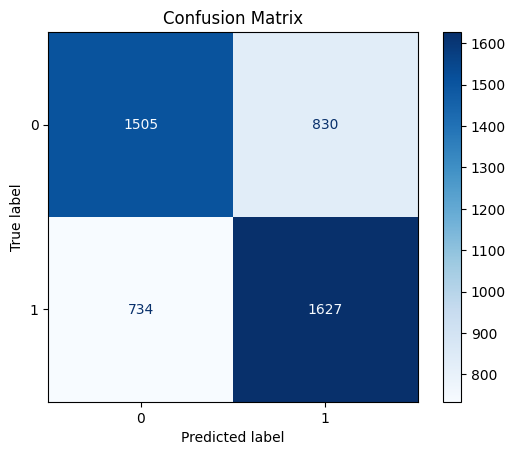

AUC: 0.7183289844701598


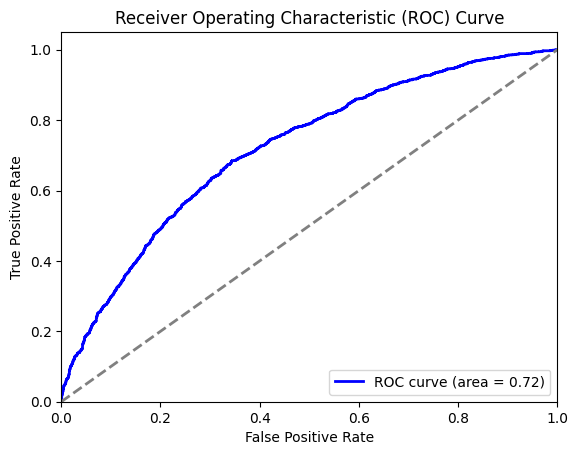

Positive Accuracy (Precision for positive class): 0.6621896621896622
Negative Accuracy (Precision for negative class): 0.6721750781598929
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Number of Hidden Layers: 2


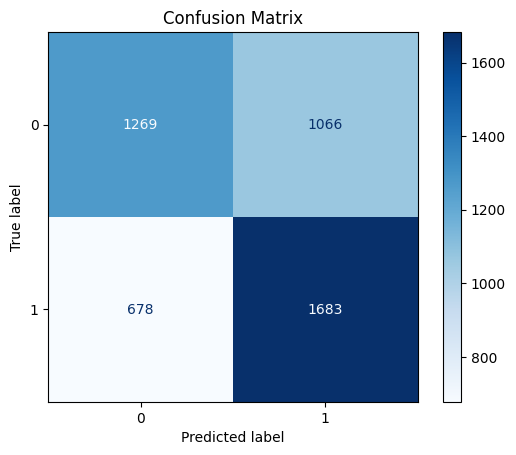

AUC: 0.6779085913401846


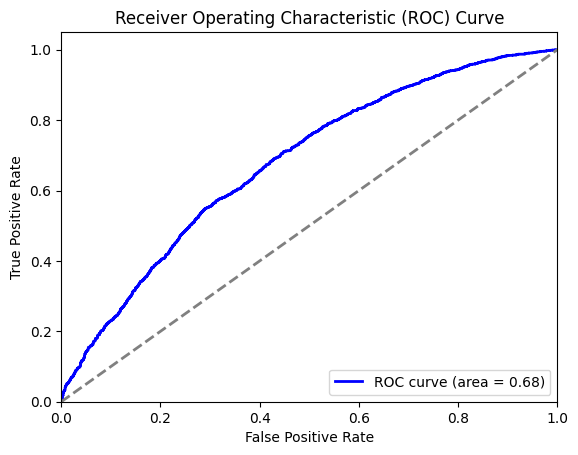

Positive Accuracy (Precision for positive class): 0.6122226264096035
Negative Accuracy (Precision for negative class): 0.6517719568567026
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Number of Hidden Layers: 3


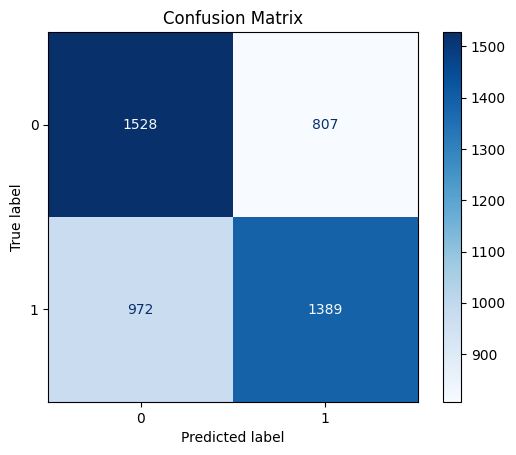

AUC: 0.6713020378437257


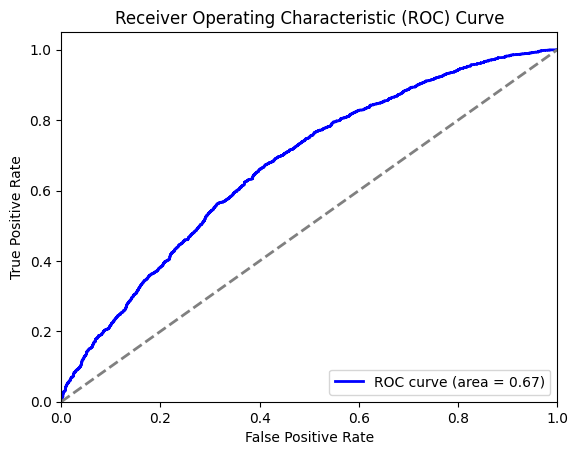

Positive Accuracy (Precision for positive class): 0.6325136612021858
Negative Accuracy (Precision for negative class): 0.6112


In [16]:
dir_path = config['model_output']['model_save_dir'] + config['date_string']+ '/' + 'test_log_'

for i in range(2,config['pathways_network']['n_hidden_layer']+2):
    print('-'*282)
    print(f'Number of Hidden Layers: {i-1}')
    result = pd.read_csv(f'{dir_path}{i}.csv',index_col=0)

    confusion_matrix_return(result)
    roc_curve_return(result)
    return_accuracy(result)

# Model Interpretation

In [17]:
# Define a hook function to capture the activations


def get_activation(name, number_of_layers, config, activations):
    def hook(model, input, output):
        # Convert output to numpy array for easier handling, but this is optional
        activations[name] = output.detach().numpy()
        
           
    return hook
def attaching_hook(model, dataloader):
    
        correct = 0
        total = 0
        predicted_list = []
        probability_list = []
        labels_list = []
        activations_list = []
        features_list = []
        criterion = nn.BCEWithLogitsLoss()
        loss = 0
        

        with torch.no_grad():  # No need to compute gradients during evaluation
            for sample_idx, (features, labels) in tqdm(enumerate(dataloader)):
                
                
                #print(labels)
                #print(features.shape)
                activations = {}
                for idx, layer in enumerate(model.layers):
                    layer_name = f'layer_{idx}'
                    number_of_layers = len(model.layers)
                    activation_hook = get_activation(layer_name, number_of_layers, config, activations)
                    
                    layer.register_forward_hook(activation_hook)
    
                outputs =  model(features)
                    #print(outputs)
                probability = torch.sigmoid(outputs.data)
                predicted = torch.round(torch.sigmoid(outputs.data))
                    #print(outputs)
                    #print(predicted)
                #loss += criterion(outputs, labels)
                    #_, predicted = torch.sigmoid(outputs.data)
                predicted_list.extend(predicted.detach().numpy())
                labels_list.extend(labels.detach().numpy())
                probability_list.extend(probability.detach().numpy())
                features_list.append(features)
                total += labels.size(0)
                x = activations
                activations_temp = activations.copy()
                activations_list.append(activations_temp)
                
                correct += (predicted == labels).sum().item()
                '''if sample_idx == 1000:
                    #print(activations_list)
                    break'''
                
            #print(total)
        accuracy = 100 * correct / total
        #print(activations_list)
        return activations_list, accuracy, predicted_list, labels_list, features_list,x
        


In [18]:

def return_feature_importance(model_dict_sparse, dataloader):
    predicted_list_dict = {}
    ground_truth_list_dict = {}
    activations_list_dict = {}
    accuracy_list_dict = {}
    for i, j in model_dict_sparse.items():
        #accuracy, loss, predicted_list, labels_list, probability_list = evaluate(j, dataloader)
        
        activations_list_dict[f'model_{i}_hidden_layers'], accuracy_list_dict[f'model_{i}_hidden_layers'], \
        predicted_list_dict[f'model_{i}_hidden_layers'], ground_truth_list_dict[f'model_{i}_hidden_layers'], \
        feature_list,x= attaching_hook(j, dataloader)
        print(f'{i} Layers: {accuracy_list_dict[f'model_{i}_hidden_layers']}')
        
    return activations_list_dict, accuracy_list_dict, predicted_list_dict, ground_truth_list_dict, feature_list,x

In [19]:

activations_list_dict, accuracy_list_dict, predicted_list_dict, ground_truth_list_dict, feature_list,x = return_feature_importance(model_dict_sparse, test_dataloader)

4696it [00:35, 130.83it/s]


2 Layers: 66.69505962521295


4696it [00:56, 82.91it/s] 


3 Layers: 62.86201022146508


4696it [01:20, 58.58it/s] 

4 Layers: 62.116695059625215


In [20]:
def return_feature_importance_list(activations_list_dict, model_name):
    m=0
    for k in tqdm(activations_list_dict[model_name]):
        #print(k)
        if m == 0:
            layer_dict = {key: [] for key in list(k.keys())}
        m = m+1
        
        #print(k['0_layer_0'])
        for z in list(layer_dict.keys()):
            #print(k)
            layer_dict[z].append(k[z][0])

    return layer_dict
    

In [21]:

layer_dict = return_feature_importance_list(activations_list_dict, 'model_2_hidden_layers')
layer_node_name_dict = {}
for i in range(config['pathways_network']['n_hidden_layer']+1):
    nodes_df = pd.read_csv(config['model_output']['model_save_dir'] + config['date_string'] + '/' + 'masking_df_' + \
    f'{config['pathways_network']['n_hidden_layer']-i}'+ '.csv', index_col = 0)
    layer_node_name_dict[f'layer_{i-1}'] = nodes_df.columns
    

layer_node_name_dict['final_layer'] = ['last_layer']

li = []
for i in layer_dict['layer_0']:
    li.append(list(i))
    
layer_0_df = pd.DataFrame(li,index = test_x.columns, columns=layer_node_name_dict['layer_0'])
layer_0_df

li = []
for i in layer_dict['layer_1']:
    li.append(list(i))
    
last_layer_df = pd.DataFrame(li,index = test_x.columns, columns=layer_node_name_dict['final_layer'])


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4696/4696 [00:00<00:00, 862819.85it/s]


In [23]:
layer_0_df

,R-HSA-3315487,R-HSA-3656532,R-HSA-209560_copy1,R-HSA-5205685_copy1,R-HSA-9032759_copy1,R-HSA-2514859_copy1,R-HSA-5358747,R-HSA-1971475_copy1,R-HSA-73776_copy1,R-HSA-159227_copy1,...,R-HSA-141430_copy1,R-HSA-9635465,R-HSA-389960_copy1,R-HSA-114508_copy2,R-HSA-9013419_copy1,R-HSA-2161541_copy1,R-HSA-6788467_copy1,R-HSA-3560801_copy1,R-HSA-8875555_copy1,R-HSA-416993
cell_id,,,,,,,,,,,,,,,,,,,,,
CACAACATCGTCCTTG.26.2,-0.104177,0.128060,0.010123,0.171800,0.378658,-0.086698,0.091002,-0.201550,0.261269,-0.081268,...,-0.191488,0.183320,-0.222688,0.238013,-0.061297,-0.146795,0.248670,-0.127721,0.462251,-0.377998
AGCTTCCGTCTCTCTG.9.9,0.000000,0.182171,0.000000,-0.176692,0.246327,0.090808,0.050610,-0.299075,0.129498,0.000000,...,0.000000,0.148118,-0.112575,0.702499,0.000000,0.000000,0.355612,-0.234067,0.169219,-0.423348
CGCCAGACAACAAGTA.17.11,-0.120349,0.228286,0.071449,0.011055,0.518755,-0.014310,0.083217,-0.186013,0.227450,-0.122589,...,0.000000,0.225380,-0.098334,0.302307,0.000000,-0.116238,0.225101,-0.162024,0.236334,-0.384918
GGGATGATCGTAACAC.7.4,-0.186852,0.068468,-0.056526,-0.028001,0.518847,0.015822,0.088915,-0.159729,0.074406,0.000000,...,-0.115525,0.229217,-0.155028,0.542527,-0.065121,0.000000,0.000000,-0.259453,0.297295,-0.190980
ACGTTCCGTATTCTCT.5.11,0.000000,0.000000,0.000000,0.354219,0.000000,0.000000,0.000000,-0.191324,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.299068,0.000000,-0.592075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CATCAAGTCCTCGCAT.19.1,0.000000,0.000000,0.149445,0.217579,0.438324,0.043964,0.059833,-0.162424,-0.391722,0.000000,...,-0.104156,0.327104,-0.248611,0.653575,0.000000,0.000000,0.000000,-0.263830,0.000000,-0.280876
GTCAGCGGTCTGATAC.45.2,-0.250623,0.000000,-0.057824,-0.073373,0.379557,0.123249,-0.015392,-0.067214,-0.040238,0.000000,...,0.000000,0.404054,-0.270675,0.303669,0.000000,0.000000,0.241985,0.105066,0.342795,-0.309141
CATGCTCAGTGTCATC.30.10,0.000000,0.071860,-0.044960,-0.163976,0.383798,0.009163,0.044208,-0.066473,0.181265,0.000000,...,0.000000,0.199733,-0.076705,-0.109112,0.000000,-0.082373,0.245705,-0.107975,0.359899,-0.291026


In [25]:
last_layer_df

,last_layer
cell_id,
CACAACATCGTCCTTG.26.2,0.219095
AGCTTCCGTCTCTCTG.9.9,-0.219352
CGCCAGACAACAAGTA.17.11,-0.233183
GGGATGATCGTAACAC.7.4,0.532885
ACGTTCCGTATTCTCT.5.11,-0.003342
...,...
CATCAAGTCCTCGCAT.19.1,-1.132989
GTCAGCGGTCTGATAC.45.2,0.942101
CATGCTCAGTGTCATC.30.10,0.784364


In [26]:
layer_1_df

NameError: name 'layer_1_df' is not defined

In [27]:
last_layer_df

,last_layer
cell_id,
CACAACATCGTCCTTG.26.2,0.219095
AGCTTCCGTCTCTCTG.9.9,-0.219352
CGCCAGACAACAAGTA.17.11,-0.233183
GGGATGATCGTAACAC.7.4,0.532885
ACGTTCCGTATTCTCT.5.11,-0.003342
...,...
CATCAAGTCCTCGCAT.19.1,-1.132989
GTCAGCGGTCTGATAC.45.2,0.942101
CATGCTCAGTGTCATC.30.10,0.784364


In [28]:
y_test

,diagnosis
0,1
1,0
2,0
3,1
4,1
...,...
4691,1
4692,1
4693,1
4694,0


In [29]:
for i,j in predicted_list_dict.items():
    flattened_list = [item for sublist in list(predicted_list_dict[i]) for item in sublist]
    predicted_list_dict[i] = flattened_list
    

In [30]:
predicted_list_dict['model_2_hidden_layers'][0:10]

[1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0]

In [31]:
predicted_list_dict['model_4_hidden_layers'][0:10]

[1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0]

In [32]:
for i,j in ground_truth_list_dict.items():
    flattened_list = [item for sublist in list(ground_truth_list_dict[i]) for item in sublist]
    ground_truth_list_dict[i] = flattened_list
    

In [33]:
ground_truth_list_dict['model_2_hidden_layers'][0:10]

[1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0]

In [34]:
ground_truth_list_dict['model_4_hidden_layers'][0:10]

[1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0]

In [35]:
predicted_list_dict['model_2_hidden_layers'][0:10]

[1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0]

In [36]:
layer_1_df['predicted'] = predicted_list_dict['model_2_hidden_layers']
layer_1_df['ground_truth'] = ground_truth_list_dict['model_2_hidden_layers']
layer_1_df.head()

NameError: name 'layer_1_df' is not defined

In [37]:
correct_predicted_layer_1_df = layer_1_df[layer_1_df.predicted == layer_1_df.ground_truth]
correct_predicted_layer_1_df_AD = correct_predicted_layer_1_df[correct_predicted_layer_1_df.predicted == 1]
correct_predicted_layer_1_df_Control = correct_predicted_layer_1_df[correct_predicted_layer_1_df.predicted == 0]

NameError: name 'layer_1_df' is not defined

In [38]:
correct_predicted_layer_1_df_AD.drop(columns=['predicted','ground_truth'], inplace = True)
correct_predicted_layer_1_df_AD.head()

NameError: name 'correct_predicted_layer_1_df_AD' is not defined

In [39]:
correct_predicted_layer_1_df_Control.drop(columns=['predicted','ground_truth'], inplace = True)
correct_predicted_layer_1_df_Control

NameError: name 'correct_predicted_layer_1_df_Control' is not defined

In [40]:
from scipy import stats



# Perform a two-sample t-test





In [41]:
pathways_list = []
p_value_list = []

for i in correct_predicted_layer_1_df_Control.columns:
    t_stat, p_value = stats.ttest_ind(correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist())
    print(f"T-statistic: {t_stat}")
    print(f"P-value: {p_value}")

    plt.figure(figsize=(8, 6))
    plt.boxplot([correct_predicted_layer_1_df_Control[i].tolist(), correct_predicted_layer_1_df_AD[i].tolist()], labels=['Control', 'AD'], patch_artist=True, 
                boxprops=dict(facecolor='lightblue'))
    
    # Add title and labels
    plt.title('Box Plot of Two Distributions')
    plt.ylabel('Values')
    pathways_list.append(i)
    p_value_list.append(p_value)
    # Display the plot
    plt.show()
    
    

NameError: name 'correct_predicted_layer_1_df_Control' is not defined

In [42]:
pd.DataFrame(pathways_list, p_value_list)

""


In [43]:

layer_dict = return_feature_importance_list(activations_list_dict, 'model_3_hidden_layers')
layer_node_name_dict = {}
for i in range(config['pathways_network']['n_hidden_layer']+1):
    nodes_df = pd.read_csv(config['model_output']['model_save_dir'] + config['date_string'] + '/' + 'masking_df_' + \
    f'{config['pathways_network']['n_hidden_layer']-i}'+ '.csv', index_col = 0)
    layer_node_name_dict[f'layer_{i-1}'] = nodes_df.columns
    

layer_node_name_dict['final_layer'] = ['last_layer']

li = []
for i in layer_dict['layer_0']:
    li.append(list(i))    
layer_0_df = pd.DataFrame(li,index = test_x.columns, columns=layer_node_name_dict['layer_0'])

li = []
for i in layer_dict['layer_1']:
    li.append(list(i)) 
layer_1_df = pd.DataFrame(li,index = test_x.columns, columns=layer_node_name_dict['layer_1'])

li = []
for i in layer_dict['layer_2']:
    li.append(list(i))   
last_layer_df = pd.DataFrame(li,index = test_x.columns, columns=layer_node_name_dict['final_layer'])


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4696/4696 [00:00<00:00, 554142.80it/s]


In [44]:
layer_1_df

,R-HSA-417957,R-HSA-162592,R-HSA-5654689,R-HSA-75896,R-HSA-5654716,R-HSA-159231,R-HSA-5210891,R-HSA-113507,R-HSA-5339716,R-HSA-9034864,...,R-HSA-5655291_copy1,R-HSA-5654688,R-HSA-6783310_copy1,R-HSA-5675482,R-HSA-9027604,R-HSA-5661231,R-HSA-2979096,R-HSA-901042,R-HSA-9665348,R-HSA-77288
cell_id,,,,,,,,,,,,,,,,,,,,,
CACAACATCGTCCTTG.26.2,0.003275,0.009810,-0.015456,0.000000,0.001502,0.001915,0.009021,-0.010476,-0.006433,-0.000057,...,0.027487,0.000277,0.002091,-0.000094,0.000000,0.000000,0.012869,-0.000795,0.011302,-0.000602
AGCTTCCGTCTCTCTG.9.9,0.000000,0.012895,-0.005234,0.000000,-0.003001,0.000000,0.010151,-0.005489,-0.002985,0.000000,...,0.008764,0.000000,0.000000,0.000000,0.000000,0.000000,0.023016,0.000000,0.000332,0.000000
CGCCAGACAACAAGTA.17.11,0.000000,0.013725,-0.010916,0.000000,-0.001140,0.006392,0.008776,-0.012376,-0.004896,-0.000100,...,0.023170,-0.000132,0.005502,0.003574,-0.000662,0.000000,0.011449,-0.001674,0.009848,-0.000389
GGGATGATCGTAACAC.7.4,0.000000,0.007576,-0.009176,-0.003849,0.012905,0.000000,0.014573,0.000000,-0.005228,-0.000047,...,0.016054,0.000687,0.004162,-0.004238,0.000000,0.000000,0.016451,0.000013,0.015558,0.000000
ACGTTCCGTATTCTCT.5.11,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.034737,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CATCAAGTCCTCGCAT.19.1,0.012875,0.000000,0.000000,0.000000,0.000000,0.000000,0.006510,-0.006484,-0.003527,0.000000,...,0.000000,0.000000,0.009876,0.006180,0.000000,0.000000,0.003763,-0.004656,0.000000,-0.001288
GTCAGCGGTCTGATAC.45.2,0.000000,0.025255,-0.016036,0.000000,-0.005883,0.000000,0.013536,-0.007280,-0.001409,-0.000141,...,0.033405,-0.000373,-0.001616,-0.004335,0.000000,0.000069,0.016819,0.000014,0.011218,0.000000
CATGCTCAGTGTCATC.30.10,0.000000,0.020581,-0.013634,0.000000,-0.011415,0.000000,0.013967,-0.013448,-0.003815,-0.000052,...,0.025742,-0.000368,0.000013,-0.003372,0.000000,0.000000,0.008851,0.000011,0.001313,0.000000


In [45]:

layer_dict = return_feature_importance_list(activations_list_dict, 'model_4_hidden_layers')
layer_node_name_dict = {}
for i in range(config['pathways_network']['n_hidden_layer']+1):
    nodes_df = pd.read_csv(config['model_output']['model_save_dir'] + config['date_string'] + '/' + 'masking_df_' + \
    f'{config['pathways_network']['n_hidden_layer']-i}'+ '.csv', index_col = 0)
    layer_node_name_dict[f'layer_{i-1}'] = nodes_df.columns
    

layer_node_name_dict['final_layer'] = ['last_layer']

li = []
for i in layer_dict['layer_0']:
    li.append(list(i))    
layer_0_df = pd.DataFrame(li,index = test_x.columns, columns=layer_node_name_dict['layer_0'])

li = []
for i in layer_dict['layer_1']:
    li.append(list(i)) 
layer_1_df = pd.DataFrame(li,index = test_x.columns, columns=layer_node_name_dict['layer_1'])

li = []
for i in layer_dict['layer_2']:
    li.append(list(i)) 
layer_2_df = pd.DataFrame(li,index = test_x.columns, columns=layer_node_name_dict['layer_2'])

li = []
for i in layer_dict['layer_3']:
    li.append(list(i))   
last_layer_df = pd.DataFrame(li,index = test_x.columns, columns=layer_node_name_dict['final_layer'])


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4696/4696 [00:00<00:00, 443773.69it/s]


In [46]:
layer_2_df

,R-HSA-5655332,R-HSA-5693537,R-HSA-5205647,R-HSA-881907,R-HSA-2660825,R-HSA-5654696,R-HSA-109704,R-HSA-198753,R-HSA-211976,R-HSA-5654687,...,R-HSA-389356,R-HSA-8979227,R-HSA-446353,R-HSA-196807,R-HSA-1181150,R-HSA-1839124,R-HSA-6804758,R-HSA-3371571,R-HSA-5260271,R-HSA-8963898
cell_id,,,,,,,,,,,,,,,,,,,,,
CACAACATCGTCCTTG.26.2,-0.003298,-0.000165,-0.001825,-0.000286,0.001378,-0.003232,0.001074,-0.000682,0.000001,0.000799,...,0.000024,0.001375,0.000942,-0.000680,-0.000505,-0.000043,0.000042,-0.000133,0.002777,0.004619
AGCTTCCGTCTCTCTG.9.9,-0.001275,-0.000542,0.003747,0.000000,0.002781,-0.001038,0.000221,-0.000620,0.000007,0.000482,...,0.000059,0.000580,0.001331,-0.000299,-0.000403,-0.000027,0.000000,-0.000133,0.004294,0.001991
CGCCAGACAACAAGTA.17.11,-0.002072,-0.000194,-0.000583,0.000020,0.001338,-0.003624,0.000773,-0.000940,0.000005,0.000524,...,-0.000422,0.001126,0.001401,-0.000515,-0.000350,-0.000085,0.000048,-0.000117,0.003689,0.003816
GGGATGATCGTAACAC.7.4,-0.001756,-0.000536,0.001314,-0.000621,0.001628,-0.001184,0.001733,-0.000956,0.000010,-0.000068,...,0.000212,0.001284,0.001769,-0.000462,-0.000622,-0.000023,0.000000,-0.000158,0.002709,0.004330
ACGTTCCGTATTCTCT.5.11,0.000000,0.000000,-0.004301,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.000240,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
CATCAAGTCCTCGCAT.19.1,0.000000,-0.000968,-0.004846,0.000000,0.000000,0.000000,0.000000,-0.001352,0.000008,0.000000,...,0.000000,0.001268,0.001014,-0.000750,0.000000,-0.000026,0.000000,0.000000,0.003127,0.004278
GTCAGCGGTCTGATAC.45.2,-0.003111,0.000000,0.003738,0.000186,0.001664,-0.005484,0.000576,-0.001488,0.000012,0.000944,...,-0.000818,0.000000,0.000000,-0.000397,-0.000792,-0.000100,0.000000,-0.000109,0.002332,0.000000
CATGCTCAGTGTCATC.30.10,-0.003066,-0.000559,0.005367,0.000263,0.000776,-0.003960,0.001311,-0.000742,0.000011,0.001265,...,-0.000353,0.001623,0.001542,-0.000403,-0.000563,-0.000065,0.000028,-0.000110,0.000000,0.005398


# layer_2_df

# Plots

In [782]:
!pwd

/12tb_dsk1/danish/Pytorch_Biologically_Informed_Neural_Network
